In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sini = 0.5
g1 = 0.05
g2 = 0.0

eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma_p=g1)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma_x=g2)

slitAng_major_p = theta_obs
slitAng_minor_p = theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

eobs_thy: 0.23450413223140495
slitAng_major_p: 0.0
slitAng_minor_p: 90.0


In [3]:
#TF_pars = load_pickle("/Users/hhg/Research/kinematic_lensing/data/TF_pars.pickle")
#meta_parameters = ("/Users/hhg/Research/kinematic_lensing/data/meta_parameters.pickle")

#data = load_pickle("/Users/hhg/Research/kinematic_lensing/data/data.pickle")
#noise = load_pickle("/Users/hhg/Research/kinematic_lensing/data/noise.pickle")
#obslambda = np.load("/Users/hhg/Research/kinematic_lensing/data/obslambda.npy")


update_TF, _ = get_TFcube_pars()

update_TF['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])

update_TF['g1'] = g1
update_TF['g2'] = g2
update_TF['sini'] = sini
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.1185# 0.1185  # 0.032 

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.033 #0.033 # 0.025
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)


# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    #data_info['data'] = data['spectra'][0] # this line is to make it compatible with older branches... 
    data_info['data_major'] = data['spectra'][0]
    data_info['data_minor'] = data['spectra'][1]
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']    = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image']  = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']     = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
CPU times: user 8.61 s, sys: 144 ms, total: 8.75 s
Wall time: 7.43 s


In [4]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/gamma.py

Gamma=Gamma(data_info=data_info, sigma_TF_intr=0.08, mode_gamma_x=False)

time cost in gaussFit_spec2D: 0.1486668586730957 (secs)


In [5]:
chain_info = Gamma.run_MCMC(Nwalker=100, Nsteps=3000)

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 26/3000 [00:02<05:21,  9.25it/s]

sini out of [-1, 1]! sini=156.4501612244915/151.3102692894574=1.0339692207222329


  1%|▏         | 38/3000 [00:04<05:17,  9.33it/s]

sini out of [-1, 1]! sini=151.54517657571117/133.2393194750785=1.1373908030508715


  1%|▏         | 41/3000 [00:04<05:14,  9.39it/s]

sini out of [-1, 1]! sini=100.2447667980597/85.95908039527222=1.1661917081604003
sini out of [-1, 1]! sini=157.74961103830583/125.04428109682=1.2615499857699415


  1%|▏         | 43/3000 [00:04<05:28,  8.99it/s]

sini out of [-1, 1]! sini=122.46188634595956/122.35306310117765=1.0008894198643143


  2%|▏         | 46/3000 [00:04<05:26,  9.05it/s]

sini out of [-1, 1]! sini=138.4696175289077/107.80250494251617=1.284474953552742
sini out of [-1, 1]! sini=106.18656200697409/91.90188439255706=1.1554340012594335
sini out of [-1, 1]! sini=114.50003430227859/89.3198284541467=1.2819105934698298
sini out of [-1, 1]! sini=129.4278548214254/115.28195234887325=1.1227069995287984
sini out of [-1, 1]! sini=157.68095374783573/127.77528836679795=1.234048897586434


  2%|▏         | 48/3000 [00:05<05:18,  9.27it/s]

sini out of [-1, 1]! sini=102.43502531446536/63.03754528209001=1.6249843621935707
sini out of [-1, 1]! sini=103.94983686838621/98.47674755141153=1.0555774784714265
sini out of [-1, 1]! sini=137.03139427017604/128.06603647319096=1.070005741130763
sini out of [-1, 1]! sini=111.17036009240465/99.73122104246605=1.114699679101169


  2%|▏         | 52/3000 [00:05<05:10,  9.49it/s]

sini out of [-1, 1]! sini=87.60051886392989/70.34079337553604=1.2453729146364256
sini out of [-1, 1]! sini=146.03897167623077/102.8604445724138=1.4197777608614095


  2%|▏         | 54/3000 [00:05<05:11,  9.44it/s]

sini out of [-1, 1]! sini=112.59824519197437/92.62628179770938=1.2156187531945053
sini out of [-1, 1]! sini=111.43728520571347/97.22462831513357=1.1461837102067647


  2%|▏         | 57/3000 [00:06<05:19,  9.20it/s]

sini out of [-1, 1]! sini=115.47525657979723/61.8171930565361=1.8680119699739055
sini out of [-1, 1]! sini=144.01375430202478/115.03087631104302=1.2519573780574547


  2%|▏         | 63/3000 [00:06<05:10,  9.46it/s]

sini out of [-1, 1]! sini=118.79598381485607/108.01886538107487=1.0997707057536763


  2%|▏         | 66/3000 [00:07<05:06,  9.57it/s]

sini out of [-1, 1]! sini=103.14173170432844/99.69303822590786=1.0345931224465816
sini out of [-1, 1]! sini=98.65538678431584/71.46256864838207=1.3805183419830713
sini out of [-1, 1]! sini=134.66494658803595/93.11125185565206=1.4462800564297373
sini out of [-1, 1]! sini=115.02408187014657/94.53630450277859=1.2167186191074966


  2%|▏         | 69/3000 [00:07<05:11,  9.42it/s]

sini out of [-1, 1]! sini=101.99644331190628/45.606613723843225=2.236439739409601
sini out of [-1, 1]! sini=81.45265403633354/77.00385903423248=1.0577736630072438
sini out of [-1, 1]! sini=107.47713191298178/-25.40040129182148=-4.231316296077089


  2%|▏         | 71/3000 [00:07<05:13,  9.33it/s]

sini out of [-1, 1]! sini=89.17305979824259/84.36599555337725=1.0569786940026562
sini out of [-1, 1]! sini=131.99270680223088/84.81655117335171=1.556214028703649
sini out of [-1, 1]! sini=96.4070309607205/92.13710160964968=1.0463432132818864
sini out of [-1, 1]! sini=111.29727706139961/72.05547214439989=1.5446054789337686


  2%|▎         | 75/3000 [00:08<05:08,  9.49it/s]

sini out of [-1, 1]! sini=88.49410772086222/74.81091658142049=1.1829036692064805
sini out of [-1, 1]! sini=102.48997089491489/76.2014947552166=1.3449863578679817
sini out of [-1, 1]! sini=107.94557762958371/89.76366590970434=1.202553132557766
sini out of [-1, 1]! sini=99.91828672753265/68.18456246633653=1.4654092233394238
sini out of [-1, 1]! sini=135.41357616723613/64.23337225080584=2.1081498825641574


  3%|▎         | 78/3000 [00:08<05:02,  9.64it/s]

sini out of [-1, 1]! sini=92.03230088344047/37.70028033239413=2.4411569376146343
sini out of [-1, 1]! sini=110.36219086429605/92.13611235780357=1.197816882437072
sini out of [-1, 1]! sini=100.36675397564153/88.2746498534336=1.1369827480741639
sini out of [-1, 1]! sini=128.64656074485438/117.54153076512806=1.094477500058396
sini out of [-1, 1]! sini=109.33293249436466/24.971013527206253=4.378393867563484
sini out of [-1, 1]! sini=85.35900081880325/74.59175936750296=1.1443489407221463


  3%|▎         | 80/3000 [00:08<05:23,  9.03it/s]

sini out of [-1, 1]! sini=91.74537402654761/89.72845369519834=1.022478046241615
sini out of [-1, 1]! sini=115.00964103412932/113.98782116203793=1.0089642898835554
sini out of [-1, 1]! sini=144.43671671875904/86.56083775222965=1.6686150512104838
sini out of [-1, 1]! sini=106.27097684366397/75.64293428865244=1.4049028880626884
sini out of [-1, 1]! sini=157.02607337160438/103.3081388925166=1.519977758334963
sini out of [-1, 1]! sini=95.30262669874583/76.76177604893829=1.2415375412625562


  3%|▎         | 83/3000 [00:08<05:12,  9.33it/s]

sini out of [-1, 1]! sini=99.7141261966841/99.52922534077754=1.0018577543959926
sini out of [-1, 1]! sini=126.12166649131257/-5.515101708322447=-22.86842077653642
sini out of [-1, 1]! sini=120.39944907092926/90.21636252553913=1.3345633286516698
sini out of [-1, 1]! sini=157.88191854048546/154.46798070244174=1.022101265404771
sini out of [-1, 1]! sini=105.02138407764964/41.8765297413579=2.507881735337036


  3%|▎         | 85/3000 [00:09<05:06,  9.50it/s]

sini out of [-1, 1]! sini=124.95675291384042/110.8630580348505=1.1271270622406924
sini out of [-1, 1]! sini=127.74939727339115/118.04249447035045=1.0822322744584059
sini out of [-1, 1]! sini=101.03411413538333/100.3773776759216=1.0065426740035197
sini out of [-1, 1]! sini=83.2952536239092/71.55287586783061=1.1641076981695133


  3%|▎         | 88/3000 [00:09<05:10,  9.39it/s]

sini out of [-1, 1]! sini=132.75379239131405/130.44308099003757=1.0177143270746032
sini out of [-1, 1]! sini=129.02458492638692/118.50503144519854=1.088768834140625
sini out of [-1, 1]! sini=116.41714210851508/108.07719545474349=1.0771665717146026
sini out of [-1, 1]! sini=151.85261591932087/147.14004060729508=1.0320278239191416
sini out of [-1, 1]! sini=151.66408553258947/143.40524293084192=1.0575909390267582


  3%|▎         | 90/3000 [00:09<05:05,  9.54it/s]

sini out of [-1, 1]! sini=120.56329180668655/114.85274729494417=1.0497205739195563
sini out of [-1, 1]! sini=90.68905347195857/70.05113267650543=1.2946122354760285
sini out of [-1, 1]! sini=116.97865144833978/98.59336471746055=1.186475903156019
sini out of [-1, 1]! sini=113.8048956091372/94.3063182535177=1.2067579109938606
sini out of [-1, 1]! sini=111.01445905433856/102.70945233327595=1.0808592250508178
sini out of [-1, 1]! sini=118.58376515619312/79.09995414303148=1.4991635133158934


  3%|▎         | 93/3000 [00:09<05:19,  9.11it/s]

sini out of [-1, 1]! sini=104.17149305039791/95.32162566500438=1.092842178505172
sini out of [-1, 1]! sini=110.76837426244786/104.97430009899927=1.0551951683220018
sini out of [-1, 1]! sini=105.066990853791/55.537268657991405=1.891828557518963
sini out of [-1, 1]! sini=94.60196559442994/85.72448231235245=1.1035583189610967
sini out of [-1, 1]! sini=109.09074645536587/-11.477684778083841=-9.504595096013622


  3%|▎         | 95/3000 [00:10<05:09,  9.37it/s]

sini out of [-1, 1]! sini=93.91066386494664/93.07176199013583=1.0090134951447436
sini out of [-1, 1]! sini=106.06170677293282/66.14741003243726=1.6034143547105237
sini out of [-1, 1]! sini=108.26999613971124/100.110365532254=1.081506351156298
sini out of [-1, 1]! sini=126.356049866751/121.75703263432686=1.0377720870238056
sini out of [-1, 1]! sini=122.1641262827312/94.4435238651619=1.2935151218748078


  3%|▎         | 97/3000 [00:10<05:10,  9.34it/s]

sini out of [-1, 1]! sini=112.46382022787697/90.51528216055875=1.2424843357211794
sini out of [-1, 1]! sini=118.40871257010636/105.35184952700664=1.1239357742813298
sini out of [-1, 1]! sini=133.65672430277414/86.33763601231797=1.5480702330523046
sini out of [-1, 1]! sini=89.82669614162116/68.58219813168733=1.3097669451938743
sini out of [-1, 1]! sini=131.63489836590924/92.38281277825035=1.4248851534957807
sini out of [-1, 1]! sini=119.19988124006511/74.23035042555341=1.6058105688132542
sini out of [-1, 1]! sini=107.40521673754786/86.44298509163575=1.2424977761201865


  3%|▎         | 99/3000 [00:10<05:05,  9.50it/s]

sini out of [-1, 1]! sini=125.1019117730359/94.36847194635455=1.3256748699306302
sini out of [-1, 1]! sini=98.47596546634568/74.51970155524126=1.3214755750644775
sini out of [-1, 1]! sini=131.60576588991626/65.22816907856966=2.017621646429971
sini out of [-1, 1]! sini=99.93305341130076/-61.639063255858844=-1.6212617150991833
sini out of [-1, 1]! sini=128.31023623796833/126.54738490123827=1.0139303655947205
sini out of [-1, 1]! sini=120.7162008200502/111.59995753288229=1.0816867988904195


  3%|▎         | 101/3000 [00:10<05:11,  9.32it/s]

sini out of [-1, 1]! sini=99.30237609348657/94.89893359018892=1.0464013907923713
sini out of [-1, 1]! sini=124.61018903649654/116.00434690197805=1.0741855142875836
sini out of [-1, 1]! sini=99.24844859172318/97.62495851572976=1.0166298669999623
sini out of [-1, 1]! sini=127.13094819561677/97.55863784003753=1.303123444630988


  3%|▎         | 103/3000 [00:11<05:15,  9.19it/s]

sini out of [-1, 1]! sini=125.4636355880052/80.83439658978969=1.5521070346413979
sini out of [-1, 1]! sini=109.43098394139177/108.8139679366534=1.0056703750119431
sini out of [-1, 1]! sini=133.5073060855946/125.97313465539207=1.059807763383937
sini out of [-1, 1]! sini=127.9851234547641/117.28270136113557=1.0912532024707868
sini out of [-1, 1]! sini=114.94300478680255/89.19085310021418=1.2887308596280993
sini out of [-1, 1]! sini=128.5429957187712/77.88996993915646=1.6503151281119024


  4%|▎         | 105/3000 [00:11<05:08,  9.39it/s]

sini out of [-1, 1]! sini=129.68639108779672/113.74417412779331=1.140158536314063
sini out of [-1, 1]! sini=123.76344504343527/92.97212145905135=1.3311887811223675
sini out of [-1, 1]! sini=67.9124466229575/62.5254909938663=1.0861561507708857


  4%|▎         | 107/3000 [00:11<05:07,  9.40it/s]

sini out of [-1, 1]! sini=95.04448440877933/81.062179304972=1.172488640494146
sini out of [-1, 1]! sini=135.5448285687204/71.94908312253446=1.883899317214061
sini out of [-1, 1]! sini=140.96955401479602/80.21726724662517=1.757346751558989


  4%|▎         | 110/3000 [00:11<05:04,  9.50it/s]

sini out of [-1, 1]! sini=113.20402768717663/58.51669210218628=1.9345595866815435
sini out of [-1, 1]! sini=51.96376865797022/37.18323829898665=1.3975051941451366
sini out of [-1, 1]! sini=145.61165162272889/131.95222623193942=1.103517960862438
sini out of [-1, 1]! sini=119.86175394908807/51.69334652468717=2.318707570844649
sini out of [-1, 1]! sini=125.41293547972842/75.83786080413736=1.6536982207821778


  4%|▍         | 113/3000 [00:12<05:00,  9.61it/s]

sini out of [-1, 1]! sini=110.10720768127786/82.81549400531398=1.329548401585489
sini out of [-1, 1]! sini=107.64483196149459/102.86962977757227=1.0464199413786888
sini out of [-1, 1]! sini=125.36472944323074/106.39790871035504=1.178263097111323
sini out of [-1, 1]! sini=86.12119286565661/70.56221722307788=1.2205000955878418
sini out of [-1, 1]! sini=126.23232902110223/106.36710555488747=1.1867609667724193
sini out of [-1, 1]! sini=122.60513597851038/71.24935751401375=1.7207893552499145
sini out of [-1, 1]! sini=104.45121357029522/91.67716679572308=1.1393372768928989
sini out of [-1, 1]! sini=87.41634910878098/41.709020746393605=2.09586193932255
sini out of [-1, 1]! sini=120.52803603406402/117.52965681612554=1.0255116818951444
sini out of [-1, 1]! sini=122.72064390460068/96.64348336752673=1.269828441902335


  4%|▍         | 116/3000 [00:12<05:01,  9.57it/s]

sini out of [-1, 1]! sini=128.26791548613647/32.072845849600725=3.999268293422527
sini out of [-1, 1]! sini=125.01416094766125/123.03476457354353=1.016088106324896
sini out of [-1, 1]! sini=109.58529989044432/79.63809950355738=1.3760411232007013
sini out of [-1, 1]! sini=96.4421409744782/94.50584731960106=1.02048861218427
sini out of [-1, 1]! sini=115.31886919109311/51.2866721473155=2.248515342540689
sini out of [-1, 1]! sini=130.18357534779415/120.75909623539272=1.0780436373424866


  4%|▍         | 117/3000 [00:12<04:59,  9.62it/s]

sini out of [-1, 1]! sini=127.25665588533342/118.79226953032735=1.0712536799614316
sini out of [-1, 1]! sini=110.01065826102807/94.80914336705092=1.1603380681874207


  4%|▍         | 119/3000 [00:12<05:06,  9.41it/s]

sini out of [-1, 1]! sini=131.9151252470418/99.58684231164472=1.3246240385273962
sini out of [-1, 1]! sini=126.26189933464534/115.37706780446078=1.0943413776872195
sini out of [-1, 1]! sini=112.57908899040373/56.07237513100202=2.0077460376412617
sini out of [-1, 1]! sini=117.11064650477725/90.46092784901248=1.294599218573632
sini out of [-1, 1]! sini=144.91461201512158/82.62683863237692=1.7538443248431086
sini out of [-1, 1]! sini=131.3713628358478/30.858718381162873=4.25718791082526
sini out of [-1, 1]! sini=133.9380364246745/118.8255818910073=1.1271818264481892


  4%|▍         | 122/3000 [00:13<05:05,  9.43it/s]

sini out of [-1, 1]! sini=142.42080146634356/124.33424456324971=1.1454672199652371
sini out of [-1, 1]! sini=109.6406603147108/92.7463583157514=1.182155960684121
sini out of [-1, 1]! sini=91.43909206135318/66.63120144006649=1.372316423614257
sini out of [-1, 1]! sini=138.72313581886453/87.56156237971392=1.5842926056673885
sini out of [-1, 1]! sini=121.01165442650807/69.32669962445095=1.745527409815255
sini out of [-1, 1]! sini=116.97670470068935/110.65971958580451=1.0570847742839862
sini out of [-1, 1]! sini=121.27106437409249/36.91433325356698=3.2852026214607095
sini out of [-1, 1]! sini=122.59313213903681/99.5092334805951=1.2319774542625053
sini out of [-1, 1]! sini=103.42121877775062/84.44452383519435=1.2247238077816867


  4%|▍         | 124/3000 [00:13<05:01,  9.55it/s]

sini out of [-1, 1]! sini=111.23901488398965/111.12589358272851=1.001017956280162
sini out of [-1, 1]! sini=86.7821140065784/77.05106083684532=1.1262935651248003
sini out of [-1, 1]! sini=140.5674022546873/52.3475192093245=2.685273426092911
sini out of [-1, 1]! sini=104.10461835931241/98.42935087880528=1.0576582841381836
sini out of [-1, 1]! sini=127.61978645358086/99.9317491413488=1.277069475418354
sini out of [-1, 1]! sini=127.94644421547372/99.15812383304336=1.2903274010196324


  4%|▍         | 127/3000 [00:13<05:01,  9.53it/s]

sini out of [-1, 1]! sini=99.77498980304159/97.26758267750031=1.025778445978809
sini out of [-1, 1]! sini=128.42164037252948/87.74475178569314=1.4635820121320207
sini out of [-1, 1]! sini=129.49623897536196/102.94925833077252=1.2578647100039797
sini out of [-1, 1]! sini=134.3916603490337/90.29427531425347=1.4883740954928426
sini out of [-1, 1]! sini=131.2601694110219/80.43895026330296=1.6317986371200084
sini out of [-1, 1]! sini=132.60147595562282/99.2529349389983=1.3359955152673402


  4%|▍         | 130/3000 [00:13<05:08,  9.31it/s]

sini out of [-1, 1]! sini=132.21973929117198/27.330319138578858=4.8378410299839345
sini out of [-1, 1]! sini=125.34245553819792/122.44822628301125=1.0236363509953776
sini out of [-1, 1]! sini=129.9595335180128/123.98107734905918=1.0482207147798992
sini out of [-1, 1]! sini=123.79443443429014/84.3817290287679=1.4670762955341368
sini out of [-1, 1]! sini=127.90705213690639/102.15258183551876=1.2521176639750158
sini out of [-1, 1]! sini=135.05557050633527/102.13480187851053=1.3223266508803144
sini out of [-1, 1]! sini=133.73196464491753/121.91486068212079=1.0969291511853383


  4%|▍         | 132/3000 [00:14<05:10,  9.24it/s]

sini out of [-1, 1]! sini=98.85716170903933/97.39278602067206=1.0150357716233362
sini out of [-1, 1]! sini=125.9933056969314/124.95342833657394=1.0083221194824399
sini out of [-1, 1]! sini=125.7734164743936/61.14800670528271=2.056868625016484
sini out of [-1, 1]! sini=142.09647748370924/62.86812210785803=2.2602309838351013
sini out of [-1, 1]! sini=121.90972989023706/120.19837441777491=1.0142377588777862
sini out of [-1, 1]! sini=107.19724160877107/101.15078753727911=1.0597766386076186
sini out of [-1, 1]! sini=124.2524428878027/113.5128992565152=1.0946107772916487
sini out of [-1, 1]! sini=83.11151745281506/65.63896542876154=1.2661917644484604
sini out of [-1, 1]! sini=127.04736089128038/116.87414581689903=1.0870441876026133
sini out of [-1, 1]! sini=120.23533537152724/81.94927602756144=1.4671921608079772


  4%|▍         | 134/3000 [00:14<05:04,  9.41it/s]

sini out of [-1, 1]! sini=125.87433574619686/120.60112256868774=1.0437244120551679
sini out of [-1, 1]! sini=124.70666462330163/104.89078120090554=1.1889192090622454
sini out of [-1, 1]! sini=77.59099299757159/42.947270673615776=1.8066571351468637
sini out of [-1, 1]! sini=64.16544307904104/62.55806972086876=1.0256941009424414
sini out of [-1, 1]! sini=123.03752206431747/102.77478443097638=1.197156702838424
sini out of [-1, 1]! sini=126.83264068437269/109.15324655326242=1.1619685597027427
sini out of [-1, 1]! sini=134.84725963308537/-36.025117476150285=-3.743145590638485
sini out of [-1, 1]! sini=127.05816915478593/123.11798087909824=1.0320033535926565
sini out of [-1, 1]! sini=135.13815513807077/129.14700000728695=1.0463901997758043


  5%|▍         | 136/3000 [00:14<05:08,  9.28it/s]

sini out of [-1, 1]! sini=99.67951178411468/68.87649000866165=1.4472211312100742
sini out of [-1, 1]! sini=145.23345322377065/78.77385477408332=1.8436758444827637
sini out of [-1, 1]! sini=104.70140785376309/95.32353802131601=1.0983793722632287
sini out of [-1, 1]! sini=92.99323420264786/84.33893060550844=1.102613390222121
sini out of [-1, 1]! sini=125.85742750252159/98.50033422678729=1.277736045166581
sini out of [-1, 1]! sini=129.40537941765558/101.38236112580965=1.2764092094587438
sini out of [-1, 1]! sini=127.04026242624637/96.93121369377198=1.3106228384552763


  5%|▍         | 138/3000 [00:14<05:01,  9.48it/s]

sini out of [-1, 1]! sini=131.1941008201905/100.6881242547809=1.3029749217317563
sini out of [-1, 1]! sini=131.59109077278805/104.63533139746299=1.2576162278583716
sini out of [-1, 1]! sini=137.97658309952197/118.78836660787724=1.1615327918009466
sini out of [-1, 1]! sini=133.91108342100742/114.74668104229687=1.1670148731504169
sini out of [-1, 1]! sini=146.75302825508/50.70901029051197=2.8940227272102486
sini out of [-1, 1]! sini=142.00449936123107/66.59937624311314=2.132219659878802
sini out of [-1, 1]! sini=142.15457264093016/104.13912459307767=1.3650448205359644
sini out of [-1, 1]! sini=109.7094793077735/90.69915261830903=1.2095976218153437
sini out of [-1, 1]! sini=143.57285422717808/106.4723229211842=1.348452351635621


  5%|▍         | 141/3000 [00:15<05:01,  9.49it/s]

sini out of [-1, 1]! sini=144.52688675423803/127.80345571643548=1.1308527296390776
sini out of [-1, 1]! sini=127.75284776606955/116.438612378745=1.0971691018656442
sini out of [-1, 1]! sini=176.7789984379668/151.77655079183805=1.1647319530960991
sini out of [-1, 1]! sini=115.43318147529612/98.84717865012733=1.167794397894506
sini out of [-1, 1]! sini=197.0199244455688/148.55114626095872=1.3262767027018783
sini out of [-1, 1]! sini=118.9687290603921/85.51890039988416=1.3911396019370854
sini out of [-1, 1]! sini=118.45596732050633/98.68272094753863=1.200371921072986


  5%|▍         | 143/3000 [00:15<04:56,  9.62it/s]

sini out of [-1, 1]! sini=141.49362437027685/134.76932884098278=1.0498948506097274
sini out of [-1, 1]! sini=124.55986215894822/76.93632923517035=1.6189992867765708
sini out of [-1, 1]! sini=174.1369205740852/168.38018259064089=1.0341889282626557
sini out of [-1, 1]! sini=153.1812604208884/123.71720952857886=1.2381564456924103
sini out of [-1, 1]! sini=182.0488834047689/156.01861495367766=1.1668407866511294
sini out of [-1, 1]! sini=154.21900694639373/140.71234565654999=1.0959877488135314
sini out of [-1, 1]! sini=102.09498713396702/99.66553115717895=1.02437609019468


  5%|▍         | 146/3000 [00:15<05:03,  9.41it/s]

sini out of [-1, 1]! sini=155.4726640378418/117.34661028811179=1.32490119361882
sini out of [-1, 1]! sini=158.36712688808365/108.60659015782298=1.4581723508486044
sini out of [-1, 1]! sini=124.77147402161407/92.22370628150674=1.3529219227077844
sini out of [-1, 1]! sini=97.93394262896058/93.51578515077321=1.0472450450056543
sini out of [-1, 1]! sini=80.98746374218715/73.41571820346559=1.103135210333802
sini out of [-1, 1]! sini=152.21386661205003/25.296005579870155=6.017308390111106
sini out of [-1, 1]! sini=115.75057834041235/89.90742587091307=1.2874418015993947


  5%|▍         | 148/3000 [00:15<05:00,  9.48it/s]

sini out of [-1, 1]! sini=99.77796467007113/82.10447885970149=1.21525605004533
sini out of [-1, 1]! sini=92.22338259657938/69.65570970720873=1.3239888443349692
sini out of [-1, 1]! sini=112.835916513266/83.34382448671627=1.3538605554542353
sini out of [-1, 1]! sini=83.64151253014867/8.02524826655582=10.422295952975537
sini out of [-1, 1]! sini=85.27565692920697/69.04783343574303=1.2350229208649364
sini out of [-1, 1]! sini=76.86732934704476/71.99749267886034=1.0676389758447002
sini out of [-1, 1]! sini=79.26260499039647/72.712628951809=1.0900803083729587
sini out of [-1, 1]! sini=131.78494126119358/130.9906073235565=1.0060640526360414


  5%|▌         | 150/3000 [00:16<04:56,  9.62it/s]

sini out of [-1, 1]! sini=178.21780453463373/151.6113619706778=1.1754910860117576
sini out of [-1, 1]! sini=111.85890518317544/41.494644452127034=2.6957431895151833
sini out of [-1, 1]! sini=110.2483987465101/102.36401607216439=1.0770229908602589
sini out of [-1, 1]! sini=110.32558424795417/78.41335203504033=1.4069744678005005
sini out of [-1, 1]! sini=116.41671885132054/8.223041686371005=14.157379141622423
sini out of [-1, 1]! sini=140.358430022289/129.65134122602902=1.0825837102417142
sini out of [-1, 1]! sini=102.67295931708753/97.82597608999433=1.0495469958064538
sini out of [-1, 1]! sini=96.89756428865155/67.68830236797544=1.4315259933966897
sini out of [-1, 1]! sini=111.15988950178723/60.708483981783644=1.8310437390454715
sini out of [-1, 1]! sini=80.71177362090671/27.982726317146557=2.8843427443826357
sini out of [-1, 1]! sini=100.2559656277722/98.55228082659292=1.0172871169179432


  5%|▌         | 152/3000 [00:16<04:55,  9.63it/s]

sini out of [-1, 1]! sini=90.76174139084539/90.29872575663855=1.0051275987598618
sini out of [-1, 1]! sini=103.93695479986117/81.29750671022961=1.2784765364370374
sini out of [-1, 1]! sini=108.7845348521263/68.79550195197291=1.5812739461959342
sini out of [-1, 1]! sini=101.38924839815766/84.79480173343691=1.1957012260832625
sini out of [-1, 1]! sini=158.91961894553006/147.88747212804236=1.074598251351108
sini out of [-1, 1]! sini=88.69156491733048/57.668571100895974=1.537953225200555
sini out of [-1, 1]! sini=138.9685655195135/132.98243538106928=1.045014442105009
sini out of [-1, 1]! sini=174.32217066755658/123.34999077936783=1.4132321337531435
sini out of [-1, 1]! sini=114.13414683647318/84.03880302933278=1.3581124756933527


  5%|▌         | 154/3000 [00:16<04:57,  9.56it/s]

sini out of [-1, 1]! sini=98.21336970306702/38.04907467461044=2.581228861489325
sini out of [-1, 1]! sini=126.80514988550445/120.45268345529067=1.0527382723903504
sini out of [-1, 1]! sini=95.44176439992036/25.426380653735322=3.7536512057959484
sini out of [-1, 1]! sini=160.07947893832423/93.66055375104847=1.709145125960055
sini out of [-1, 1]! sini=183.76194392925885/162.11215225273028=1.1335482342050267
sini out of [-1, 1]! sini=84.39088966114502/61.13282963635561=1.3804512266672158
sini out of [-1, 1]! sini=100.18404052448413/69.66682562322669=1.4380451474321676
sini out of [-1, 1]! sini=109.62903536763092/74.41039125617577=1.4733027674885681
sini out of [-1, 1]! sini=81.03126686672337/62.893377148370234=1.288391092047172


  5%|▌         | 157/3000 [00:16<04:55,  9.62it/s]

sini out of [-1, 1]! sini=101.60864116806641/75.37506878841694=1.3480404436285018
sini out of [-1, 1]! sini=85.581872979953/74.02887510643316=1.1560606973550498
sini out of [-1, 1]! sini=104.1068384966747/102.13446954597954=1.0193114915998778
sini out of [-1, 1]! sini=112.2391210028882/88.54831812154688=1.2675466161742548
sini out of [-1, 1]! sini=118.57689606286434/98.88806026818925=1.199102255027331


  5%|▌         | 159/3000 [00:16<05:01,  9.42it/s]

sini out of [-1, 1]! sini=99.32793243961257/15.439515840836634=6.433357979846485
sini out of [-1, 1]! sini=89.02496106199862/54.48427318487714=1.6339570275612803
sini out of [-1, 1]! sini=85.21365388877922/78.25096300036444=1.0889789802124525
sini out of [-1, 1]! sini=108.23168373767184/65.7453132746054=1.6462266030372255
sini out of [-1, 1]! sini=135.72350570678455/79.88932337943507=1.698894169652239
sini out of [-1, 1]! sini=121.87620530730732/51.26144293113575=2.377541449058212
sini out of [-1, 1]! sini=132.379321262585/126.72024906859083=1.044657994563529
sini out of [-1, 1]! sini=99.86345426250335/33.095598694694985=3.0174240141034474


  5%|▌         | 161/3000 [00:17<04:58,  9.51it/s]

sini out of [-1, 1]! sini=101.36354297572328/89.20547815153591=1.1362928048379957
sini out of [-1, 1]! sini=119.20138773983358/118.1072557640532=1.0092638844980546
sini out of [-1, 1]! sini=149.57640534995352/123.97146843515787=1.2065389499535377
sini out of [-1, 1]! sini=153.1593584477543/86.62806591911999=1.7680108267769827
sini out of [-1, 1]! sini=92.47470243619483/56.94465678868778=1.6239399383747835
sini out of [-1, 1]! sini=130.94405567119048/68.3516216063386=1.9157417570184958
sini out of [-1, 1]! sini=102.03542889477944/95.33785538181684=1.0702509353303535
sini out of [-1, 1]! sini=112.33661064990747/108.21226043186115=1.038113520608354
sini out of [-1, 1]! sini=108.58918495452943/91.68759136736105=1.1843389419997896


  5%|▌         | 163/3000 [00:17<04:55,  9.59it/s]

sini out of [-1, 1]! sini=105.97980046676265/101.41346378411157=1.0450269275130162
sini out of [-1, 1]! sini=115.30120939177506/46.57486334217833=2.4756102566458407
sini out of [-1, 1]! sini=146.77426305035956/112.44783007256426=1.3052654102408552
sini out of [-1, 1]! sini=151.16961303911432/109.86136591929618=1.376003400050233
sini out of [-1, 1]! sini=113.6467991712727/-82.92469886695864=-1.3704819037522642
sini out of [-1, 1]! sini=133.05289349400707/110.24268149830446=1.20690908172488
sini out of [-1, 1]! sini=109.22068170452023/90.55135747075639=1.2061738747516084


  6%|▌         | 165/3000 [00:17<04:56,  9.56it/s]

sini out of [-1, 1]! sini=119.45604299675819/51.87387133191905=2.3028171973595204


  6%|▌         | 167/3000 [00:17<05:30,  8.57it/s]

sini out of [-1, 1]! sini=118.00244741131749/78.6654763641489=1.5000538084213022
sini out of [-1, 1]! sini=95.38866913668947/87.1305625890048=1.0947785289375234
sini out of [-1, 1]! sini=95.75312226171596/74.25274441555774=1.289556675856056
sini out of [-1, 1]! sini=131.99921824810968/101.33646433257825=1.3025836170373846


  6%|▌         | 169/3000 [00:18<05:18,  8.89it/s]

sini out of [-1, 1]! sini=131.17577433769947/129.6918558988935=1.0114418783548198
sini out of [-1, 1]! sini=90.3123285888654/80.7483869404357=1.1184412718421803
sini out of [-1, 1]! sini=137.65688255405306/127.6114794190097=1.078718648046227
sini out of [-1, 1]! sini=112.73501306237097/111.10262241072397=1.0146926383574673
sini out of [-1, 1]! sini=128.91123879329993/119.43483841468617=1.0793436865189288
sini out of [-1, 1]! sini=111.72413766770411/83.30163835899856=1.3411997635174393


  6%|▌         | 172/3000 [00:18<05:06,  9.22it/s]

sini out of [-1, 1]! sini=143.11564137190715/94.25457241806237=1.5183946804948991
sini out of [-1, 1]! sini=108.6110212587401/98.07992209240822=1.107372629807044
sini out of [-1, 1]! sini=113.59320886100176/107.8202911018262=1.0535420346224402
sini out of [-1, 1]! sini=117.21805197116691/94.96386205338132=1.2343437749538453
sini out of [-1, 1]! sini=134.05136625581622/111.67270905488135=1.2003950418175753
sini out of [-1, 1]! sini=97.99570016972122/67.29107271477045=1.4562957048567169
sini out of [-1, 1]! sini=129.1195945262939/111.33675205072703=1.1597212254536102
sini out of [-1, 1]! sini=112.02739787595291/108.60152917250903=1.0315453081512511
sini out of [-1, 1]! sini=93.75061427748489/65.7556631413508=1.425742054733067


  6%|▌         | 175/3000 [00:18<05:02,  9.35it/s]

sini out of [-1, 1]! sini=126.49792029466796/118.26374613750951=1.0696255143785507
sini out of [-1, 1]! sini=126.80593352108109/104.51129234736626=1.2133227967329472
sini out of [-1, 1]! sini=143.38753626704465/106.41818936215333=1.347396879485333
sini out of [-1, 1]! sini=129.38412341136342/126.17341819135774=1.0254467641919334
sini out of [-1, 1]! sini=101.66668153751144/47.699433347549785=2.1314022914432345
sini out of [-1, 1]! sini=178.86124460864102/166.69230406906112=1.073002413683947


  6%|▌         | 177/3000 [00:18<04:57,  9.49it/s]

sini out of [-1, 1]! sini=137.18496278620646/105.84560554974772=1.2960855774189808
sini out of [-1, 1]! sini=89.06506177194477/53.091003653973644=1.6775923535451682
sini out of [-1, 1]! sini=83.52292344670083/29.77723218747218=2.8049256868756403
sini out of [-1, 1]! sini=74.88479858827867/73.81371100918392=1.014510685947784
sini out of [-1, 1]! sini=119.27577060566264/112.22977858608562=1.0627818401528113
sini out of [-1, 1]! sini=163.97963237002844/147.4375827728114=1.1121969669206182
sini out of [-1, 1]! sini=120.53452794045828/105.90955395794757=1.1380892793516788
sini out of [-1, 1]! sini=123.90843361161157/74.3480268678183=1.6666001618564217
sini out of [-1, 1]! sini=131.3873604950991/109.58571625726174=1.1989460395244957


  6%|▌         | 179/3000 [00:19<05:04,  9.28it/s]

sini out of [-1, 1]! sini=110.21663051652514/71.86479515670402=1.5336665230338922
sini out of [-1, 1]! sini=119.7456071787612/87.50371788302192=1.3684630787784513
sini out of [-1, 1]! sini=123.95953904360081/103.35669270567539=1.1993373220309527
sini out of [-1, 1]! sini=169.25897171796856/152.5560497523844=1.1094871163267197
sini out of [-1, 1]! sini=95.96814309657873/83.68364906706941=1.1467968255024794


  6%|▌         | 181/3000 [00:19<04:58,  9.43it/s]

sini out of [-1, 1]! sini=96.47114568909427/40.2069716581926=2.3993636354713437
sini out of [-1, 1]! sini=127.99373913379158/94.2459743782677=1.3580817640027054
sini out of [-1, 1]! sini=121.04812893662697/75.6875840815197=1.599312891348883
sini out of [-1, 1]! sini=104.67332029078639/100.5235871078701=1.0412811888463878
sini out of [-1, 1]! sini=152.45400755374567/123.4741849499131=1.2347034938160406
sini out of [-1, 1]! sini=117.00629540847677/81.59419624185196=1.4340026717299894
sini out of [-1, 1]! sini=100.02424589779551/68.83893658808972=1.4530184639008699


  6%|▌         | 184/3000 [00:19<04:55,  9.52it/s]

sini out of [-1, 1]! sini=112.64395240084737/59.1272802220378=1.9051096545932946
sini out of [-1, 1]! sini=120.01856778687626/118.07672576140362=1.0164455951242797
sini out of [-1, 1]! sini=111.65362683450066/103.85678081961586=1.0750730568900146
sini out of [-1, 1]! sini=116.0172310262112/104.71557369993123=1.1079271872077554
sini out of [-1, 1]! sini=123.85307961602065/87.48334189639755=1.415733291975678
sini out of [-1, 1]! sini=141.72981408526078/121.14231272642736=1.1699447607981999
sini out of [-1, 1]! sini=117.97879563461635/109.79247836500245=1.0745617312909057
sini out of [-1, 1]! sini=132.25587102598723/53.90992081137608=2.453275186374946
sini out of [-1, 1]! sini=84.57012598737005/78.58600173305433=1.0761474578467924
sini out of [-1, 1]! sini=147.48651066513554/130.49142123400947=1.1302391319705904
sini out of [-1, 1]! sini=81.79936831464104/77.5586852084041=1.054677088643806


  6%|▌         | 186/3000 [00:19<04:54,  9.56it/s]

sini out of [-1, 1]! sini=100.3628878704847/78.80645003056705=1.2735364660069886
sini out of [-1, 1]! sini=99.5876290439032/93.90016537775477=1.0605692614413202
sini out of [-1, 1]! sini=118.68367045375727/68.12367499940922=1.7421795059468903
sini out of [-1, 1]! sini=129.75544100734768/60.030490918300416=2.161492252061385
sini out of [-1, 1]! sini=117.51830231032316/63.55978559919396=1.8489411378979461
sini out of [-1, 1]! sini=165.62559732276208/51.99052014210281=3.185688407618674
sini out of [-1, 1]! sini=90.39977813286626/79.84371862182661=1.1322090164792746


  6%|▋         | 189/3000 [00:20<04:51,  9.65it/s]

sini out of [-1, 1]! sini=124.79200559228822/91.37757736304064=1.3656742626967768
sini out of [-1, 1]! sini=130.291044045758/62.77732515727212=2.075447523757153
sini out of [-1, 1]! sini=147.10061866688432/140.09784088884211=1.0499849086439412
sini out of [-1, 1]! sini=144.3627926410066/124.89653767926472=1.1558590440011345
sini out of [-1, 1]! sini=140.5609535187882/102.11600152233152=1.3764831311775292
sini out of [-1, 1]! sini=136.47666093093903/116.88755020281076=1.167589368535309


  6%|▋         | 191/3000 [00:20<04:59,  9.38it/s]

sini out of [-1, 1]! sini=92.95393038228293/90.51190584892868=1.0269801470917006
sini out of [-1, 1]! sini=122.67249815237201/116.41810915159476=1.053723506131104
sini out of [-1, 1]! sini=126.6752095814922/66.12867194035414=1.9155867774835857
sini out of [-1, 1]! sini=110.57778006445909/46.873692422740874=2.3590584472669374
sini out of [-1, 1]! sini=120.11006859113202/111.80146962943299=1.0743156506729112
sini out of [-1, 1]! sini=118.11305486355619/97.66070757173074=1.2094224770673858
sini out of [-1, 1]! sini=133.85558160301758/-31.97319639027944=-4.186493585724593


  6%|▋         | 193/3000 [00:20<04:56,  9.46it/s]

sini out of [-1, 1]! sini=122.62520237298503/116.82161212394159=1.0496790802962566
sini out of [-1, 1]! sini=81.2508339854174/67.06256538504627=1.2115676386506808
sini out of [-1, 1]! sini=133.6167155433223/131.23652898271882=1.0181366162230403


  6%|▋         | 195/3000 [00:20<04:57,  9.43it/s]

sini out of [-1, 1]! sini=135.8577648803979/98.77893681172321=1.3753718076491193
sini out of [-1, 1]! sini=143.2448256310925/101.16614429527166=1.4159363948180788
sini out of [-1, 1]! sini=94.92676678527117/93.617187171902=1.0139886665358198
sini out of [-1, 1]! sini=124.90381329781303/113.7131242997109=1.098411586762906
sini out of [-1, 1]! sini=121.43672779844965/81.56885321963742=1.4887634557207945
sini out of [-1, 1]! sini=118.6977251909125/62.833454096861715=1.8890848338200936
sini out of [-1, 1]! sini=130.9341098657744/56.787089175589415=2.3057020841641926


  7%|▋         | 198/3000 [00:21<04:53,  9.56it/s]

sini out of [-1, 1]! sini=100.76727722119153/81.66951063768661=1.233842059715884
sini out of [-1, 1]! sini=85.58775702089143/83.834233393555=1.0209165582645054
sini out of [-1, 1]! sini=119.14346621293858/70.04699598170325=1.7009075770224273
sini out of [-1, 1]! sini=90.8111391686022/89.97650198126212=1.0092761684324414


  7%|▋         | 200/3000 [00:21<04:52,  9.59it/s]

sini out of [-1, 1]! sini=98.92279075832762/79.01966160560954=1.251875656618924
sini out of [-1, 1]! sini=79.7797353408981/39.81080497751594=2.0039719213403377
sini out of [-1, 1]! sini=92.16409257507381/75.50960065532345=1.2205612501617198
sini out of [-1, 1]! sini=119.49226059628064/107.3023390563977=1.1136035024686273
sini out of [-1, 1]! sini=90.139905145452/89.15933945269623=1.0109979021690265
sini out of [-1, 1]! sini=131.07145248383776/80.96944351451748=1.618776748296871
sini out of [-1, 1]! sini=82.90285084429134/64.6433786901953=1.2824646935860966


  7%|▋         | 202/3000 [00:21<05:01,  9.27it/s]

sini out of [-1, 1]! sini=85.9723808835732/73.31495575503405=1.1726445170454876
sini out of [-1, 1]! sini=98.11983708283987/92.6384649302847=1.059169505417433
sini out of [-1, 1]! sini=132.79526124898956/119.88280043615359=1.1077090355401966
sini out of [-1, 1]! sini=94.16255712691668/73.65313413123101=1.2784596098672887
sini out of [-1, 1]! sini=69.50240382929101/63.48209074844516=1.0948348267970884
sini out of [-1, 1]! sini=97.79063709857554/93.36655665310786=1.0473839949127053
sini out of [-1, 1]! sini=140.11062984207138/87.05152905446707=1.6095137140486744


  7%|▋         | 205/3000 [00:21<04:54,  9.48it/s]

sini out of [-1, 1]! sini=123.60953177536982/110.79940557942113=1.1156154776188432
sini out of [-1, 1]! sini=117.98787518523638/86.62041530325271=1.3621254847620867
sini out of [-1, 1]! sini=74.22162398973767/8.232118753544682=9.016102198207289


  7%|▋         | 208/3000 [00:22<04:49,  9.64it/s]

sini out of [-1, 1]! sini=95.98808642962005/34.28506103529031=2.79970586404433
sini out of [-1, 1]! sini=136.64049183425277/95.37485403320179=1.4326678999339348
sini out of [-1, 1]! sini=106.30715113424273/103.32267832346703=1.0288849733592114
sini out of [-1, 1]! sini=95.52105951822568/58.11197701841556=1.6437413493599653
sini out of [-1, 1]! sini=125.60211443916825/125.34976432775645=1.002013167816989
sini out of [-1, 1]! sini=85.49977212949649/84.74606039064052=1.0088937672781686
sini out of [-1, 1]! sini=93.74785018877728/89.98234544299767=1.0418471504298028


  7%|▋         | 211/3000 [00:22<04:58,  9.35it/s]

sini out of [-1, 1]! sini=103.65521943777304/97.96263967402106=1.0581097016443668
sini out of [-1, 1]! sini=108.11826517125634/58.08726176280689=1.8613076583424726
sini out of [-1, 1]! sini=139.40909943845782/121.02473568962677=1.1519058368033008
sini out of [-1, 1]! sini=119.41803827045973/101.838025813992=1.1726271922098899
sini out of [-1, 1]! sini=117.40254261681348/80.68579026368528=1.4550584710534034
sini out of [-1, 1]! sini=128.35189332089826/126.09077826984921=1.017932437899701


  7%|▋         | 213/3000 [00:22<04:52,  9.53it/s]

sini out of [-1, 1]! sini=126.5919832926601/62.289476152382605=2.0323173529822323
sini out of [-1, 1]! sini=134.0872162136475/41.15074857987565=3.25843929554228
sini out of [-1, 1]! sini=133.65031147611612/129.9442857247542=1.0285201132984945
sini out of [-1, 1]! sini=120.42847093446238/115.70113523874242=1.040858161728192
sini out of [-1, 1]! sini=127.73599286355/127.68563479977678=1.0003943909888704
sini out of [-1, 1]! sini=101.32293794599455/100.97152816674324=1.0034802858353395
sini out of [-1, 1]! sini=86.57218452452258/40.37121583124414=2.144403698080416


  7%|▋         | 216/3000 [00:23<04:53,  9.47it/s]

sini out of [-1, 1]! sini=90.42205877501011/65.4269827878748=1.3820300879252452
sini out of [-1, 1]! sini=99.02846536872923/49.88426603006812=1.9851643263436827
sini out of [-1, 1]! sini=161.62996171612298/131.03646128774037=1.2334731885135615
sini out of [-1, 1]! sini=96.57548543478104/64.43306939723303=1.498849679803215
sini out of [-1, 1]! sini=104.88496491266028/104.3796726553046=1.0048409067062734
sini out of [-1, 1]! sini=94.41865906726126/93.14918374927827=1.0136284105441002
sini out of [-1, 1]! sini=131.82303136265364/81.3500091006815=1.6204427365153091


  7%|▋         | 218/3000 [00:23<04:58,  9.33it/s]

sini out of [-1, 1]! sini=90.97691549568992/82.37412505460378=1.1044355910959123
sini out of [-1, 1]! sini=115.31749616423376/114.90945984383137=1.003550937589968
sini out of [-1, 1]! sini=106.0173200177106/86.2169894998816=1.229656946185255
sini out of [-1, 1]! sini=105.5565896553063/79.14061891185963=1.3337852433636717
sini out of [-1, 1]! sini=118.28714514869024/96.40678602502652=1.2269587030728701
sini out of [-1, 1]! sini=116.6673318704959/114.00347410113243=1.0233664613325764
sini out of [-1, 1]! sini=160.60182798098506/75.06620091004618=2.1394692422684147
sini out of [-1, 1]! sini=109.30218733000754/108.64920258706161=1.0060100279375974


  7%|▋         | 220/3000 [00:23<04:53,  9.48it/s]

sini out of [-1, 1]! sini=158.19021897033087/96.95792813751848=1.6315346460989215
sini out of [-1, 1]! sini=82.39966451985829/33.75716088480772=2.4409536335427413
sini out of [-1, 1]! sini=116.91514572656413/108.03281416142477=1.0822188298443027
sini out of [-1, 1]! sini=121.63024403354946/85.81228767901743=1.4173989218013836
sini out of [-1, 1]! sini=123.62112991724457/74.31694222050945=1.6634313283563558
sini out of [-1, 1]! sini=61.924365353605694/20.343438848656064=3.0439477717749064
sini out of [-1, 1]! sini=89.89453979151803/84.44185065654236=1.064573302131355
sini out of [-1, 1]! sini=102.78250511168143/53.39139879206371=1.9250760878540494
sini out of [-1, 1]! sini=125.00856315651211/102.39494283907358=1.220847042739002
sini out of [-1, 1]! sini=76.46218633076217/47.56676172454269=1.6074709221021137


  7%|▋         | 222/3000 [00:23<05:08,  9.00it/s]

sini out of [-1, 1]! sini=116.01342589839882/60.40312566169317=1.9206526918518878
sini out of [-1, 1]! sini=124.13810573450064/119.08887950512504=1.0423988054162379
sini out of [-1, 1]! sini=79.14874590325253/55.90548863580983=1.4157598445987718
sini out of [-1, 1]! sini=107.84780488062908/37.48565868683664=2.8770417449940826
sini out of [-1, 1]! sini=174.66120760262282/173.02508634322186=1.009455977130134
sini out of [-1, 1]! sini=131.0165580397579/129.3658866049495=1.0127597118384781


  8%|▊         | 225/3000 [00:24<05:00,  9.23it/s]

sini out of [-1, 1]! sini=100.8177225556563/88.52849927469933=1.1388165775048795
sini out of [-1, 1]! sini=108.94883443427626/86.5237707514101=1.259178067346316
sini out of [-1, 1]! sini=113.73933080415388/95.9757952961084=1.1850834937417367
sini out of [-1, 1]! sini=148.02820299344074/141.03438708928334=1.0495894373599106
sini out of [-1, 1]! sini=106.41490879488767/102.16413803842477=1.041607268833063


  8%|▊         | 227/3000 [00:24<04:59,  9.26it/s]

sini out of [-1, 1]! sini=147.77959927680828/142.06945160003892=1.040192649527816
sini out of [-1, 1]! sini=88.46178220444331/84.12767240264154=1.0515182421909688
sini out of [-1, 1]! sini=92.48377924022472/58.60007536773995=1.5782194589315863
sini out of [-1, 1]! sini=170.12755286045729/146.17155452196297=1.1638896050386796
sini out of [-1, 1]! sini=159.64467074417632/144.0651822460839=1.1081419414128837
sini out of [-1, 1]! sini=73.28508165539952/36.31218251896047=2.018195453196282
sini out of [-1, 1]! sini=88.5444465734869/86.80978903184672=1.0199822803509384


  8%|▊         | 229/3000 [00:24<04:58,  9.27it/s]

sini out of [-1, 1]! sini=128.26761621520424/23.64123374984206=5.425588933828852
sini out of [-1, 1]! sini=125.42241213985574/118.68210341936668=1.056792966473403
sini out of [-1, 1]! sini=114.2078530615932/111.61545576340393=1.0232261498235915
sini out of [-1, 1]! sini=170.548481141484/137.01177325104925=1.2447724534517541
sini out of [-1, 1]! sini=115.63674734870001/69.76658168068751=1.6574804808117765


  8%|▊         | 231/3000 [00:24<04:58,  9.29it/s]

sini out of [-1, 1]! sini=150.03264337716007/134.15220094633915=1.1183763092874868
sini out of [-1, 1]! sini=113.9685494140044/107.12121020072374=1.0639214138866628
sini out of [-1, 1]! sini=88.74371148737322/50.049306809394125=1.773125686342498
sini out of [-1, 1]! sini=108.43192970120975/93.83120538652778=1.1556062746347104
sini out of [-1, 1]! sini=117.55663269231202/100.00863904430264=1.1754647780001868


  8%|▊         | 233/3000 [00:24<04:54,  9.41it/s]

sini out of [-1, 1]! sini=78.72213956344142/59.87010763357972=1.3148822120922334
sini out of [-1, 1]! sini=104.6580128490697/46.143573754103784=2.2680950852828543
sini out of [-1, 1]! sini=114.78705221976244/104.03452858081565=1.1033553358257788


  8%|▊         | 235/3000 [00:25<04:57,  9.28it/s]

sini out of [-1, 1]! sini=76.88841174336685/16.254811468262147=4.730194004002633
sini out of [-1, 1]! sini=104.18595467703504/95.80840777239862=1.0874406234214644
sini out of [-1, 1]! sini=170.49278982717044/168.10463021321738=1.0142063880746415


  8%|▊         | 238/3000 [00:25<05:01,  9.16it/s]

sini out of [-1, 1]! sini=89.78963997806507/87.8032116913349=1.0226236403938538
sini out of [-1, 1]! sini=85.4672507307258/80.44169985525286=1.062474449004881
sini out of [-1, 1]! sini=135.34387746188247/90.28286282107973=1.4991092797987975
sini out of [-1, 1]! sini=104.70225261805606/60.819719762084475=1.7215181692324786
sini out of [-1, 1]! sini=148.51407446918458/90.12445991580961=1.6478775529741874
sini out of [-1, 1]! sini=147.70146044304974/141.26470444088395=1.0455652105573152


  8%|▊         | 240/3000 [00:25<04:58,  9.26it/s]

sini out of [-1, 1]! sini=95.44133914912221/91.59435506549679=1.0420002311373289
sini out of [-1, 1]! sini=110.1368388169939/83.36999099784563=1.321060941698314
sini out of [-1, 1]! sini=131.20395957834788/122.38487867372613=1.072060216917264
sini out of [-1, 1]! sini=85.84382273571119/54.40750602412007=1.5777937459154017
sini out of [-1, 1]! sini=151.28902229357152/124.0654550544416=1.2194290685282527


  8%|▊         | 242/3000 [00:25<05:00,  9.19it/s]

sini out of [-1, 1]! sini=146.12536815879076/126.18467848134256=1.1580278201556506
sini out of [-1, 1]! sini=153.39180820676887/147.3061581256959=1.0413129373442767
sini out of [-1, 1]! sini=88.64181524427514/44.47316841719538=1.9931526895664604
sini out of [-1, 1]! sini=145.50904418323674/144.43851074765172=1.007411689791342
sini out of [-1, 1]! sini=114.91273728438641/103.13542899048676=1.1141926533799165


  8%|▊         | 245/3000 [00:26<04:57,  9.25it/s]

sini out of [-1, 1]! sini=136.96275602208138/124.63780157083238=1.098886166924604
sini out of [-1, 1]! sini=139.17584576652825/127.28489192376287=1.0934199940232299
sini out of [-1, 1]! sini=109.70257834667929/85.17519070582657=1.2879639885464311
sini out of [-1, 1]! sini=114.7832686237018/91.12504033500889=1.2596237894843902
sini out of [-1, 1]! sini=117.2212393510271/114.25655286696983=1.025947627594796
sini out of [-1, 1]! sini=133.0520383603021/115.94838878125333=1.1475108861695034
sini out of [-1, 1]! sini=95.32088942312147/64.36588772147931=1.4809224699205428


  8%|▊         | 247/3000 [00:26<04:53,  9.38it/s]

sini out of [-1, 1]! sini=133.728403464279/54.456503219798435=2.455692076381066
sini out of [-1, 1]! sini=103.37287682300193/96.40228952145154=1.0723072795900692
sini out of [-1, 1]! sini=138.78953292856986/-3.2778591832787356=-42.341517792031325


  8%|▊         | 249/3000 [00:26<05:01,  9.13it/s]

sini out of [-1, 1]! sini=81.99161371319457/78.13883709118554=1.0493068077979324
sini out of [-1, 1]! sini=125.3808818578199/123.0292756840984=1.0191141999385553
sini out of [-1, 1]! sini=124.90749433912117/94.15072925057102=1.3266758030805545
sini out of [-1, 1]! sini=182.12763508064455/181.56113102479313=1.0031201835583083


  8%|▊         | 252/3000 [00:26<04:55,  9.29it/s]

sini out of [-1, 1]! sini=141.92961364272958/135.45002599504585=1.047837478066787
sini out of [-1, 1]! sini=161.84007895267035/161.50040281412416=1.0021032525778721
sini out of [-1, 1]! sini=128.4505399109326/101.7427474780174=1.2625031571777212
sini out of [-1, 1]! sini=106.58421402103934/86.20394182230413=1.2364192607426925
sini out of [-1, 1]! sini=124.78713687730041/102.7765538871376=1.2141595739270785
sini out of [-1, 1]! sini=76.97563875253392/53.7658113582319=1.4316837560519478


  8%|▊         | 255/3000 [00:27<04:49,  9.50it/s]

sini out of [-1, 1]! sini=95.20348717127366/69.55484556743158=1.3687542024513073
sini out of [-1, 1]! sini=78.32683227429256/64.11613712814415=1.2216399144219583


  9%|▊         | 259/3000 [00:27<04:57,  9.22it/s]

sini out of [-1, 1]! sini=137.5344535381097/127.93227858796183=1.075056702312589
sini out of [-1, 1]! sini=133.10689442294404/70.93720957994427=1.8764044316253554
sini out of [-1, 1]! sini=134.37976095274453/129.1609917523281=1.0404051496478415
sini out of [-1, 1]! sini=117.67610535677932/58.21260184103144=2.021488503093066
sini out of [-1, 1]! sini=132.96488482438522/127.37109976213938=1.0439172235514338


  9%|▊         | 261/3000 [00:27<04:54,  9.29it/s]

sini out of [-1, 1]! sini=140.95211933475247/74.16491411294595=1.9005229227407463
sini out of [-1, 1]! sini=135.41388192232105/113.23038846968367=1.1959146634790252
sini out of [-1, 1]! sini=117.39694198143532/102.80364398521444=1.1419531198555544
sini out of [-1, 1]! sini=128.05789420494747/122.42474354784885=1.0460131709803986
sini out of [-1, 1]! sini=135.43587329030723/101.78685878734026=1.3305830920007924
sini out of [-1, 1]! sini=91.47360066749206/75.17039463517773=1.216883337003061
sini out of [-1, 1]! sini=118.15301841512746/71.02205828121052=1.66361016949555


  9%|▉         | 264/3000 [00:28<04:53,  9.31it/s]

sini out of [-1, 1]! sini=104.59411201331058/60.92599643520475=1.7167402772730551
sini out of [-1, 1]! sini=121.82687461828377/109.51596069245988=1.1124120525262533


  9%|▉         | 266/3000 [00:28<04:54,  9.28it/s]

sini out of [-1, 1]! sini=147.2205422870117/77.22037434010326=1.9064986869735348
sini out of [-1, 1]! sini=95.97108690134093/94.91054339659749=1.0111741379491612
sini out of [-1, 1]! sini=114.12909703549829/96.8190436620095=1.1787876921602047


  9%|▉         | 268/3000 [00:28<04:53,  9.32it/s]

sini out of [-1, 1]! sini=143.57696878155315/58.21232336768131=2.4664359791085944
sini out of [-1, 1]! sini=128.61795686843337/117.26475185341835=1.0968168595897136
sini out of [-1, 1]! sini=132.430515428362/94.84396510437975=1.396298808075102
sini out of [-1, 1]! sini=109.22260287233638/107.88459725998308=1.0124021931428167
sini out of [-1, 1]! sini=115.69030980965782/69.91958239094873=1.6546195765699285
sini out of [-1, 1]! sini=126.09756115959222/98.6363337559581=1.2784088414273136
sini out of [-1, 1]! sini=100.83497230188698/87.04684046024225=1.158398992642844
sini out of [-1, 1]! sini=113.90025089237812/-2.864096618698852=-39.76829906810985
sini out of [-1, 1]! sini=117.31698334749322/115.08553124578233=1.0193895103715973


  9%|▉         | 270/3000 [00:28<04:48,  9.47it/s]

sini out of [-1, 1]! sini=125.06536571289051/122.10895772248122=1.0242112294261685
sini out of [-1, 1]! sini=120.48733684630363/72.41633473308084=1.663814349212889
sini out of [-1, 1]! sini=127.65480847915916/115.72536037805392=1.1030841300656475
sini out of [-1, 1]! sini=138.93139794888606/118.92297006095615=1.168246957485793
sini out of [-1, 1]! sini=119.37555512207248/102.46766917762031=1.1650070317803713
sini out of [-1, 1]! sini=132.52122799902662/89.0641802023624=1.4879295772770336
sini out of [-1, 1]! sini=125.67377530782626/94.71943375378225=1.3268003230942875


  9%|▉         | 272/3000 [00:29<04:50,  9.39it/s]

sini out of [-1, 1]! sini=96.62447961901655/90.66628038449423=1.065715712713205
sini out of [-1, 1]! sini=118.31764413931705/105.90037828596542=1.1172542162202763
sini out of [-1, 1]! sini=117.98026512892659/111.94805982892689=1.0538839646637717
sini out of [-1, 1]! sini=119.63670458958723/86.946896841843=1.375974404321838
sini out of [-1, 1]! sini=95.1451338833814/93.20296175894771=1.020838094495932
sini out of [-1, 1]! sini=93.80182478756404/85.144723368326=1.1016751370697213
sini out of [-1, 1]! sini=123.35898670579915/121.56123852015696=1.014788827487506


  9%|▉         | 274/3000 [00:29<04:46,  9.50it/s]

sini out of [-1, 1]! sini=127.4663288987715/80.86752823158422=1.5762362432265773
sini out of [-1, 1]! sini=122.11613403744032/82.08874908911324=1.4876110964350848
sini out of [-1, 1]! sini=92.82442750376357/87.92976375606585=1.0556656078512443


  9%|▉         | 277/3000 [00:29<04:47,  9.48it/s]

sini out of [-1, 1]! sini=91.43263979454176/68.11207961474821=1.3423850851669485
sini out of [-1, 1]! sini=112.58033981286027/108.94131977521526=1.033403487723057
sini out of [-1, 1]! sini=123.792164144309/118.33264469923823=1.0461370525348017


  9%|▉         | 279/3000 [00:29<04:54,  9.25it/s]

sini out of [-1, 1]! sini=89.70972935414188/84.84969572491512=1.0572781503540463
sini out of [-1, 1]! sini=127.26086969926844/109.14929438899895=1.1659339660568153


  9%|▉         | 281/3000 [00:30<04:51,  9.33it/s]

sini out of [-1, 1]! sini=105.96044481734556/67.6618156983698=1.5660301711338573
sini out of [-1, 1]! sini=145.24646043044146/127.72754341586848=1.1371584902211191
sini out of [-1, 1]! sini=121.5850400469645/110.69968881091856=1.0983322659076191


  9%|▉         | 284/3000 [00:30<04:48,  9.41it/s]

sini out of [-1, 1]! sini=122.26737502701776/112.88836977263838=1.0830821215087885
sini out of [-1, 1]! sini=96.04596678715109/89.13566961359814=1.0775256101570672
sini out of [-1, 1]! sini=110.02421170870578/44.12834615522516=2.493277480232012
sini out of [-1, 1]! sini=99.082608703058/83.26564993171417=1.189957789128113
sini out of [-1, 1]! sini=110.78746787272297/51.715145929419236=2.1422634681129114


 10%|▉         | 286/3000 [00:30<04:49,  9.37it/s]

sini out of [-1, 1]! sini=111.5677566456151/67.07187192144383=1.6634060366808594


 10%|▉         | 289/3000 [00:30<04:50,  9.34it/s]

sini out of [-1, 1]! sini=101.81603746386067/95.51523755313039=1.0659664371061786
sini out of [-1, 1]! sini=124.44935572300663/57.3769005543663=2.168980103850106
sini out of [-1, 1]! sini=106.2586094394441/62.271989639815786=1.7063628455433826
sini out of [-1, 1]! sini=122.2030265497089/115.94031775660952=1.0540166605912407
sini out of [-1, 1]! sini=107.12747700555725/90.96948268127993=1.1776199429526093
sini out of [-1, 1]! sini=107.48995649222783/90.58423410653194=1.1866298539966
sini out of [-1, 1]! sini=78.08953281871415/69.0621389205327=1.1307140792231898
sini out of [-1, 1]! sini=100.48693421084172/74.09982351707683=1.3561022070138102


 10%|▉         | 292/3000 [00:31<04:57,  9.11it/s]

sini out of [-1, 1]! sini=130.50282528570332/84.69642692919803=1.540830351613264
sini out of [-1, 1]! sini=104.84044778590142/102.00666285518548=1.0277803905293807
sini out of [-1, 1]! sini=102.97282165235086/99.11759538679209=1.0388954781491047
sini out of [-1, 1]! sini=95.99538089710964/53.99204978429097=1.777954000276529
sini out of [-1, 1]! sini=101.53342324953402/52.871605862944705=1.920377139910066
sini out of [-1, 1]! sini=126.22672752893368/119.84890322810074=1.0532155416449196


 10%|▉         | 294/3000 [00:31<04:48,  9.39it/s]

sini out of [-1, 1]! sini=177.76676137156556/156.14898061027475=1.1384433038038568
sini out of [-1, 1]! sini=115.54385541158277/109.12904571150932=1.0587818729491274
sini out of [-1, 1]! sini=103.49439071615373/97.64281157049003=1.0599284171722088
sini out of [-1, 1]! sini=214.3212605826176/55.80709188674629=3.8403947121551605
sini out of [-1, 1]! sini=145.0504527976508/113.59609993738437=1.2768964152607745
sini out of [-1, 1]! sini=92.19529177841241/75.04801157307494=1.2284841376328939


 10%|▉         | 296/3000 [00:31<04:43,  9.53it/s]

sini out of [-1, 1]! sini=201.57838169154888/175.45485677440755=1.1488902923373039
sini out of [-1, 1]! sini=127.85017210576217/123.9637458035829=1.0313513138618544
sini out of [-1, 1]! sini=98.64709638064672/86.2993428394253=1.1430805048445911
sini out of [-1, 1]! sini=112.02784252395979/108.08099789784364=1.0365174702573217
sini out of [-1, 1]! sini=107.7616716707758/101.25957939356877=1.0642121201386305
sini out of [-1, 1]! sini=97.27040761733213/92.72896500182368=1.0489754481290623


 10%|▉         | 298/3000 [00:31<04:51,  9.27it/s]

sini out of [-1, 1]! sini=149.24054223491638/143.20422941784304=1.0421517775111273
sini out of [-1, 1]! sini=115.58831417276065/92.12087715995978=1.2547461306957786
sini out of [-1, 1]! sini=118.61090737701636/105.30730512444205=1.1263312382446156
sini out of [-1, 1]! sini=104.89528490647095/78.10744731099925=1.3429613758699728
sini out of [-1, 1]! sini=106.896305852497/93.56898968329159=1.1424330455454863
sini out of [-1, 1]! sini=180.87914389372128/89.20341983176974=2.02771535255985
sini out of [-1, 1]! sini=103.1834857642492/90.60344309694818=1.1388472914195988


 10%|█         | 300/3000 [00:32<04:46,  9.43it/s]

sini out of [-1, 1]! sini=127.45671366520749/120.288517547753=1.0595916905751939
sini out of [-1, 1]! sini=164.4721344701318/153.3827916158825=1.072298481057904
sini out of [-1, 1]! sini=110.42245681508444/50.01857865778041=2.2076288406869433
sini out of [-1, 1]! sini=107.78941268234193/76.4541248006862=1.4098573878563905


 10%|█         | 302/3000 [00:32<04:44,  9.47it/s]

sini out of [-1, 1]! sini=117.65164172081425/116.20225207128681=1.0124729910452879
sini out of [-1, 1]! sini=119.77039022369087/96.9770431029024=1.2350385863652538
sini out of [-1, 1]! sini=111.63317618054324/49.10739025009403=2.2732459536541856


 10%|█         | 304/3000 [00:32<04:52,  9.21it/s]

sini out of [-1, 1]! sini=136.33812019473993/119.2618761746639=1.143182755192172
sini out of [-1, 1]! sini=114.33930426909743/80.2247166109627=1.4252378705626112


 10%|█         | 307/3000 [00:32<04:59,  8.98it/s]

sini out of [-1, 1]! sini=106.135355908583/19.472358688157215=5.450564957656253
sini out of [-1, 1]! sini=127.45140760237042/46.4165651374266=2.745817300892948
sini out of [-1, 1]! sini=127.0549449693981/125.5273245615668=1.012169624527304
sini out of [-1, 1]! sini=129.50828958033583/108.82966667396633=1.1900090622193933


 10%|█         | 309/3000 [00:33<04:46,  9.40it/s]

sini out of [-1, 1]! sini=137.6306592634471/108.96661232844781=1.2630534832871554
sini out of [-1, 1]! sini=113.13144776061671/69.39359594075731=1.6302865736659515
sini out of [-1, 1]! sini=105.7376267130268/96.98558096637296=1.090240690002036
sini out of [-1, 1]! sini=87.19149352614437/80.70360861340367=1.0803915094282805
sini out of [-1, 1]! sini=87.02140808722059/72.19388483747181=1.205384753613545
sini out of [-1, 1]! sini=119.66906881627469/97.7784034808231=1.2238803719038522


 10%|█         | 312/3000 [00:33<04:41,  9.55it/s]

sini out of [-1, 1]! sini=111.80530854955117/58.14829859755136=1.9227614779129465
sini out of [-1, 1]! sini=118.41459597661029/115.02883732347206=1.0294339987425687
sini out of [-1, 1]! sini=99.75540068654496/52.34223703872709=1.9058299058318373
sini out of [-1, 1]! sini=123.70358517674785/91.4999511403602=1.3519524724880732


 10%|█         | 314/3000 [00:33<04:44,  9.44it/s]

sini out of [-1, 1]! sini=122.95479040450294/121.33542230674334=1.0133462105869278
sini out of [-1, 1]! sini=93.40149389387086/52.92391570455095=1.7648258381954762
sini out of [-1, 1]! sini=121.47145330268492/108.80811786722262=1.116382267092564
sini out of [-1, 1]! sini=77.1443739449276/63.116141240813306=1.222260620315665
sini out of [-1, 1]! sini=97.73720080108428/93.83322246284692=1.0416055021427313
sini out of [-1, 1]! sini=122.56674086269899/96.8038993188695=1.2661343367891347


 11%|█         | 318/3000 [00:33<04:39,  9.61it/s]

sini out of [-1, 1]! sini=121.83567094402132/100.04518584507434=1.2178064333119514
sini out of [-1, 1]! sini=91.29621194236607/-2.932593145995952=-31.131564249551065
sini out of [-1, 1]! sini=139.75230903271014/93.06299998797634=1.5016957227981693
sini out of [-1, 1]! sini=110.84332632660883/50.822918983328236=2.18097127327475
sini out of [-1, 1]! sini=125.23222256994923/108.86587879681169=1.1503349254515627


 11%|█         | 320/3000 [00:34<04:36,  9.68it/s]

sini out of [-1, 1]! sini=110.36231487998592/24.41210103849795=4.520803625461989
sini out of [-1, 1]! sini=118.3729346601289/115.66932498138462=1.0233736098933697
sini out of [-1, 1]! sini=100.92373055356383/79.74354940193388=1.265603692216844
sini out of [-1, 1]! sini=131.31312488328194/128.32930219298575=1.023251296775611
sini out of [-1, 1]! sini=111.54298811772456/106.07017114801934=1.0515961925060722
sini out of [-1, 1]! sini=89.95018784139039/24.47378782254617=3.6753684592511218
sini out of [-1, 1]! sini=95.4961477079982/83.68637445245747=1.1411194275389467
sini out of [-1, 1]! sini=117.52260966910856/109.97678603611695=1.0686128764529774
sini out of [-1, 1]! sini=125.28411269286019/101.96394470937145=1.2287099430093489


 11%|█         | 322/3000 [00:34<04:37,  9.65it/s]

sini out of [-1, 1]! sini=99.65122258994082/83.84177960563048=1.188562827013856
sini out of [-1, 1]! sini=96.64845386604013/20.413146329483936=4.7346181870280795
sini out of [-1, 1]! sini=109.39961458521769/46.94453919178585=2.3304012877467963
sini out of [-1, 1]! sini=99.9999706417338/81.20802831024173=1.231404982025922
sini out of [-1, 1]! sini=103.94709735716208/70.70477734044866=1.4701566325094162


 11%|█         | 324/3000 [00:34<04:41,  9.51it/s]

sini out of [-1, 1]! sini=121.00927419662261/114.13005249251643=1.0602752873048689
sini out of [-1, 1]! sini=92.38540752313963/79.10415077310986=1.1678958262016323
sini out of [-1, 1]! sini=115.82294726537874/106.3173393783691=1.0894078796797244
sini out of [-1, 1]! sini=93.48488424907599/54.7907686983697=1.7062159642935915
sini out of [-1, 1]! sini=113.44584619173308/105.82936772859303=1.0719694223504488


 11%|█         | 326/3000 [00:34<04:40,  9.53it/s]

sini out of [-1, 1]! sini=93.78125989767955/78.82291524549558=1.189771522730362
sini out of [-1, 1]! sini=122.93205267353056/18.42614026169585=6.671611684682602
sini out of [-1, 1]! sini=136.54434087154098/111.88543202841389=1.2203942765029931
sini out of [-1, 1]! sini=108.81864280830196/94.87554697851328=1.146961954621947
sini out of [-1, 1]! sini=123.27862515902585/114.33595138352649=1.0782140146409611
sini out of [-1, 1]! sini=109.64963755355754/64.2108787575228=1.7076489167454545


 11%|█         | 329/3000 [00:35<04:43,  9.41it/s]

sini out of [-1, 1]! sini=119.03705180946213/82.32190276288779=1.4459949031101136
sini out of [-1, 1]! sini=112.50951619693512/82.34010868993357=1.366399898992238
sini out of [-1, 1]! sini=153.74107519541994/116.37717432748087=1.3210586705155642
sini out of [-1, 1]! sini=112.95810514166446/67.38646370567506=1.6762729327218209
sini out of [-1, 1]! sini=106.99164453001406/71.0742640170132=1.5053500167712357


 11%|█         | 331/3000 [00:35<04:40,  9.51it/s]

sini out of [-1, 1]! sini=113.10555004776171/69.91913148403984=1.617662400076864
sini out of [-1, 1]! sini=123.09171963832503/85.995488775728=1.4313741498620023
sini out of [-1, 1]! sini=116.35860320341278/59.87112707286914=1.943484428843184
sini out of [-1, 1]! sini=111.7808945310443/93.55789636375702=1.1947777673028848


 11%|█         | 333/3000 [00:35<04:45,  9.33it/s]

sini out of [-1, 1]! sini=104.37507062630323/54.2614308531555=1.9235591281912063
sini out of [-1, 1]! sini=123.58640176411436/76.14064269944441=1.6231331570440781
sini out of [-1, 1]! sini=118.20874631938699/102.30603525062705=1.15544255067457
sini out of [-1, 1]! sini=107.37751986738033/82.28250960382383=1.3049859609822874
sini out of [-1, 1]! sini=108.66086301230544/108.40893091786667=1.0023239053489943
sini out of [-1, 1]! sini=120.58465786685753/109.81456845337236=1.098075233233359


 11%|█         | 335/3000 [00:35<04:40,  9.49it/s]

sini out of [-1, 1]! sini=108.3960985646231/35.762074755427705=3.0310349526958453
sini out of [-1, 1]! sini=78.12995060348139/69.95164239181995=1.1169137411506695
sini out of [-1, 1]! sini=110.83321507990725/102.40033979343504=1.0823520244511224


 11%|█▏        | 338/3000 [00:36<04:36,  9.64it/s]

sini out of [-1, 1]! sini=83.0999363023261/73.2369291863929=1.134672592440778
sini out of [-1, 1]! sini=113.95960309392876/86.81072810349269=1.3127364046304293
sini out of [-1, 1]! sini=92.3824577074569/73.51992187358482=1.256563600085234
sini out of [-1, 1]! sini=118.54720628712762/108.97780281198081=1.0878105745227484
sini out of [-1, 1]! sini=84.5595244054635/71.71308427922773=1.1791366283482643


 11%|█▏        | 340/3000 [00:36<04:34,  9.69it/s]

sini out of [-1, 1]! sini=104.3220780151737/74.10455446703679=1.4077687770402598
sini out of [-1, 1]! sini=98.84189217638703/94.26529521676416=1.0485501790356562
sini out of [-1, 1]! sini=114.20687015353589/104.87731529714792=1.088956842859246
sini out of [-1, 1]! sini=116.96802473594802/75.75966075503052=1.5439354343753606
sini out of [-1, 1]! sini=112.01516573130236/101.63515773520808=1.102130091863856


 11%|█▏        | 342/3000 [00:36<04:40,  9.48it/s]

sini out of [-1, 1]! sini=107.50176463552933/106.69926325709551=1.0075211520111451
sini out of [-1, 1]! sini=91.39947887097149/83.10596370937144=1.0997944646981435
sini out of [-1, 1]! sini=113.85490039011331/73.80945937228677=1.5425516100293022
sini out of [-1, 1]! sini=138.95483499229724/83.19240039246435=1.6702827943029745
sini out of [-1, 1]! sini=105.22529807732973/68.7364739447705=1.530850973849457
sini out of [-1, 1]! sini=115.96848302533265/71.73436128358256=1.6166378420361527
sini out of [-1, 1]! sini=89.26241820622934/56.643761333538635=1.5758561243950668
sini out of [-1, 1]! sini=125.45294587393778/102.987147186205=1.2181417710999771


 11%|█▏        | 344/3000 [00:36<04:37,  9.58it/s]

sini out of [-1, 1]! sini=116.95475644149182/77.91795344219545=1.5009988234387648
sini out of [-1, 1]! sini=142.07749227138316/141.08416867323973=1.0070406453642864
sini out of [-1, 1]! sini=94.4128313804795/81.35783776121659=1.1604638714413604
sini out of [-1, 1]! sini=110.7248126985327/94.58550922181823=1.1706318822988542
sini out of [-1, 1]! sini=156.19017299399385/128.24688734826992=1.2178866577076493


 12%|█▏        | 346/3000 [00:36<04:37,  9.58it/s]

sini out of [-1, 1]! sini=108.58888000720412/76.20384086080227=1.4249790926622448
sini out of [-1, 1]! sini=117.00083493450848/96.47405793677453=1.2127699138683108
sini out of [-1, 1]! sini=133.6345524734235/102.47473975749801=1.3040731090380304
sini out of [-1, 1]! sini=120.11113367991885/65.46124269600233=1.834843469710879
sini out of [-1, 1]! sini=125.84434284737605/114.22005750704761=1.1017709638222797
sini out of [-1, 1]! sini=148.36192537868519/137.27510375188984=1.0807635275718575


 12%|█▏        | 348/3000 [00:37<04:38,  9.52it/s]

sini out of [-1, 1]! sini=118.50951381319143/88.81369755466915=1.334360769522551
sini out of [-1, 1]! sini=101.93894340869946/74.52375047911698=1.3678718898784454
sini out of [-1, 1]! sini=111.7277051630093/87.71100379008902=1.273816286841242
sini out of [-1, 1]! sini=104.48136059829619/73.86563425899857=1.4144786225208363


 12%|█▏        | 350/3000 [00:37<04:38,  9.51it/s]

sini out of [-1, 1]! sini=131.3728639560955/110.4449550673772=1.1894872325852384
sini out of [-1, 1]! sini=166.7084570341641/163.4572203484128=1.0198904439878596
sini out of [-1, 1]! sini=149.82655427993024/69.19448997220286=2.1652960277634716


 12%|█▏        | 354/3000 [00:37<04:35,  9.62it/s]

sini out of [-1, 1]! sini=132.4619005665318/130.38684831646924=1.0159145824663702
sini out of [-1, 1]! sini=146.8598619946939/100.6543904081412=1.4590507319074228
sini out of [-1, 1]! sini=127.8886005250444/69.57110984888703=1.8382429258757944


 12%|█▏        | 356/3000 [00:37<04:35,  9.60it/s]

sini out of [-1, 1]! sini=114.79337049911001/114.613566774096=1.001568782213788
sini out of [-1, 1]! sini=97.4770612220873/85.73850927726136=1.1369110804908655
sini out of [-1, 1]! sini=154.49618237703044/139.58633962838445=1.106814483339415


 12%|█▏        | 358/3000 [00:38<04:36,  9.57it/s]

sini out of [-1, 1]! sini=127.2658372636426/47.54178637714091=2.6769258574775536
sini out of [-1, 1]! sini=111.00997182413647/96.41785416971953=1.1513424850622704
sini out of [-1, 1]! sini=134.34219208269377/86.48390461456194=1.553377968784189
sini out of [-1, 1]! sini=115.58653893987524/114.97156006679346=1.0053489651938663


 12%|█▏        | 360/3000 [00:38<04:35,  9.58it/s]

sini out of [-1, 1]! sini=126.62672395518413/124.82272329151667=1.0144525020452753
sini out of [-1, 1]! sini=125.72100781730803/119.53300917060372=1.0517681156831957
sini out of [-1, 1]! sini=114.78067125422704/97.09436695405037=1.182155822783691
sini out of [-1, 1]! sini=152.1871675808341/98.48700040209286=1.545251322098344
sini out of [-1, 1]! sini=141.6510365143062/135.0013892650429=1.0492561394031903
sini out of [-1, 1]! sini=139.58165100950754/114.00732057355177=1.2243218269431786


 12%|█▏        | 362/3000 [00:38<04:47,  9.18it/s]

sini out of [-1, 1]! sini=105.21100422245271/77.63551728934817=1.3551916428962596
sini out of [-1, 1]! sini=106.37725037691504/53.02095990373783=2.006324490730613
sini out of [-1, 1]! sini=90.91437559161895/75.08365216382448=1.210841148127072


 12%|█▏        | 364/3000 [00:38<04:40,  9.39it/s]

sini out of [-1, 1]! sini=126.87752762213218/86.64491473878252=1.46433899790476
sini out of [-1, 1]! sini=116.5139780427348/77.26403659103562=1.507997552075257
sini out of [-1, 1]! sini=105.48630161684275/80.82300983427092=1.3051518600104646
sini out of [-1, 1]! sini=108.8085145288109/99.64476325094145=1.09196420342524
sini out of [-1, 1]! sini=100.12313449544494/93.15096910103037=1.0748480178113085


 12%|█▏        | 367/3000 [00:39<04:35,  9.54it/s]

sini out of [-1, 1]! sini=80.82347321344437/-9.642397068832338=-8.3820934396795
sini out of [-1, 1]! sini=110.27937145886665/103.21363845322111=1.068457358073351
sini out of [-1, 1]! sini=73.58151927046296/-18.007597871239454=-4.086137406921026
sini out of [-1, 1]! sini=113.48346087196828/92.8125377715906=1.2227169259313684
sini out of [-1, 1]! sini=136.6434511554739/110.7648152335826=1.2336358875994875
sini out of [-1, 1]! sini=136.46512065404474/103.04256307405639=1.324356815115009


 12%|█▏        | 369/3000 [00:39<04:36,  9.51it/s]

sini out of [-1, 1]! sini=87.50788993622062/82.94659822453747=1.0549907025642653
sini out of [-1, 1]! sini=78.80717954860802/46.95084771674044=1.678503869068782
sini out of [-1, 1]! sini=134.29801087071576/111.8620221285118=1.200568417370719
sini out of [-1, 1]! sini=78.61616377051446/75.94885509898927=1.0351198009245657
sini out of [-1, 1]! sini=108.58370183116544/30.513269406584612=3.5585731697349225
sini out of [-1, 1]! sini=92.0558452932622/86.82165515167088=1.060286689218808


 12%|█▏        | 372/3000 [00:39<04:32,  9.63it/s]

sini out of [-1, 1]! sini=68.57723249873726/60.26249460161105=1.1379753352743536
sini out of [-1, 1]! sini=111.92495698717312/110.95342503915376=1.0087562141292756
sini out of [-1, 1]! sini=101.50206752073878/75.3668207185818=1.3467739059837147
sini out of [-1, 1]! sini=94.5804028506859/51.29935583409434=1.8436957211814793
sini out of [-1, 1]! sini=115.90891311168109/112.99841605617608=1.0257569721513449
sini out of [-1, 1]! sini=129.60074292368736/82.08985963649775=1.5787667745757228
sini out of [-1, 1]! sini=113.53433593195098/111.25947462897682=1.0204464501613033


 12%|█▎        | 375/3000 [00:39<04:35,  9.51it/s]

sini out of [-1, 1]! sini=103.55177799194142/76.1152849162399=1.3604597040646127
sini out of [-1, 1]! sini=88.57675765221953/72.21893611350828=1.2265032195018943


 13%|█▎        | 377/3000 [00:40<04:34,  9.55it/s]

sini out of [-1, 1]! sini=95.9133407329365/85.78756509818928=1.1180331394550904
sini out of [-1, 1]! sini=88.40381505161005/36.78615343629042=2.403181816895201
sini out of [-1, 1]! sini=92.65138212472995/86.4504788961793=1.0717278065746458
sini out of [-1, 1]! sini=145.91200531251096/37.4569409477387=3.895459736450255
sini out of [-1, 1]! sini=97.2342440719051/39.281755501868645=2.475302919373846
sini out of [-1, 1]! sini=84.29669893454687/67.2573398958126=1.2533457175845744


 13%|█▎        | 379/3000 [00:40<04:34,  9.56it/s]

sini out of [-1, 1]! sini=100.66818226873102/87.44293350644634=1.1512443399592684
sini out of [-1, 1]! sini=88.59787405564865/28.610294842905915=3.096713072763631
sini out of [-1, 1]! sini=106.60949898548219/101.74475102882607=1.0478132572684546
sini out of [-1, 1]! sini=100.227124118808/12.478491147876753=8.031990641421572
sini out of [-1, 1]! sini=116.59565836889828/115.47666035102881=1.0096902526836844
sini out of [-1, 1]! sini=97.42300611465676/85.63005327472536=1.1377197886599029


 13%|█▎        | 382/3000 [00:40<04:32,  9.60it/s]

sini out of [-1, 1]! sini=131.47449438992265/115.83463480025665=1.13501885352887
sini out of [-1, 1]! sini=94.6925960685663/62.1370865806457=1.523930413854661
sini out of [-1, 1]! sini=66.52428701960497/5.477381316059962=12.145272198696915
sini out of [-1, 1]! sini=86.94442302684935/16.875960660736553=5.151968813789274


 13%|█▎        | 384/3000 [00:40<04:41,  9.30it/s]

sini out of [-1, 1]! sini=120.44627529077114/69.84757082606285=1.724416094451032
sini out of [-1, 1]! sini=109.0025489946306/97.6847467014652=1.115860486671003


 13%|█▎        | 386/3000 [00:41<04:36,  9.44it/s]

sini out of [-1, 1]! sini=90.44800880994448/88.88830280246557=1.0175468082785315
sini out of [-1, 1]! sini=97.04313862422845/61.847615968251404=1.569068380486067
sini out of [-1, 1]! sini=140.80454530334328/122.98908875624815=1.144853960032207
sini out of [-1, 1]! sini=114.31608668117667/97.33014094480653=1.1745188650862268
sini out of [-1, 1]! sini=81.06379746346909/56.19516699049515=1.4425403785556898
sini out of [-1, 1]! sini=114.68772646445433/57.55016097974848=1.9928306804356668


 13%|█▎        | 388/3000 [00:41<04:34,  9.53it/s]

sini out of [-1, 1]! sini=102.81136840713867/84.931985108514=1.2105141340542194
sini out of [-1, 1]! sini=126.3405969819972/100.86682109132502=1.2525486142525317
sini out of [-1, 1]! sini=97.82322947275641/95.3208739075792=1.0262519158983312
sini out of [-1, 1]! sini=103.36634312393966/102.77955648556947=1.0057091765953725
sini out of [-1, 1]! sini=118.11810819107453/96.87707778116429=1.2192575467428075
sini out of [-1, 1]! sini=107.16544536917479/103.02903657391323=1.040147990632661
sini out of [-1, 1]! sini=110.7335937233413/52.43065196704879=2.1120010827432454


 13%|█▎        | 390/3000 [00:41<05:05,  8.55it/s]

sini out of [-1, 1]! sini=119.41128934039351/86.90150602613018=1.374099193453426
sini out of [-1, 1]! sini=110.05137207692228/109.34753934764059=1.0064366581404638
sini out of [-1, 1]! sini=100.32963818928243/86.54360287966068=1.1592958329778724
sini out of [-1, 1]! sini=110.60285342653978/90.8642448497138=1.217231856265057
sini out of [-1, 1]! sini=108.78432486022707/80.45741182438506=1.3520733813520047
sini out of [-1, 1]! sini=113.06103146154061/109.02666055654385=1.0370035263338588
sini out of [-1, 1]! sini=103.45010647556421/100.73731442801699=1.026929366371839


 13%|█▎        | 393/3000 [00:41<04:47,  9.07it/s]

sini out of [-1, 1]! sini=107.71623063071483/103.44967636355497=1.041242799563392
sini out of [-1, 1]! sini=107.27057393700362/75.39123157913599=1.4228521233852613
sini out of [-1, 1]! sini=121.72473455524343/107.52306136636003=1.1320802533746177
sini out of [-1, 1]! sini=109.15294576236609/102.23804558792688=1.0676352930523525
sini out of [-1, 1]! sini=98.11897005626349/55.53427353432605=1.7668182873701517


 13%|█▎        | 395/3000 [00:42<04:37,  9.37it/s]

sini out of [-1, 1]! sini=113.78898112398223/79.9566289469471=1.4231337991936053
sini out of [-1, 1]! sini=113.37030272654496/106.40666371309285=1.0654436364270226
sini out of [-1, 1]! sini=108.76071463549263/96.34470377140173=1.128870715027061
sini out of [-1, 1]! sini=113.61063156861175/102.32528725728747=1.1102889091622907
sini out of [-1, 1]! sini=133.9816253821385/129.04359780201062=1.038266350785602
sini out of [-1, 1]! sini=94.15588824154194/49.72271825528139=1.8936190849047356
sini out of [-1, 1]! sini=111.5703414551843/103.20188063504168=1.0810882589410988


 13%|█▎        | 397/3000 [00:42<04:35,  9.45it/s]

sini out of [-1, 1]! sini=121.00477347184562/109.7628711637455=1.1024199001803563
sini out of [-1, 1]! sini=94.58575817614752/50.518260590501995=1.8723082915077784
sini out of [-1, 1]! sini=99.64941631981502/38.38264144915621=2.596210488843406
sini out of [-1, 1]! sini=87.06562735535452/74.14155731018448=1.1743161394776196
sini out of [-1, 1]! sini=108.71859153674829/95.43584138825418=1.1391798925359389


 13%|█▎        | 400/3000 [00:42<04:33,  9.52it/s]

sini out of [-1, 1]! sini=109.09143183325918/81.74147790703009=1.3345908910202966
sini out of [-1, 1]! sini=86.17381201319672/58.045294231227786=1.4845960065240926
sini out of [-1, 1]! sini=110.60928212268306/86.27434376173083=1.282064601130546
sini out of [-1, 1]! sini=155.57010190251793/146.35604618107905=1.0629564405561953
sini out of [-1, 1]! sini=155.26324980993053/154.88748655206518=1.0024260401290652


 13%|█▎        | 402/3000 [00:42<04:34,  9.46it/s]

sini out of [-1, 1]! sini=103.43819147516862/51.07170793180339=2.025352111060996
sini out of [-1, 1]! sini=168.14236727396008/117.33907092548223=1.4329614675468256
sini out of [-1, 1]! sini=107.12157564225421/65.10887082640613=1.6452685215177936


 13%|█▎        | 404/3000 [00:43<04:36,  9.38it/s]

sini out of [-1, 1]! sini=80.04025300773591/75.9496228815201=1.0538597819319935
sini out of [-1, 1]! sini=106.53068495313926/102.40775090110358=1.0402599804776227
sini out of [-1, 1]! sini=165.97684724226704/106.58629174693516=1.5572063210186655
sini out of [-1, 1]! sini=105.16140543547625/103.12735808422417=1.019723644521087
sini out of [-1, 1]! sini=92.77497579317256/50.695642802817844=1.8300384542715729
sini out of [-1, 1]! sini=98.0833133587135/86.51786086522557=1.1336770509329186
sini out of [-1, 1]! sini=114.22367746482506/68.05340030314656=1.6784418846965938
sini out of [-1, 1]! sini=89.27048643134027/83.79665988530508=1.0653227294921706
sini out of [-1, 1]! sini=173.24501940026687/130.07398440201052=1.331895999009538
sini out of [-1, 1]! sini=115.27579962698863/111.8454434699256=1.0306705043195203


 14%|█▎        | 406/3000 [00:43<04:56,  8.76it/s]

sini out of [-1, 1]! sini=90.59305095018529/44.62082099343519=2.0302865104950385
sini out of [-1, 1]! sini=106.92967057953783/106.26194101407118=1.0062838073452678
sini out of [-1, 1]! sini=108.48106868063736/88.90119257600644=1.2202431208995428
sini out of [-1, 1]! sini=145.29914654113296/138.71692326831217=1.0474507588384812


 14%|█▎        | 407/3000 [00:43<05:04,  8.50it/s]

sini out of [-1, 1]! sini=126.94442136350274/117.91418984337622=1.076583077338879
sini out of [-1, 1]! sini=92.81111878591301/90.49322489650439=1.025614004717586
sini out of [-1, 1]! sini=161.6274741009992/157.29789077590328=1.027524738594646
sini out of [-1, 1]! sini=118.25625961701184/79.41232830650026=1.4891423301504185


 14%|█▎        | 410/3000 [00:43<05:12,  8.28it/s]

sini out of [-1, 1]! sini=96.41698131309894/93.9319385188135=1.026455780999215
sini out of [-1, 1]! sini=91.80773101779548/62.85182901194281=1.4607010243146719
sini out of [-1, 1]! sini=92.61949253914345/70.08970232103204=1.3214422300571083
sini out of [-1, 1]! sini=118.85682791535393/98.61517686207694=1.2052589844419885


 14%|█▎        | 411/3000 [00:43<05:14,  8.24it/s]

sini out of [-1, 1]! sini=100.88392962356313/27.500771353020696=3.6684036359759054


 14%|█▍        | 414/3000 [00:44<05:15,  8.19it/s]

sini out of [-1, 1]! sini=109.63003432212626/105.7736556879583=1.03645878181184
sini out of [-1, 1]! sini=125.75123224589764/94.30148477025222=1.333502145297784
sini out of [-1, 1]! sini=109.54676384387264/91.03375478972401=1.2033642256865185
sini out of [-1, 1]! sini=114.03699842907174/113.0677045518793=1.0085726855518473
sini out of [-1, 1]! sini=133.87627711636594/128.51553144370592=1.0417128234419526
sini out of [-1, 1]! sini=96.77378575311576/17.93943556271381=5.394472162449474
sini out of [-1, 1]! sini=118.0125128839665/113.84706343030857=1.0365881150391534


 14%|█▍        | 416/3000 [00:44<05:15,  8.18it/s]

sini out of [-1, 1]! sini=108.21881897443237/103.55788759381846=1.0450079804533607
sini out of [-1, 1]! sini=182.64512959599853/131.53373352625448=1.3885801360572045
sini out of [-1, 1]! sini=112.64654478153172/37.036983644515374=3.0414610936658444
sini out of [-1, 1]! sini=110.22109061033404/106.40638853496627=1.0358503105677177
sini out of [-1, 1]! sini=171.96139411217916/162.1441415726144=1.0605464523377075


 14%|█▍        | 418/3000 [00:44<05:15,  8.20it/s]

sini out of [-1, 1]! sini=76.18345551433721/36.0473710626905=2.113426118699349
sini out of [-1, 1]! sini=112.27968667321471/89.29050371785459=1.2574650382531463


 14%|█▍        | 420/3000 [00:45<05:14,  8.21it/s]

sini out of [-1, 1]! sini=120.11459967297179/103.04191643196417=1.1656867790524865
sini out of [-1, 1]! sini=112.06242931436239/74.31198261432615=1.5079994554304699
sini out of [-1, 1]! sini=107.67000002190878/78.43047722186841=1.3728081714628104
sini out of [-1, 1]! sini=104.72516839247827/104.28212106055398=1.0042485454593604


 14%|█▍        | 422/3000 [00:45<05:18,  8.08it/s]

sini out of [-1, 1]! sini=131.3584512424939/95.85771303405892=1.3703482702098404
sini out of [-1, 1]! sini=101.0501881209529/98.46353516300073=1.0262701613716196
sini out of [-1, 1]! sini=101.68728519545337/82.16040985721935=1.237667696304928
sini out of [-1, 1]! sini=107.03281488943477/89.86893849930462=1.1909878616209868


 14%|█▍        | 424/3000 [00:45<05:16,  8.13it/s]

sini out of [-1, 1]! sini=112.86255262636816/99.08211809145445=1.139080944173944
sini out of [-1, 1]! sini=103.89923094395145/91.57335333004897=1.134601138493613
sini out of [-1, 1]! sini=159.5579272267537/138.22864171897646=1.1543043846957592
sini out of [-1, 1]! sini=103.31119743059604/91.64510820567983=1.1272963658762223
sini out of [-1, 1]! sini=119.08768938698162/103.16757729653652=1.1543131331337326


 14%|█▍        | 427/3000 [00:45<05:12,  8.24it/s]

sini out of [-1, 1]! sini=106.30041258370721/104.25123689562764=1.0196561283021623
sini out of [-1, 1]! sini=121.18105336478501/116.54676959056009=1.0397632966619805
sini out of [-1, 1]! sini=117.46324996938448/107.00142479550364=1.0977727651185487
sini out of [-1, 1]! sini=75.93681211319017/71.89144614520615=1.0562704770163227


 14%|█▍        | 428/3000 [00:46<05:12,  8.24it/s]

sini out of [-1, 1]! sini=105.63501333013019/59.331704045755714=1.7804142832079468
sini out of [-1, 1]! sini=102.79856100082046/93.65691663404931=1.0976077869666667
sini out of [-1, 1]! sini=108.4031372198379/11.780988263974109=9.201531721352383
sini out of [-1, 1]! sini=160.51173220952518/46.581003533868966=3.4458624768102597
sini out of [-1, 1]! sini=102.60561031154012/102.25687170074855=1.00341041736356
sini out of [-1, 1]! sini=102.75790736718699/76.7284703185419=1.3392409224448585
sini out of [-1, 1]! sini=116.06408819428464/115.68236084101929=1.0032997887533601


 14%|█▍        | 430/3000 [00:46<05:11,  8.26it/s]

sini out of [-1, 1]! sini=120.39154508268678/110.06886473115782=1.0937838359352756
sini out of [-1, 1]! sini=98.99715136518908/89.58313661055469=1.1050869070990448
sini out of [-1, 1]! sini=100.54794320194033/55.44791564676734=1.8133764277540043
sini out of [-1, 1]! sini=90.36715607405661/75.13958490365133=1.2026571106285857
sini out of [-1, 1]! sini=147.19146080903633/115.07402214972464=1.2791024251983056
sini out of [-1, 1]! sini=115.10269417932703/90.95232678392998=1.2655277577754513


 14%|█▍        | 432/3000 [00:46<05:08,  8.33it/s]

sini out of [-1, 1]! sini=110.62303832348013/59.48925321070925=1.8595465962844828
sini out of [-1, 1]! sini=111.00454070955315/-16.758186319477034=-6.623899424040848


 14%|█▍        | 434/3000 [00:46<05:07,  8.34it/s]

sini out of [-1, 1]! sini=105.88780662140692/55.177679972182744=1.919033324249754
sini out of [-1, 1]! sini=103.33507143606955/70.90064122647294=1.4574631434713488


 15%|█▍        | 436/3000 [00:46<05:08,  8.30it/s]

sini out of [-1, 1]! sini=103.2702578483937/12.416164557779155=8.317404087858302
sini out of [-1, 1]! sini=101.6883724152281/90.80217394290614=1.1198891832608204


 15%|█▍        | 438/3000 [00:47<05:05,  8.39it/s]

sini out of [-1, 1]! sini=129.6017203881941/97.49633048159203=1.3292984438287532
sini out of [-1, 1]! sini=109.5434529843845/63.211473296431166=1.7329678818065006
sini out of [-1, 1]! sini=100.22062587666086/65.1347075262855=1.5386670130700477
sini out of [-1, 1]! sini=102.11981807736609/92.45296514066743=1.1045596852625605
sini out of [-1, 1]! sini=99.88585436229724/13.476316352477681=7.411955296221046
sini out of [-1, 1]! sini=120.10342153979524/5.0640223202253765=23.71700082365553
sini out of [-1, 1]! sini=91.84790549462852/48.2575759815073=1.9032846890159876


 15%|█▍        | 440/3000 [00:47<05:03,  8.42it/s]

sini out of [-1, 1]! sini=128.1853370477375/82.20079005429761=1.5594173360507224
sini out of [-1, 1]! sini=103.96409771885612/-31.952195229935114=-3.253738811080344
sini out of [-1, 1]! sini=123.91393185898436/74.7998676091259=1.656606299178347
sini out of [-1, 1]! sini=92.05961259840844/54.95008898240397=1.6753314562945953
sini out of [-1, 1]! sini=118.2565170283199/104.49322622887021=1.1317146698993112


 15%|█▍        | 442/3000 [00:47<05:04,  8.41it/s]

sini out of [-1, 1]! sini=103.3127881656361/54.97632769126187=1.8792231584805728
sini out of [-1, 1]! sini=107.80695881542132/87.64906308841836=1.2299841551833606
sini out of [-1, 1]! sini=86.24617146477564/78.11811955846315=1.1040482278919874
sini out of [-1, 1]! sini=87.4098392131612/78.98847596190075=1.1066150871846472


 15%|█▍        | 444/3000 [00:47<05:07,  8.32it/s]

sini out of [-1, 1]! sini=98.23885080076369/48.68946442656818=2.017661355649624


 15%|█▍        | 448/3000 [00:48<05:07,  8.29it/s]

sini out of [-1, 1]! sini=92.51127110151253/90.0583397934158=1.0272371366574544
sini out of [-1, 1]! sini=91.21579435853678/80.67333553518667=1.130680834669987
sini out of [-1, 1]! sini=132.74977025374437/123.10603493689841=1.0783368201387458


 15%|█▌        | 450/3000 [00:48<05:05,  8.36it/s]

sini out of [-1, 1]! sini=120.0453832690763/24.928639520228273=4.815560960383169
sini out of [-1, 1]! sini=77.37720835349727/76.84433071101188=1.0069345082136167
sini out of [-1, 1]! sini=114.82033617903622/106.34244068850043=1.0797225965065946
sini out of [-1, 1]! sini=110.81637021344353/34.627893959463506=3.2002053126063235
sini out of [-1, 1]! sini=117.25007833870525/53.46194876753765=2.193150100991082
sini out of [-1, 1]! sini=121.11725224903424/86.60162427818551=1.3985563580190612
sini out of [-1, 1]! sini=97.27266339719637/71.56789840956833=1.3591661283739949


 15%|█▌        | 452/3000 [00:48<05:04,  8.37it/s]

sini out of [-1, 1]! sini=123.20204922261078/95.17805238027486=1.2944375950284075
sini out of [-1, 1]! sini=72.68883612358673/15.043450435752419=4.831925789500638
sini out of [-1, 1]! sini=123.44441576901933/114.88328755164926=1.074520223087463
sini out of [-1, 1]! sini=103.42038795812358/98.73497379191997=1.0474544529284824
sini out of [-1, 1]! sini=102.89809962646724/88.47843392344754=1.1629737899237202
sini out of [-1, 1]! sini=112.19810991033036/99.30946706130433=1.1297826202316623


 15%|█▌        | 455/3000 [00:49<04:59,  8.49it/s]

sini out of [-1, 1]! sini=105.46351083608972/50.938035761804144=2.070427515683113
sini out of [-1, 1]! sini=108.48745805029507/100.31806913286104=1.0814348699895182
sini out of [-1, 1]! sini=117.92081259996121/108.16029317745092=1.0902412441365787
sini out of [-1, 1]! sini=107.72619100799832/84.98203472824125=1.2676348754473719
sini out of [-1, 1]! sini=127.92254873548973/124.18240882773216=1.0301181136931072


 15%|█▌        | 457/3000 [00:49<05:02,  8.40it/s]

sini out of [-1, 1]! sini=130.08545936531254/123.57658733881527=1.052670753956424
sini out of [-1, 1]! sini=101.62431924634616/85.52956152783233=1.188177718101319
sini out of [-1, 1]! sini=96.76684590445744/25.37090828031336=3.8140867814158628
sini out of [-1, 1]! sini=127.73302701196609/111.64954363686556=1.1440532836158404


 15%|█▌        | 459/3000 [00:49<05:03,  8.37it/s]

sini out of [-1, 1]! sini=112.08493351875157/99.5312261856591=1.1261283299140272
sini out of [-1, 1]! sini=124.1850339703408/109.456760031459=1.1345579198091442
sini out of [-1, 1]! sini=123.40727649479265/71.03901045086008=1.737176175619132
sini out of [-1, 1]! sini=113.26756489157394/45.50764403265816=2.4889788803456505
sini out of [-1, 1]! sini=111.47174519170476/109.60440934774613=1.0170370503802821


 15%|█▌        | 462/3000 [00:50<05:03,  8.35it/s]

sini out of [-1, 1]! sini=102.29993546183259/98.40355535116328=1.0395959281833331
sini out of [-1, 1]! sini=135.53040686037068/128.86986044603123=1.0516842835965419
sini out of [-1, 1]! sini=113.71015092632553/109.53965780984916=1.0380729061954526


 15%|█▌        | 464/3000 [00:50<05:03,  8.35it/s]

sini out of [-1, 1]! sini=116.58532833676914/61.59407342778229=1.892801074010195
sini out of [-1, 1]! sini=131.0698595870989/113.01301878607961=1.159776643390075
sini out of [-1, 1]! sini=108.52510481832711/101.68706204347066=1.0672459469025983
sini out of [-1, 1]! sini=87.25766610176548/77.38335490007591=1.1276025214264764
sini out of [-1, 1]! sini=130.8191535646625/95.76004897209097=1.3661141046699907
sini out of [-1, 1]! sini=99.61634434854169/96.70273402759602=1.0301295547664062
sini out of [-1, 1]! sini=124.31489786766146/91.04504057913991=1.3654219612281033


 16%|█▌        | 466/3000 [00:50<05:02,  8.38it/s]

sini out of [-1, 1]! sini=138.5729748577309/109.61678711225414=1.2641583329369424
sini out of [-1, 1]! sini=88.55615107563531/84.30633755043348=1.0504091821407795
sini out of [-1, 1]! sini=117.16808547818287/113.23215961290342=1.0347597880207784
sini out of [-1, 1]! sini=85.9239612289001/45.32798832638656=1.8956049981790524


 16%|█▌        | 468/3000 [00:50<05:04,  8.30it/s]

sini out of [-1, 1]! sini=83.02030432398693/75.8781077600072=1.0941272361004257
sini out of [-1, 1]! sini=99.1874915246926/76.91016214987692=1.289653912462221
sini out of [-1, 1]! sini=118.72535424459771/117.84757819329272=1.0074484012718978
sini out of [-1, 1]! sini=85.03797069531353/48.632182604245145=1.748594575475428
sini out of [-1, 1]! sini=142.51053568293176/104.29174351586035=1.3664603819885246
sini out of [-1, 1]! sini=121.42688786792837/97.04079575720164=1.2512973221256483


 16%|█▌        | 470/3000 [00:51<05:04,  8.32it/s]

sini out of [-1, 1]! sini=98.0721620676328/81.93853633325324=1.1968991204426973
sini out of [-1, 1]! sini=105.23088854547763/98.46950167093719=1.0686647820879145
sini out of [-1, 1]! sini=85.790385886215/50.326908411047725=1.7046623485296857
sini out of [-1, 1]! sini=121.14911027087628/96.45119234728739=1.2560664862976523


 16%|█▌        | 473/3000 [00:51<05:03,  8.31it/s]

sini out of [-1, 1]! sini=166.75177920361676/150.28470548953388=1.1095725187765677
sini out of [-1, 1]! sini=81.93609698282093/34.108342489842954=2.402230392966779
sini out of [-1, 1]! sini=92.36138629136252/77.42667919620413=1.1928883848590857


 16%|█▌        | 475/3000 [00:51<05:02,  8.34it/s]

sini out of [-1, 1]! sini=91.119783154296/77.23663188409608=1.179748273993012
sini out of [-1, 1]! sini=110.19636938495371/96.9782329650755=1.1363000336852747
sini out of [-1, 1]! sini=101.31950929598761/88.85744007906473=1.1402478982720436
sini out of [-1, 1]! sini=154.07207680804174/141.349609938162=1.0900070886325446
sini out of [-1, 1]! sini=99.3965759411503/60.42374859042377=1.6449918824947436


 16%|█▌        | 477/3000 [00:51<05:00,  8.38it/s]

sini out of [-1, 1]! sini=103.44753994661872/78.50046631887881=1.317795228456373
sini out of [-1, 1]! sini=82.24275358371/44.475325481688685=1.8491771042253724
sini out of [-1, 1]! sini=182.68801845741336/122.95338224672273=1.4858315820123187
sini out of [-1, 1]! sini=123.60000608324174/98.92681564868883=1.2494085175264602
sini out of [-1, 1]! sini=136.0279584559085/115.5404990966201=1.1773184253095175
sini out of [-1, 1]! sini=103.73126107424636/55.32768858470058=1.874852605046843


 16%|█▌        | 479/3000 [00:52<05:05,  8.25it/s]

sini out of [-1, 1]! sini=124.0630810356817/32.08457693165366=3.866751345980345
sini out of [-1, 1]! sini=149.17988817845145/98.8753226928956=1.5087676491514534
sini out of [-1, 1]! sini=150.9671074022474/146.51687711015197=1.0303734994894118
sini out of [-1, 1]! sini=123.05110817802847/69.75960153368226=1.7639307775950426


 16%|█▌        | 481/3000 [00:52<05:08,  8.16it/s]

sini out of [-1, 1]! sini=105.56316310075263/103.29882232972123=1.021920296088215
sini out of [-1, 1]! sini=150.68164690205904/142.50105736330272=1.0574072199190783
sini out of [-1, 1]! sini=115.32447053409051/48.903121349444945=2.3582231021619533


 16%|█▌        | 484/3000 [00:52<05:05,  8.24it/s]

sini out of [-1, 1]! sini=94.83138613907826/75.25665382807694=1.2601063336634606
sini out of [-1, 1]! sini=133.0422524699847/101.05651181381481=1.31651340504509


 16%|█▌        | 486/3000 [00:53<05:02,  8.32it/s]

sini out of [-1, 1]! sini=89.70916926911302/65.35946650511627=1.3725505128180733
sini out of [-1, 1]! sini=88.65893828468384/64.34338181911374=1.3779029913896592
sini out of [-1, 1]! sini=143.29572519132248/137.89425158637277=1.039171129636005
sini out of [-1, 1]! sini=96.81675756848776/90.16650328798633=1.0737552642943347
sini out of [-1, 1]! sini=103.53835349012711/67.14715308945188=1.5419619258048918


 16%|█▌        | 487/3000 [00:53<05:02,  8.30it/s]

sini out of [-1, 1]! sini=109.86953538084256/22.467059741933895=4.890249843230502
sini out of [-1, 1]! sini=170.84778881192958/92.1496846540486=1.8540246714172925
sini out of [-1, 1]! sini=85.25806239504284/51.11799396675747=1.667867922408829


 16%|█▋        | 489/3000 [00:53<05:01,  8.33it/s]

sini out of [-1, 1]! sini=89.07916671043742/43.75268575105767=2.035970253741144


 16%|█▋        | 492/3000 [00:53<04:58,  8.40it/s]

sini out of [-1, 1]! sini=140.2469664844021/139.41083772435138=1.0059975879472436
sini out of [-1, 1]! sini=109.76744714030002/99.70982390117837=1.1008689299169727
sini out of [-1, 1]! sini=109.32296915894418/52.6014669002455=2.0783254840832956
sini out of [-1, 1]! sini=130.27856297190385/115.57029088250636=1.1272668951257598
sini out of [-1, 1]! sini=128.73336796473035/83.807887300862=1.5360531342663528
sini out of [-1, 1]! sini=95.38033822411305/93.86827546919268=1.0161083470146057


 16%|█▋        | 495/3000 [00:54<04:56,  8.46it/s]

sini out of [-1, 1]! sini=145.13251099020326/83.76931863932708=1.7325258620650648
sini out of [-1, 1]! sini=115.87132255946436/103.93648352061442=1.1148281973238283
sini out of [-1, 1]! sini=118.6469190154092/59.08609651060118=2.0080344788747664
sini out of [-1, 1]! sini=129.9581716856168/77.9063409910502=1.6681334283244835
sini out of [-1, 1]! sini=132.36662333641223/129.26542137280524=1.0239909631723014
sini out of [-1, 1]! sini=101.26762221939924/89.21941581855376=1.1350401848107594
sini out of [-1, 1]! sini=99.69535431837039/85.17864298995676=1.1704266564815464


 17%|█▋        | 496/3000 [00:54<04:54,  8.50it/s]

sini out of [-1, 1]! sini=147.65917353157/72.54149181631684=2.035513329467493
sini out of [-1, 1]! sini=89.91553160857373/85.53327497662332=1.051234524027615
sini out of [-1, 1]! sini=139.56259873835964/98.08608755022023=1.422858248545222
sini out of [-1, 1]! sini=105.99264068592659/51.67311301440944=2.0512145389105885
sini out of [-1, 1]! sini=112.75293081061653/97.66931457328843=1.1544355696896977
sini out of [-1, 1]! sini=106.29024064921438/24.463907781792074=4.344777686266614
sini out of [-1, 1]! sini=134.33260175024225/23.347233592474367=5.7536838879935805
sini out of [-1, 1]! sini=114.03903679250686/73.1616230301895=1.558727541424958
sini out of [-1, 1]! sini=98.24739048869763/73.2961923887882=1.340416020078638
sini out of [-1, 1]! sini=122.58467375501834/111.69869760928071=1.0974583981616017
sini out of [-1, 1]! sini=100.68212027075462/86.39931669966026=1.1653115338949263


 17%|█▋        | 498/3000 [00:54<04:52,  8.56it/s]

sini out of [-1, 1]! sini=102.89726539057617/85.45441925005164=1.2041187137377214
sini out of [-1, 1]! sini=102.80566898197426/84.98014918310895=1.2097609850090543
sini out of [-1, 1]! sini=129.43826750388877/106.31785884866426=1.2174649574925576
sini out of [-1, 1]! sini=98.67331917641104/88.60505082045265=1.1136308626057956
sini out of [-1, 1]! sini=113.58735915722653/93.19951084123494=1.2187548854276953
sini out of [-1, 1]! sini=156.13575892280232/100.39495704128339=1.555215157456542
sini out of [-1, 1]! sini=123.80937501355243/66.15656794530628=1.8714600660044751


 17%|█▋        | 500/3000 [00:54<04:38,  8.98it/s]

sini out of [-1, 1]! sini=135.67258969174011/116.4976774266042=1.1645948029926732
sini out of [-1, 1]! sini=105.92745217352697/93.11587566108048=1.137587456719814


 17%|█▋        | 503/3000 [00:54<04:24,  9.44it/s]

sini out of [-1, 1]! sini=135.9415382428291/117.33692293225579=1.1585572115378775


 17%|█▋        | 506/3000 [00:55<04:25,  9.38it/s]

sini out of [-1, 1]! sini=155.1633713713008/104.5178978670152=1.4845626877104348
sini out of [-1, 1]! sini=96.72282411919443/26.84156774958109=3.6034714895035878
sini out of [-1, 1]! sini=99.95093415979719/82.27115528367156=1.2148964459677953
sini out of [-1, 1]! sini=117.14888915910483/97.65206772508584=1.1996560020511522
sini out of [-1, 1]! sini=130.96404477525593/106.82377402941086=1.2259821932447241
sini out of [-1, 1]! sini=165.70110606166818/147.7909835187641=1.12118548856284


 17%|█▋        | 509/3000 [00:55<04:20,  9.56it/s]

sini out of [-1, 1]! sini=99.80776924974445/55.56885591082664=1.7961098463122869
sini out of [-1, 1]! sini=122.41124570080473/85.23150040618256=1.436220706164234
sini out of [-1, 1]! sini=108.19004041766172/73.49693629724393=1.4720346978833014
sini out of [-1, 1]! sini=115.30921621962904/59.54390614628372=1.9365410112051538
sini out of [-1, 1]! sini=98.85870159657075/30.891497482089164=3.2001913035743526


 17%|█▋        | 512/3000 [00:55<04:20,  9.54it/s]

sini out of [-1, 1]! sini=133.4192953289097/100.9089566873515=1.3221749556115787
sini out of [-1, 1]! sini=135.9086919214925/75.2187468663036=1.8068460002805058
sini out of [-1, 1]! sini=84.25236837915435/60.626669696678306=1.389691513663507
sini out of [-1, 1]! sini=88.10530918580841/80.68369769971135=1.0919840277241484
sini out of [-1, 1]! sini=163.86818384650272/152.82893567544943=1.0722327098743687


 17%|█▋        | 514/3000 [00:56<04:16,  9.67it/s]

sini out of [-1, 1]! sini=103.18420952126212/78.52742285114286=1.3139895055114548
sini out of [-1, 1]! sini=162.11475455652936/153.65172100740463=1.0550793280650392
sini out of [-1, 1]! sini=126.5811316874146/114.1406716915942=1.10899234962831
sini out of [-1, 1]! sini=129.0776270522034/126.117666505673=1.0234698328040923
sini out of [-1, 1]! sini=122.98657989064652/119.73576633292636=1.0271498956183338
sini out of [-1, 1]! sini=159.8229739525337/157.1693736038602=1.016883698699225
sini out of [-1, 1]! sini=126.17966417007602/118.30664821939344=1.066547536162824


 17%|█▋        | 516/3000 [00:56<04:17,  9.63it/s]

sini out of [-1, 1]! sini=177.8157460615921/139.20270756110045=1.277387122542449
sini out of [-1, 1]! sini=115.48192351332521/104.68581658500725=1.1031286499021697
sini out of [-1, 1]! sini=126.90352367129888/116.57719826536919=1.088579289600214
sini out of [-1, 1]! sini=99.11952980161035/52.32583568882853=1.8942751414627133
sini out of [-1, 1]! sini=185.37506465473166/170.62409366262665=1.0864530364701714
sini out of [-1, 1]! sini=111.17295614086164/108.6757300647185=1.0229786915133305
sini out of [-1, 1]! sini=65.91976284548701/53.05624806014134=1.2424505172466092
sini out of [-1, 1]! sini=124.19081190108929/68.07087530876822=1.824433890966762
sini out of [-1, 1]! sini=95.32635591965825/69.10645215622083=1.3794132522411247
sini out of [-1, 1]! sini=118.0081946230246/116.91155370250705=1.009380090211683


 17%|█▋        | 518/3000 [00:56<04:17,  9.63it/s]

sini out of [-1, 1]! sini=102.00366963628002/6.236729907723486=16.355312983805824
sini out of [-1, 1]! sini=126.93893092346147/72.54241717295=1.74985802610938
sini out of [-1, 1]! sini=84.36153720306189/64.52128010116039=1.3074994338425205
sini out of [-1, 1]! sini=117.44595111430974/93.92070747398613=1.250479838504619
sini out of [-1, 1]! sini=103.67921743764512/94.87688623140588=1.0927763500244965


 17%|█▋        | 521/3000 [00:56<04:15,  9.70it/s]

sini out of [-1, 1]! sini=125.4454059043284/103.11408881028754=1.2165690193425138
sini out of [-1, 1]! sini=119.40016717562806/114.939619544298=1.0388077466152648
sini out of [-1, 1]! sini=151.78105061585126/139.7295226254928=1.0862489741889358
sini out of [-1, 1]! sini=98.72776329399042/97.86715477908461=1.0087936398769175
sini out of [-1, 1]! sini=69.79153246766612/-3.319573397141937=-21.024247431237622


 17%|█▋        | 523/3000 [00:57<04:16,  9.66it/s]

sini out of [-1, 1]! sini=104.22019637347523/90.56678925378242=1.1507551193123764
sini out of [-1, 1]! sini=133.39540673573896/131.4676189669569=1.0146635938486617
sini out of [-1, 1]! sini=112.93199391325331/92.02509071843977=1.2271869881528328
sini out of [-1, 1]! sini=150.55577535351264/144.7898228474635=1.0398229129137313


 18%|█▊        | 525/3000 [00:57<04:16,  9.66it/s]

sini out of [-1, 1]! sini=127.01991349542838/122.23495563594659=1.0391455769308158
sini out of [-1, 1]! sini=111.23907257631946/43.65864879244552=2.5479275161527153
sini out of [-1, 1]! sini=83.64055856661255/77.28103067193663=1.0822909301206471
sini out of [-1, 1]! sini=125.72772014910977/108.69122411970932=1.1567421488476104


 18%|█▊        | 527/3000 [00:57<04:14,  9.70it/s]

sini out of [-1, 1]! sini=112.0382550393345/62.97204181919915=1.7791745638645604
sini out of [-1, 1]! sini=181.90915693380407/176.2227009286289=1.0322685781979826
sini out of [-1, 1]! sini=111.66880259559662/94.25835325896232=1.1847098823040267
sini out of [-1, 1]! sini=121.83363020029701/45.87113121083706=2.655997944334841
sini out of [-1, 1]! sini=175.12141839410998/172.88618932766386=1.0129289047039483
sini out of [-1, 1]! sini=116.15564352534624/86.08858095291828=1.3492572678003787


 18%|█▊        | 530/3000 [00:57<04:13,  9.76it/s]

sini out of [-1, 1]! sini=105.29945218508846/85.22153384591945=1.2355967727061787
sini out of [-1, 1]! sini=116.23672103401246/82.83485718426329=1.4032343989613922
sini out of [-1, 1]! sini=152.65535698224326/72.63901951138621=2.1015613648022113
sini out of [-1, 1]! sini=141.20511570365892/119.22855511748811=1.1843229632743184
sini out of [-1, 1]! sini=102.83905313065358/75.48286320815748=1.3624159015677044
sini out of [-1, 1]! sini=103.77662334106732/75.93165569210433=1.366710924385367
sini out of [-1, 1]! sini=150.83013648389004/100.93034232002651=1.4943983446092253
sini out of [-1, 1]! sini=136.71389652523203/129.91801336513868=1.0523090138470121


 18%|█▊        | 532/3000 [00:57<04:17,  9.59it/s]

sini out of [-1, 1]! sini=96.67005963243828/70.3756764510862=1.373628851718785
sini out of [-1, 1]! sini=129.67674534401021/128.28882788689185=1.0108186931004004
sini out of [-1, 1]! sini=159.5606094821411/153.59505988691976=1.0388394626729096
sini out of [-1, 1]! sini=78.8803643464269/73.08573771099975=1.0792853273006646


 18%|█▊        | 535/3000 [00:58<04:14,  9.67it/s]

sini out of [-1, 1]! sini=128.66611543284503/103.1470093305232=1.2474051964080575
sini out of [-1, 1]! sini=102.3215492458036/93.74315114941152=1.0915095982075478
sini out of [-1, 1]! sini=95.86007890364296/54.09822277393485=1.7719635505259048
sini out of [-1, 1]! sini=147.14970140255105/113.43271999768123=1.2972421132593757
sini out of [-1, 1]! sini=117.45380598845188/93.50234796530668=1.256158893806947
sini out of [-1, 1]! sini=135.68804922906932/31.409134693995043=4.320018700006112
sini out of [-1, 1]! sini=110.97497614786545/80.32663014100427=1.3815465176749167
sini out of [-1, 1]! sini=100.33740723285986/93.11214694709537=1.0775973975755253


 18%|█▊        | 538/3000 [00:58<04:12,  9.76it/s]

sini out of [-1, 1]! sini=71.04497341001577/56.71706351653273=1.2526207988413667
sini out of [-1, 1]! sini=118.58627624129885/102.9378860732613=1.1520177921363233
sini out of [-1, 1]! sini=99.54506588025114/29.11449707832861=3.419089315279554
sini out of [-1, 1]! sini=87.63737374171409/55.98054453219868=1.565496986034267
sini out of [-1, 1]! sini=133.04832258153905/112.60619779585286=1.1815364090593514
sini out of [-1, 1]! sini=105.69355743264903/95.5608695942183=1.1060338596902406


 18%|█▊        | 540/3000 [00:58<04:15,  9.64it/s]

sini out of [-1, 1]! sini=133.62467499805436/116.30788983735633=1.1488874502401654
sini out of [-1, 1]! sini=89.56713516145724/46.19850310490875=1.9387453952364189
sini out of [-1, 1]! sini=87.92879534343842/86.80055194368077=1.0129981131973642
sini out of [-1, 1]! sini=110.51527937070816/75.19619561521347=1.469692428806186
sini out of [-1, 1]! sini=124.30022632479174/119.26464508774379=1.0422219110562334
sini out of [-1, 1]! sini=118.4125675697995/114.3181767508018=1.0358157463263513
sini out of [-1, 1]! sini=171.70747417529134/171.35111223785697=1.0020797176789824
sini out of [-1, 1]! sini=122.93207667933457/103.4413657875013=1.1884227914379328


 18%|█▊        | 542/3000 [00:59<04:37,  8.85it/s]

sini out of [-1, 1]! sini=117.08696317509818/80.80988735952735=1.448918777156219
sini out of [-1, 1]! sini=181.54843132629196/172.25298122789513=1.0539639432196457
sini out of [-1, 1]! sini=123.47927284789205/37.474046070428585=3.2950611368685823


 18%|█▊        | 544/3000 [00:59<04:48,  8.51it/s]

sini out of [-1, 1]! sini=132.21081135440022/130.52532873570973=1.0129130693254431
sini out of [-1, 1]! sini=120.72894704583307/98.32921060187121=1.2278034808461646
sini out of [-1, 1]! sini=106.32129929493013/99.79338374322478=1.0654143121201514
sini out of [-1, 1]! sini=141.15388103100278/45.323371757825015=3.114372906438338


 18%|█▊        | 546/3000 [00:59<04:54,  8.33it/s]

sini out of [-1, 1]! sini=90.31947771910667/84.54238068480345=1.0683337396878116
sini out of [-1, 1]! sini=137.0203492575328/103.96822901720343=1.3179059656278296
sini out of [-1, 1]! sini=102.91837337555056/43.49243031770246=2.366351400088588
sini out of [-1, 1]! sini=116.09882675455472/107.68613529725246=1.0781223268351139


 18%|█▊        | 548/3000 [00:59<04:59,  8.20it/s]

sini out of [-1, 1]! sini=111.33680197168265/72.16142700507714=1.542885258683274


 18%|█▊        | 551/3000 [01:00<04:59,  8.18it/s]

sini out of [-1, 1]! sini=137.8555053871782/113.04546774172985=1.2194695474402457
sini out of [-1, 1]! sini=107.4131835978412/107.07508953361841=1.0031575417372556
sini out of [-1, 1]! sini=120.2790914424619/117.76242485834719=1.0213707096057332
sini out of [-1, 1]! sini=105.94674608087819/57.76482877125554=1.8341047369917687


 18%|█▊        | 553/3000 [01:00<04:58,  8.19it/s]

sini out of [-1, 1]! sini=115.30050303628515/108.93986758222519=1.0583866640856627
sini out of [-1, 1]! sini=83.68348315126445/64.42772668817338=1.2988737528531444
sini out of [-1, 1]! sini=142.23469637212725/141.2129024592899=1.0072358396084375


 18%|█▊        | 554/3000 [01:00<04:57,  8.21it/s]

sini out of [-1, 1]! sini=109.42302136616807/96.85783216735376=1.129728168777346
sini out of [-1, 1]! sini=103.37234458063854/101.84701925279583=1.0149766320019311
sini out of [-1, 1]! sini=95.64078858064332/93.97505707625578=1.0177252513189312
sini out of [-1, 1]! sini=77.84179518572208/75.67270110129411=1.0286641556712037


 19%|█▊        | 556/3000 [01:00<04:58,  8.19it/s]

sini out of [-1, 1]! sini=137.33392853366402/116.99794798761292=1.173814848002327
sini out of [-1, 1]! sini=129.6182797985769/126.20536016335535=1.0270425886095804
sini out of [-1, 1]! sini=157.92361893920125/61.8192180503662=2.5546039552058963


 19%|█▊        | 558/3000 [01:00<04:55,  8.25it/s]

sini out of [-1, 1]! sini=91.66885975841208/80.80643209789667=1.13442528494954
sini out of [-1, 1]! sini=104.09845538163935/74.51053569646982=1.3970971273874677
sini out of [-1, 1]! sini=133.2931572034381/123.3060219855285=1.0809947077773843
sini out of [-1, 1]! sini=148.69283184502697/104.12970474784709=1.4279578743173307


 19%|█▊        | 560/3000 [01:01<04:55,  8.25it/s]

sini out of [-1, 1]! sini=101.6103262738786/100.07518614401263=1.0153398678435315
sini out of [-1, 1]! sini=106.37897274844057/71.90970433465284=1.479340983706106
sini out of [-1, 1]! sini=102.18070552111136/91.31584027004845=1.1189811671111192
sini out of [-1, 1]! sini=119.71225299453681/93.41771849322109=1.2814726684127251


 19%|█▊        | 562/3000 [01:01<04:55,  8.24it/s]

sini out of [-1, 1]! sini=110.06265101600933/87.67005891717059=1.2554189238083544
sini out of [-1, 1]! sini=104.56113890795233/102.15436648816737=1.0235601521748336


 19%|█▉        | 565/3000 [01:01<04:54,  8.26it/s]

sini out of [-1, 1]! sini=126.36299957507983/100.97472740818532=1.2514319455824197
sini out of [-1, 1]! sini=169.1527095263719/166.7899650549852=1.0141659869681474
sini out of [-1, 1]! sini=93.35370429994276/92.24615705447644=1.0120064323634885
sini out of [-1, 1]! sini=144.12831754889328/118.53608363791263=1.215902475647468
sini out of [-1, 1]! sini=119.09861971303235/116.15819277989405=1.0253139865795782
sini out of [-1, 1]! sini=93.07483557208826/76.32912128261462=1.219388275511142
sini out of [-1, 1]! sini=117.2915141392799/82.0509208154152=1.429496622020163
sini out of [-1, 1]! sini=140.18377064437365/131.31805250497428=1.0675133233419187


 19%|█▉        | 567/3000 [01:02<04:55,  8.22it/s]

sini out of [-1, 1]! sini=143.36149049281872/142.91886969499404=1.003097007405455
sini out of [-1, 1]! sini=134.4742226270401/132.58667023893082=1.0142363661800071
sini out of [-1, 1]! sini=100.11715670367136/84.9192015324677=1.1789695957679598
sini out of [-1, 1]! sini=135.27060416191148/100.04071070291894=1.3521555695821803
sini out of [-1, 1]! sini=137.2054472560153/116.85832307352209=1.1741178860635515


 19%|█▉        | 569/3000 [01:02<04:54,  8.25it/s]

sini out of [-1, 1]! sini=141.15234499995765/127.28920150670228=1.1089106014426953
sini out of [-1, 1]! sini=95.77535214405572/65.61472533943896=1.459662471321634
sini out of [-1, 1]! sini=108.92759354339816/103.66654986755171=1.0507496746305165
sini out of [-1, 1]! sini=146.46958591828536/107.74686190081651=1.359386095653663
sini out of [-1, 1]! sini=107.24210131428791/105.82892885201514=1.0133533663961474
sini out of [-1, 1]! sini=92.03785000968662/88.20321795682105=1.0434749677131143
sini out of [-1, 1]! sini=100.69007965054945/75.17042831246246=1.3394905671151551


 19%|█▉        | 571/3000 [01:02<04:53,  8.28it/s]

sini out of [-1, 1]! sini=105.04193238250477/93.69060398727694=1.121157596515968
sini out of [-1, 1]! sini=94.05555066654243/79.62620468944088=1.1812135343305519
sini out of [-1, 1]! sini=166.67345945879123/117.0666609794871=1.4237482991677404
sini out of [-1, 1]! sini=153.98485544378622/126.0202805507722=1.2219053534145037
sini out of [-1, 1]! sini=78.43677462000528/77.92935034102237=1.006511337214572


 19%|█▉        | 573/3000 [01:02<04:54,  8.23it/s]

sini out of [-1, 1]! sini=99.73343099444786/80.37023754356565=1.240924924980919
sini out of [-1, 1]! sini=211.11292069040604/185.3064411077272=1.139263802318001


 19%|█▉        | 576/3000 [01:03<04:52,  8.29it/s]

sini out of [-1, 1]! sini=117.82892531403515/85.22785388398287=1.3825166297679015
sini out of [-1, 1]! sini=113.17992729864682/79.03485347772158=1.4320255218863673
sini out of [-1, 1]! sini=127.27165545690441/81.4851883425091=1.5618992610281477


 19%|█▉        | 578/3000 [01:03<04:51,  8.32it/s]

sini out of [-1, 1]! sini=122.26656441847675/109.35782698737623=1.1180412759352893
sini out of [-1, 1]! sini=323.0007946283609/313.15016358337584=1.0314565732052134
sini out of [-1, 1]! sini=111.64116066992861/67.49852439483902=1.6539792783746359
sini out of [-1, 1]! sini=97.83372694273235/92.49308232574421=1.0577410167625223


 19%|█▉        | 581/3000 [01:03<04:49,  8.36it/s]

sini out of [-1, 1]! sini=114.9530518022369/89.9142673682015=1.2784739860193808
sini out of [-1, 1]! sini=100.7151387697111/100.4147631138064=1.0029913495445313
sini out of [-1, 1]! sini=136.99209943861956/110.55774014453078=1.2391000327931039
sini out of [-1, 1]! sini=117.72378601998041/112.07330083470603=1.0504177635814271
sini out of [-1, 1]! sini=99.797771839887/87.46077029337695=1.1410575450585105
sini out of [-1, 1]! sini=96.1783486101682/41.28117002893089=2.3298358196428053


 19%|█▉        | 583/3000 [01:04<04:50,  8.32it/s]

sini out of [-1, 1]! sini=94.31682198034812/44.03629032628251=2.141797623767057
sini out of [-1, 1]! sini=90.23352479038331/87.93643618124045=1.0261221480980702
sini out of [-1, 1]! sini=147.72225761668713/53.71892123459659=2.7499110969032188
sini out of [-1, 1]! sini=88.10067161748006/49.28293508069265=1.7876506639312326
sini out of [-1, 1]! sini=111.27643737785984/110.61556174825779=1.005974526722615
sini out of [-1, 1]! sini=89.46823080859882/81.01126772508357=1.1043924298557386


 20%|█▉        | 586/3000 [01:04<04:49,  8.33it/s]

sini out of [-1, 1]! sini=91.58883060032299/27.337536575497722=3.3502956766928613
sini out of [-1, 1]! sini=127.05457418889367/97.14885283186346=1.307834014353091


 20%|█▉        | 588/3000 [01:04<04:50,  8.30it/s]

sini out of [-1, 1]! sini=100.25962756923/17.508814770152753=5.726237263080904
sini out of [-1, 1]! sini=89.81268513820187/89.75202164779691=1.0006759011027409
sini out of [-1, 1]! sini=132.03072242122056/113.01093721987198=1.1683003934773504
sini out of [-1, 1]! sini=73.34099409450452/5.358303840443568=13.687352617247859


 20%|█▉        | 590/3000 [01:04<04:48,  8.35it/s]

sini out of [-1, 1]! sini=118.93208323235008/108.68335278975624=1.0942989904113432
sini out of [-1, 1]! sini=106.3256976384677/65.89320869357425=1.613606314619132
sini out of [-1, 1]! sini=106.7640824055156/100.94882564672392=1.0576059872072459


 20%|█▉        | 592/3000 [01:05<04:50,  8.28it/s]

sini out of [-1, 1]! sini=106.02681970232831/72.38900980221638=1.4646811717969104
sini out of [-1, 1]! sini=135.24973598240246/117.16557915193638=1.1543470101147637
sini out of [-1, 1]! sini=147.97637027826005/130.8682007482924=1.130728239802677


 20%|█▉        | 594/3000 [01:05<04:52,  8.24it/s]

sini out of [-1, 1]! sini=151.40249912392682/120.22187406852164=1.2593590001569388
sini out of [-1, 1]! sini=107.77146557562486/-10.552912752195425=-10.212485226242784
sini out of [-1, 1]! sini=145.222837263513/124.24115154803076=1.168878712520391
sini out of [-1, 1]! sini=133.01768506487224/73.87046606879895=1.8006883148806287


 20%|█▉        | 596/3000 [01:05<04:50,  8.28it/s]

sini out of [-1, 1]! sini=84.10281783638939/28.92765117517311=2.9073503869048953
sini out of [-1, 1]! sini=129.92570948652434/92.91150724727044=1.3983812483070155
sini out of [-1, 1]! sini=121.31581966056903/78.24860223998749=1.5503896068136134
sini out of [-1, 1]! sini=140.52767317374125/127.40567782427328=1.102993803522373
sini out of [-1, 1]! sini=98.25459903189872/54.1128316219438=1.8157356783387137


 20%|█▉        | 598/3000 [01:05<04:47,  8.34it/s]

sini out of [-1, 1]! sini=98.9926660698515/81.7402398026982=1.2110640525253733
sini out of [-1, 1]! sini=108.2588998808524/68.2669055889065=1.585818178617498
sini out of [-1, 1]! sini=120.8575796733773/82.45476280619701=1.4657440705692513
sini out of [-1, 1]! sini=127.58666121279977/58.89182286520497=2.166458007333676
sini out of [-1, 1]! sini=105.8858349289969/105.45488945270228=1.0040865385998807
sini out of [-1, 1]! sini=142.20743912091433/83.38442780405376=1.7054436045911305
sini out of [-1, 1]! sini=116.70466108107492/89.42047302500725=1.3051223856581187


 20%|█▉        | 599/3000 [01:05<04:46,  8.37it/s]

sini out of [-1, 1]! sini=111.09921915173166/82.70108418505271=1.343382861863516
sini out of [-1, 1]! sini=124.44280041949378/82.69161772583442=1.5049022360656454
sini out of [-1, 1]! sini=135.22505070474264/101.4045139638664=1.3335210181366044
sini out of [-1, 1]! sini=125.92205215438875/76.74914625232412=1.640696454660244


 20%|██        | 601/3000 [01:06<04:46,  8.37it/s]

sini out of [-1, 1]! sini=122.26059578926706/102.07215046626757=1.1977860291056697
sini out of [-1, 1]! sini=121.20689528952768/95.51752298417426=1.268949314248965
sini out of [-1, 1]! sini=121.13931143689933/108.03602412722209=1.1212862784939859


 20%|██        | 604/3000 [01:06<04:45,  8.38it/s]

sini out of [-1, 1]! sini=94.76114466605804/76.56866799673051=1.2375968806209918
sini out of [-1, 1]! sini=161.11423775852552/107.45022800248395=1.4994313251229303
sini out of [-1, 1]! sini=93.45111518025523/85.2668034047511=1.0959847378897765
sini out of [-1, 1]! sini=103.49108623993908/78.57458323293343=1.3171063972829606
sini out of [-1, 1]! sini=150.41575879072843/135.6826476360206=1.1085850800481913


 20%|██        | 606/3000 [01:06<04:45,  8.38it/s]

sini out of [-1, 1]! sini=134.86024482957004/125.64262269267793=1.0733638150760225
sini out of [-1, 1]! sini=81.97851482176608/81.1485940339661=1.010227173960064
sini out of [-1, 1]! sini=156.0646462533279/105.78593936957265=1.4752872374475223
sini out of [-1, 1]! sini=139.43039133840497/115.38265376169406=1.2084172689109578


 20%|██        | 608/3000 [01:07<04:44,  8.40it/s]

sini out of [-1, 1]! sini=93.75134131490441/82.2515560457683=1.1398123734308094
sini out of [-1, 1]! sini=104.15229145229578/86.64232769042147=1.2020947985658756
sini out of [-1, 1]! sini=134.8583269551429/80.3964367569188=1.677416716401143
sini out of [-1, 1]! sini=128.23800854536165/124.99543602903407=1.02594152730164
sini out of [-1, 1]! sini=105.36078139866272/23.901862646276925=4.40805735343284
sini out of [-1, 1]! sini=112.00144873054062/107.62212907852367=1.0406916281020764
sini out of [-1, 1]! sini=108.80899334224269/79.36286161975102=1.3710316276594974
sini out of [-1, 1]! sini=134.83582288071966/93.28002954473416=1.4454950704754725


 20%|██        | 609/3000 [01:07<04:44,  8.40it/s]

sini out of [-1, 1]! sini=120.26842079914528/117.73453356289352=1.0215220391126631
sini out of [-1, 1]! sini=110.19904718020811/109.70099919501376=1.0045400496700032
sini out of [-1, 1]! sini=157.70892152725241/144.63027463030804=1.0904281412060852
sini out of [-1, 1]! sini=128.19369871404348/102.92885650225779=1.2454592722618218


 20%|██        | 611/3000 [01:07<04:49,  8.25it/s]

sini out of [-1, 1]! sini=109.75908181202388/81.41543443516372=1.3481360453764084
sini out of [-1, 1]! sini=106.17375860918591/92.4688636290532=1.1482109160020726
sini out of [-1, 1]! sini=93.00522788086177/68.06751131822253=1.366367391427797
sini out of [-1, 1]! sini=128.08508587017513/105.61803128800652=1.2127198765985696
sini out of [-1, 1]! sini=117.74852330077222/107.01899333722591=1.1002581843555252


 20%|██        | 614/3000 [01:07<04:42,  8.46it/s]

sini out of [-1, 1]! sini=96.20036078913057/53.46740145439938=1.7992338915362616
sini out of [-1, 1]! sini=121.32541146767778/102.46566136257351=1.1840592238834946
sini out of [-1, 1]! sini=123.75767681204434/95.20932963972231=1.2998482110981209
sini out of [-1, 1]! sini=88.3771577680584/69.34273159398711=1.2744977842165337
sini out of [-1, 1]! sini=114.37195507577457/6.847774636069971=16.702061787099662


 21%|██        | 617/3000 [01:08<04:56,  8.04it/s]

sini out of [-1, 1]! sini=120.3740537891526/104.24557424310015=1.1547162041473427
sini out of [-1, 1]! sini=119.73746423808804/14.413391229059869=8.307376268027525
sini out of [-1, 1]! sini=93.91396153593747/93.25680384261433=1.0070467533332175
sini out of [-1, 1]! sini=129.92731945814091/116.2563878603012=1.1175929499398116
sini out of [-1, 1]! sini=171.8803218632187/168.20559062293532=1.0218466653021123
sini out of [-1, 1]! sini=125.68473658458367/123.52935997670852=1.017448294140612
sini out of [-1, 1]! sini=97.99452579219562/83.75025851903376=1.170080278258778
sini out of [-1, 1]! sini=116.6602572141551/88.9792946443499=1.3110944257363013


 21%|██        | 618/3000 [01:08<04:51,  8.16it/s]

sini out of [-1, 1]! sini=106.33694025468864/41.611824660708635=2.5554500703040732
sini out of [-1, 1]! sini=127.44216939744226/119.67957106955603=1.0648615152821255
sini out of [-1, 1]! sini=125.2062694661146/104.43538197032683=1.1988874565680183
sini out of [-1, 1]! sini=118.3545295701897/114.19566337129896=1.0364187752504093
sini out of [-1, 1]! sini=118.9030818680975/61.56475428467161=1.931349897350309
sini out of [-1, 1]! sini=105.67616045284663/39.472814256874415=2.6771884002276964
sini out of [-1, 1]! sini=123.32509325791142/13.195160586241741=9.346236633641228
sini out of [-1, 1]! sini=204.84820564511517/120.75000575553798=1.6964653903192064


 21%|██        | 620/3000 [01:08<04:46,  8.29it/s]

sini out of [-1, 1]! sini=112.3067433108962/94.46511385287502=1.1888700360411217
sini out of [-1, 1]! sini=121.34448483466174/111.95895064083238=1.0838301372075059
sini out of [-1, 1]! sini=121.96222904847086/82.53698998769951=1.4776675169114708
sini out of [-1, 1]! sini=117.50284554505156/94.11603605272816=1.248489104228965
sini out of [-1, 1]! sini=112.07241286287903/102.00703074353055=1.0986734154105045
sini out of [-1, 1]! sini=120.90089066447575/97.66516404572528=1.2379121239981932


 21%|██        | 622/3000 [01:08<04:50,  8.19it/s]

sini out of [-1, 1]! sini=184.0785099957351/179.3614284603641=1.0262993084737468
sini out of [-1, 1]! sini=135.18514405734712/100.84328774631143=1.340546773895636


 21%|██        | 624/3000 [01:08<04:46,  8.29it/s]

sini out of [-1, 1]! sini=72.21286409529188/58.573589040618174=1.2328570824849998
sini out of [-1, 1]! sini=67.5781676537448/36.80469416624888=1.8361290369236707
sini out of [-1, 1]! sini=83.16637134888069/75.93167733575305=1.095278996421183
sini out of [-1, 1]! sini=129.2427931208263/117.29727318964802=1.1018397069799275
sini out of [-1, 1]! sini=199.13334723775904/191.9186900112946=1.037592259649333
sini out of [-1, 1]! sini=132.80520695511035/86.91301664523704=1.5280243636830235
sini out of [-1, 1]! sini=88.23165154227706/36.39994278137465=2.4239502812467055


 21%|██        | 626/3000 [01:09<04:44,  8.33it/s]

sini out of [-1, 1]! sini=200.10355657181327/159.84691360533498=1.251844981291742
sini out of [-1, 1]! sini=117.14645461761911/-23.223203762985975=-5.044370958167778
sini out of [-1, 1]! sini=137.4577180581201/103.30731223967925=1.330571041662664
sini out of [-1, 1]! sini=90.66052262785972/65.4164519481725=1.3858978884958075


 21%|██        | 627/3000 [01:09<04:46,  8.28it/s]

sini out of [-1, 1]! sini=66.20162237617205/64.30006419855681=1.029573192520357
sini out of [-1, 1]! sini=116.15589490083265/97.6891146060019=1.1890362131882417
sini out of [-1, 1]! sini=104.42485519346252/98.70150978704802=1.057986401816576
sini out of [-1, 1]! sini=117.94971706249623/23.78436495717517=4.959128287632234


 21%|██        | 630/3000 [01:09<04:44,  8.33it/s]

sini out of [-1, 1]! sini=138.38229273713907/99.40195157674489=1.3921486504246223
sini out of [-1, 1]! sini=86.88283874542488/0.5212635750264667=166.677364212555
sini out of [-1, 1]! sini=147.53515281309956/124.58529833159719=1.184209973318191
sini out of [-1, 1]! sini=136.75141262577657/134.84693454803315=1.014123258227016


 21%|██        | 632/3000 [01:09<04:45,  8.28it/s]

sini out of [-1, 1]! sini=107.22924916424351/90.5460986766075=1.184250351273788
sini out of [-1, 1]! sini=93.67501437974349/71.28361840523442=1.3141169945557203
sini out of [-1, 1]! sini=125.31862244290559/110.31513622426289=1.1360056899910969
sini out of [-1, 1]! sini=94.75826380656473/51.159996531199795=1.8521944924053433
sini out of [-1, 1]! sini=143.6858639840798/93.83965026323422=1.5311849903640893


 21%|██        | 634/3000 [01:10<04:44,  8.32it/s]

sini out of [-1, 1]! sini=123.78958489051274/96.98339296275745=1.2763998155648064
sini out of [-1, 1]! sini=110.5654558398337/67.84055314554482=1.629784114563852
sini out of [-1, 1]! sini=106.16905742130385/47.16935647189581=2.250805721391618
sini out of [-1, 1]! sini=138.62654221941193/122.60207636729842=1.1307030543602417
sini out of [-1, 1]! sini=130.91413307756673/114.97893879329195=1.1385922887401398
sini out of [-1, 1]! sini=128.78400722114563/127.4071918684779=1.010806417851898
sini out of [-1, 1]! sini=101.10963561013098/69.99031198903234=1.444623301950349
sini out of [-1, 1]! sini=142.4090443370265/120.65240007516881=1.1803250018093538


 21%|██        | 636/3000 [01:10<04:42,  8.36it/s]

sini out of [-1, 1]! sini=119.58979205448325/68.63200229251748=1.7424785531504356
sini out of [-1, 1]! sini=107.13213602355246/58.013515633301694=1.8466754661228468
sini out of [-1, 1]! sini=107.50551395490429/76.76312242449947=1.4004838594292663
sini out of [-1, 1]! sini=99.16511437702951/26.890148001486125=3.687786113023588
sini out of [-1, 1]! sini=98.56662835063109/64.16845580874656=1.5360604694058393
sini out of [-1, 1]! sini=138.96902013225682/93.30103738707297=1.4894691851680444
sini out of [-1, 1]! sini=111.2958898051807/109.5827221944796=1.0156335558780945


 21%|██▏       | 638/3000 [01:10<04:42,  8.35it/s]

sini out of [-1, 1]! sini=161.31351204735748/144.36449528571927=1.11740432942389
sini out of [-1, 1]! sini=100.44235314947022/89.49872413917959=1.122276927582478
sini out of [-1, 1]! sini=119.914568558811/92.65928725774374=1.2941451645883395
sini out of [-1, 1]! sini=99.17484784941053/80.26428690474299=1.2356036747340748
sini out of [-1, 1]! sini=122.92698991380468/110.02783191288697=1.1172354101381408
sini out of [-1, 1]! sini=132.03229018234/102.85063080775285=1.2837285405583283
sini out of [-1, 1]! sini=79.41577657392293/23.956031031960435=3.315064021580705


 21%|██▏       | 640/3000 [01:10<04:40,  8.41it/s]

sini out of [-1, 1]! sini=119.76672596983539/91.90997936373307=1.3030872904003106
sini out of [-1, 1]! sini=128.02063476571718/93.33476629482757=1.37162859937232
sini out of [-1, 1]! sini=103.43497987412265/36.564606487723665=2.828827924316655
sini out of [-1, 1]! sini=166.6349816883486/165.2889222868806=1.0081436758304452
sini out of [-1, 1]! sini=120.48333183178823/119.05373707311392=1.0120079788658491


 21%|██▏       | 642/3000 [01:11<04:40,  8.41it/s]

sini out of [-1, 1]! sini=154.55251324023493/120.09722486811472=1.2868949587299576
sini out of [-1, 1]! sini=127.95051271724333/116.7865485024=1.0955928945413942
sini out of [-1, 1]! sini=135.70850673173217/105.8967179603647=1.2815175894547128
sini out of [-1, 1]! sini=114.02515376392869/102.54241253176065=1.111980408385764


 21%|██▏       | 644/3000 [01:11<04:40,  8.41it/s]

sini out of [-1, 1]! sini=124.56208389313524/101.64552433407164=1.2254556677158284
sini out of [-1, 1]! sini=77.84671144372142/49.842361836291474=1.56185839867322
sini out of [-1, 1]! sini=98.66722601952657/44.82240818626536=2.2012923895008507
sini out of [-1, 1]! sini=194.85848335804275/187.6207520679877=1.0385763899263785
sini out of [-1, 1]! sini=104.59429572221875/100.68590236293088=1.0388176821934787


 22%|██▏       | 648/3000 [01:11<04:40,  8.38it/s]

sini out of [-1, 1]! sini=99.89936999989237/62.25996883872895=1.6045522004461676
sini out of [-1, 1]! sini=126.26979195059899/45.64443259144403=2.7663788282969706
sini out of [-1, 1]! sini=109.82889921099745/109.81805386681762=1.000098757388225
sini out of [-1, 1]! sini=95.28178627458136/76.07659738749913=1.2524454240409812
sini out of [-1, 1]! sini=105.57678299268906/93.41868745353852=1.1301462894690886
sini out of [-1, 1]! sini=118.1911392698344/72.96179291780376=1.6199045355558142


 22%|██▏       | 650/3000 [01:12<04:40,  8.38it/s]

sini out of [-1, 1]! sini=161.46738106078226/114.9110754612666=1.4051507255730846
sini out of [-1, 1]! sini=105.14026874905746/84.95297125052129=1.237629092913125
sini out of [-1, 1]! sini=107.54485935852053/80.37495114169337=1.3380394990092024
sini out of [-1, 1]! sini=117.03472263065896/97.15265703812403=1.2046476771575372


 22%|██▏       | 652/3000 [01:12<04:39,  8.39it/s]

sini out of [-1, 1]! sini=123.88529683387944/81.14208642843792=1.5267699203561678
sini out of [-1, 1]! sini=124.118035876138/117.8332609388952=1.0533361708499427
sini out of [-1, 1]! sini=153.1616981280048/99.81161285162909=1.534507796759893


 22%|██▏       | 654/3000 [01:12<04:43,  8.29it/s]

sini out of [-1, 1]! sini=98.76893011403763/94.17174384857591=1.048817045087896
sini out of [-1, 1]! sini=146.97171290948387/105.11348184812975=1.398219432230699
sini out of [-1, 1]! sini=147.30049979685984/118.03227507079357=1.2479679791693563
sini out of [-1, 1]! sini=141.5331869125662/140.3754325460717=1.0082475568943627
sini out of [-1, 1]! sini=143.32108448673014/126.58633135132287=1.1322003170228725


 22%|██▏       | 656/3000 [01:12<04:40,  8.37it/s]

sini out of [-1, 1]! sini=145.10971210603566/124.86897783041368=1.1620957793304851
sini out of [-1, 1]! sini=111.98495059079373/105.13791097246104=1.0651243643230286
sini out of [-1, 1]! sini=161.2649386570344/102.71287360397714=1.5700557583347572
sini out of [-1, 1]! sini=120.0666103045386/89.07460629011666=1.3479331013092637
sini out of [-1, 1]! sini=148.93956558054623/140.1040573251929=1.0630638999614792


 22%|██▏       | 658/3000 [01:13<04:37,  8.43it/s]

sini out of [-1, 1]! sini=101.40475115985183/11.988051904474787=8.458818160605428
sini out of [-1, 1]! sini=154.0599382435109/109.20986583829955=1.4106778454578284
sini out of [-1, 1]! sini=136.24389859672942/132.71586020385803=1.0265833969463194
sini out of [-1, 1]! sini=104.66892297712268/89.9142330964234=1.1640973778297863
sini out of [-1, 1]! sini=160.49092450770186/118.91979762634992=1.3495728020995281
sini out of [-1, 1]! sini=157.35681768829073/140.89408271219858=1.116844757843523


 22%|██▏       | 660/3000 [01:13<04:39,  8.38it/s]

sini out of [-1, 1]! sini=88.0230664979356/83.62554107306025=1.0525859129692616
sini out of [-1, 1]! sini=162.20535796771247/146.02462581712888=1.110808242514158
sini out of [-1, 1]! sini=166.8617347380918/152.16478746674608=1.0965857312721419


 22%|██▏       | 662/3000 [01:13<04:38,  8.39it/s]

sini out of [-1, 1]! sini=83.84689324481283/63.92865358591888=1.3115698288893918
sini out of [-1, 1]! sini=168.36121794203513/129.1524724919853=1.3035849387434915
sini out of [-1, 1]! sini=141.44105338034854/115.38095922795901=1.22586130611813
sini out of [-1, 1]! sini=176.11028328572954/174.80706865035864=1.0074551598252444


 22%|██▏       | 664/3000 [01:13<04:23,  8.86it/s]

sini out of [-1, 1]! sini=187.5262805687393/186.21804237125303=1.0070253031383398
sini out of [-1, 1]! sini=100.86049654090576/89.10138414515623=1.1319745199086089
sini out of [-1, 1]! sini=158.87391831801614/62.0641843350156=2.559832534983982


 22%|██▏       | 667/3000 [01:14<04:09,  9.36it/s]

sini out of [-1, 1]! sini=46.545228961794464/38.06338334057955=1.2228347791714138
sini out of [-1, 1]! sini=106.80545360657283/70.23122563746315=1.520768755452276
sini out of [-1, 1]! sini=141.97256313450987/86.72946704696491=1.6369587865405681
sini out of [-1, 1]! sini=110.19835990791319/80.5717959086927=1.3677039051331874


 22%|██▏       | 669/3000 [01:14<04:05,  9.51it/s]

sini out of [-1, 1]! sini=95.24199016778614/85.7716655962864=1.1104132058723806
sini out of [-1, 1]! sini=119.96542368568034/97.6472302533229=1.228559410998736
sini out of [-1, 1]! sini=139.3176325931346/116.3610521432887=1.1972874946298768


 22%|██▏       | 672/3000 [01:14<03:59,  9.70it/s]

sini out of [-1, 1]! sini=109.71099108954725/107.81276816655858=1.0176066615788597
sini out of [-1, 1]! sini=92.35892424977598/72.33946229560269=1.276743306058417
sini out of [-1, 1]! sini=129.06649647957266/75.62185823947064=1.706735320770083
sini out of [-1, 1]! sini=106.84586465859904/74.73516457579629=1.4296598564419583
sini out of [-1, 1]! sini=130.03925908401766/86.86182790222676=1.497081770261526
sini out of [-1, 1]! sini=170.45127159068264/118.23303568842374=1.4416552074317721
sini out of [-1, 1]! sini=247.63766149499736/225.2293859764714=1.0994909053335822


 22%|██▎       | 675/3000 [01:14<03:59,  9.72it/s]

sini out of [-1, 1]! sini=102.34982660961494/99.93382091868247=1.0241760564013498
sini out of [-1, 1]! sini=208.53094484434604/181.61447710052704=1.1482066197229432
sini out of [-1, 1]! sini=114.5637994074862/106.37949858941992=1.0769349444826228
sini out of [-1, 1]! sini=120.32766633142123/115.47946772374513=1.0419832088183343
sini out of [-1, 1]! sini=113.55274680210246/101.90159349025683=1.1143373024187266
sini out of [-1, 1]! sini=117.36619274578989/116.0260740694957=1.0115501510073632
sini out of [-1, 1]! sini=131.05281010982793/115.99953145672548=1.129770167724498
sini out of [-1, 1]! sini=120.70496164776125/114.15887407325837=1.0573419072993142


 23%|██▎       | 677/3000 [01:15<04:01,  9.63it/s]

sini out of [-1, 1]! sini=229.80147807670636/224.54789966634513=1.023396248275613
sini out of [-1, 1]! sini=96.70984544089652/21.855086009096283=4.425049867140537
sini out of [-1, 1]! sini=86.48643652424335/54.09572603520729=1.5987665359728254
sini out of [-1, 1]! sini=163.56704968613428/161.28122067862571=1.014172939650943


 23%|██▎       | 680/3000 [01:15<04:09,  9.30it/s]

sini out of [-1, 1]! sini=87.95200763826865/-16.667534111367445=-5.276845815979725
sini out of [-1, 1]! sini=112.21984072312887/82.08670003128691=1.3670891956962197
sini out of [-1, 1]! sini=119.26362943476029/93.94392553568355=1.2695193303313617
sini out of [-1, 1]! sini=247.9245543965265/215.6212452739341=1.1498150568676706


 23%|██▎       | 682/3000 [01:15<04:10,  9.25it/s]

sini out of [-1, 1]! sini=105.46235091369502/69.46220420079439=1.5182695701512006
sini out of [-1, 1]! sini=216.81439257860876/196.53218433272892=1.1032004417736592
sini out of [-1, 1]! sini=91.77978795837664/42.83011095923399=2.1428799950047597


 23%|██▎       | 684/3000 [01:15<04:04,  9.47it/s]

sini out of [-1, 1]! sini=69.36443515459841/59.94206151266431=1.157191351184066
sini out of [-1, 1]! sini=217.04517522016903/196.42562597195155=1.1049738248061474
sini out of [-1, 1]! sini=117.86245110218833/99.68300954615904=1.1823725190360665
sini out of [-1, 1]! sini=135.96720848664702/92.59944755999094=1.4683371453005711
sini out of [-1, 1]! sini=75.28232261612766/41.688291388444554=1.805838524650951
sini out of [-1, 1]! sini=99.3585681907166/71.48689792679156=1.3898850149081572
sini out of [-1, 1]! sini=107.06473031667855/105.6798467805586=1.0131045187735332


 23%|██▎       | 686/3000 [01:16<04:01,  9.58it/s]

sini out of [-1, 1]! sini=106.03699325870176/97.77945265806727=1.0844506731849985
sini out of [-1, 1]! sini=100.64281501566674/87.62893290071531=1.1485112471892853
sini out of [-1, 1]! sini=140.85743587729908/117.30159843394844=1.2008142920287206


 23%|██▎       | 689/3000 [01:16<03:59,  9.66it/s]

sini out of [-1, 1]! sini=95.5568105564492/89.56566328677465=1.0668911170845892
sini out of [-1, 1]! sini=128.94295527870372/127.08301834947875=1.0146356055543955
sini out of [-1, 1]! sini=137.05297266422107/134.05919110974475=1.022331788888876


 23%|██▎       | 691/3000 [01:16<03:58,  9.69it/s]

sini out of [-1, 1]! sini=229.75630537498358/210.98512025342654=1.0889692367831905
sini out of [-1, 1]! sini=92.91731259618146/87.62256868120122=1.0604267141978478
sini out of [-1, 1]! sini=112.50411317605518/86.63399488426998=1.2986139370156462
sini out of [-1, 1]! sini=76.70916999378343/74.28179600017589=1.032677912009583


 23%|██▎       | 693/3000 [01:16<03:58,  9.67it/s]

sini out of [-1, 1]! sini=120.24140453140129/71.62418542159412=1.6787821575021984
sini out of [-1, 1]! sini=111.65508017053673/97.96713106523836=1.1397198117007559
sini out of [-1, 1]! sini=99.57761016458612/54.708856558467176=1.820136928984576
sini out of [-1, 1]! sini=103.85255348738096/103.32186257369955=1.0051362886853


 23%|██▎       | 696/3000 [01:17<03:59,  9.62it/s]

sini out of [-1, 1]! sini=104.91354809579157/77.71154212102954=1.3500381697791697
sini out of [-1, 1]! sini=120.97969063175086/116.83393531306189=1.035484170824001
sini out of [-1, 1]! sini=99.34907687342499/97.51702448444317=1.018787000512655
sini out of [-1, 1]! sini=131.40025888779132/107.95585817345129=1.217166544836059
sini out of [-1, 1]! sini=114.52997132235717/94.41389509831544=1.2130626662854487


 23%|██▎       | 699/3000 [01:17<03:57,  9.67it/s]

sini out of [-1, 1]! sini=114.49252466766306/91.07443362722373=1.2571313387057865
sini out of [-1, 1]! sini=161.781779687508/159.44860065801635=1.0146327971513267
sini out of [-1, 1]! sini=104.4083169798935/85.57712981547681=1.2200492959394746
sini out of [-1, 1]! sini=80.19784846697893/72.39725510181307=1.1077470872921327
sini out of [-1, 1]! sini=108.15877339447475/102.53093132492879=1.0548892124242086
sini out of [-1, 1]! sini=167.92712625175847/128.44243830243158=1.3074115414747571
sini out of [-1, 1]! sini=109.74790138225588/103.74226857005331=1.0578899314135124
sini out of [-1, 1]! sini=107.17885430310663/89.59105140276819=1.1963120493057973


 23%|██▎       | 702/3000 [01:17<03:54,  9.81it/s]

sini out of [-1, 1]! sini=122.57432148087133/57.3878459170879=2.1358934025501277
sini out of [-1, 1]! sini=102.22380624763136/85.43591140725502=1.196496936286569
sini out of [-1, 1]! sini=128.10513378920248/121.76346447681257=1.0520818731598882
sini out of [-1, 1]! sini=125.45691794727082/115.60862364389936=1.0851865024680722
sini out of [-1, 1]! sini=116.1527225663154/107.9091915789418=1.0763932234757128
sini out of [-1, 1]! sini=193.1863684132709/163.62823345617076=1.1806420220567715
sini out of [-1, 1]! sini=187.17487720031204/168.64815043118278=1.1098543133841787
sini out of [-1, 1]! sini=110.1739790565264/73.89052961400739=1.4910432992165314
sini out of [-1, 1]! sini=112.209247003391/37.169373663122514=3.0188630031912287
sini out of [-1, 1]! sini=107.979878149851/94.22808618982134=1.1459415394718602
sini out of [-1, 1]! sini=118.42861839705253/93.98620440312976=1.260063848190776


 23%|██▎       | 704/3000 [01:17<04:08,  9.23it/s]

sini out of [-1, 1]! sini=120.39006041312635/111.8921880192172=1.0759469677404974
sini out of [-1, 1]! sini=121.01895798588556/114.92963665541447=1.052983038210834
sini out of [-1, 1]! sini=153.83212303815074/137.8064284312977=1.1162913427862513
sini out of [-1, 1]! sini=102.60674564814501/81.69117468601343=1.256032197388791
sini out of [-1, 1]! sini=107.6475450204197/105.56849040901542=1.0196938935410478
sini out of [-1, 1]! sini=134.20706327140405/83.69256511728332=1.6035721104178344


 24%|██▎       | 707/3000 [01:18<04:29,  8.49it/s]

sini out of [-1, 1]! sini=153.13089764611976/117.83232632487648=1.2995661073848386
sini out of [-1, 1]! sini=110.06615281110595/82.37907680178748=1.3360935456455336
sini out of [-1, 1]! sini=121.97141385049352/116.36645631525325=1.0481664365550125
sini out of [-1, 1]! sini=131.39788364055119/74.83759320884434=1.755773776340826
sini out of [-1, 1]! sini=94.38711350765479/82.49547869397227=1.1441489279405976


 24%|██▎       | 709/3000 [01:18<04:35,  8.33it/s]

sini out of [-1, 1]! sini=167.54856636459093/151.89178795082245=1.1030785049343
sini out of [-1, 1]! sini=118.71575253919352/113.68105781159815=1.044287894786652
sini out of [-1, 1]! sini=104.84215784216498/63.94575426134554=1.6395483805488684
sini out of [-1, 1]! sini=115.85029317008356/112.33758911054858=1.0312691779069445
sini out of [-1, 1]! sini=113.49473616705225/97.73279776885678=1.1612758332721966
sini out of [-1, 1]! sini=99.58473013887684/46.67024415661851=2.1337949251922717
sini out of [-1, 1]! sini=115.96452163527954/93.72287589049685=1.237312881550596
sini out of [-1, 1]! sini=106.27177174566768/56.5346419689169=1.8797637703993344
sini out of [-1, 1]! sini=138.1925578560915/99.50531376497133=1.3887957600183878
sini out of [-1, 1]! sini=105.18184054897303/90.25546063686247=1.1653792447214466


 24%|██▎       | 710/3000 [01:18<04:35,  8.31it/s]

sini out of [-1, 1]! sini=88.95847005557602/80.7859764032928=1.1011622810806319
sini out of [-1, 1]! sini=117.44902461156505/88.36874841665656=1.3290787378564612
sini out of [-1, 1]! sini=126.60955412692783/54.38820103224509=2.327886411463856
sini out of [-1, 1]! sini=103.10005923029159/84.26653146667351=1.2234995013538268
sini out of [-1, 1]! sini=98.19063862136346/93.36659948451017=1.0516677180435774
sini out of [-1, 1]! sini=127.82231538152993/105.9525349241075=1.2064111110988283
sini out of [-1, 1]! sini=86.14841516050862/-5.606571065129742=-15.365615482217214
sini out of [-1, 1]! sini=109.88872440222448/108.22359126018145=1.0153860458949275
sini out of [-1, 1]! sini=113.24287492999778/78.88854743682077=1.4354792756285728


 24%|██▎       | 712/3000 [01:18<04:35,  8.29it/s]

sini out of [-1, 1]! sini=98.32534337960703/95.21231336730617=1.0326956661612825
sini out of [-1, 1]! sini=108.96867342759842/108.3133298018359=1.0060504429783619
sini out of [-1, 1]! sini=95.24437927816628/81.44609649343283=1.1694161338456046


 24%|██▍       | 714/3000 [01:19<04:36,  8.28it/s]

sini out of [-1, 1]! sini=100.9670641955987/91.7701680591378=1.1002166208362427
sini out of [-1, 1]! sini=129.59261216773265/126.2986728230557=1.0260805539048836
sini out of [-1, 1]! sini=138.14022619341455/106.29083181089653=1.2996438530011856
sini out of [-1, 1]! sini=113.5337705101883/108.28501481065342=1.0484716718071547
sini out of [-1, 1]! sini=119.03749283975388/118.35076011048625=1.0058025206481693
sini out of [-1, 1]! sini=109.75139518524915/95.42946921954194=1.1500786505765703


 24%|██▍       | 716/3000 [01:19<04:37,  8.22it/s]

sini out of [-1, 1]! sini=123.74603650776241/118.54583012509414=1.0438666326532178
sini out of [-1, 1]! sini=103.09290731725926/84.92677368087334=1.2139034941401192
sini out of [-1, 1]! sini=166.96091357725152/163.26462079318657=1.022639888336538
sini out of [-1, 1]! sini=88.71099778325036/71.78841958353448=1.2357285241531808


 24%|██▍       | 718/3000 [01:19<04:39,  8.16it/s]

sini out of [-1, 1]! sini=96.89681206071616/87.6834943601425=1.1050747095312121
sini out of [-1, 1]! sini=129.31153647203456/44.455506339263366=2.9087855953138892
sini out of [-1, 1]! sini=97.02311026316833/27.948636157787064=3.4714792419713727
sini out of [-1, 1]! sini=131.77781882948534/120.23581765139716=1.0959946994459855
sini out of [-1, 1]! sini=112.62219222958107/102.26954693336539=1.1012290130018962


 24%|██▍       | 720/3000 [01:19<04:38,  8.19it/s]

sini out of [-1, 1]! sini=131.44309900474724/124.36835519158737=1.0568854014532985


 24%|██▍       | 722/3000 [01:20<04:38,  8.18it/s]

sini out of [-1, 1]! sini=110.89053604462683/77.42123043745542=1.4323013909499864
sini out of [-1, 1]! sini=130.41901772914642/118.97579175526862=1.0961811289931682
sini out of [-1, 1]! sini=139.83180104495733/133.76843304000215=1.0453273456761056


 24%|██▍       | 723/3000 [01:20<04:38,  8.17it/s]

sini out of [-1, 1]! sini=122.07612471451228/117.93985519775606=1.035071007250439
sini out of [-1, 1]! sini=120.34869712397115/88.74229171655585=1.3561594454689834


 24%|██▍       | 725/3000 [01:20<04:37,  8.20it/s]

sini out of [-1, 1]! sini=96.1318549357145/67.49324140286242=1.4243182419097373
sini out of [-1, 1]! sini=119.63670045734423/108.87515671601511=1.0988429690108188
sini out of [-1, 1]! sini=128.02527223164904/97.36255182894689=1.314933409475262
sini out of [-1, 1]! sini=86.18013814242082/66.5340023277306=1.2952796333808094


 24%|██▍       | 727/3000 [01:20<04:36,  8.21it/s]

sini out of [-1, 1]! sini=110.48600499904325/88.16619746013043=1.2531560641367803
sini out of [-1, 1]! sini=114.29601067693012/90.36458743502331=1.2648318763045836
sini out of [-1, 1]! sini=109.4765429855158/38.8671289615489=2.816687157258786
sini out of [-1, 1]! sini=99.16513022010913/35.27907771389991=2.8108764924157357
sini out of [-1, 1]! sini=121.22730327005888/98.25341098544462=1.2338228470054606
sini out of [-1, 1]! sini=94.30748636567063/82.51669291403627=1.1428897964187403


 24%|██▍       | 729/3000 [01:20<04:34,  8.26it/s]

sini out of [-1, 1]! sini=120.20162453395662/105.7972453321521=1.1361507963329456
sini out of [-1, 1]! sini=78.2804002103867/73.92578879141243=1.0589051735553496
sini out of [-1, 1]! sini=121.61204392511716/92.98024740397369=1.307934183017885
sini out of [-1, 1]! sini=101.90238267239364/76.460721494924=1.3327415786830972
sini out of [-1, 1]! sini=121.97012626558991/102.49567592081395=1.1900026529882248
sini out of [-1, 1]! sini=81.74220848403027/52.28067056429188=1.5635263970745787


 24%|██▍       | 731/3000 [01:21<04:36,  8.21it/s]

sini out of [-1, 1]! sini=122.12104467719473/51.60654014053489=2.36638698011211
sini out of [-1, 1]! sini=130.98820557910608/123.62273195165551=1.0595802528480842


 24%|██▍       | 733/3000 [01:21<04:34,  8.26it/s]

sini out of [-1, 1]! sini=113.91107715084168/105.36878694201263=1.0810704047824913
sini out of [-1, 1]! sini=87.2627207719413/71.21209369936159=1.225391871503472
sini out of [-1, 1]! sini=132.98614831299025/122.4558931999=1.0859922282049783


 24%|██▍       | 735/3000 [01:21<04:32,  8.30it/s]

sini out of [-1, 1]! sini=126.7690071356001/105.83359312191715=1.197814449988162


 25%|██▍       | 738/3000 [01:22<04:32,  8.29it/s]

sini out of [-1, 1]! sini=128.38885751259693/104.1984006745904=1.2321576596319637
sini out of [-1, 1]! sini=137.91251125284353/125.00181660314783=1.103284056188433


 25%|██▍       | 740/3000 [01:22<04:33,  8.27it/s]

sini out of [-1, 1]! sini=123.33573006452926/111.84465326014451=1.1027414048810822
sini out of [-1, 1]! sini=172.8800057298977/145.29729940483105=1.1898363317009424
sini out of [-1, 1]! sini=108.66407836214455/89.69740927111371=1.21145169347872
sini out of [-1, 1]! sini=117.05251732940648/116.14008733855673=1.0078562881409754
sini out of [-1, 1]! sini=130.65245968296722/126.42201987854455=1.0334628398477332


 25%|██▍       | 743/3000 [01:22<04:31,  8.30it/s]

sini out of [-1, 1]! sini=112.29709674752606/97.96577138140447=1.1462891085737106
sini out of [-1, 1]! sini=93.0128599326507/87.89931133213328=1.0581750701230814
sini out of [-1, 1]! sini=116.90524654943562/115.84580809954208=1.0091452463172703


 25%|██▍       | 745/3000 [01:22<04:32,  8.28it/s]

sini out of [-1, 1]! sini=103.4461409942332/86.06791342383164=1.2019129647633544
sini out of [-1, 1]! sini=103.04273788272135/101.54305321389515=1.0147689538708984
sini out of [-1, 1]! sini=119.16948137827919/102.13152250683126=1.1668237039187221
sini out of [-1, 1]! sini=113.89172002511114/76.43032818929191=1.4901377859197478
sini out of [-1, 1]! sini=120.20895565635149/84.77346201178423=1.4180022002598103


 25%|██▍       | 747/3000 [01:23<04:32,  8.28it/s]

sini out of [-1, 1]! sini=106.64954367921514/98.93842956721019=1.0779385133333523
sini out of [-1, 1]! sini=116.61699796476961/73.37830099816128=1.589257265137439


 25%|██▍       | 749/3000 [01:23<04:30,  8.31it/s]

sini out of [-1, 1]! sini=90.54242014194057/44.158587962916016=2.0503921053358245
sini out of [-1, 1]! sini=107.25752766274805/106.65213992710758=1.0056762830643082


 25%|██▌       | 751/3000 [01:23<04:30,  8.32it/s]

sini out of [-1, 1]! sini=109.95688332392552/101.3305884594902=1.0851302158171512
sini out of [-1, 1]! sini=118.21420860996237/87.83598080180491=1.3458517515356672
sini out of [-1, 1]! sini=91.72983555716415/37.5251176975687=2.444491614828631


 25%|██▌       | 753/3000 [01:23<04:28,  8.38it/s]

sini out of [-1, 1]! sini=114.9951919176201/63.92400292305899=1.7989360280837239
sini out of [-1, 1]! sini=104.62062465255012/98.50266177083776=1.0621096198998716
sini out of [-1, 1]! sini=89.86973389851698/89.35714378646423=1.0057364200592365
sini out of [-1, 1]! sini=87.82365523294767/61.17316540118401=1.4356565441233133
sini out of [-1, 1]! sini=122.61654016481572/89.08125661307014=1.3764572349647932


 25%|██▌       | 755/3000 [01:24<04:27,  8.38it/s]

sini out of [-1, 1]! sini=122.44784932333482/37.570689943093726=3.259132305230484
sini out of [-1, 1]! sini=101.47776142364401/76.89796739495941=1.31964166103948


 25%|██▌       | 757/3000 [01:24<04:29,  8.32it/s]

sini out of [-1, 1]! sini=85.01670225027976/44.18619374231005=1.9240557977473598
sini out of [-1, 1]! sini=97.53317517591428/67.61454440467398=1.442488092387
sini out of [-1, 1]! sini=122.24444933807196/111.90905823669951=1.092355268324321


 25%|██▌       | 759/3000 [01:24<04:29,  8.30it/s]

sini out of [-1, 1]! sini=85.3762602412833/83.81865470721098=1.018583041442424
sini out of [-1, 1]! sini=101.02750655093752/96.68513672303354=1.0449124857768286
sini out of [-1, 1]! sini=99.52114339002556/98.44777519388319=1.0109029197869477
sini out of [-1, 1]! sini=95.66011952704156/68.27738985097855=1.4010512079595931


 25%|██▌       | 761/3000 [01:24<04:29,  8.31it/s]

sini out of [-1, 1]! sini=111.58292550462448/107.91467343628842=1.0339921527956228
sini out of [-1, 1]! sini=121.18728189694804/88.3778075885011=1.3712410977788931


 25%|██▌       | 764/3000 [01:25<04:29,  8.29it/s]

sini out of [-1, 1]! sini=99.72122707047266/87.55465992524739=1.1389596756541898
sini out of [-1, 1]! sini=160.51873957856841/158.24274175956012=1.0143829523787355
sini out of [-1, 1]! sini=102.111620148468/98.76737788399731=1.0338597858535692
sini out of [-1, 1]! sini=109.95089596605186/107.23641447969618=1.0253130571320028
sini out of [-1, 1]! sini=117.34282552284616/26.458243525554792=4.4350194830397625


 26%|██▌       | 766/3000 [01:25<04:27,  8.34it/s]

sini out of [-1, 1]! sini=101.56606688543428/93.46445515990186=1.086681206365264
sini out of [-1, 1]! sini=101.94967563016247/59.72597196967325=1.7069571623200863
sini out of [-1, 1]! sini=120.98860310658523/81.26866470489523=1.4887485052931781
sini out of [-1, 1]! sini=96.69281301747068/72.71435105108901=1.3297624419357663


 26%|██▌       | 768/3000 [01:25<04:28,  8.31it/s]

sini out of [-1, 1]! sini=119.11960658182043/104.78989193445629=1.1367471077871427
sini out of [-1, 1]! sini=124.12748357548804/122.2963937403464=1.014972557891031
sini out of [-1, 1]! sini=99.15865966393065/3.688945404097808=26.879947736223414
sini out of [-1, 1]! sini=137.70000326875066/13.47557529857562=10.21848790999711
sini out of [-1, 1]! sini=115.77679780450717/114.31285985030743=1.012806415272234
sini out of [-1, 1]! sini=132.13945610421845/131.25604767954144=1.0067304207333276
sini out of [-1, 1]! sini=130.6542939292084/102.32921289303943=1.276803468289901
sini out of [-1, 1]! sini=77.25384297678116/68.32823036817416=1.1306284761146743


 26%|██▌       | 769/3000 [01:25<04:27,  8.34it/s]

sini out of [-1, 1]! sini=96.25520703939462/1.8369872988602935=52.39840640112941
sini out of [-1, 1]! sini=119.35011569510908/114.25761166195447=1.0445703700530817
sini out of [-1, 1]! sini=152.16337051017163/81.01219390717552=1.8782773700033573
sini out of [-1, 1]! sini=107.02993131172634/51.00191595274151=2.098547266555643
sini out of [-1, 1]! sini=98.59683388364648/96.76884771061495=1.0188902339572967
sini out of [-1, 1]! sini=149.8132124339909/81.85692190212328=1.8301838006213245
sini out of [-1, 1]! sini=108.323390604712/103.56361762087738=1.0459598949242876
sini out of [-1, 1]! sini=92.29535980166268/90.26599094135494=1.0224820980653302


 26%|██▌       | 771/3000 [01:26<04:23,  8.45it/s]

sini out of [-1, 1]! sini=112.85880344562372/112.46355126002447=1.0035144914167382
sini out of [-1, 1]! sini=136.8933375587119/134.2985392677722=1.0193211207291393
sini out of [-1, 1]! sini=73.60764971252252/57.47382218819385=1.2807161053514002
sini out of [-1, 1]! sini=144.0390300185982/75.29006733300633=1.9131212804142768
sini out of [-1, 1]! sini=106.96104651399783/33.72752657804148=3.1713279142039283


 26%|██▌       | 773/3000 [01:26<04:23,  8.44it/s]

sini out of [-1, 1]! sini=125.04089779582671/118.79346267430576=1.052590731685711
sini out of [-1, 1]! sini=101.4199220766157/91.71120118402692=1.1058618878309896
sini out of [-1, 1]! sini=128.17621240735068/52.96150044807004=2.4201771347666097
sini out of [-1, 1]! sini=116.64429518909253/105.08918438125228=1.1099552810869628
sini out of [-1, 1]! sini=129.2548144668696/123.1747463086286=1.049361320728899
sini out of [-1, 1]! sini=106.77705412900487/55.596676590104124=1.9205654128615763
sini out of [-1, 1]! sini=93.67811459864481/35.28031039686701=2.65525199593946
sini out of [-1, 1]! sini=136.04946277253444/27.338997983408092=4.9763880466687995
sini out of [-1, 1]! sini=100.25646646680856/65.48375364815828=1.531012821981506


 26%|██▌       | 775/3000 [01:26<04:23,  8.45it/s]

sini out of [-1, 1]! sini=145.6338820487414/135.95448508911957=1.071195863477964
sini out of [-1, 1]! sini=112.47015770709864/81.67131379900897=1.3771072421325907
sini out of [-1, 1]! sini=142.27979743989465/136.9098514629701=1.0392224950910633
sini out of [-1, 1]! sini=106.38140803352138/88.50050929856818=1.2020428907886804
sini out of [-1, 1]! sini=103.24369768557266/87.49977301115548=1.1799310344771976
sini out of [-1, 1]! sini=105.89332157831912/90.70733829573393=1.1674173619015717
sini out of [-1, 1]! sini=133.75625537845087/109.26389574955317=1.2241578470260417


 26%|██▌       | 777/3000 [01:26<04:23,  8.44it/s]

sini out of [-1, 1]! sini=129.05001580631395/46.05418918674826=2.802134139915487
sini out of [-1, 1]! sini=112.42996416654368/91.54651309773004=1.2281184761949329
sini out of [-1, 1]! sini=100.12977369849287/93.42377990019571=1.0717803733210232
sini out of [-1, 1]! sini=103.42103623347674/60.06394127763548=1.7218489834929476
sini out of [-1, 1]! sini=119.07961260606905/89.81046518208788=1.3258990738399907
sini out of [-1, 1]! sini=105.45637660660269/-47.114597201930906=-2.2382951965952658


 26%|██▌       | 778/3000 [01:26<04:22,  8.45it/s]

sini out of [-1, 1]! sini=107.39086364050486/87.59202420854328=1.2260347287422375
sini out of [-1, 1]! sini=109.78447824517411/108.18889890724992=1.0147480874104475
sini out of [-1, 1]! sini=141.56325451843466/99.295399806033=1.4256778742516685


 26%|██▌       | 780/3000 [01:27<04:26,  8.32it/s]

sini out of [-1, 1]! sini=122.7024087515592/87.14743140231579=1.4079865209693214
sini out of [-1, 1]! sini=141.229099780317/139.08022658163068=1.015450601796547
sini out of [-1, 1]! sini=213.45073066251354/185.3980140725948=1.151310771748258
sini out of [-1, 1]! sini=122.33004152399702/60.02368968167758=2.0380293542890726
sini out of [-1, 1]! sini=73.43168195063583/53.83122781222559=1.364109364303944
sini out of [-1, 1]! sini=104.98793140643043/79.70480167795768=1.3172096184446664


 26%|██▌       | 782/3000 [01:27<04:26,  8.32it/s]

sini out of [-1, 1]! sini=126.75115437895747/118.81783374104538=1.0667687702100526
sini out of [-1, 1]! sini=140.8436268150595/33.3405941285242=4.224388631831914
sini out of [-1, 1]! sini=100.63305716523203/83.7612089502255=1.2014279453038041
sini out of [-1, 1]! sini=114.23944868982466/113.51857366475485=1.006350282617175
sini out of [-1, 1]! sini=93.16458449655414/87.94478208417968=1.0593531792185025


 26%|██▌       | 785/3000 [01:27<04:25,  8.34it/s]

sini out of [-1, 1]! sini=91.70334822835822/20.032099031849327=4.577820231547265
sini out of [-1, 1]! sini=117.16765165858551/114.27835287271733=1.0252829929136822
sini out of [-1, 1]! sini=106.00630852501052/78.20367823583521=1.355515634511873
sini out of [-1, 1]! sini=108.42446074856872/57.99749282403141=1.8694680661030707


 26%|██▌       | 786/3000 [01:27<04:25,  8.35it/s]

sini out of [-1, 1]! sini=95.07045206563157/63.97484867431311=1.4860598193771708
sini out of [-1, 1]! sini=110.05002781652989/106.95736375518156=1.0289149241601283
sini out of [-1, 1]! sini=109.67402730138048/79.42761423844863=1.3808047535222383
sini out of [-1, 1]! sini=112.6204451120553/60.17069272023153=1.8716827083193657


 26%|██▋       | 788/3000 [01:28<04:25,  8.32it/s]

sini out of [-1, 1]! sini=116.0284046109698/115.52480763790808=1.0043592106609704
sini out of [-1, 1]! sini=135.05009660087183/125.71974305460537=1.0742154996468127
sini out of [-1, 1]! sini=128.18776299900884/49.72812463602611=2.5777719135248014


 26%|██▋       | 791/3000 [01:28<04:21,  8.46it/s]

sini out of [-1, 1]! sini=114.76825930506435/42.62568463796879=2.692467236123514
sini out of [-1, 1]! sini=123.88223104746157/111.33207256286565=1.1127272509681274
sini out of [-1, 1]! sini=112.5296679515427/71.94647746416126=1.5640747388584406
sini out of [-1, 1]! sini=108.92316136534615/90.7219912348717=1.2006257786312597
sini out of [-1, 1]! sini=90.76522475414629/65.32327144665862=1.3894776355201828


 26%|██▋       | 793/3000 [01:28<04:21,  8.43it/s]

sini out of [-1, 1]! sini=92.75136635489125/71.59473432497722=1.2955054199081386
sini out of [-1, 1]! sini=126.88558790283204/73.14720397685889=1.734660807308151
sini out of [-1, 1]! sini=149.07832190287286/75.13333599002337=1.9841834511736351
sini out of [-1, 1]! sini=98.84809705137842/78.7865425260228=1.254631741438957
sini out of [-1, 1]! sini=122.64850343803226/86.2966727979308=1.421242551554932


 26%|██▋       | 795/3000 [01:28<04:21,  8.44it/s]

sini out of [-1, 1]! sini=112.40886060233024/83.11754155959983=1.3524083904927209
sini out of [-1, 1]! sini=79.64153830310565/78.46142651971564=1.0150406618351946
sini out of [-1, 1]! sini=114.40785266086971/112.753464063015=1.0146726188113397
sini out of [-1, 1]! sini=117.38371176778975/111.17788932384082=1.055818854645392
sini out of [-1, 1]! sini=71.38410966763274/46.690802116410026=1.5288687799720615
sini out of [-1, 1]! sini=104.97600951032085/95.34395526160856=1.1010242780707333


 27%|██▋       | 797/3000 [01:29<04:22,  8.40it/s]

sini out of [-1, 1]! sini=126.2599179377332/107.53778811978188=1.1740981486163498
sini out of [-1, 1]! sini=103.65446631635173/77.94177547470224=1.3298961395868525
sini out of [-1, 1]! sini=95.71674163066217/69.88916825627689=1.3695504470689657
sini out of [-1, 1]! sini=125.4650291856693/104.35097632053626=1.2023368981261537
sini out of [-1, 1]! sini=133.82366767178942/102.08277125535542=1.3109329422203437
sini out of [-1, 1]! sini=122.93717683185373/91.57971019125492=1.34240626635651


 27%|██▋       | 799/3000 [01:29<04:20,  8.45it/s]

sini out of [-1, 1]! sini=102.07624225746075/101.76758876862121=1.0030329252424492
sini out of [-1, 1]! sini=80.32876109070861/44.25509785147861=1.8151301203828372
sini out of [-1, 1]! sini=130.23023619896043/115.37658616786106=1.128740592215901
sini out of [-1, 1]! sini=143.6079645784316/80.38166540770692=1.7865761283998303
sini out of [-1, 1]! sini=138.8609309764554/37.397756276463696=3.713081874482604
sini out of [-1, 1]! sini=129.0955651989497/97.96277252207679=1.317802282186908
sini out of [-1, 1]! sini=100.37414114222457/68.4664356360374=1.4660342722645328
sini out of [-1, 1]! sini=86.40883611957892/77.9453791299351=1.1085818952209499


 27%|██▋       | 801/3000 [01:29<04:22,  8.37it/s]

sini out of [-1, 1]! sini=92.58416253335177/43.959534655417514=2.106122443267079
sini out of [-1, 1]! sini=153.61623594194086/149.01016246102108=1.0309111365617405
sini out of [-1, 1]! sini=141.50142477058773/85.97229767506781=1.6458955802878759
sini out of [-1, 1]! sini=129.25236137534137/115.47648464668714=1.1192959481820304


 27%|██▋       | 803/3000 [01:29<04:22,  8.37it/s]

sini out of [-1, 1]! sini=122.22691699761803/70.17025989233451=1.7418621106029315
sini out of [-1, 1]! sini=112.21021097499673/75.04820839745074=1.4951750797399226
sini out of [-1, 1]! sini=132.85681441187046/52.54975766123448=2.5282098400594113
sini out of [-1, 1]! sini=99.87351987955768/76.24333162241206=1.309931213055745
sini out of [-1, 1]! sini=123.21569838282306/119.6981730820014=1.0293866247934453
sini out of [-1, 1]! sini=138.06374274061827/61.42828701414615=2.2475597066352178
sini out of [-1, 1]! sini=101.03580118300188/72.86117091935068=1.3866892325246518
sini out of [-1, 1]! sini=135.1351207378064/120.75985860510067=1.1190400709205413
sini out of [-1, 1]! sini=139.06665118017366/95.81592507496309=1.451393920910044


 27%|██▋       | 805/3000 [01:30<04:22,  8.37it/s]

sini out of [-1, 1]! sini=118.19240833943057/93.00615656260068=1.270801984596337
sini out of [-1, 1]! sini=100.81600443778925/64.19672179909625=1.570422937689764
sini out of [-1, 1]! sini=151.82899618625837/121.07949675050043=1.2539612424977382


 27%|██▋       | 807/3000 [01:30<04:22,  8.35it/s]

sini out of [-1, 1]! sini=103.46340891976752/87.59680481119122=1.1811322244318803
sini out of [-1, 1]! sini=130.38001155886212/114.2001910541778=1.1416794521561566
sini out of [-1, 1]! sini=170.5279681489177/168.62279258276038=1.011298446295285
sini out of [-1, 1]! sini=116.49121567999103/111.29424017995272=1.0466958172465644
sini out of [-1, 1]! sini=95.96491665030194/95.85214709988483=1.0011764947768942
sini out of [-1, 1]! sini=126.60171380129574/102.11660218572472=1.23977601184809
sini out of [-1, 1]! sini=82.19264088756154/75.90569584425847=1.0828257349251165
sini out of [-1, 1]! sini=105.63111990850268/88.36569240344468=1.195386094257379


 27%|██▋       | 809/3000 [01:30<04:21,  8.38it/s]

sini out of [-1, 1]! sini=127.99379982892789/40.287277943200195=3.1770277458155016
sini out of [-1, 1]! sini=127.50973971639037/73.84962167261455=1.7266133099727776
sini out of [-1, 1]! sini=143.46636102605095/139.5181152085069=1.0282991625255506
sini out of [-1, 1]! sini=99.50937101979453/92.0559641031412=1.080966040487093
sini out of [-1, 1]! sini=103.9855846514199/103.85606473683839=1.0012471097851599
sini out of [-1, 1]! sini=108.421222647676/85.16817594590243=1.2730250641571044


 27%|██▋       | 811/3000 [01:30<04:20,  8.39it/s]

sini out of [-1, 1]! sini=171.06975929601987/150.6899647793522=1.1352432097685388
sini out of [-1, 1]! sini=96.82760610883906/67.84823331911056=1.4271205213764349
sini out of [-1, 1]! sini=168.89885420790858/114.57777742481116=1.4740978399475788
sini out of [-1, 1]! sini=133.47085025080588/38.88260021990476=3.432662669058834
sini out of [-1, 1]! sini=154.67220325896673/118.58375676218614=1.3043287502617595
sini out of [-1, 1]! sini=82.40805402512436/81.46786889686393=1.0115405636724175
sini out of [-1, 1]! sini=100.84327137218555/55.20745152542111=1.8266242796183183
sini out of [-1, 1]! sini=125.19303500930098/100.96511536760241=1.2399632739831723
sini out of [-1, 1]! sini=145.67703708054518/11.104195836702274=13.119098332095732
sini out of [-1, 1]! sini=107.08632640995621/83.85880562999708=1.276983682339144


 27%|██▋       | 813/3000 [01:31<04:22,  8.34it/s]

sini out of [-1, 1]! sini=120.89031850892232/43.12076409450805=2.8035291360785317
sini out of [-1, 1]! sini=121.50584432468429/60.291349592784286=2.015311402802405
sini out of [-1, 1]! sini=119.72735085540188/105.47709711914287=1.1351028244564076
sini out of [-1, 1]! sini=97.97749915540585/92.3430611434953=1.0610163659525536
sini out of [-1, 1]! sini=95.34119065759936/52.73744431621785=1.8078462446137153
sini out of [-1, 1]! sini=134.55763173490024/44.05392977842746=3.0543843060464284
sini out of [-1, 1]! sini=130.23509441524678/28.219028411799343=4.615151610279787


 27%|██▋       | 814/3000 [01:31<04:20,  8.38it/s]

sini out of [-1, 1]! sini=94.73739558224075/89.07811602234543=1.0635316485417774
sini out of [-1, 1]! sini=105.32034163020232/50.64837995205767=2.0794414693993293
sini out of [-1, 1]! sini=126.97156233922256/87.61623845515771=1.44917842374855
sini out of [-1, 1]! sini=128.0006639182377/74.49114467633643=1.718333964049013
sini out of [-1, 1]! sini=98.37512099826071/85.65311045370183=1.1485294635205983
sini out of [-1, 1]! sini=122.12714645051618/86.22329577957538=1.4164054545389544
sini out of [-1, 1]! sini=98.18104316245851/82.99149344824562=1.1830253810733657
sini out of [-1, 1]! sini=107.2476931208906/61.44535372522026=1.7454158307965078


 27%|██▋       | 816/3000 [01:31<04:18,  8.44it/s]

sini out of [-1, 1]! sini=123.60968169157871/110.2651841404402=1.1210218588502259
sini out of [-1, 1]! sini=110.58084575219866/91.59030397225922=1.2073422726677627
sini out of [-1, 1]! sini=124.46319873202133/114.60988229437255=1.085972659952139
sini out of [-1, 1]! sini=115.91367189050627/56.47017538623541=2.0526529464039913
sini out of [-1, 1]! sini=112.48110618146602/32.18035819695197=3.4953341878003052
sini out of [-1, 1]! sini=94.11506527045758/82.15996671715331=1.14551002186334
sini out of [-1, 1]! sini=87.47463115402078/41.17020205426965=2.1247073560317644
sini out of [-1, 1]! sini=172.93782312057422/150.71508685797397=1.1474486511329938


 27%|██▋       | 818/3000 [01:31<04:17,  8.48it/s]

sini out of [-1, 1]! sini=118.29292098728433/69.9212265384017=1.691802716337023
sini out of [-1, 1]! sini=88.94168190281319/71.42500710612921=1.2452456850393623
sini out of [-1, 1]! sini=175.89133826145888/175.80644815684704=1.0004828611549907
sini out of [-1, 1]! sini=128.3355147751353/95.01732563706265=1.3506538298640187
sini out of [-1, 1]! sini=163.79149868756633/96.13383384949259=1.703786191904078
sini out of [-1, 1]! sini=105.29733468162422/80.10930492978213=1.314420775138669
sini out of [-1, 1]! sini=101.1025342260875/70.77348342004788=1.4285369228759532


 27%|██▋       | 820/3000 [01:31<04:20,  8.37it/s]

sini out of [-1, 1]! sini=199.29942878678978/118.44355153636238=1.6826532656410975
sini out of [-1, 1]! sini=126.37175045976895/125.70048232284498=1.0053402192618475


 27%|██▋       | 822/3000 [01:32<04:23,  8.28it/s]

sini out of [-1, 1]! sini=128.502990046186/88.7567188292669=1.4478114078707138
sini out of [-1, 1]! sini=77.1667863233345/53.54723317207282=1.4410975460741506
sini out of [-1, 1]! sini=144.53480132781334/116.34713722543879=1.2422720900107498
sini out of [-1, 1]! sini=179.87449645257038/171.27183892287144=1.05022809110827
sini out of [-1, 1]! sini=115.74396582029476/105.7092484505357=1.094927525423233
sini out of [-1, 1]! sini=96.29028295359115/61.613351844332044=1.5628152027318916


 27%|██▋       | 824/3000 [01:32<04:20,  8.34it/s]

sini out of [-1, 1]! sini=201.79445823823642/145.62458083367872=1.3857170065863444
sini out of [-1, 1]! sini=94.75371733204582/86.83250616396847=1.091224030239545
sini out of [-1, 1]! sini=130.78446314960013/94.56177264243665=1.3830584970538904
sini out of [-1, 1]! sini=186.8285802313074/181.34363177726183=1.0302461597371257


 28%|██▊       | 826/3000 [01:32<04:21,  8.32it/s]

sini out of [-1, 1]! sini=86.8309850147227/48.93067688583264=1.7745715068957832
sini out of [-1, 1]! sini=94.19992285720396/88.26402773389283=1.0672515777458882
sini out of [-1, 1]! sini=82.92754236585608/51.93706054697293=1.5966930259916179
sini out of [-1, 1]! sini=84.71900016394832/78.30686772479731=1.081884675322296


 28%|██▊       | 828/3000 [01:32<04:24,  8.22it/s]

sini out of [-1, 1]! sini=81.43015768407628/80.36636577260325=1.013236780103794
sini out of [-1, 1]! sini=91.62700496070042/66.99220049171186=1.3677264560377642
sini out of [-1, 1]! sini=115.81714969073012/103.01944136899417=1.1242261475277975
sini out of [-1, 1]! sini=182.50796532600805/159.7568930316256=1.1424105831219353


 28%|██▊       | 829/3000 [01:32<04:25,  8.18it/s]

sini out of [-1, 1]! sini=165.35940930888034/155.32716872195087=1.0645878030834905
sini out of [-1, 1]! sini=95.91248257794831/87.00288652068328=1.1024057524246273
sini out of [-1, 1]! sini=178.77095225002077/105.83819910885978=1.6890966943432784
sini out of [-1, 1]! sini=84.98658739417093/84.96905624633843=1.0002063239090437


 28%|██▊       | 832/3000 [01:33<04:26,  8.13it/s]

sini out of [-1, 1]! sini=81.64254994500295/55.60604916978599=1.4682314453903715
sini out of [-1, 1]! sini=100.52266922141561/90.28010998820082=1.113453109821792
sini out of [-1, 1]! sini=87.36647246224278/85.69739209924919=1.0194764428894239
sini out of [-1, 1]! sini=88.97006303817176/82.48346118823031=1.0786412422138638


 28%|██▊       | 834/3000 [01:33<04:23,  8.21it/s]

sini out of [-1, 1]! sini=86.75419753538068/59.07729620075739=1.4684862563880923
sini out of [-1, 1]! sini=156.7765162423534/120.27793417249106=1.303452019865253
sini out of [-1, 1]! sini=108.45070636459495/104.10237074953353=1.0417698039319714
sini out of [-1, 1]! sini=117.08873250780886/85.78958771429276=1.3648361721675646
sini out of [-1, 1]! sini=160.0579435684578/123.11136495930285=1.3001069691767975


 28%|██▊       | 836/3000 [01:33<04:23,  8.22it/s]

sini out of [-1, 1]! sini=146.69377077267384/118.1443959691765=1.2416481507167363
sini out of [-1, 1]! sini=77.10329074462953/34.45083905309221=2.238067137517481
sini out of [-1, 1]! sini=147.9632036022322/103.69946126328693=1.4268464059476855
sini out of [-1, 1]! sini=100.06346098671375/97.66247140789443=1.0245845670727645


 28%|██▊       | 838/3000 [01:34<04:22,  8.23it/s]

sini out of [-1, 1]! sini=112.19180055592426/107.98169186401434=1.0389890973111615
sini out of [-1, 1]! sini=63.01661516388922/22.021979858441114=2.8615326854789895
sini out of [-1, 1]! sini=123.82346433146128/112.79520885623907=1.0977723751482924
sini out of [-1, 1]! sini=206.0983922034974/185.0167696114745=1.1139443880481386
sini out of [-1, 1]! sini=120.11291459737787/115.0016434326338=1.0444452010613063
sini out of [-1, 1]! sini=139.7588418157082/113.4457210207961=1.2319445859935831


 28%|██▊       | 840/3000 [01:34<04:49,  7.45it/s]

sini out of [-1, 1]! sini=113.93728129088618/111.64825994664479=1.0205020780918153
sini out of [-1, 1]! sini=144.51482275747804/133.15832807230387=1.0852856509208173
sini out of [-1, 1]! sini=145.2371726185461/141.50012813615388=1.0264101844402316
sini out of [-1, 1]! sini=86.76161230629299/73.02988388222496=1.1880288957629062


 28%|██▊       | 842/3000 [01:34<04:38,  7.74it/s]

sini out of [-1, 1]! sini=75.99179253983053/63.897443554466605=1.1892775095932377
sini out of [-1, 1]! sini=121.06422416695709/113.30788221765303=1.0684536838699792
sini out of [-1, 1]! sini=117.28700061398848/108.43871543721482=1.0815971043284514
sini out of [-1, 1]! sini=81.67456044875516/20.84411766354188=3.918350575789104
sini out of [-1, 1]! sini=120.35126506482601/103.72032327127464=1.1603440991024883
sini out of [-1, 1]! sini=104.0561684957577/98.77736907126103=1.0534413851485391
sini out of [-1, 1]! sini=60.81434973191418/55.76332863029248=1.0905796197194337


 28%|██▊       | 845/3000 [01:34<04:28,  8.01it/s]

sini out of [-1, 1]! sini=142.1182596119773/133.66942460104224=1.0632069378330307
sini out of [-1, 1]! sini=118.42346161142785/92.22576382852975=1.2840605129777622
sini out of [-1, 1]! sini=84.0517026439087/38.679457951451155=2.1730320716853604
sini out of [-1, 1]! sini=121.93898619105978/87.34301896637922=1.3960931009036626
sini out of [-1, 1]! sini=116.6345017310434/90.56367546536647=1.2878728820546488
sini out of [-1, 1]! sini=103.71981214883992/102.71506492188885=1.0097818876687188


 28%|██▊       | 847/3000 [01:35<04:26,  8.09it/s]

sini out of [-1, 1]! sini=116.05725590717456/109.43717462178887=1.0604920705259842
sini out of [-1, 1]! sini=133.94429046408746/110.08811039738683=1.2167007861301877
sini out of [-1, 1]! sini=118.88646947209976/55.56488331241752=2.13959721293127
sini out of [-1, 1]! sini=105.07044404517585/13.92693179621017=7.5444071661044445
sini out of [-1, 1]! sini=105.48899951883459/94.52269815024991=1.1160176506086723
sini out of [-1, 1]! sini=95.55214885362585/78.00464716100245=1.2249545678529277
sini out of [-1, 1]! sini=138.55855698322807/93.33693455924934=1.484498688943684
sini out of [-1, 1]! sini=108.09414358225996/4.58956184123997=23.552170625737986
sini out of [-1, 1]! sini=102.76351707810915/92.5575388478513=1.1102663095551268
sini out of [-1, 1]! sini=143.01090524601585/123.4200760925996=1.1587329207180008


 28%|██▊       | 850/3000 [01:35<04:25,  8.10it/s]

sini out of [-1, 1]! sini=108.62344667955477/106.22529558626528=1.0225760830323316
sini out of [-1, 1]! sini=103.71075894740663/56.21439328784558=1.8449146718769354
sini out of [-1, 1]! sini=154.78641221606964/116.56360799497165=1.3279137020428096
sini out of [-1, 1]! sini=89.96576647880127/48.728125032243724=1.8462800778661261
sini out of [-1, 1]! sini=98.40604281571001/92.93317795510106=1.0588903229291595
sini out of [-1, 1]! sini=103.96745045016813/60.39626940780869=1.7214217280235868
sini out of [-1, 1]! sini=107.16800296971707/102.72739889185422=1.043227066252672


 28%|██▊       | 853/3000 [01:35<04:25,  8.08it/s]

sini out of [-1, 1]! sini=90.67890582875492/65.0913998562686=1.3931011781738802


 28%|██▊       | 855/3000 [01:36<04:26,  8.05it/s]

sini out of [-1, 1]! sini=129.40262748317414/93.22583218422528=1.3880554825990636
sini out of [-1, 1]! sini=108.74903577050553/92.77793105765181=1.1721433592103854
sini out of [-1, 1]! sini=118.66442798072681/96.02453013163523=1.2357720242739607


 29%|██▊       | 858/3000 [01:36<04:25,  8.07it/s]

sini out of [-1, 1]! sini=118.0945143733806/30.197161576464907=3.9107819479768993
sini out of [-1, 1]! sini=102.94196477573404/93.67332755499874=1.098946385942075


 29%|██▊       | 861/3000 [01:36<04:22,  8.15it/s]

sini out of [-1, 1]! sini=93.22708592878328/87.21661137977122=1.0689143324181718


 29%|██▊       | 862/3000 [01:37<04:21,  8.16it/s]

sini out of [-1, 1]! sini=192.86501573223245/91.26597463746938=2.1132192637873985
sini out of [-1, 1]! sini=129.84332170785916/63.54097681255831=2.0434580678683676
sini out of [-1, 1]! sini=118.36228648565223/107.79674608597855=1.0980135373589721
sini out of [-1, 1]! sini=146.04297667575113/15.684654938802737=9.311201122726075
sini out of [-1, 1]! sini=127.34838050908756/72.584795148215=1.7544773702129723


 29%|██▉       | 864/3000 [01:37<04:16,  8.33it/s]

sini out of [-1, 1]! sini=115.77054701540901/51.72313253558144=2.2382740824092195
sini out of [-1, 1]! sini=123.33904292942674/120.01210075926738=1.0277217226355606
sini out of [-1, 1]! sini=120.88518329469677/2.3190820011390656=52.126308269962635
sini out of [-1, 1]! sini=123.45601252032444/35.62651835372998=3.465284238402123
sini out of [-1, 1]! sini=163.0653076192129/67.36541733563399=2.420608586253899


 29%|██▉       | 866/3000 [01:37<04:18,  8.24it/s]

sini out of [-1, 1]! sini=132.3280722757484/69.50010132265425=1.9039982641379944
sini out of [-1, 1]! sini=84.2817050729324/71.94970206866978=1.1713975548153457
sini out of [-1, 1]! sini=106.15427902513878/100.94925597237592=1.0515607866806584


 29%|██▉       | 868/3000 [01:37<04:16,  8.33it/s]

sini out of [-1, 1]! sini=95.07397423932969/42.444709331371854=2.239948764805378
sini out of [-1, 1]! sini=107.3315831882524/75.22938713343567=1.4267241470128755
sini out of [-1, 1]! sini=102.7194427327887/41.9783296645125=2.446963553664817
sini out of [-1, 1]! sini=89.7515611322422/66.1117385089153=1.3575737555311609
sini out of [-1, 1]! sini=109.1203968272967/93.9280549360975=1.1617444532577097


 29%|██▉       | 870/3000 [01:38<04:14,  8.37it/s]

sini out of [-1, 1]! sini=132.74917434662802/100.29681335896007=1.323563230982441
sini out of [-1, 1]! sini=131.78754391464673/104.33577376376547=1.2631098535104257
sini out of [-1, 1]! sini=82.91037324206236/57.05597423121375=1.4531409612966415
sini out of [-1, 1]! sini=123.47768747282885/105.87380722634536=1.1662722887526706
sini out of [-1, 1]! sini=102.95642901170146/83.533617716734=1.2325149062839709
sini out of [-1, 1]! sini=144.54671857178155/135.04641337048173=1.0703484451322451
sini out of [-1, 1]! sini=153.69899517551514/146.92242179772396=1.0461234799622405


 29%|██▉       | 873/3000 [01:38<04:16,  8.29it/s]

sini out of [-1, 1]! sini=162.7509996290522/122.08856711220994=1.3330568412640142
sini out of [-1, 1]! sini=111.38820708040559/111.297704023568=1.0008131619392475
sini out of [-1, 1]! sini=153.99442617888639/137.09512158473638=1.1232670017634785


 29%|██▉       | 875/3000 [01:38<04:20,  8.16it/s]

sini out of [-1, 1]! sini=86.27054404085905/83.45145126541453=1.0337812312751578
sini out of [-1, 1]! sini=106.9642915233137/43.51831958075354=2.457914104997286
sini out of [-1, 1]! sini=135.099260082127/26.60929745546764=5.07714494560498
sini out of [-1, 1]! sini=120.09441182800043/114.26761439108711=1.050992553471632
sini out of [-1, 1]! sini=119.62135907316019/113.71276204921679=1.0519607203049564


 29%|██▉       | 877/3000 [01:38<04:17,  8.23it/s]

sini out of [-1, 1]! sini=137.19040783152312/131.03421995003455=1.046981528060655
sini out of [-1, 1]! sini=138.51704251716785/100.7747207497348=1.3745217201957107
sini out of [-1, 1]! sini=106.145704907562/89.92184532782831=1.1804217820551428
sini out of [-1, 1]! sini=150.72278839843835/96.48867922579566=1.562077433412971


 29%|██▉       | 879/3000 [01:39<04:13,  8.36it/s]

sini out of [-1, 1]! sini=106.37409253603083/80.3644802765996=1.3236456226670164
sini out of [-1, 1]! sini=118.3595853796119/111.5345259145673=1.0611923474733953
sini out of [-1, 1]! sini=142.004200897489/134.1334581627974=1.058678444904767
sini out of [-1, 1]! sini=106.70857579835813/98.41324387341655=1.0842908088225545
sini out of [-1, 1]! sini=148.80246828002407/106.180192381026=1.4014145665327924
sini out of [-1, 1]! sini=142.85400085317522/129.9385504293645=1.0993966023257404
sini out of [-1, 1]! sini=158.25603305406264/82.7821140600652=1.9117177043731324
sini out of [-1, 1]! sini=117.05869880291043/63.207551669914324=1.851973311895077
sini out of [-1, 1]! sini=153.14725150009548/78.67039826074287=1.9466947528663665
sini out of [-1, 1]! sini=104.34422253899734/15.438573379413413=6.758669986835396


 29%|██▉       | 881/3000 [01:39<04:13,  8.37it/s]

sini out of [-1, 1]! sini=147.41007273330223/100.59370235140119=1.4654006094572274
sini out of [-1, 1]! sini=111.72921396113748/59.09273898773887=1.8907435308476754
sini out of [-1, 1]! sini=164.6905851945967/124.4897953480892=1.3229243789348437
sini out of [-1, 1]! sini=117.9710047567769/56.37009361672801=2.0927941961368077


 29%|██▉       | 883/3000 [01:39<04:12,  8.39it/s]

sini out of [-1, 1]! sini=157.14118875129031/83.68277672792493=1.8778199636252308
sini out of [-1, 1]! sini=164.71453161362678/137.09558230826266=1.2014576169439382
sini out of [-1, 1]! sini=106.72971258015072/84.19008309278297=1.2677230934969812
sini out of [-1, 1]! sini=172.70037111581405/68.78967000568034=2.5105567609432238
sini out of [-1, 1]! sini=156.97093446307332/138.6953801693407=1.1317675777767005
sini out of [-1, 1]! sini=173.9009133653595/134.13836926291984=1.2964293089362262


 30%|██▉       | 885/3000 [01:39<04:10,  8.46it/s]

sini out of [-1, 1]! sini=198.57273894349532/181.1017411135548=1.0964706232116554
sini out of [-1, 1]! sini=143.58915350620447/101.38600642319011=1.4162620520514082
sini out of [-1, 1]! sini=161.95419681519417/130.04838615789396=1.2453379976477588
sini out of [-1, 1]! sini=109.66087441216361/81.42008110224037=1.3468529253177832
sini out of [-1, 1]! sini=126.6119487741214/111.79178137711482=1.1325693822429819
sini out of [-1, 1]! sini=123.72673229589927/96.45037728095295=1.2828019525055072
sini out of [-1, 1]! sini=161.0364351440155/117.45175499356645=1.3710858143655364


 30%|██▉       | 887/3000 [01:40<04:10,  8.45it/s]

sini out of [-1, 1]! sini=154.0491164191315/109.8369085953377=1.4025259668103085
sini out of [-1, 1]! sini=122.02130274955726/115.44486023558179=1.056966091868926
sini out of [-1, 1]! sini=114.51586587567135/109.60350252928419=1.0448194011416256
sini out of [-1, 1]! sini=121.88867691575378/95.98681231403131=1.269848159109417
sini out of [-1, 1]! sini=132.7527302401743/107.62545198143012=1.233469665363911
sini out of [-1, 1]! sini=141.04127820051883/106.82656133911786=1.3202828625437764
sini out of [-1, 1]! sini=114.86982402596726/102.42677024355454=1.1214824381636277


 30%|██▉       | 888/3000 [01:40<04:10,  8.44it/s]

sini out of [-1, 1]! sini=129.54830483355795/52.00726172945349=2.490965694511663
sini out of [-1, 1]! sini=102.68861305614918/66.72609760258362=1.5389572707781594
sini out of [-1, 1]! sini=103.26383469011785/58.133209774812656=1.7763312070695074
sini out of [-1, 1]! sini=93.89242161488795/51.79469963420746=1.812780502213345
sini out of [-1, 1]! sini=118.6068601916823/95.6608195181858=1.2398687444772967
sini out of [-1, 1]! sini=120.12575729879471/113.73968944773276=1.0561463450627457
sini out of [-1, 1]! sini=131.17137062600148/130.97454492053578=1.001502778311504
sini out of [-1, 1]! sini=101.85038350017804/98.49839077620697=1.034030938958048


 30%|██▉       | 891/3000 [01:40<04:11,  8.39it/s]

sini out of [-1, 1]! sini=112.96919566300373/63.543740527533856=1.7778178420902615
sini out of [-1, 1]! sini=111.56058987819877/103.12799704463933=1.081768220805349
sini out of [-1, 1]! sini=125.67945017958675/81.8914486632317=1.5347078630447448
sini out of [-1, 1]! sini=151.77611930985248/141.86993741803667=1.0698258001103227


 30%|██▉       | 893/3000 [01:40<04:13,  8.33it/s]

sini out of [-1, 1]! sini=73.61861157518686/69.78252461537181=1.0549720288991957
sini out of [-1, 1]! sini=112.01855753319289/102.83714486913803=1.089281092699903
sini out of [-1, 1]! sini=154.46565896548458/113.57161490059589=1.360072753219908
sini out of [-1, 1]! sini=110.37901342852933/59.99979312099015=1.8396565669143061
sini out of [-1, 1]! sini=108.80803693178058/62.14781628687703=1.750794210202301


 30%|██▉       | 895/3000 [01:41<04:11,  8.37it/s]

sini out of [-1, 1]! sini=96.55569853312531/67.92625311102572=1.4214783549933876
sini out of [-1, 1]! sini=92.60728737001857/65.81516401222694=1.4070813126411759
sini out of [-1, 1]! sini=125.04542247148648/114.57960953661873=1.0913409722479719
sini out of [-1, 1]! sini=113.85269231187078/91.97740881516484=1.2378332220759327
sini out of [-1, 1]! sini=128.40380081170338/101.7859459061688=1.2615081548691622


 30%|██▉       | 897/3000 [01:41<04:10,  8.38it/s]

sini out of [-1, 1]! sini=139.1758607826004/80.87480001591706=1.7208804319170996
sini out of [-1, 1]! sini=169.93387887579166/133.4742318126966=1.2731586956369123
sini out of [-1, 1]! sini=142.7203721576483/131.63594023830797=1.0842052094532357
sini out of [-1, 1]! sini=114.32029885301542/66.49879704292675=1.7191333367913197
sini out of [-1, 1]! sini=141.95145337102127/72.25759881198229=1.9645193821121252
sini out of [-1, 1]! sini=177.6226774931965/129.55204110597293=1.3710527134644064


 30%|███       | 900/3000 [01:41<04:09,  8.43it/s]

sini out of [-1, 1]! sini=179.8491879167623/108.22881946827046=1.6617495118247025
sini out of [-1, 1]! sini=130.01858815340034/123.39809742565348=1.05365148139124
sini out of [-1, 1]! sini=126.68862176275199/117.37326657933636=1.079365220504612
sini out of [-1, 1]! sini=106.58643612467063/95.92194863137104=1.1111788036571622
sini out of [-1, 1]! sini=116.1327085061506/101.03121538671152=1.1494735370809501
sini out of [-1, 1]! sini=141.2357080281295/140.5431748047687=1.0049275478821564
sini out of [-1, 1]! sini=137.42388277108876/96.61450531512972=1.4223938975089732


 30%|███       | 902/3000 [01:41<04:10,  8.37it/s]

sini out of [-1, 1]! sini=133.91236760620598/79.28629416284863=1.6889724639060455
sini out of [-1, 1]! sini=94.28338136916823/28.303909079351513=3.331108120254335
sini out of [-1, 1]! sini=113.56499333139283/61.52597460892656=1.845805678873653
sini out of [-1, 1]! sini=119.3410939807264/117.20037683971961=1.0182654458861884
sini out of [-1, 1]! sini=139.47641292332457/90.00841744921689=1.5495929922556158


 30%|███       | 904/3000 [01:42<04:10,  8.37it/s]

sini out of [-1, 1]! sini=129.78059004613243/108.58453962902959=1.1952032074687378
sini out of [-1, 1]! sini=87.326161517012/58.68218731348122=1.4881204248661384
sini out of [-1, 1]! sini=117.17362566680939/116.5754772945941=1.0051309965534494
sini out of [-1, 1]! sini=80.37848402915903/71.8582060937417=1.1185707019223707


 30%|███       | 906/3000 [01:42<04:10,  8.37it/s]

sini out of [-1, 1]! sini=126.31525805377949/122.05112031942252=1.03493730924548
sini out of [-1, 1]! sini=174.3203485266844/144.3671877511793=1.207479007121273
sini out of [-1, 1]! sini=104.32814129877296/74.18444208577637=1.406334513888272
sini out of [-1, 1]! sini=130.92296284497402/125.79153297465157=1.0407931261268315
sini out of [-1, 1]! sini=121.92370738033307/112.65538806498185=1.0822714250471985
sini out of [-1, 1]! sini=152.2460928014075/129.74830257847412=1.1733956419917426
sini out of [-1, 1]! sini=103.1248889326477/26.34955788112009=3.9137236912251363


 30%|███       | 908/3000 [01:42<04:09,  8.38it/s]

sini out of [-1, 1]! sini=124.80940640674795/117.98980935994868=1.0577981868416695
sini out of [-1, 1]! sini=103.99164658287546/96.22679991388137=1.08069318189884
sini out of [-1, 1]! sini=143.74168709814623/37.5812067376616=3.824828939143592
sini out of [-1, 1]! sini=139.9150365345695/128.12260723522792=1.0920401914526385
sini out of [-1, 1]! sini=99.1426783422532/79.20230890207506=1.2517650017606459


 30%|███       | 910/3000 [01:42<04:10,  8.34it/s]

sini out of [-1, 1]! sini=123.77006515791597/118.53802209901542=1.044138099879296
sini out of [-1, 1]! sini=123.66771555772517/98.52123960687936=1.255239134740748
sini out of [-1, 1]! sini=118.6150359694277/97.81795966501204=1.2126099989780756


 30%|███       | 912/3000 [01:43<04:08,  8.39it/s]

sini out of [-1, 1]! sini=109.8397605081083/109.09301032570774=1.0068450781601046
sini out of [-1, 1]! sini=198.49414304577226/189.8974523178571=1.045270174101787
sini out of [-1, 1]! sini=144.30232925319356/128.20238170506664=1.1255822811869856
sini out of [-1, 1]! sini=110.65763514572843/104.9888882457187=1.0539937796725922


 30%|███       | 915/3000 [01:43<04:09,  8.36it/s]

sini out of [-1, 1]! sini=117.14524711511365/96.9200328300119=1.2086793998571457
sini out of [-1, 1]! sini=193.40285398490414/183.28775802547145=1.0551869697594698
sini out of [-1, 1]! sini=89.9899812509362/87.9379661476595=1.0233348028521732


 31%|███       | 917/3000 [01:43<04:10,  8.32it/s]

sini out of [-1, 1]! sini=129.48298059290823/114.93030255174722=1.12662176743691
sini out of [-1, 1]! sini=112.57860988032338/112.20953948914519=1.003289117777851
sini out of [-1, 1]! sini=99.32404852777341/80.23798872693078=1.2378681233623277
sini out of [-1, 1]! sini=116.99315053509693/32.04361815286606=3.6510593147432315
sini out of [-1, 1]! sini=107.46400909759757/107.19674573949689=1.0024932040264558
sini out of [-1, 1]! sini=91.41713857802377/50.18310994266986=1.8216714484706198
sini out of [-1, 1]! sini=128.39870281927878/124.95626673373962=1.0275491271908306


 31%|███       | 919/3000 [01:43<04:09,  8.34it/s]

sini out of [-1, 1]! sini=96.46275772542461/77.09289493265254=1.2512535404163165
sini out of [-1, 1]! sini=115.54780815156114/94.66442420710712=1.2206043518393488


 31%|███       | 921/3000 [01:44<04:12,  8.23it/s]

sini out of [-1, 1]! sini=95.96300947749037/93.34543444087561=1.0280418110676075
sini out of [-1, 1]! sini=104.94237779958918/91.81858889204987=1.1429317207539402


 31%|███       | 924/3000 [01:44<04:11,  8.25it/s]

sini out of [-1, 1]! sini=96.99084605204816/86.8413435323036=1.116874084473015
sini out of [-1, 1]! sini=106.49510218759994/27.907594373222537=3.8159900406816316
sini out of [-1, 1]! sini=120.5145594180874/102.72170243529129=1.1732141948679693


 31%|███       | 926/3000 [01:44<04:15,  8.12it/s]

sini out of [-1, 1]! sini=174.90288111364447/174.07865099391788=1.004734814493452


 31%|███       | 928/3000 [01:44<04:13,  8.18it/s]

sini out of [-1, 1]! sini=125.38751962776365/53.748387712425824=2.3328610394535785
sini out of [-1, 1]! sini=99.28801771597546/89.04476510318983=1.115034865900485
sini out of [-1, 1]! sini=118.90306063616518/99.657797304595=1.1931134728248989


 31%|███       | 931/3000 [01:45<04:10,  8.25it/s]

sini out of [-1, 1]! sini=126.50049811481543/120.08358188311082=1.0534370821645778
sini out of [-1, 1]! sini=112.93287209984653/72.3069751250406=1.5618530840842324
sini out of [-1, 1]! sini=111.07671177426579/51.31890451789394=2.1644404302421423
sini out of [-1, 1]! sini=132.88893261616028/126.5159725320004=1.0503727707783925


 31%|███       | 934/3000 [01:45<04:09,  8.28it/s]

sini out of [-1, 1]! sini=91.16198575564094/72.33754618818998=1.2602305518973258
sini out of [-1, 1]! sini=106.76650452096919/78.58995592748727=1.3585260770406797


 31%|███       | 937/3000 [01:46<04:08,  8.31it/s]

sini out of [-1, 1]! sini=100.38685861776216/99.60417067425169=1.0078579836387593
sini out of [-1, 1]! sini=123.74766130031131/121.25687899211154=1.0205413691074945


 31%|███▏      | 939/3000 [01:46<04:08,  8.30it/s]

sini out of [-1, 1]! sini=62.94247284250077/51.070041993019345=1.232473489078083
sini out of [-1, 1]! sini=156.09706204393055/151.01707736639952=1.033638478284187
sini out of [-1, 1]! sini=105.22168274746329/61.94417896115888=1.698653279647808
sini out of [-1, 1]! sini=122.19976314215609/93.48678822640207=1.3071340395844837
sini out of [-1, 1]! sini=154.60181043224028/145.59778091423556=1.0618418046035232


 31%|███▏      | 941/3000 [01:46<04:08,  8.27it/s]

sini out of [-1, 1]! sini=96.10605521806801/37.009253141972124=2.5968115284410946
sini out of [-1, 1]! sini=120.14040456280402/110.00206457338813=1.0921649973455914
sini out of [-1, 1]! sini=116.79384319569911/59.53539642253682=1.9617546907185353
sini out of [-1, 1]! sini=94.22504346930887/57.22946126305982=1.64644295769614
sini out of [-1, 1]! sini=167.42937490431615/127.14579608487541=1.3168298131740799
sini out of [-1, 1]! sini=109.06853102961774/85.84554027202196=1.2705206430527227
sini out of [-1, 1]! sini=99.90729017952842/54.15786718120151=1.8447419623313153
sini out of [-1, 1]! sini=138.86543498353225/125.13551180007576=1.109720438155016


 31%|███▏      | 943/3000 [01:46<04:08,  8.27it/s]

sini out of [-1, 1]! sini=115.23769839592498/41.580005396957944=2.7714690581631323
sini out of [-1, 1]! sini=104.31824567406015/91.885148848422=1.1353112769741316
sini out of [-1, 1]! sini=112.10808105151713/103.97821862400986=1.0781881295437965


 32%|███▏      | 945/3000 [01:47<04:10,  8.22it/s]

sini out of [-1, 1]! sini=104.91255077167898/102.50308821776017=1.0235062435270252
sini out of [-1, 1]! sini=106.61006180955121/99.11207437251352=1.0756516043530322
sini out of [-1, 1]! sini=107.88583883871428/64.96184146102766=1.6607570908136566
sini out of [-1, 1]! sini=146.3348801920135/144.53925953016682=1.0124230653158417


 32%|███▏      | 947/3000 [01:47<04:08,  8.26it/s]

sini out of [-1, 1]! sini=89.10078887322403/79.54725827319712=1.1200988042506288
sini out of [-1, 1]! sini=85.7966467685236/67.67678585017225=1.267741156597868
sini out of [-1, 1]! sini=173.28172807883828/163.76412040030206=1.0581177834025643
sini out of [-1, 1]! sini=102.22425049006546/65.82187777112784=1.5530436680265172
sini out of [-1, 1]! sini=84.03585281790666/55.01087825604395=1.5276224536312284
sini out of [-1, 1]! sini=120.99947194334462/79.01242346192093=1.5313980592135468


 32%|███▏      | 949/3000 [01:47<04:07,  8.30it/s]

sini out of [-1, 1]! sini=154.62776674174674/143.5713659946844=1.077009790012527
sini out of [-1, 1]! sini=74.98599470178618/67.79571152218921=1.1060580827040016
sini out of [-1, 1]! sini=145.23097069449847/102.67451174551096=1.4144792921389093
sini out of [-1, 1]! sini=144.6295173623505/130.69092908537453=1.1066530659359726


 32%|███▏      | 952/3000 [01:47<04:05,  8.35it/s]

sini out of [-1, 1]! sini=117.30487610748962/107.15599281747461=1.0947112991365981
sini out of [-1, 1]! sini=142.70088535013403/113.83439024029352=1.2535832541370504
sini out of [-1, 1]! sini=111.31328010370602/90.96379508929826=1.22370971873404
sini out of [-1, 1]! sini=151.11913297195497/72.59606937810003=2.081643459026487


 32%|███▏      | 954/3000 [01:48<04:07,  8.26it/s]

sini out of [-1, 1]! sini=137.32619992859003/128.83805558251146=1.0658822760689874
sini out of [-1, 1]! sini=151.28276881646957/145.82079179001408=1.0374567780040647
sini out of [-1, 1]! sini=143.99376453972894/110.69890299182624=1.3007695708634177
sini out of [-1, 1]! sini=173.1363368908022/138.53130326643438=1.249799379695524
sini out of [-1, 1]! sini=115.81164362566797/111.71602548990334=1.036660972477353


 32%|███▏      | 956/3000 [01:48<04:06,  8.30it/s]

sini out of [-1, 1]! sini=117.99565083665492/108.12484137751261=1.0912908572478628
sini out of [-1, 1]! sini=82.76581673048871/80.32214607839583=1.030423373520272
sini out of [-1, 1]! sini=137.04606264645818/133.39891215791377=1.0273401816367664
sini out of [-1, 1]! sini=108.61387243588722/100.36402266779218=1.082199273691951


 32%|███▏      | 958/3000 [01:48<04:03,  8.38it/s]

sini out of [-1, 1]! sini=112.48079303591084/91.41914631105789=1.2303855108555677
sini out of [-1, 1]! sini=125.98715162625362/124.36933147459956=1.0130081920717284
sini out of [-1, 1]! sini=129.49291766103835/112.79017423849436=1.1480868660352108
sini out of [-1, 1]! sini=135.00623141693208/118.28957300844593=1.1413197966932604


 32%|███▏      | 960/3000 [01:48<04:04,  8.36it/s]

sini out of [-1, 1]! sini=111.69858265858242/49.30483353096878=2.265469217909916
sini out of [-1, 1]! sini=130.56756729927775/128.67468839032452=1.0147105769800766
sini out of [-1, 1]! sini=128.07373185176706/22.645984706646516=5.655471974869695


 32%|███▏      | 962/3000 [01:49<04:02,  8.42it/s]

sini out of [-1, 1]! sini=98.89762661493549/45.76042864314468=2.161204113409266
sini out of [-1, 1]! sini=145.63578557304228/108.40144983676853=1.343485587991133
sini out of [-1, 1]! sini=116.31606201487726/113.88531322265099=1.021343830239761
sini out of [-1, 1]! sini=135.11493475776066/97.23478714111815=1.3895740272631703


 32%|███▏      | 964/3000 [01:49<04:02,  8.40it/s]

sini out of [-1, 1]! sini=105.6681257112511/105.27678028675737=1.0037173004667104
sini out of [-1, 1]! sini=122.3041173701748/106.44136192360827=1.149028114258356
sini out of [-1, 1]! sini=121.49554093744906/70.38407199349601=1.7261794820378695
sini out of [-1, 1]! sini=141.96932508949916/74.60719110398074=1.902890632776071
sini out of [-1, 1]! sini=143.1206977552337/129.7162574135162=1.1033366257167452


 32%|███▏      | 966/3000 [01:49<04:02,  8.38it/s]

sini out of [-1, 1]! sini=135.23920437163991/65.16040602728896=2.0754813024799477
sini out of [-1, 1]! sini=97.07497257059732/96.17101117395184=1.0093995205583357


 32%|███▏      | 968/3000 [01:49<04:02,  8.37it/s]

sini out of [-1, 1]! sini=153.13574483368194/132.54399133199146=1.1553578800121764
sini out of [-1, 1]! sini=128.83269385710125/123.5293704119944=1.0429316803560096
sini out of [-1, 1]! sini=131.0659928101121/120.74716238659178=1.0854581608343135
sini out of [-1, 1]! sini=99.77677180936692/72.79630646655869=1.3706295916977953


 32%|███▏      | 970/3000 [01:50<04:02,  8.37it/s]

sini out of [-1, 1]! sini=99.4382782105329/95.04765400724918=1.0461939250278482
sini out of [-1, 1]! sini=115.01931503995974/86.86540992910108=1.324109506118001
sini out of [-1, 1]! sini=120.61361206102293/95.99092333014815=1.2565105936754903


 32%|███▏      | 972/3000 [01:50<04:02,  8.35it/s]

sini out of [-1, 1]! sini=141.62558791999675/110.10972305716578=1.2862223606399303
sini out of [-1, 1]! sini=101.78527920468515/100.46473708041685=1.0131443346456108


 32%|███▏      | 974/3000 [01:50<04:03,  8.32it/s]

sini out of [-1, 1]! sini=118.15123369815869/71.84486761161463=1.6445326942053973
sini out of [-1, 1]! sini=97.7697117611572/85.18994990060187=1.147667205758815
sini out of [-1, 1]! sini=144.90037125812987/140.55973859435392=1.0308810524776424
sini out of [-1, 1]! sini=129.666675130716/126.68068856846214=1.0235709688350811
sini out of [-1, 1]! sini=101.40388862847566/40.00780006763=2.534602963848561


 33%|███▎      | 976/3000 [01:50<04:03,  8.31it/s]

sini out of [-1, 1]! sini=91.64354223713121/89.46574353115898=1.0243422635303283
sini out of [-1, 1]! sini=157.49223567329747/151.1934516909088=1.0416604284904187
sini out of [-1, 1]! sini=110.00822561319532/85.12429446323375=1.2923246683790048
sini out of [-1, 1]! sini=127.7938271330647/111.7588533986662=1.143478330769899


 33%|███▎      | 979/3000 [01:51<04:01,  8.38it/s]

sini out of [-1, 1]! sini=125.64514093477607/-1.9607984990747696=-64.0785582986031
sini out of [-1, 1]! sini=127.10872131661714/77.91100426519938=1.6314604402217026
sini out of [-1, 1]! sini=152.65243520578156/113.02126460192713=1.3506523373582804


 33%|███▎      | 980/3000 [01:51<04:01,  8.37it/s]

sini out of [-1, 1]! sini=107.6102449190214/97.06844720325948=1.1086016931298757
sini out of [-1, 1]! sini=141.50441756969664/125.46157873994403=1.1278705320854132
sini out of [-1, 1]! sini=109.1814856978185/105.22038005820255=1.0376458024331872
sini out of [-1, 1]! sini=90.03489129934724/86.21087663758027=1.0443565221804048
sini out of [-1, 1]! sini=106.87757218116722/59.73322992849748=1.789248167378576
sini out of [-1, 1]! sini=79.21940013443746/78.1487451601906=1.0137002196523082
sini out of [-1, 1]! sini=144.9603700253679/143.04131145257492=1.013416114221165


 33%|███▎      | 982/3000 [01:51<04:00,  8.38it/s]

sini out of [-1, 1]! sini=131.36424691838104/125.65069195665968=1.0454717349562397
sini out of [-1, 1]! sini=128.67632862089397/125.46671165671764=1.025581422528694
sini out of [-1, 1]! sini=136.6472578015742/116.92073321935484=1.1687170789906907
sini out of [-1, 1]! sini=117.56026906300555/76.38237127265307=1.539102113540893
sini out of [-1, 1]! sini=122.36735280797664/112.13499023388972=1.0912503987626376
sini out of [-1, 1]! sini=133.69319635578017/72.0903138945867=1.854523709679939
sini out of [-1, 1]! sini=106.32908029697023/87.13916074678139=1.2202215328416237
sini out of [-1, 1]! sini=98.08294554312403/71.61872291707013=1.369515422059365
sini out of [-1, 1]! sini=127.86231815549232/97.44986797666033=1.3120830311039098


 33%|███▎      | 984/3000 [01:51<03:59,  8.43it/s]

sini out of [-1, 1]! sini=133.86957247291804/124.98765330014291=1.0710623724684731
sini out of [-1, 1]! sini=143.67862574121332/135.594391427287=1.059620713134448
sini out of [-1, 1]! sini=117.65516507879673/86.90423070115838=1.35384853107305
sini out of [-1, 1]! sini=109.40860758235027/97.53239043028539=1.1217669032786992
sini out of [-1, 1]! sini=109.58876297011531/108.41230499492329=1.0108517015226925


 33%|███▎      | 986/3000 [01:51<04:01,  8.34it/s]

sini out of [-1, 1]! sini=140.573753101068/130.3680807582327=1.078283520655349
sini out of [-1, 1]! sini=110.9295675990139/73.27622703362911=1.5138547942445821
sini out of [-1, 1]! sini=115.98355563474342/76.2174831966083=1.5217447594740932
sini out of [-1, 1]! sini=157.44661872848707/156.27986883280596=1.0074657721713942
sini out of [-1, 1]! sini=132.35009925802797/50.687226291666775=2.6111134686371065


 33%|███▎      | 987/3000 [01:52<04:00,  8.37it/s]

sini out of [-1, 1]! sini=109.48294029135715/97.02243307012245=1.128429135684826
sini out of [-1, 1]! sini=90.28104529360687/87.41541451340169=1.032781755896906
sini out of [-1, 1]! sini=109.50035490269161/88.3576945723166=1.2392848798592264
sini out of [-1, 1]! sini=112.17468702815462/108.44050668689282=1.034435290421906
sini out of [-1, 1]! sini=111.86533154903964/108.83049900774807=1.0278858644310314
sini out of [-1, 1]! sini=103.02844805392095/94.56249429541089=1.0895276062839738


 33%|███▎      | 989/3000 [01:52<03:59,  8.40it/s]

sini out of [-1, 1]! sini=129.54671378214704/108.9916414496168=1.1885931073166942
sini out of [-1, 1]! sini=147.97800119851058/130.8241190129627=1.1311217099336872
sini out of [-1, 1]! sini=94.20697261985832/83.91507663290346=1.1226465660274374
sini out of [-1, 1]! sini=120.82041098974628/84.3778548245734=1.4318971635500704
sini out of [-1, 1]! sini=123.10314643717518/79.34343769033546=1.5515227222398247


 33%|███▎      | 991/3000 [01:52<04:01,  8.33it/s]

sini out of [-1, 1]! sini=114.02531469181783/101.16029788638653=1.1271745642730318
sini out of [-1, 1]! sini=98.41288581565152/5.651596931326139=17.41328813988139
sini out of [-1, 1]! sini=99.17122286231123/94.47434316642381=1.0497159285628852


 33%|███▎      | 993/3000 [01:52<04:00,  8.36it/s]

sini out of [-1, 1]! sini=104.02736924896722/97.27772713757494=1.0693852776992476
sini out of [-1, 1]! sini=79.5749480768916/70.48118922752033=1.1290239133170086
sini out of [-1, 1]! sini=146.17272893665023/130.714072979258=1.1182631342215559


 33%|███▎      | 995/3000 [01:53<03:58,  8.41it/s]

sini out of [-1, 1]! sini=107.06907251080045/47.12717302921442=2.2719179961086926
sini out of [-1, 1]! sini=98.45442461279751/80.2704950641245=1.2265331680606515
sini out of [-1, 1]! sini=156.8009408492396/79.81323914844725=1.9645981358756834
sini out of [-1, 1]! sini=87.07880947540968/81.53275489393909=1.068022411222154
sini out of [-1, 1]! sini=96.92069780374707/95.1943893139813=1.0181345613140271
sini out of [-1, 1]! sini=119.07603130168623/104.1492670251279=1.1433208768810343


 33%|███▎      | 997/3000 [01:53<04:01,  8.31it/s]

sini out of [-1, 1]! sini=154.0758037507872/89.72996185146167=1.717105419100068
sini out of [-1, 1]! sini=150.85678895413923/91.38570289699041=1.6507701333126954
sini out of [-1, 1]! sini=94.4735609458655/58.81832826245093=1.606192554883892


 33%|███▎      | 999/3000 [01:53<03:59,  8.35it/s]

sini out of [-1, 1]! sini=96.09336790868434/85.08175903464931=1.1294238506464187
sini out of [-1, 1]! sini=167.63080169635037/138.55184972828835=1.2098777607450804
sini out of [-1, 1]! sini=97.10719498366647/88.71361296801078=1.0946143633974454
sini out of [-1, 1]! sini=120.43080474573871/109.3173345485759=1.1016624695713237
sini out of [-1, 1]! sini=123.47948893464431/72.33702201755591=1.7070026590903387
sini out of [-1, 1]! sini=162.76328943876408/143.00091179494467=1.1381975638879671


 33%|███▎      | 1001/3000 [01:53<03:59,  8.34it/s]

sini out of [-1, 1]! sini=139.27979154465615/65.28768572478742=2.133324071736495
sini out of [-1, 1]! sini=121.2967068536525/116.33156154199659=1.042680982235964
sini out of [-1, 1]! sini=82.6018951394631/59.7392525215208=1.3827072092960342
sini out of [-1, 1]! sini=173.22114279217246/109.28774189280372=1.585000657823808


 33%|███▎      | 1003/3000 [01:54<03:59,  8.36it/s]

sini out of [-1, 1]! sini=124.40799448305268/118.89578746195548=1.0463616679679337
sini out of [-1, 1]! sini=117.64360392932741/99.62826008067631=1.1808256395731769
sini out of [-1, 1]! sini=103.77795619016227/95.18751361957189=1.09024757811117
sini out of [-1, 1]! sini=114.56668674076195/78.70929008001195=1.455567527343966


 34%|███▎      | 1005/3000 [01:54<03:58,  8.35it/s]

sini out of [-1, 1]! sini=105.63812881371014/73.3859742452666=1.4394866307920386
sini out of [-1, 1]! sini=87.97205375855008/25.536104598948327=3.4450067909799014
sini out of [-1, 1]! sini=121.40424892875906/79.4421723098398=1.5282090783628002


 34%|███▎      | 1007/3000 [01:54<03:57,  8.38it/s]

sini out of [-1, 1]! sini=137.85442942314944/91.9510159116459=1.4992159472779651
sini out of [-1, 1]! sini=128.97544970033113/121.80090721195234=1.058903850986052
sini out of [-1, 1]! sini=80.78788087323393/43.76749051289056=1.8458421976338806
sini out of [-1, 1]! sini=109.7161716432812/108.65662240406695=1.0097513544574765
sini out of [-1, 1]! sini=133.646836070861/108.37432956572809=1.2331964276632998


 34%|███▎      | 1009/3000 [01:54<03:57,  8.38it/s]

sini out of [-1, 1]! sini=103.38847442878425/71.34638879203126=1.449105920835783
sini out of [-1, 1]! sini=101.16141443362963/91.33017392034361=1.1076450431580327
sini out of [-1, 1]! sini=64.64641705752942/48.623362843811634=1.3295340609243167
sini out of [-1, 1]! sini=113.73869003666621/73.70895119005854=1.5430783941476929
sini out of [-1, 1]! sini=110.65445041424184/73.7252399931503=1.5009032242488811


 34%|███▎      | 1012/3000 [01:55<03:57,  8.35it/s]

sini out of [-1, 1]! sini=123.4314376404169/45.394013040105165=2.7191127061484175
sini out of [-1, 1]! sini=145.24035145268522/101.63912561082532=1.4289807254817237
sini out of [-1, 1]! sini=79.62786234112704/68.85416342055692=1.1564712776301564
sini out of [-1, 1]! sini=88.70923041979364/82.4139727405809=1.0763858053418767


 34%|███▍      | 1014/3000 [01:55<03:58,  8.31it/s]

sini out of [-1, 1]! sini=124.87925706984106/118.07332497005055=1.0576415723154815
sini out of [-1, 1]! sini=78.62032679014771/56.2642289307546=1.3973412287744522
sini out of [-1, 1]! sini=110.78255762281782/99.85526607181646=1.1094312997287734
sini out of [-1, 1]! sini=144.10783542439904/116.43925197975653=1.2376224767353607


 34%|███▍      | 1017/3000 [01:55<03:57,  8.37it/s]

sini out of [-1, 1]! sini=107.96068826130535/107.79910599005743=1.001498920327436
sini out of [-1, 1]! sini=159.45866141990007/120.27500586528701=1.3257838590213862
sini out of [-1, 1]! sini=75.87788920729193/70.33031176418646=1.078878897362295
sini out of [-1, 1]! sini=152.0741958703829/147.64552791360404=1.029995273269437
sini out of [-1, 1]! sini=114.95010948524653/69.64979731937521=1.6504012058807478


 34%|███▍      | 1018/3000 [01:55<03:57,  8.36it/s]

sini out of [-1, 1]! sini=124.66407379211802/100.24671125168453=1.2435727041371962
sini out of [-1, 1]! sini=146.24053369061525/127.29027604537069=1.148874354223963
sini out of [-1, 1]! sini=60.11287222376379/-9.619534157193982=-6.249041922555916
sini out of [-1, 1]! sini=108.03944632686756/76.54177302053708=1.4115095857248992


 34%|███▍      | 1021/3000 [01:56<03:55,  8.39it/s]

sini out of [-1, 1]! sini=146.1354754513672/140.95383958751404=1.036761225370069
sini out of [-1, 1]! sini=137.76935693401057/83.55531772419084=1.6488400820732412


 34%|███▍      | 1023/3000 [01:56<03:56,  8.37it/s]

sini out of [-1, 1]! sini=94.02997304605259/1.9821281097802625=47.438897910830136
sini out of [-1, 1]! sini=131.36926404086978/107.44740736731485=1.2226378212345017
sini out of [-1, 1]! sini=81.17516369379419/72.7328238815557=1.1160733127313565
sini out of [-1, 1]! sini=107.64435646217855/91.71633956946468=1.1736660770314564
sini out of [-1, 1]! sini=92.96094927258709/88.83084698222419=1.0464940100277258


 34%|███▍      | 1025/3000 [01:56<03:53,  8.45it/s]

sini out of [-1, 1]! sini=104.18162019511811/0.11092364335070215=939.2192417060437
sini out of [-1, 1]! sini=69.77795646840367/17.793746609814036=3.9214875876628508
sini out of [-1, 1]! sini=156.22358199816432/138.59014618184466=1.1272344124176243
sini out of [-1, 1]! sini=91.55037919705023/28.822853033715035=3.1763121815165474
sini out of [-1, 1]! sini=79.54125986720867/76.8636020260744=1.0348364865886186
sini out of [-1, 1]! sini=116.87765967558357/60.38982820310679=1.9353865237452479


 34%|███▍      | 1027/3000 [01:56<03:54,  8.41it/s]

sini out of [-1, 1]! sini=105.64816732108582/13.316998094406415=7.93333201462735
sini out of [-1, 1]! sini=164.57495424294655/164.30018120973554=1.0016723842371194
sini out of [-1, 1]! sini=138.08316380944245/106.88803479056043=1.291848653406405
sini out of [-1, 1]! sini=96.78042681920866/80.03316348730633=1.2092540467247497
sini out of [-1, 1]! sini=127.65714776842313/67.76045492193646=1.8839476198247305
sini out of [-1, 1]! sini=93.60080339686989/91.4585774049774=1.0234229096130234
sini out of [-1, 1]! sini=129.72607832370474/108.5706074414911=1.1948544949756714


 34%|███▍      | 1029/3000 [01:57<03:54,  8.40it/s]

sini out of [-1, 1]! sini=166.37853666586395/141.16253292849183=1.1786309951674336
sini out of [-1, 1]! sini=136.43776249960408/102.64279839697585=1.3292482729467743
sini out of [-1, 1]! sini=103.06284649095132/73.12270042366009=1.4094507710167057
sini out of [-1, 1]! sini=86.91366973128271/77.80420817499896=1.1170818618935694
sini out of [-1, 1]! sini=85.62600720339654/66.18241848759178=1.2937878240193073


 34%|███▍      | 1031/3000 [01:57<03:55,  8.37it/s]

sini out of [-1, 1]! sini=100.19676973595661/88.21362363627335=1.1358423518468388
sini out of [-1, 1]! sini=147.99309222919155/57.2798324562296=2.5836858433948895
sini out of [-1, 1]! sini=129.48395246705604/117.03855420117026=1.1063358852203025
sini out of [-1, 1]! sini=184.01227191316167/174.96033833720506=1.0517370603074088


 34%|███▍      | 1033/3000 [01:57<03:54,  8.37it/s]

sini out of [-1, 1]! sini=115.78067951892024/111.45199695101864=1.038838986167327
sini out of [-1, 1]! sini=128.97881483715426/127.47322611773123=1.0118110191863545
sini out of [-1, 1]! sini=127.05012442284387/117.95673059084851=1.0770909280585033
sini out of [-1, 1]! sini=109.70047256369979/50.27239919538161=2.182121289603733
sini out of [-1, 1]! sini=82.34728348760319/65.04917205669676=1.265923621838406
sini out of [-1, 1]! sini=128.8507464085752/99.14864807969496=1.299571390070855
sini out of [-1, 1]! sini=91.09726731599261/74.7115008896341=1.2193205360786958
sini out of [-1, 1]! sini=131.55069317824757/53.506335562958185=2.458600309555091


 34%|███▍      | 1035/3000 [01:57<03:55,  8.36it/s]

sini out of [-1, 1]! sini=94.68814838259955/93.8773849228979=1.0086364086554769
sini out of [-1, 1]! sini=139.37831272180773/68.22031948609839=2.0430615654066173
sini out of [-1, 1]! sini=131.58606673059774/121.99719191693046=1.078599143660589
sini out of [-1, 1]! sini=118.59925714160664/87.17061314776106=1.360541733721335
sini out of [-1, 1]! sini=104.45675900139135/71.93972680676379=1.4520038320686297
sini out of [-1, 1]! sini=122.1126839922213/117.85298693717826=1.0361441586314115
sini out of [-1, 1]! sini=132.22601686918813/125.22092188334713=1.0559418895858854


 35%|███▍      | 1038/3000 [01:58<03:52,  8.45it/s]

sini out of [-1, 1]! sini=106.12212954249897/69.3473086006469=1.5302991808035218
sini out of [-1, 1]! sini=125.97478509570155/91.52438822703681=1.3764067429023021
sini out of [-1, 1]! sini=108.29686951954956/106.79884424925967=1.014026605632488
sini out of [-1, 1]! sini=113.15530023446804/29.8088031198848=3.796036351388581
sini out of [-1, 1]! sini=149.4871362995862/48.64454344882782=3.07305045337389
sini out of [-1, 1]! sini=89.94479092781333/73.81944443817355=1.2184430757013531


 35%|███▍      | 1040/3000 [01:58<03:53,  8.39it/s]

sini out of [-1, 1]! sini=116.07669389574664/89.3053929489707=1.2997725004364866
sini out of [-1, 1]! sini=114.81314353331737/-16.287978656166956=-7.048949778052835
sini out of [-1, 1]! sini=105.82482245536742/52.01242624449114=2.0346065372517743
sini out of [-1, 1]! sini=104.14612010270808/85.04471254763507=1.2246042932342673
sini out of [-1, 1]! sini=133.37236523502577/130.3453641478065=1.0232229286174441
sini out of [-1, 1]! sini=135.16434090285998/131.1121428079125=1.0309063524412396
sini out of [-1, 1]! sini=134.73503142405278/126.7486037248406=1.0630099856291115
sini out of [-1, 1]! sini=156.2944466218288/130.92167146412632=1.193801185655156
sini out of [-1, 1]! sini=112.45987425145549/112.40073836881885=1.000526116496162


 35%|███▍      | 1042/3000 [01:58<03:53,  8.38it/s]

sini out of [-1, 1]! sini=73.9945322072607/28.99109349522712=2.5523194638878532
sini out of [-1, 1]! sini=109.52943470600664/91.91214843278257=1.191675274418245
sini out of [-1, 1]! sini=96.34633008425186/87.55620329887336=1.1003941063475924
sini out of [-1, 1]! sini=158.22499496040132/126.22225247910848=1.2535427933881131
sini out of [-1, 1]! sini=164.3306372236051/155.1568691571009=1.059125761665218
sini out of [-1, 1]! sini=122.48985082093196/118.66045312077733=1.0322718951381125


 35%|███▍      | 1044/3000 [01:58<03:52,  8.43it/s]

sini out of [-1, 1]! sini=104.05216513584189/49.63489876799301=2.096350908706593
sini out of [-1, 1]! sini=102.48349212854876/59.73699386983816=1.7155783290979054
sini out of [-1, 1]! sini=137.08084793199515/133.44734837068398=1.0272279637300712
sini out of [-1, 1]! sini=101.52205620418619/97.15590458682789=1.0449396424841713
sini out of [-1, 1]! sini=105.77011564634356/92.24634879673431=1.1466049011805226
sini out of [-1, 1]! sini=97.92464789206772/97.5210281062717=1.0041387974843352
sini out of [-1, 1]! sini=171.755817968452/140.7455140096659=1.2203288977058013
sini out of [-1, 1]! sini=100.32033877119703/90.00333890924844=1.1146290791761777


 35%|███▍      | 1046/3000 [01:59<03:51,  8.43it/s]

sini out of [-1, 1]! sini=102.80819344400125/69.65265420735221=1.476012574308321
sini out of [-1, 1]! sini=144.9215439518224/125.67361102271622=1.1531581114958733
sini out of [-1, 1]! sini=98.18689534828859/88.26238657560978=1.112443240634299


 35%|███▍      | 1048/3000 [01:59<03:51,  8.41it/s]

sini out of [-1, 1]! sini=100.89772792522437/89.36082730001512=1.1291046756592338
sini out of [-1, 1]! sini=103.99409440130164/90.76217204428778=1.1457867529939376
sini out of [-1, 1]! sini=135.26093820608838/112.28068250521585=1.2046679374237417
sini out of [-1, 1]! sini=121.81870714541682/84.33790006484958=1.4444123822355939


 35%|███▌      | 1050/3000 [01:59<03:52,  8.40it/s]

sini out of [-1, 1]! sini=105.95476287651087/37.56382516322006=2.8206595685109983
sini out of [-1, 1]! sini=109.97128660187379/69.27352860914175=1.5874936474271257
sini out of [-1, 1]! sini=107.49687533335751/102.70133543784867=1.0466940364023887
sini out of [-1, 1]! sini=88.69777684990932/68.52742510340786=1.2943398459239406


 35%|███▌      | 1052/3000 [01:59<03:52,  8.39it/s]

sini out of [-1, 1]! sini=119.22329521682727/73.8615236072458=1.614146166964954
sini out of [-1, 1]! sini=102.21942245052136/92.79718704426213=1.1015357868742837
sini out of [-1, 1]! sini=124.6136995344675/114.66822781701023=1.0867325841411664
sini out of [-1, 1]! sini=110.23070872039074/109.65732198297115=1.0052288960468014
sini out of [-1, 1]! sini=108.79356379936074/84.2586046661802=1.2911863925397806
sini out of [-1, 1]! sini=143.47583956272248/120.29190065766741=1.1927306724584315


 35%|███▌      | 1053/3000 [01:59<03:50,  8.43it/s]

sini out of [-1, 1]! sini=108.3815507110961/23.238653175825846=4.663848196841316
sini out of [-1, 1]! sini=115.41241721408083/111.0704725178737=1.0390917999876919
sini out of [-1, 1]! sini=147.784212946308/116.69608381016107=1.2664025057320731
sini out of [-1, 1]! sini=99.01568283887204/92.38164997206917=1.0718111537173087
sini out of [-1, 1]! sini=100.33840478750389/83.0636425072982=1.2079701992202891
sini out of [-1, 1]! sini=126.54405803111963/98.3020469728894=1.2872983007771859
sini out of [-1, 1]! sini=116.05145413288632/82.77918139710161=1.401940103468451
sini out of [-1, 1]! sini=139.86241125226928/105.6571064545162=1.3237387994576395


 35%|███▌      | 1055/3000 [02:00<03:50,  8.44it/s]

sini out of [-1, 1]! sini=101.1145923817442/-59.26757357131214=-1.706069378056801
sini out of [-1, 1]! sini=174.83438588581095/122.75949040499958=1.4242026038802336
sini out of [-1, 1]! sini=135.18520158839976/119.43276360232954=1.1318937744630986
sini out of [-1, 1]! sini=110.80802674423569/38.023887125696945=2.914168832290438
sini out of [-1, 1]! sini=103.68963444818795/96.8705746791112=1.0703935100175181
sini out of [-1, 1]! sini=116.00248595844039/69.96872528138937=1.6579190987390378


 35%|███▌      | 1057/3000 [02:00<03:50,  8.44it/s]

sini out of [-1, 1]! sini=121.43682960410533/77.67779780967106=1.5633402726175918
sini out of [-1, 1]! sini=113.1123020308882/88.92189935142083=1.2720410029015068
sini out of [-1, 1]! sini=138.84410532140464/127.89418176885391=1.0856170577981474
sini out of [-1, 1]! sini=90.73350418753994/82.22874732500895=1.1034280241302468
sini out of [-1, 1]! sini=116.69250439015849/105.68297149956254=1.1041750883267085
sini out of [-1, 1]! sini=74.53046869429319/67.09259357427874=1.110859853879101
sini out of [-1, 1]! sini=111.82661172837842/87.80227954047572=1.273618547418553


 35%|███▌      | 1059/3000 [02:00<03:48,  8.48it/s]

sini out of [-1, 1]! sini=132.23496482040946/130.18143932591528=1.0157743339229264
sini out of [-1, 1]! sini=162.1833276247498/159.95587820963323=1.0139253989290555
sini out of [-1, 1]! sini=115.83985049620779/97.97991592347088=1.1822815870416419
sini out of [-1, 1]! sini=109.53220289770425/108.91724606618092=1.0056460923658468
sini out of [-1, 1]! sini=109.00291229061509/60.24866897656949=1.8092169361119987
sini out of [-1, 1]! sini=83.57117848855597/79.19997851020065=1.0551919338941782
sini out of [-1, 1]! sini=100.42168218211442/62.05154273439493=1.618359153646813
sini out of [-1, 1]! sini=125.70455107646555/108.57115400637515=1.1578080036718073


 35%|███▌      | 1061/3000 [02:00<03:48,  8.48it/s]

sini out of [-1, 1]! sini=88.976074041053/62.80503641079804=1.4167028494191811
sini out of [-1, 1]! sini=139.18184767397543/69.15264238694962=2.012675768702681
sini out of [-1, 1]! sini=128.98588120879785/85.02697719430648=1.5169994919851733
sini out of [-1, 1]! sini=103.52379150403468/90.76563052448606=1.1405615859860834


 35%|███▌      | 1063/3000 [02:01<04:12,  7.67it/s]

sini out of [-1, 1]! sini=116.78787231080422/108.53371194062797=1.076051580864493
sini out of [-1, 1]! sini=100.40264454611055/84.40803698686696=1.1894915239141528
sini out of [-1, 1]! sini=72.98098512910181/45.410589751112695=1.6071358141151109
sini out of [-1, 1]! sini=125.63480639325493/121.73410911356353=1.0320427635943228
sini out of [-1, 1]! sini=127.80407080048093/119.34135990720075=1.0709118020765034
sini out of [-1, 1]! sini=66.68025664914427/50.98758633906135=1.3077743316918071
sini out of [-1, 1]! sini=152.2636096780598/79.70063565119779=1.9104441066747186
sini out of [-1, 1]! sini=96.9412002806513/45.77272237235374=2.1178814642496073


 36%|███▌      | 1066/3000 [02:01<03:58,  8.10it/s]

sini out of [-1, 1]! sini=87.23849422132653/61.963024017367616=1.407912147684633
sini out of [-1, 1]! sini=126.72772717814233/83.90260971378649=1.5104146058202885
sini out of [-1, 1]! sini=98.52140040560761/47.47723783953336=2.07512915428224


 36%|███▌      | 1068/3000 [02:01<03:54,  8.22it/s]

sini out of [-1, 1]! sini=145.92439262655938/126.01664899124144=1.1579770910802556
sini out of [-1, 1]! sini=98.19415648962402/74.17302559653605=1.3238526499343688
sini out of [-1, 1]! sini=98.313416801313/86.51141396601116=1.1364213378819428


 36%|███▌      | 1070/3000 [02:02<03:50,  8.39it/s]

sini out of [-1, 1]! sini=69.89716262042668/57.11563067289279=1.2237834336582059
sini out of [-1, 1]! sini=92.41597435600765/47.73835619520759=1.935885139783787
sini out of [-1, 1]! sini=88.48112473009766/83.37652680381885=1.0612234416802908
sini out of [-1, 1]! sini=103.46070642143063/85.65075206831344=1.207936929017416
sini out of [-1, 1]! sini=114.6563055303845/101.18106956990735=1.1331794180250974
sini out of [-1, 1]! sini=118.2854066130908/57.53168032265626=2.056004725565254
sini out of [-1, 1]! sini=97.24608689315552/41.07545823241378=2.3674985277806577
sini out of [-1, 1]! sini=116.2449368528643/76.84726168571294=1.5126750687393196


 36%|███▌      | 1072/3000 [02:02<03:49,  8.40it/s]

sini out of [-1, 1]! sini=94.00393266232273/77.34327104588274=1.2154119083812254
sini out of [-1, 1]! sini=149.8706104892076/132.10876560392168=1.1344486477039541
sini out of [-1, 1]! sini=114.8456782399624/73.70358928666883=1.558210113665864
sini out of [-1, 1]! sini=99.91945727005182/84.55383570436166=1.1817258961428467
sini out of [-1, 1]! sini=158.27528876466212/78.3681222665432=2.019638651368233
sini out of [-1, 1]! sini=101.71950933700937/65.46787298675548=1.5537316961189163


 36%|███▌      | 1074/3000 [02:02<03:48,  8.42it/s]

sini out of [-1, 1]! sini=111.92102447319743/95.38669097298985=1.1733400470395763
sini out of [-1, 1]! sini=123.93197909671501/84.49296279926753=1.4667727937431183


 36%|███▌      | 1077/3000 [02:02<03:49,  8.38it/s]

sini out of [-1, 1]! sini=102.12837662581482/68.06527061559359=1.5004476688647361
sini out of [-1, 1]! sini=93.61949567048002/50.60067948366466=1.8501628165033446
sini out of [-1, 1]! sini=100.33990766824466/94.44956694521849=1.0623649309736127
sini out of [-1, 1]! sini=105.79635665357465/103.60952077565088=1.0211065147445184
sini out of [-1, 1]! sini=103.12243916269634/56.11213911282388=1.8377919785832708


 36%|███▌      | 1079/3000 [02:03<03:47,  8.45it/s]

sini out of [-1, 1]! sini=93.88666942528795/54.96747608973939=1.7080403923223515
sini out of [-1, 1]! sini=101.06987192003383/79.28041772522232=1.2748403050843085
sini out of [-1, 1]! sini=102.34999321595531/94.80759309715685=1.0795548106686894
sini out of [-1, 1]! sini=111.80821871503392/86.94918100243393=1.2859030691951443
sini out of [-1, 1]! sini=116.63342269622876/110.88810411583313=1.0518118568822685
sini out of [-1, 1]! sini=136.29366814815006/87.36746521053985=1.560004834977264
sini out of [-1, 1]! sini=92.9138671545465/58.612450953638785=1.585224054664416


 36%|███▌      | 1081/3000 [02:03<03:46,  8.45it/s]

sini out of [-1, 1]! sini=102.82096301270818/88.72043871220527=1.1589320849307647
sini out of [-1, 1]! sini=88.55269485998102/56.171845066914244=1.5764604982174495
sini out of [-1, 1]! sini=93.15310316650451/83.05109843473639=1.1216360159246601
sini out of [-1, 1]! sini=90.9541396028423/89.91770309674672=1.0115265011271521
sini out of [-1, 1]! sini=86.13451896138288/84.02850704392651=1.0250630648043697


 36%|███▌      | 1084/3000 [02:03<03:44,  8.52it/s]

sini out of [-1, 1]! sini=84.60071387533137/32.89569705073953=2.5717866304775403
sini out of [-1, 1]! sini=133.5435337739054/89.03321880479095=1.4999293024180693
sini out of [-1, 1]! sini=153.31053351595756/151.33925003739566=1.0130255930175074
sini out of [-1, 1]! sini=111.00340713839205/75.38087045206646=1.472567330049305
sini out of [-1, 1]! sini=116.87360592196706/107.85828520205018=1.0835848697485644


 36%|███▌      | 1087/3000 [02:04<03:47,  8.42it/s]

sini out of [-1, 1]! sini=104.5818738108483/93.2414408673196=1.1216243854453716
sini out of [-1, 1]! sini=99.92580623631815/-2.3295921291011155=-42.89412081542146
sini out of [-1, 1]! sini=100.61834013346824/48.39087888320941=2.0792831718619733


 36%|███▋      | 1089/3000 [02:04<03:46,  8.43it/s]

sini out of [-1, 1]! sini=113.84792168163933/87.81225500130255=1.2964924050743327
sini out of [-1, 1]! sini=135.0984464729413/116.16772411215617=1.1629602585870422
sini out of [-1, 1]! sini=111.87604963696973/99.65460392455645=1.1226380441155084
sini out of [-1, 1]! sini=131.14023890520474/122.56239111410508=1.0699876015238126
sini out of [-1, 1]! sini=102.96534704448082/91.86871416999334=1.1207879415178745


 36%|███▋      | 1090/3000 [02:04<03:46,  8.43it/s]

sini out of [-1, 1]! sini=104.9496663038973/100.3870249300725=1.0454505089378139
sini out of [-1, 1]! sini=115.06265279720178/84.49065101910797=1.3618388710388774


 36%|███▋      | 1093/3000 [02:04<03:48,  8.36it/s]

sini out of [-1, 1]! sini=109.42195438139413/50.918003697143746=2.148983590013215
sini out of [-1, 1]! sini=111.41978483296161/100.94464783585622=1.1037710985345035
sini out of [-1, 1]! sini=103.96283652149239/70.61789072633823=1.472188356975629


 36%|███▋      | 1095/3000 [02:05<03:46,  8.40it/s]

sini out of [-1, 1]! sini=88.94211687483195/83.08600901496129=1.0704824786904394
sini out of [-1, 1]! sini=154.99337398065606/145.75564441776936=1.063378194373106
sini out of [-1, 1]! sini=110.6323746904447/100.4857580909228=1.1009756685155414
sini out of [-1, 1]! sini=95.48759036763204/45.17242434452052=2.1138469265977045
sini out of [-1, 1]! sini=91.76659790241845/63.69095020667089=1.440810627014432
sini out of [-1, 1]! sini=128.98358082301155/69.50425691800868=1.8557651939962208
sini out of [-1, 1]! sini=107.05274027097445/77.86445052064002=1.3748602803354697


 37%|███▋      | 1097/3000 [02:05<03:47,  8.37it/s]

sini out of [-1, 1]! sini=137.02411612903512/1.9011386871851528=72.07476080133563
sini out of [-1, 1]! sini=157.81035469422454/126.50801635665937=1.2474336349509714


 37%|███▋      | 1100/3000 [02:05<03:49,  8.29it/s]

sini out of [-1, 1]! sini=149.96192148126892/143.41484148502198=1.0456513421376317
sini out of [-1, 1]! sini=135.12210010896146/134.3710932602392=1.0055890506693115
sini out of [-1, 1]! sini=92.98191747316936/92.79774022342929=1.001984716969364
sini out of [-1, 1]! sini=131.07879283149023/111.7418714367445=1.173049915364019
sini out of [-1, 1]! sini=145.1167718329968/31.89685917588301=4.549563047346008


 37%|███▋      | 1101/3000 [02:05<03:46,  8.37it/s]

sini out of [-1, 1]! sini=128.0147774219011/89.06651264825686=1.4372941481099575
sini out of [-1, 1]! sini=127.56623090766558/111.99504027286486=1.1390346447205435
sini out of [-1, 1]! sini=144.1871912354731/98.8278239494463=1.4589736520884
sini out of [-1, 1]! sini=101.88811600329352/65.74726847612772=1.5496935213405594


 37%|███▋      | 1104/3000 [02:06<03:44,  8.44it/s]

sini out of [-1, 1]! sini=161.38357506999728/96.30224615396494=1.6758028136953564
sini out of [-1, 1]! sini=89.43816625978059/49.81893920526636=1.7952643650494686
sini out of [-1, 1]! sini=132.84783644247904/50.06586001229749=2.653461588592468
sini out of [-1, 1]! sini=127.02946978603703/106.7189699316307=1.1903176152039157


 37%|███▋      | 1106/3000 [02:06<03:45,  8.40it/s]

sini out of [-1, 1]! sini=102.98566406864936/42.31666651026029=2.433690376903365
sini out of [-1, 1]! sini=121.82268472406247/101.7832465936053=1.196883463645737
sini out of [-1, 1]! sini=149.02168745771277/104.79722341065752=1.4220003413044413
sini out of [-1, 1]! sini=95.89493942821778/83.43217618343144=1.149375981963914
sini out of [-1, 1]! sini=127.26570933699834/127.0486779519866=1.0017082537851654


 37%|███▋      | 1108/3000 [02:06<03:43,  8.45it/s]

sini out of [-1, 1]! sini=123.42792438767054/103.60399164127942=1.1913433298499725
sini out of [-1, 1]! sini=111.59237641162817/93.9353224512488=1.187970334264229
sini out of [-1, 1]! sini=150.68403748066018/126.38229503365848=1.192287554522804
sini out of [-1, 1]! sini=130.030699911592/102.61631904905309=1.2671542023392417
sini out of [-1, 1]! sini=90.12993064108664/56.269578802203=1.6017523599724899
sini out of [-1, 1]! sini=148.28315848995635/118.23958714092518=1.2540906313654783
sini out of [-1, 1]! sini=122.87504477161868/110.16003059864735=1.115423117657771


 37%|███▋      | 1109/3000 [02:06<03:44,  8.44it/s]

sini out of [-1, 1]! sini=117.54280944219778/106.03689823078987=1.1085085607310508
sini out of [-1, 1]! sini=143.67029527901275/-20.008421262400077=-7.180491323870648
sini out of [-1, 1]! sini=123.84787729173401/106.94368481677586=1.1580662991360333


 37%|███▋      | 1111/3000 [02:06<03:44,  8.43it/s]

sini out of [-1, 1]! sini=122.8101690301366/113.90378413745532=1.0781921773725565
sini out of [-1, 1]! sini=121.44529432698859/96.9630015198297=1.2524910782815657
sini out of [-1, 1]! sini=119.31745387485262/113.70381400141505=1.0493707262393828
sini out of [-1, 1]! sini=99.21315598229799/73.06977518229192=1.357786523015631
sini out of [-1, 1]! sini=99.19114775098471/82.12756613211837=1.2077692353797043
sini out of [-1, 1]! sini=116.21361933318701/114.9189174944801=1.0112662202789118
sini out of [-1, 1]! sini=123.777434199401/73.02880688972911=1.6949124526476314


 37%|███▋      | 1113/3000 [02:07<03:42,  8.49it/s]

sini out of [-1, 1]! sini=85.72308222287975/83.17277471724964=1.0306627681269505
sini out of [-1, 1]! sini=95.02830712587036/35.87484243964627=2.6488843062026097
sini out of [-1, 1]! sini=105.24074975478761/102.28500676864721=1.0288971285188047
sini out of [-1, 1]! sini=142.41913914464413/88.72865401921942=1.6051087522841818
sini out of [-1, 1]! sini=119.53887788320964/108.4720908471551=1.102024280620242


 37%|███▋      | 1115/3000 [02:07<03:44,  8.38it/s]

sini out of [-1, 1]! sini=105.32106522563255/96.43059893176473=1.0921954897341124
sini out of [-1, 1]! sini=121.01485324742373/112.58813470355943=1.0748455293806185
sini out of [-1, 1]! sini=69.97409287724435/57.554195366799775=1.2157948248827228
sini out of [-1, 1]! sini=114.69539960174853/99.39043236721213=1.1539883353962082
sini out of [-1, 1]! sini=74.1338996486279/70.92680562242674=1.0452169528580475

 37%|███▋      | 1117/3000 [02:07<03:43,  8.43it/s]


sini out of [-1, 1]! sini=120.26769572847678/69.38095761755142=1.733439546790753
sini out of [-1, 1]! sini=110.15212705928373/64.9718612424424=1.6953820462099929
sini out of [-1, 1]! sini=107.45510863370359/106.8207359784783=1.0059386658350034


 37%|███▋      | 1119/3000 [02:07<03:43,  8.42it/s]

sini out of [-1, 1]! sini=123.71078373601732/117.75101352131296=1.050613324136065
sini out of [-1, 1]! sini=103.57524303271853/72.72499246872525=1.4242042455660642
sini out of [-1, 1]! sini=106.00288281979363/83.72254741638888=1.2661210879381737
sini out of [-1, 1]! sini=112.57800751960654/88.74306152261519=1.2685837696834166
sini out of [-1, 1]! sini=100.31873187783003/32.97371315733335=3.042385047724574
sini out of [-1, 1]! sini=130.64185594581966/127.42378290202728=1.0252548854735122
sini out of [-1, 1]! sini=98.99242714497004/98.38786499007514=1.0061446821206648
sini out of [-1, 1]! sini=109.23791642105411/89.78558487995178=1.216653169516144
sini out of [-1, 1]! sini=110.7989263248629/106.62714845576622=1.0391249126466824


 37%|███▋      | 1121/3000 [02:08<03:41,  8.48it/s]

sini out of [-1, 1]! sini=130.91809144478717/114.34179883719119=1.1449714170685612
sini out of [-1, 1]! sini=140.29006008607433/107.37878662249446=1.306496976719286
sini out of [-1, 1]! sini=130.8043990119762/125.89022538642291=1.039035386666988
sini out of [-1, 1]! sini=94.21712884169719/56.85704938092414=1.6570879049750262
sini out of [-1, 1]! sini=183.88727041455223/149.2970709101918=1.2316870605262433


 37%|███▋      | 1123/3000 [02:08<03:42,  8.43it/s]

sini out of [-1, 1]! sini=101.07250234251903/46.750276638535325=2.161965866512263
sini out of [-1, 1]! sini=113.1163453366979/88.25269051880633=1.2817325417698537
sini out of [-1, 1]! sini=86.82484080882286/46.923378835584=1.850353554313524
sini out of [-1, 1]! sini=139.92172012933037/123.48449489476968=1.1331116529939087
sini out of [-1, 1]! sini=123.10461526876446/112.45581671233322=1.0946931769983168


 38%|███▊      | 1125/3000 [02:08<03:44,  8.35it/s]

sini out of [-1, 1]! sini=96.52947173245433/86.54555494959334=1.1153602491621426
sini out of [-1, 1]! sini=110.56502886352479/104.20839196027046=1.0609992802276211
sini out of [-1, 1]! sini=93.02400128727137/84.21980804235247=1.1045382725224386
sini out of [-1, 1]! sini=108.57071574479339/99.81771520734759=1.0876898506368686
sini out of [-1, 1]! sini=135.64633033463357/113.38022228986048=1.196384409865144
sini out of [-1, 1]! sini=126.95036470720171/121.26140807875396=1.046914815839455


 38%|███▊      | 1127/3000 [02:08<03:45,  8.32it/s]

sini out of [-1, 1]! sini=113.41808884475026/30.15697532118807=3.76092388698755
sini out of [-1, 1]! sini=100.74203555661079/57.849522461811176=1.7414497349241682
sini out of [-1, 1]! sini=106.18435974088494/63.86791198374169=1.662561941400486
sini out of [-1, 1]! sini=110.31354141161584/109.84571161602955=1.004258971867938
sini out of [-1, 1]! sini=96.89186325640635/95.62290262724414=1.013270467579392
sini out of [-1, 1]! sini=115.88631748867876/66.55095725329554=1.7413170639696574


 38%|███▊      | 1129/3000 [02:09<03:42,  8.40it/s]

sini out of [-1, 1]! sini=105.07002454150073/52.075170565413885=2.0176606893590048
sini out of [-1, 1]! sini=96.77531039828152/56.73244999292882=1.7058193399076484
sini out of [-1, 1]! sini=152.05081932548777/134.1432564031688=1.133495811884107
sini out of [-1, 1]! sini=116.15510787039481/103.67223736235997=1.120407071609771
sini out of [-1, 1]! sini=124.3300205875947/33.493147169703775=3.712103253768204
sini out of [-1, 1]! sini=88.89127310075841/75.91032482311462=1.1710037245643705


 38%|███▊      | 1131/3000 [02:09<03:43,  8.37it/s]

sini out of [-1, 1]! sini=104.28890840235047/95.19296073793276=1.0955527340877542
sini out of [-1, 1]! sini=115.00184371373221/105.22502434780831=1.0929134436083172
sini out of [-1, 1]! sini=111.2663315254232/105.29778372126884=1.0566825586752475
sini out of [-1, 1]! sini=94.40708429911992/72.10843951132554=1.3092376556601546
sini out of [-1, 1]! sini=79.80216462453932/67.70590569191862=1.1786588453252833
sini out of [-1, 1]! sini=122.72674792603779/106.89575337256008=1.148097506720426
sini out of [-1, 1]! sini=109.14610624778946/93.19554968184335=1.171151483310084
sini out of [-1, 1]! sini=110.11461971081269/89.1075865298443=1.2357490983546349


 38%|███▊      | 1133/3000 [02:09<03:41,  8.42it/s]

sini out of [-1, 1]! sini=112.91216651951706/104.65269071747706=1.0789227275994029
sini out of [-1, 1]! sini=131.54963380158603/123.19702876407462=1.0677987539253633
sini out of [-1, 1]! sini=91.64182016820122/84.12487789606809=1.0893545697792266
sini out of [-1, 1]! sini=121.17996929889992/80.80347473365384=1.4996876025237276
sini out of [-1, 1]! sini=116.12656469897568/112.1836027161888=1.0351474002199956


 38%|███▊      | 1135/3000 [02:09<03:41,  8.42it/s]

sini out of [-1, 1]! sini=113.77637952143996/93.60782587513106=1.2154579861005737
sini out of [-1, 1]! sini=104.74873744296958/82.43527578708884=1.2706785589401222
sini out of [-1, 1]! sini=92.33186798196316/74.37074551996392=1.2415078985214394


 38%|███▊      | 1137/3000 [02:10<03:45,  8.26it/s]

sini out of [-1, 1]! sini=131.86828329513492/91.98081724268775=1.4336498331734286
sini out of [-1, 1]! sini=127.85093049263838/120.62101850985934=1.0599390725770408
sini out of [-1, 1]! sini=127.82995867114374/89.19767980822198=1.433108562307702
sini out of [-1, 1]! sini=106.43764388671651/100.85134324409842=1.055391435184925


 38%|███▊      | 1139/3000 [02:10<03:43,  8.34it/s]

sini out of [-1, 1]! sini=89.79924608897895/48.642692150318965=1.846099426641009
sini out of [-1, 1]! sini=116.78117150606656/105.79330256576787=1.103861668686143
sini out of [-1, 1]! sini=113.79204534342347/91.29051084884088=1.2464827317248854
sini out of [-1, 1]! sini=106.5819199982288/100.94418909130884=1.0558499796538101
sini out of [-1, 1]! sini=118.02626354060052/117.29788930695409=1.0062096107436374
sini out of [-1, 1]! sini=111.48424247574721/93.78823318156842=1.1886804846821282
sini out of [-1, 1]! sini=100.94450123559956/55.52363109570277=1.8180457445516764
sini out of [-1, 1]! sini=98.82985504689005/93.26383165666218=1.0596804065558705


 38%|███▊      | 1142/3000 [02:10<03:40,  8.41it/s]

sini out of [-1, 1]! sini=107.48719570591211/68.81947464090621=1.5618717850836639
sini out of [-1, 1]! sini=95.13660715031862/79.22001658032332=1.2009162741572648
sini out of [-1, 1]! sini=110.99595848392981/-3.7435079499679773=-29.650253176269945
sini out of [-1, 1]! sini=136.98778861942742/130.35728870654492=1.050864052011766
sini out of [-1, 1]! sini=84.65133628475854/58.991496859785514=1.4349752216995417
sini out of [-1, 1]! sini=116.1306930122906/102.48689371599654=1.1331272595118618


 38%|███▊      | 1144/3000 [02:10<03:40,  8.41it/s]

sini out of [-1, 1]! sini=112.90005088239178/99.8499827472026=1.1306967490242734
sini out of [-1, 1]! sini=91.09057727150372/70.68138274792304=1.2887492254695654
sini out of [-1, 1]! sini=77.83443413772417/4.070432778668049=19.121906286140316
sini out of [-1, 1]! sini=155.6560498618523/124.007449890864=1.2552153116513685
sini out of [-1, 1]! sini=95.59040025080118/73.60910141985674=1.2986220237300001
sini out of [-1, 1]! sini=99.7076401003217/78.09324680826404=1.2767767275078945


 38%|███▊      | 1146/3000 [02:11<03:39,  8.43it/s]

sini out of [-1, 1]! sini=118.96451778048662/111.32406292196859=1.0686325548850433
sini out of [-1, 1]! sini=143.46072912897571/118.16847704165966=1.2140355255522115
sini out of [-1, 1]! sini=107.5619107496217/5.888026841720517=18.26790428118895


 38%|███▊      | 1149/3000 [02:11<03:40,  8.41it/s]

sini out of [-1, 1]! sini=98.3638147228133/64.66979418715823=1.521016356386454
sini out of [-1, 1]! sini=133.9769088426654/107.63326643925814=1.2447537204333947
sini out of [-1, 1]! sini=109.75899419324573/60.306291978790284=1.8200255826016951
sini out of [-1, 1]! sini=113.77586529960519/88.54696373891014=1.2849211367098377
sini out of [-1, 1]! sini=113.57921068795822/101.5531042565672=1.1184218495281826
sini out of [-1, 1]! sini=158.73320052564856/135.9833848197764=1.1672984955921144


 38%|███▊      | 1151/3000 [02:11<03:38,  8.46it/s]

sini out of [-1, 1]! sini=115.8616960503167/106.00368347547058=1.0929968870103204
sini out of [-1, 1]! sini=123.96828113638009/122.48444278849607=1.0121145046187316
sini out of [-1, 1]! sini=110.46089679399242/109.99902939378192=1.0041988315965686
sini out of [-1, 1]! sini=98.20808729367613/92.72408911403548=1.0591431874072792
sini out of [-1, 1]! sini=114.1080587736747/94.96175869580537=1.2016211614108938


 38%|███▊      | 1154/3000 [02:12<03:38,  8.43it/s]

sini out of [-1, 1]! sini=142.15927856046264/133.52898259526089=1.0646323801579543
sini out of [-1, 1]! sini=125.70301185493747/51.01423865884428=2.464076994181398
sini out of [-1, 1]! sini=114.78281022344113/108.44140423720435=1.05847771919631
sini out of [-1, 1]! sini=115.71683640859818/105.49723707033928=1.0968707771128174
sini out of [-1, 1]! sini=121.9645923806528/114.07488372319246=1.069162539552572


 39%|███▊      | 1156/3000 [02:12<03:40,  8.37it/s]

sini out of [-1, 1]! sini=146.07848223886867/120.83688045405287=1.208889882707736
sini out of [-1, 1]! sini=119.23004645676602/115.64996831245986=1.0309561532661522
sini out of [-1, 1]! sini=108.47775477874951/104.90509299603366=1.0340561328404803


 39%|███▊      | 1159/3000 [02:12<03:40,  8.36it/s]

sini out of [-1, 1]! sini=79.76976368233791/68.37835863504105=1.1665937187538638
sini out of [-1, 1]! sini=132.828391883493/78.10975872196752=1.7005351707242753
sini out of [-1, 1]! sini=117.56468764557977/116.22071689013038=1.0115639516896107
sini out of [-1, 1]! sini=117.66663439450033/116.6847474081883=1.0084148700504718


 39%|███▊      | 1161/3000 [02:12<03:39,  8.37it/s]

sini out of [-1, 1]! sini=101.77825048282455/101.17256834755185=1.0059866240935196
sini out of [-1, 1]! sini=131.84698136954898/56.94722951057511=2.315248388774821
sini out of [-1, 1]! sini=115.14993388859264/93.05625536480875=1.237422819531798


 39%|███▉      | 1163/3000 [02:13<03:39,  8.36it/s]

sini out of [-1, 1]! sini=121.4136695389028/116.98687247821954=1.0378401180141594
sini out of [-1, 1]! sini=137.36107245738484/135.89269851519452=1.0108053924768161
sini out of [-1, 1]! sini=83.38237775476593/81.00141449765835=1.0293940948053002
sini out of [-1, 1]! sini=88.5356223524559/83.81095600081454=1.0563728965410613
sini out of [-1, 1]! sini=96.49142004992564/88.66883496710562=1.0882224863529788
sini out of [-1, 1]! sini=119.74741833694105/117.2235997365819=1.0215299530643192


 39%|███▉      | 1165/3000 [02:13<03:38,  8.38it/s]

sini out of [-1, 1]! sini=124.81534826938112/77.58176288009983=1.6088233063520263
sini out of [-1, 1]! sini=119.56171712734418/95.99192049918429=1.2455393798310368
sini out of [-1, 1]! sini=97.47591101700876/54.34805208539976=1.7935493044689086


 39%|███▉      | 1168/3000 [02:13<03:38,  8.39it/s]

sini out of [-1, 1]! sini=126.97208519710713/20.392800269014913=6.226319265727826
sini out of [-1, 1]! sini=126.26437956517967/73.77866679292526=1.7113941611274457
sini out of [-1, 1]! sini=127.69103484783847/38.356117990220014=3.3290917209191226


 39%|███▉      | 1170/3000 [02:13<03:38,  8.37it/s]

sini out of [-1, 1]! sini=89.11155737853734/61.71736681262698=1.4438651870725256
sini out of [-1, 1]! sini=130.23925749422892/67.13848712267784=1.9398598788240655
sini out of [-1, 1]! sini=125.93221710742313/95.43304601745865=1.319587107010971
sini out of [-1, 1]! sini=117.35421213673479/77.73095951931445=1.5097486620832825
sini out of [-1, 1]! sini=144.78333050978534/117.66814049401529=1.2304378220130805


 39%|███▉      | 1172/3000 [02:14<03:38,  8.38it/s]

sini out of [-1, 1]! sini=116.19648060085034/81.39649108725547=1.4275367285340341
sini out of [-1, 1]! sini=111.37221754651623/106.79865637018673=1.0428241452820957
sini out of [-1, 1]! sini=93.30180764649795/70.12345608974093=1.3305363547269315
sini out of [-1, 1]! sini=123.187656060329/67.5826768607098=1.8227697064178587
sini out of [-1, 1]! sini=120.50778035318577/101.97313495803338=1.181760082229307
sini out of [-1, 1]! sini=112.95344524736642/16.003080157871636=7.058231548743858
sini out of [-1, 1]! sini=130.23449209419678/129.78636540809748=1.0034528024934686


 39%|███▉      | 1174/3000 [02:14<03:37,  8.38it/s]

sini out of [-1, 1]! sini=68.9412292678723/15.282584606780802=4.511097503578252
sini out of [-1, 1]! sini=109.3487549053808/100.80030269084472=1.0848058188947531
sini out of [-1, 1]! sini=107.58130540155686/104.03112003624157=1.0341261861265985
sini out of [-1, 1]! sini=89.2337953191012/82.10772404759302=1.0867892924102684
sini out of [-1, 1]! sini=160.42463717080435/142.20887976397103=1.1280915610689475
sini out of [-1, 1]! sini=142.0663049237249/126.94994272609492=1.119073406990382


 39%|███▉      | 1176/3000 [02:14<03:36,  8.41it/s]

sini out of [-1, 1]! sini=120.34649440380886/66.1052888069242=1.8205274733056334
sini out of [-1, 1]! sini=92.81747886711501/34.73659407309799=2.672037410224919
sini out of [-1, 1]! sini=136.02979899649648/132.66156402843143=1.025389682329866
sini out of [-1, 1]! sini=83.57129081017918/13.678277065987118=6.1097819854805016
sini out of [-1, 1]! sini=120.44878374669581/103.96398205582226=1.1585626229863168
sini out of [-1, 1]! sini=114.88753505909207/102.20488222258606=1.1240904794438802
sini out of [-1, 1]! sini=122.00102368956856/112.74450333938182=1.082101743996538
sini out of [-1, 1]! sini=136.1980945412476/125.00966984584817=1.0895004739169065


 39%|███▉      | 1178/3000 [02:14<03:34,  8.51it/s]

sini out of [-1, 1]! sini=130.37965278018638/83.40008712920255=1.5633035560047266
sini out of [-1, 1]! sini=102.12380500536224/80.46103877255439=1.2692329923062977
sini out of [-1, 1]! sini=78.3433581569806/-9.760783512757541=-8.026339079704437
sini out of [-1, 1]! sini=112.75850549550252/99.0525220035669=1.1383708684514067
sini out of [-1, 1]! sini=139.17539018718008/119.81694012432585=1.1615668873096516
sini out of [-1, 1]! sini=144.66074850203535/67.33341171791716=2.1484244569110653
sini out of [-1, 1]! sini=127.09281490537359/87.67729781588588=1.4495521425883426
sini out of [-1, 1]! sini=76.32912761054253/46.50284484861578=1.641386196027845
sini out of [-1, 1]! sini=107.98902779775601/100.134972913795=1.0784346832621852
sini out of [-1, 1]! sini=124.57196457613945/98.49158983736287=1.2647979871361867
sini out of [-1, 1]! sini=127.86490128856863/109.64603268573875=1.1661607643848617
sini out of [-1, 1]! sini=115.76118219780456/77.11653506430929=1.5011201177707036
sini out of [-1, 1]

 39%|███▉      | 1179/3000 [02:15<03:34,  8.49it/s]

sini out of [-1, 1]! sini=127.01626138636742/123.54536260726712=1.0280941243430868
sini out of [-1, 1]! sini=115.78044451340287/65.55777069345356=1.7660826975766035
sini out of [-1, 1]! sini=118.8318405662701/70.50052333853984=1.6855455100048804
sini out of [-1, 1]! sini=111.23738875286031/100.75593952016521=1.1040281027859142
sini out of [-1, 1]! sini=120.53062388319299/97.55512763270319=1.2355129536295923


 39%|███▉      | 1181/3000 [02:15<03:36,  8.41it/s]

sini out of [-1, 1]! sini=110.7304619401606/105.65561156042256=1.048032000428447
sini out of [-1, 1]! sini=94.13425932738183/61.18264093755943=1.5385779019158639
sini out of [-1, 1]! sini=105.62849274055556/42.12105677833159=2.507736054592396
sini out of [-1, 1]! sini=100.67278694998977/94.85163034718244=1.0613711813017903
sini out of [-1, 1]! sini=114.71090325808001/91.81153272580632=1.2494171467615327
sini out of [-1, 1]! sini=136.73041267773257/131.6362120839015=1.0386990822144302
sini out of [-1, 1]! sini=97.83867772278752/96.13423419881052=1.017729828902076


 39%|███▉      | 1183/3000 [02:15<03:38,  8.33it/s]

sini out of [-1, 1]! sini=103.12694948111084/82.86553122445736=1.2445096043826898
sini out of [-1, 1]! sini=119.97642565918935/103.9760800285351=1.153884870695867
sini out of [-1, 1]! sini=87.21912738565884/70.04177500309146=1.2452443899631216


 40%|███▉      | 1185/3000 [02:15<03:36,  8.38it/s]

sini out of [-1, 1]! sini=95.28251455630473/76.67215316669669=1.2427264739669739
sini out of [-1, 1]! sini=90.82844036768489/42.060296899335924=2.1594816742513046
sini out of [-1, 1]! sini=88.7968738866008/11.751612689737101=7.556143674148549
sini out of [-1, 1]! sini=112.73348721846537/107.1246929454334=1.0523576228674836
sini out of [-1, 1]! sini=150.80297569299535/133.87870738511577=1.1264149366126996
sini out of [-1, 1]! sini=96.50676832879749/48.68238352658102=1.9823755810169796


 40%|███▉      | 1187/3000 [02:15<03:36,  8.36it/s]

sini out of [-1, 1]! sini=131.7742327122339/126.73865473554095=1.0397319822212128
sini out of [-1, 1]! sini=132.35065957255517/132.12378429775356=1.001717141815211
sini out of [-1, 1]! sini=150.34312468891213/131.1580770754307=1.1462742367170256
sini out of [-1, 1]! sini=121.80795194689792/103.87791634568046=1.1726068083763892
sini out of [-1, 1]! sini=76.6636948152877/8.923254292876209=8.591450192839556


 40%|███▉      | 1189/3000 [02:16<03:34,  8.45it/s]

sini out of [-1, 1]! sini=94.15586940050454/62.51970328096846=1.5060191341177784
sini out of [-1, 1]! sini=124.7953780664981/116.2787517816374=1.0732431863463265
sini out of [-1, 1]! sini=106.98714003650468/69.22782413412213=1.5454355437956215
sini out of [-1, 1]! sini=137.56174333928533/86.08481614428305=1.5979791733390476
sini out of [-1, 1]! sini=95.7417856186288/80.94301370024323=1.1828295147644237
sini out of [-1, 1]! sini=116.9270346617185/99.57904944818219=1.1742132035771606
sini out of [-1, 1]! sini=134.93777311883625/134.5692847235629=1.0027382801062688
sini out of [-1, 1]! sini=146.24485633830648/142.41200883307425=1.0269137942554045
sini out of [-1, 1]! sini=100.5074468525564/73.13954271702545=1.3741875204418013


 40%|███▉      | 1191/3000 [02:16<03:34,  8.44it/s]

sini out of [-1, 1]! sini=115.63023113120332/93.14539002876734=1.2413951038853526
sini out of [-1, 1]! sini=128.31482673516308/122.98473347241185=1.0433394707803054
sini out of [-1, 1]! sini=152.07455109870713/145.51370197533154=1.0450875005880054
sini out of [-1, 1]! sini=112.65598781646862/83.34152310166917=1.3517390086456478
sini out of [-1, 1]! sini=118.53814409975632/65.29709941301206=1.8153661520244293
sini out of [-1, 1]! sini=127.64090779761003/85.38847849121638=1.4948258834561623
sini out of [-1, 1]! sini=120.32794591514676/65.24327499070074=1.8442965337392605


 40%|███▉      | 1194/3000 [02:16<03:34,  8.44it/s]

sini out of [-1, 1]! sini=174.2659755117803/136.80297144857906=1.273846420633361
sini out of [-1, 1]! sini=133.77273923370998/54.79726196794107=2.441230354027054
sini out of [-1, 1]! sini=127.89703682453951/113.32924183153426=1.1285440082151128


 40%|███▉      | 1196/3000 [02:17<03:35,  8.39it/s]

sini out of [-1, 1]! sini=138.81742429570653/105.74589762472111=1.3127452451002128
sini out of [-1, 1]! sini=143.67185153705682/126.22229547373351=1.1382446421040926
sini out of [-1, 1]! sini=127.38168169498516/103.07201621101242=1.2358512657228435
sini out of [-1, 1]! sini=123.51093704458903/111.57511393728377=1.1069756748266855
sini out of [-1, 1]! sini=111.72762653291001/107.37199696962679=1.0405657870414324
sini out of [-1, 1]! sini=132.48879043758313/129.12642380359313=1.0260393383085116
sini out of [-1, 1]! sini=122.2476228726234/43.256767067242436=2.8260924512132415


 40%|███▉      | 1199/3000 [02:17<03:32,  8.46it/s]

sini out of [-1, 1]! sini=127.33468532187962/108.37827668613679=1.1749096702343824
sini out of [-1, 1]! sini=139.9313100588429/66.87271386992057=2.092502337067319
sini out of [-1, 1]! sini=126.88196957778064/99.13038631123376=1.2799503189608974
sini out of [-1, 1]! sini=164.4798576549179/133.5134624565231=1.2319346276296192
sini out of [-1, 1]! sini=144.5096299149887/125.15106776967309=1.1546815579787375
sini out of [-1, 1]! sini=146.84935518321103/123.02850584375399=1.1936205692826138
sini out of [-1, 1]! sini=169.00386628856515/146.28407554687135=1.155312809386515


 40%|████      | 1201/3000 [02:17<03:36,  8.32it/s]

sini out of [-1, 1]! sini=143.72213026740957/129.4105363177913=1.1105906393469658
sini out of [-1, 1]! sini=121.93084346833285/107.84758054108839=1.1305848759572212
sini out of [-1, 1]! sini=111.12517035964169/101.476167951803=1.0950863892734062
sini out of [-1, 1]! sini=131.21879429907978/128.58063161810992=1.0205175744415793


 40%|████      | 1202/3000 [02:17<03:36,  8.29it/s]

sini out of [-1, 1]! sini=94.02484798491665/87.96092215196975=1.0689388615375164
sini out of [-1, 1]! sini=135.60468289694387/83.78772628953044=1.6184313491018807
sini out of [-1, 1]! sini=137.03836493141867/116.90876733252504=1.1721821045434409
sini out of [-1, 1]! sini=124.496539223334/105.4461063136603=1.1806651148692606
sini out of [-1, 1]! sini=141.9124575259567/46.651986122962995=3.041938174977393


 40%|████      | 1204/3000 [02:18<03:35,  8.33it/s]

sini out of [-1, 1]! sini=200.63883837325244/184.53910161451594=1.0872429561967158
sini out of [-1, 1]! sini=110.76998523719956/106.6485173458623=1.0386453369808348
sini out of [-1, 1]! sini=147.80301819437307/144.65553985755972=1.0217584362127619
sini out of [-1, 1]! sini=136.04719073908637/93.20551450231628=1.4596474410932567
sini out of [-1, 1]! sini=97.85623504180545/67.66447684683678=1.4461980584481544
sini out of [-1, 1]! sini=133.72937133053034/110.0042342168558=1.2156747627268985
sini out of [-1, 1]! sini=53.325171703830875/51.21519420104724=1.041198272030383
sini out of [-1, 1]! sini=113.3244564035906/111.87314051468769=1.012972871613561
sini out of [-1, 1]! sini=126.69029600325472/73.8784881988696=1.7148468937564585
sini out of [-1, 1]! sini=83.66652572474246/79.57248324352923=1.0514504802958522
sini out of [-1, 1]! sini=210.93329871644823/208.929686099848=1.0095898895652518
sini out of [-1, 1]! sini=137.6196757089843/100.94493083480478=1.3633143791459654


 40%|████      | 1206/3000 [02:18<03:34,  8.38it/s]

sini out of [-1, 1]! sini=85.65555835175664/38.74053111009425=2.2110063000514257
sini out of [-1, 1]! sini=106.34937067636716/87.641154424999=1.213463827286508
sini out of [-1, 1]! sini=121.91215071728715/88.6767089846453=1.3747933602091242
sini out of [-1, 1]! sini=97.70733964135557/26.76210147276035=3.65095916480275
sini out of [-1, 1]! sini=147.74052279672134/141.58482695156152=1.0434770870417194
sini out of [-1, 1]! sini=90.74145122796494/81.59290829670626=1.1121242412145762
sini out of [-1, 1]! sini=106.96659350161964/81.79870571099269=1.3076807581717604


 40%|████      | 1208/3000 [02:18<03:32,  8.45it/s]

sini out of [-1, 1]! sini=95.44760330353044/45.50806008586483=2.097377983667936
sini out of [-1, 1]! sini=120.19363221386538/110.043927855415=1.092233206831602
sini out of [-1, 1]! sini=85.62708800515504/77.0200087991661=1.1117512103696634
sini out of [-1, 1]! sini=91.82223686330815/67.4676058608976=1.3609825884828948
sini out of [-1, 1]! sini=151.81052606509184/115.09357391451965=1.319018264024384
sini out of [-1, 1]! sini=96.90797554492944/71.93594078519214=1.3471426728720526
sini out of [-1, 1]! sini=128.8304855718144/121.88412816867745=1.0569914845148973
sini out of [-1, 1]! sini=129.08371206677649/93.00030222482042=1.3879923933443512
sini out of [-1, 1]! sini=144.79887674783117/124.64471821808021=1.1616928404017004
sini out of [-1, 1]! sini=150.06297618732634/134.50329976876117=1.1156824884245624


 40%|████      | 1210/3000 [02:18<03:29,  8.54it/s]

sini out of [-1, 1]! sini=94.92779503335547/91.79280212202502=1.0341529274502692
sini out of [-1, 1]! sini=100.94350517218489/90.52695141378487=1.1150657742884496
sini out of [-1, 1]! sini=98.8370443798513/86.0944403783374=1.1480072806736095
sini out of [-1, 1]! sini=137.06663556699112/132.90057261227616=1.0313472159888206
sini out of [-1, 1]! sini=95.76330791502166/88.07237671168355=1.0873251238412174
sini out of [-1, 1]! sini=111.12856457012843/108.89111045241486=1.0205476288047528
sini out of [-1, 1]! sini=147.54750695931762/81.25315934591775=1.8158987065495635


 40%|████      | 1212/3000 [02:18<03:32,  8.40it/s]

sini out of [-1, 1]! sini=96.77310416879078/65.65815038521606=1.4738932425148048
sini out of [-1, 1]! sini=130.28879211768572/28.660671386052115=4.5459085854175605
sini out of [-1, 1]! sini=75.76203366009167/-4.286985742070726=-17.672564878533194
sini out of [-1, 1]! sini=116.9881573331081/95.76640338755467=1.2215991537206596
sini out of [-1, 1]! sini=97.5039830691278/84.97799174278558=1.1474027694636082
sini out of [-1, 1]! sini=138.02053780878475/103.37925976133984=1.3350892444714477


 40%|████      | 1215/3000 [02:19<03:32,  8.39it/s]

sini out of [-1, 1]! sini=105.23074218404894/75.07252246991285=1.4017211453927463
sini out of [-1, 1]! sini=135.48787443452477/50.50668186656654=2.6825732641172073
sini out of [-1, 1]! sini=67.45838565493393/47.97167680780427=1.4062127935448667


 41%|████      | 1217/3000 [02:19<03:32,  8.38it/s]

sini out of [-1, 1]! sini=88.03874065168176/52.181472024042534=1.6871647586162009
sini out of [-1, 1]! sini=112.38148659057934/110.46549219906856=1.0173447323084206
sini out of [-1, 1]! sini=130.80412030953715/105.0849070714098=1.2447469760871561
sini out of [-1, 1]! sini=123.86529114045533/113.95178344308121=1.086997389578601


 41%|████      | 1219/3000 [02:19<03:33,  8.35it/s]

sini out of [-1, 1]! sini=141.34619947508517/124.76110349985245=1.1329348291252677
sini out of [-1, 1]! sini=99.52794229525101/69.82370295198828=1.4254177032645743
sini out of [-1, 1]! sini=93.31521517777482/82.34659190598504=1.1332006949882352
sini out of [-1, 1]! sini=121.75542078439891/91.2405537727353=1.3344441232532516
sini out of [-1, 1]! sini=163.4222938167716/148.75577122293305=1.0985946459304665
sini out of [-1, 1]! sini=124.52346299315481/121.57174278073215=1.0242796569737953


 41%|████      | 1221/3000 [02:20<03:31,  8.41it/s]

sini out of [-1, 1]! sini=87.70934302700886/73.34304435845448=1.1958781339692008
sini out of [-1, 1]! sini=94.37848032200418/77.85191548258882=1.2122820580196443
sini out of [-1, 1]! sini=102.3540455783509/84.2703673493429=1.214591187837619
sini out of [-1, 1]! sini=132.49817120263708/58.28682306414035=2.2732096936700876
sini out of [-1, 1]! sini=77.92469901803068/70.83472852286602=1.1000917296220873
sini out of [-1, 1]! sini=117.60251117254852/106.18022477466482=1.1075745170263485
sini out of [-1, 1]! sini=99.06301048365818/15.141349243255547=6.542548414421131
sini out of [-1, 1]! sini=160.65975062539076/148.1112588689918=1.084723415709392
sini out of [-1, 1]! sini=125.09456118734875/124.91153467171407=1.0014652491150293
sini out of [-1, 1]! sini=123.71063344290974/69.51840730556032=1.7795377977972597
sini out of [-1, 1]! sini=134.73959634751913/120.64364782948127=1.1168395416720256


 41%|████      | 1223/3000 [02:20<03:30,  8.44it/s]

sini out of [-1, 1]! sini=124.71293739333052/110.5709348489957=1.127899818913969
sini out of [-1, 1]! sini=97.83776901118782/66.4458581512659=1.4724434559706843
sini out of [-1, 1]! sini=101.48087683199138/88.80155853343933=1.1427826099896377
sini out of [-1, 1]! sini=118.0595026332993/93.62147075209324=1.2610302069053925
sini out of [-1, 1]! sini=135.56458834841115/78.16500657747324=1.7343386034778405
sini out of [-1, 1]! sini=92.6120101116524/53.31922306653982=1.7369347260757546
sini out of [-1, 1]! sini=131.3443584616346/90.91199596778429=1.4447417754217826


 41%|████      | 1225/3000 [02:20<03:31,  8.39it/s]

sini out of [-1, 1]! sini=129.61174390404742/120.09436659417153=1.0792491569736775
sini out of [-1, 1]! sini=86.91566539642287/79.32139510862365=1.0957405032702656
sini out of [-1, 1]! sini=147.5816773664668/74.70903797563966=1.975419324962914
sini out of [-1, 1]! sini=151.35828694048172/95.76661000855137=1.5804912268165947
sini out of [-1, 1]! sini=129.20688899081352/105.6472234664754=1.2230031680086153


 41%|████      | 1227/3000 [02:20<03:26,  8.57it/s]

sini out of [-1, 1]! sini=131.0499438478859/129.95712767963843=1.008409051413797
sini out of [-1, 1]! sini=143.85137477692714/129.1293468067467=1.1140099313923832
sini out of [-1, 1]! sini=113.09415432198494/93.96834379142757=1.203534613454602
sini out of [-1, 1]! sini=113.12433809683351/87.72465688790953=1.289538678291766
sini out of [-1, 1]! sini=112.30306277019417/87.17892625147493=1.288190479041306
sini out of [-1, 1]! sini=120.57617482003057/117.0530608221727=1.0300984354711595
sini out of [-1, 1]! sini=143.3720513274272/59.039301299108786=2.428417142016405
sini out of [-1, 1]! sini=92.54203595819305/82.82369964440039=1.1173376262533294
sini out of [-1, 1]! sini=142.22811443050307/125.84163768202838=1.1302150627591114
sini out of [-1, 1]! sini=104.91061035463524/101.35112102548294=1.0351203745270596
sini out of [-1, 1]! sini=142.16578282458659/79.54658692911661=1.7872015420506915
sini out of [-1, 1]! sini=125.77556445701191/94.59793616595684=1.3295804280165155
sini out of [-1, 1]!

 41%|████      | 1229/3000 [02:20<03:31,  8.38it/s]

sini out of [-1, 1]! sini=144.22328380149855/99.64395590826928=1.4473861709612206
sini out of [-1, 1]! sini=121.99425674350096/119.46108247381368=1.0212050168743663
sini out of [-1, 1]! sini=133.39398053229343/121.96005202176156=1.0937514236915191


 41%|████      | 1230/3000 [02:21<03:31,  8.39it/s]

sini out of [-1, 1]! sini=118.09034621987695/105.16947418640234=1.1228576270199246
sini out of [-1, 1]! sini=250.1954382929169/249.5600974382762=1.0025458431101866
sini out of [-1, 1]! sini=121.05256202140652/100.50097888268385=1.2044913727926252
sini out of [-1, 1]! sini=131.730860300653/107.9925416828431=1.2198144265140602
sini out of [-1, 1]! sini=89.42605997105085/88.69724083948253=1.0082169312672
sini out of [-1, 1]! sini=117.33345788624315/45.09176662932575=2.602103813114621


 41%|████      | 1233/3000 [02:21<03:31,  8.34it/s]

sini out of [-1, 1]! sini=95.68843759591302/82.50508870943355=1.1597883123659025
sini out of [-1, 1]! sini=129.3735758965319/119.06378765809026=1.086590460804487


 41%|████      | 1235/3000 [02:21<03:31,  8.36it/s]

sini out of [-1, 1]! sini=142.40431440954853/140.98189571547283=1.0100893713115222
sini out of [-1, 1]! sini=171.22328788520178/132.21518074842766=1.295035009716447


 41%|████▏     | 1238/3000 [02:22<03:29,  8.40it/s]

sini out of [-1, 1]! sini=136.48304907398116/126.23975736492201=1.0811415668318247
sini out of [-1, 1]! sini=121.30536314558367/91.06473556386482=1.3320783549688202
sini out of [-1, 1]! sini=112.7922554928235/79.6947082121753=1.4153042030410714
sini out of [-1, 1]! sini=144.72347951382315/108.63961061108384=1.3321428409009586


 41%|████▏     | 1240/3000 [02:22<03:26,  8.51it/s]

sini out of [-1, 1]! sini=117.00690137181073/88.68072999162388=1.3194174358156765
sini out of [-1, 1]! sini=113.80030474777728/99.3685691198383=1.1452344112003296
sini out of [-1, 1]! sini=112.02449183135073/111.55489836786072=1.0042095279576293
sini out of [-1, 1]! sini=137.00552829824926/113.39044672768111=1.2082634141770534
sini out of [-1, 1]! sini=121.95797551731819/105.46575690021385=1.15637510317883
sini out of [-1, 1]! sini=221.9725494238102/215.60062348019585=1.02955430202733


 41%|████▏     | 1241/3000 [02:22<03:28,  8.45it/s]

sini out of [-1, 1]! sini=123.5039840660475/93.15415987529119=1.3258021352067015
sini out of [-1, 1]! sini=132.85341319573394/80.16550643873319=1.6572391181395167
sini out of [-1, 1]! sini=128.6222949513279/111.50265241242528=1.1535357425900559
sini out of [-1, 1]! sini=119.37506962735098/86.79126469292436=1.3754272397079497
sini out of [-1, 1]! sini=104.1019487418928/71.41601519866765=1.4576835245189506


 41%|████▏     | 1243/3000 [02:22<03:27,  8.48it/s]

sini out of [-1, 1]! sini=126.78956261136955/113.40138498972682=1.1180600891501948
sini out of [-1, 1]! sini=180.97941439299467/173.06871619149928=1.0457084236572383


 42%|████▏     | 1245/3000 [02:22<03:27,  8.44it/s]

sini out of [-1, 1]! sini=125.20520841946801/121.50071423195851=1.030489484863745
sini out of [-1, 1]! sini=110.93549577202343/-47.20011068057636=-2.3503227889182736
sini out of [-1, 1]! sini=94.74849770656375/86.4237477163746=1.0963247974099586
sini out of [-1, 1]! sini=122.9095961516891/117.44491803733365=1.0465297111673943
sini out of [-1, 1]! sini=129.7817549500646/122.30759454018461=1.0611095364762841
sini out of [-1, 1]! sini=138.24701030565558/84.47499798072218=1.636543517138699


 42%|████▏     | 1248/3000 [02:23<03:30,  8.33it/s]

sini out of [-1, 1]! sini=133.89429232592832/46.227936833409586=2.8963934256559987


 42%|████▏     | 1250/3000 [02:23<03:28,  8.38it/s]

sini out of [-1, 1]! sini=101.28422859544304/99.18286257167604=1.0211867853909582
sini out of [-1, 1]! sini=230.48639950850588/226.95322726051504=1.015567843165919
sini out of [-1, 1]! sini=121.75349187185722/114.19504118139395=1.0661889571759688


 42%|████▏     | 1252/3000 [02:23<03:27,  8.42it/s]

sini out of [-1, 1]! sini=136.79165444877174/113.3575791773876=1.2067270264718102
sini out of [-1, 1]! sini=108.39363187858713/105.84353808328524=1.0240930513235045
sini out of [-1, 1]! sini=128.79216525865016/104.06113434895141=1.2376586711688864
sini out of [-1, 1]! sini=100.29422770622438/90.65664698358157=1.1063085944970834
sini out of [-1, 1]! sini=96.27229195435737/84.81665716899056=1.1350635024738402
sini out of [-1, 1]! sini=146.2722106659593/135.03519644301485=1.083215446927472
sini out of [-1, 1]! sini=107.7308470370409/90.38515010885311=1.1919087030037339
sini out of [-1, 1]! sini=130.8902110802706/124.67922825565833=1.0498156983445268
sini out of [-1, 1]! sini=120.2907732255867/105.08911873304896=1.144654886022534
sini out of [-1, 1]! sini=100.66323247127747/85.74853798456624=1.1739352627725932
sini out of [-1, 1]! sini=117.38157969400288/88.3339358576157=1.3288390079573573


 42%|████▏     | 1254/3000 [02:23<03:25,  8.49it/s]

sini out of [-1, 1]! sini=104.61438656629781/39.21105338092133=2.6679820496023545
sini out of [-1, 1]! sini=91.08362616168547/81.27945255701044=1.1206230270534643
sini out of [-1, 1]! sini=120.05399029078661/91.33133909742597=1.3144884491699098
sini out of [-1, 1]! sini=100.3717686013644/94.13132328789646=1.0662950981192711
sini out of [-1, 1]! sini=128.9468800411534/61.063693822271716=2.111678347144514
sini out of [-1, 1]! sini=113.347083409321/92.59646707342881=1.2240972792130072


 42%|████▏     | 1256/3000 [02:24<03:26,  8.44it/s]

sini out of [-1, 1]! sini=123.75248378606949/107.24595560732435=1.1539128266914136
sini out of [-1, 1]! sini=123.7172117221501/118.42245513222038=1.0447107483459792
sini out of [-1, 1]! sini=114.10956659035529/91.6293330021878=1.2453388325726515
sini out of [-1, 1]! sini=112.89310361593901/85.16965878623407=1.325508464220663


 42%|████▏     | 1258/3000 [02:24<03:26,  8.42it/s]

sini out of [-1, 1]! sini=208.95430566633883/170.00078346021115=1.2291373099186027
sini out of [-1, 1]! sini=98.01494853534852/24.93651696550097=3.930578944563496
sini out of [-1, 1]! sini=109.59863776182353/101.3968674292856=1.0808878078828013
sini out of [-1, 1]! sini=166.09075664013375/149.22372114190566=1.1130318649686282
sini out of [-1, 1]! sini=121.28604512834832/26.345893535025994=4.6036034028264226


 42%|████▏     | 1259/3000 [02:24<03:27,  8.40it/s]

sini out of [-1, 1]! sini=117.08497949632222/104.60544423756168=1.119301011048901
sini out of [-1, 1]! sini=105.71218591169983/63.2086682917824=1.6724317845728638
sini out of [-1, 1]! sini=106.24524629559068/90.75147944531014=1.1707274299546555
sini out of [-1, 1]! sini=122.44100429398193/29.98592298557361=4.083282824173495
sini out of [-1, 1]! sini=105.55320687269247/97.03861441889589=1.087744373771052
sini out of [-1, 1]! sini=147.02042303219085/64.98322580025649=2.2624365168343266
sini out of [-1, 1]! sini=110.58386966242506/94.6384615789107=1.1684876087109561


 42%|████▏     | 1261/3000 [02:24<03:25,  8.47it/s]

sini out of [-1, 1]! sini=109.583597722372/101.66448636072167=1.0778945691374673
sini out of [-1, 1]! sini=103.19533420385294/69.98676617415782=1.474497820731674
sini out of [-1, 1]! sini=100.05353230307107/95.25161501320935=1.0504129750366522


 42%|████▏     | 1263/3000 [02:25<03:25,  8.44it/s]

sini out of [-1, 1]! sini=156.3739623147716/85.08489092235945=1.837858174578421
sini out of [-1, 1]! sini=112.89272659348138/56.832626149247346=1.9864070032064929
sini out of [-1, 1]! sini=98.35014250455144/86.61839542218547=1.1354417502793077
sini out of [-1, 1]! sini=92.56289692428177/80.57696551005048=1.1487513377844474
sini out of [-1, 1]! sini=96.94347839510428/90.71060013937395=1.068711685802472
sini out of [-1, 1]! sini=105.97387132349004/92.25964736345543=1.1486481289702706
sini out of [-1, 1]! sini=139.23372644141733/133.35161762185658=1.0441097672788686


 42%|████▏     | 1267/3000 [02:25<03:27,  8.35it/s]

sini out of [-1, 1]! sini=93.13525081681553/89.99408698730821=1.0349041135330403
sini out of [-1, 1]! sini=95.48149258987921/92.84052058067917=1.0284463291748243
sini out of [-1, 1]! sini=144.90284657840428/141.07537757438422=1.027130666384373
sini out of [-1, 1]! sini=130.9059912707181/72.60923886049713=1.8028833978307568


 42%|████▏     | 1269/3000 [02:25<03:26,  8.39it/s]

sini out of [-1, 1]! sini=146.75230221424832/100.07916425671175=1.466362187416113
sini out of [-1, 1]! sini=103.74210185180826/76.46031810186574=1.356809707665561
sini out of [-1, 1]! sini=214.224835579271/213.83910755030502=1.001803823600766
sini out of [-1, 1]! sini=137.11558215352287/112.43811132532664=1.2194760347476383
sini out of [-1, 1]! sini=176.32981170715436/174.68389078038203=1.0094222822689565
sini out of [-1, 1]! sini=115.47390960133448/112.15238462595848=1.0296161779034274
sini out of [-1, 1]! sini=87.09251730547219/35.492745281367405=2.4538118033713516


 42%|████▏     | 1271/3000 [02:25<03:26,  8.39it/s]

sini out of [-1, 1]! sini=65.28828954421391/45.94920067876808=1.420879766780838
sini out of [-1, 1]! sini=110.47194795264973/77.55101576358089=1.4245067825988296
sini out of [-1, 1]! sini=128.16891725662802/46.753371919979486=2.7413833910417185
sini out of [-1, 1]! sini=87.56073414642864/50.97908847992366=1.7175813996931584


 42%|████▏     | 1273/3000 [02:26<03:26,  8.38it/s]

sini out of [-1, 1]! sini=72.94986358351817/35.31245480183091=2.065839489010427
sini out of [-1, 1]! sini=111.47305104298233/75.95353216918957=1.4676480192477632
sini out of [-1, 1]! sini=152.93276421508202/145.02456978119253=1.0545300320202369
sini out of [-1, 1]! sini=124.67852014504142/117.14563190122017=1.0643036203874263
sini out of [-1, 1]! sini=261.8508405633371/166.88076046008302=1.5690894495052976


 42%|████▏     | 1274/3000 [02:26<03:26,  8.36it/s]

sini out of [-1, 1]! sini=115.09847619907444/111.43295735247186=1.0328943872054677
sini out of [-1, 1]! sini=109.5243563133452/41.463193804973514=2.641483838136167
sini out of [-1, 1]! sini=100.51150374542253/5.970442887359695=16.83484887833366
sini out of [-1, 1]! sini=150.1983403471469/132.70858247796087=1.1317907066944264
sini out of [-1, 1]! sini=99.13087406116539/64.73018303619787=1.5314474548253671
sini out of [-1, 1]! sini=135.94235731716304/125.03623923922562=1.0872236572716434
sini out of [-1, 1]! sini=91.67044968781904/82.57808013850789=1.110106332504468


 43%|████▎     | 1277/3000 [02:26<03:23,  8.46it/s]

sini out of [-1, 1]! sini=126.5452396782639/108.27083759450821=1.1687841573018607
sini out of [-1, 1]! sini=108.2661935711628/69.09031318303929=1.5670242119808577
sini out of [-1, 1]! sini=102.62991232850837/77.79381315069543=1.3192554545398436
sini out of [-1, 1]! sini=91.2704223510654/78.26158191988372=1.1662225591670101
sini out of [-1, 1]! sini=137.48562759725255/81.16223149065215=1.6939606646114387
sini out of [-1, 1]! sini=90.38967258344374/26.111708510907192=3.4616529418474027
sini out of [-1, 1]! sini=166.11951470561766/148.1529267057362=1.12127055738539
sini out of [-1, 1]! sini=120.70881766283973/94.09851482285939=1.2827919536251373
sini out of [-1, 1]! sini=113.54169607225127/102.68465334049549=1.1057318925327093
sini out of [-1, 1]! sini=111.94812715044705/97.0377553567098=1.1536553657792978


 43%|████▎     | 1279/3000 [02:26<03:23,  8.44it/s]

sini out of [-1, 1]! sini=159.77725582847887/139.5748931224633=1.1447420969062823
sini out of [-1, 1]! sini=128.3709922462241/63.56445349444931=2.019540563774908
sini out of [-1, 1]! sini=94.72418887595315/53.3849281404641=1.7743620189338645
sini out of [-1, 1]! sini=68.28397958032053/63.2642677096739=1.0793451351350907
sini out of [-1, 1]! sini=122.73360969505181/91.94282254828259=1.3348906014996422
sini out of [-1, 1]! sini=123.83321436535054/83.1035098335169=1.4901081147285882


 43%|████▎     | 1280/3000 [02:27<03:23,  8.44it/s]

sini out of [-1, 1]! sini=98.03669475919212/94.18258688843187=1.0409216607665046
sini out of [-1, 1]! sini=125.86665961046074/89.04293065277096=1.4135502806088722
sini out of [-1, 1]! sini=115.20872427543155/105.52670277846718=1.0917494931807914
sini out of [-1, 1]! sini=118.78486494220328/114.85205838226011=1.0342423689687275


 43%|████▎     | 1282/3000 [02:27<03:23,  8.45it/s]

sini out of [-1, 1]! sini=96.75320297932473/84.55735047003256=1.1442317248766496
sini out of [-1, 1]! sini=116.98508139640529/71.54691391173188=1.6350821440143586
sini out of [-1, 1]! sini=109.72865050975638/99.05208205971827=1.1077874207995064
sini out of [-1, 1]! sini=138.10361869285245/124.86887287100936=1.1059891509993423
sini out of [-1, 1]! sini=110.91387478952859/64.66316498242085=1.7152558928979325
sini out of [-1, 1]! sini=104.8713114113877/45.10351909677922=2.3251248131296345
sini out of [-1, 1]! sini=116.26245786070847/95.94920425522056=1.2117084113741639
sini out of [-1, 1]! sini=131.5024113204733/100.38444184364445=1.3099879712963607
sini out of [-1, 1]! sini=125.37122442757601/91.79049738016514=1.3658409966810712


 43%|████▎     | 1285/3000 [02:27<03:22,  8.49it/s]

sini out of [-1, 1]! sini=114.96576463573203/98.6633320072554=1.1652329421357652
sini out of [-1, 1]! sini=126.01630527675424/119.54071623095305=1.0541705725879233
sini out of [-1, 1]! sini=133.40949177041597/125.25623306664352=1.0650926385390693
sini out of [-1, 1]! sini=90.52375305427435/80.85037892156349=1.1196453778169109
sini out of [-1, 1]! sini=110.2398526698905/32.214030299243234=3.42210681637312


 43%|████▎     | 1286/3000 [02:27<03:22,  8.46it/s]

sini out of [-1, 1]! sini=123.4817640229042/119.0182889383454=1.0375024302934737
sini out of [-1, 1]! sini=107.50387158076465/71.18901549764993=1.5101188129833532


 43%|████▎     | 1288/3000 [02:28<03:39,  7.80it/s]

sini out of [-1, 1]! sini=123.18635210283057/57.13290401137942=2.1561367172635753
sini out of [-1, 1]! sini=127.60765796496352/87.44358523908775=1.4593141122480213
sini out of [-1, 1]! sini=118.61120198089229/81.69692679377425=1.451844110125463
sini out of [-1, 1]! sini=103.80465582312748/93.37258802878881=1.1117251648965993
sini out of [-1, 1]! sini=101.48755885645964/87.4839117865937=1.1600711123209275
sini out of [-1, 1]! sini=156.45437309007804/56.38676908723312=2.7746646176523324
sini out of [-1, 1]! sini=86.28170867198646/65.14609238585874=1.3244341373683932
sini out of [-1, 1]! sini=109.16024606256993/62.30288729828857=1.7520896830983386


 43%|████▎     | 1290/3000 [02:28<03:33,  8.03it/s]

sini out of [-1, 1]! sini=134.54033457661464/80.47731972036948=1.6717795155715327
sini out of [-1, 1]! sini=199.3432646297053/159.98240316251952=1.2460324428756124
sini out of [-1, 1]! sini=130.15324493643743/72.84669372542231=1.7866733310782512
sini out of [-1, 1]! sini=198.00048425804266/167.88835855560217=1.1793580326921107
sini out of [-1, 1]! sini=99.87408750210268/81.65313002403369=1.2231507533478


 43%|████▎     | 1293/3000 [02:28<03:25,  8.29it/s]

sini out of [-1, 1]! sini=110.26239282852809/93.86212217073975=1.1747272518296086
sini out of [-1, 1]! sini=111.38363516404458/82.47861748617117=1.3504546821813517
sini out of [-1, 1]! sini=133.2205070305005/131.778079840447=1.0109458810736958
sini out of [-1, 1]! sini=103.76173813697736/84.01369237583535=1.2350574674518422
sini out of [-1, 1]! sini=117.56933065875245/108.55405837698785=1.083048689441497
sini out of [-1, 1]! sini=118.17645596147057/94.81874745793294=1.2463406143800881
sini out of [-1, 1]! sini=101.62074244193262/53.87404347315797=1.886265368081455
sini out of [-1, 1]! sini=103.2576806295136/85.55367977367328=1.206934417113035


 43%|████▎     | 1295/3000 [02:28<03:23,  8.36it/s]

sini out of [-1, 1]! sini=131.49781988608424/99.25990168411737=1.3247828947540181
sini out of [-1, 1]! sini=119.64054436321388/105.77288768185072=1.131107857460364
sini out of [-1, 1]! sini=136.67027053027707/81.23549832770885=1.682395914886138
sini out of [-1, 1]! sini=130.7511849023113/121.07460277718089=1.0799224767471562
sini out of [-1, 1]! sini=92.74922134530722/92.54177265513968=1.0022416762097328


 43%|████▎     | 1297/3000 [02:29<03:23,  8.37it/s]

sini out of [-1, 1]! sini=134.321191765581/117.16162259140593=1.1464606651447466
sini out of [-1, 1]! sini=106.02999157364196/96.04752903659977=1.1039325283760115
sini out of [-1, 1]! sini=160.58414028548572/93.99565136293756=1.7084209530655368
sini out of [-1, 1]! sini=139.16817524250314/76.06666233559267=1.8295554316359741
sini out of [-1, 1]! sini=122.65090286044432/100.61015199396877=1.2190708435446636


 43%|████▎     | 1299/3000 [02:29<03:21,  8.45it/s]

sini out of [-1, 1]! sini=101.37667881962349/88.91501108089349=1.1401525747704464
sini out of [-1, 1]! sini=119.1512442882569/91.68842081677795=1.2995233555866148
sini out of [-1, 1]! sini=119.43575168891878/87.7614201750691=1.3609140719312058
sini out of [-1, 1]! sini=119.29666933927389/29.61147334159051=4.028731294896999
sini out of [-1, 1]! sini=139.88148998691503/99.16102973316663=1.4106498325332388
sini out of [-1, 1]! sini=125.3836172584376/120.67303848635665=1.0390358843298169
sini out of [-1, 1]! sini=91.57230122491227/84.9291371679524=1.0782200818056424
sini out of [-1, 1]! sini=93.92625784493346/79.3654417700254=1.1834654447851554
sini out of [-1, 1]! sini=98.48777875971962/51.44766181225586=1.914329539778188
sini out of [-1, 1]! sini=107.95697854217124/75.28320059118047=1.4340115416774475
sini out of [-1, 1]! sini=108.55107900764169/102.75220854256088=1.0564354824809323
sini out of [-1, 1]! sini=142.19301291760956/115.75410807353893=1.2284057584139814


 43%|████▎     | 1301/3000 [02:29<03:19,  8.53it/s]

sini out of [-1, 1]! sini=163.10238294131398/137.8916951052745=1.1828296317395488
sini out of [-1, 1]! sini=111.36706680864337/103.64442202461107=1.074510954214193
sini out of [-1, 1]! sini=114.47878145745878/111.91495621044463=1.0229086918659303
sini out of [-1, 1]! sini=81.80154868407207/39.74985933748286=2.0579078781024966
sini out of [-1, 1]! sini=119.92139051741779/107.06143251553976=1.1201175596077648
sini out of [-1, 1]! sini=128.08314623773663/94.39887344071846=1.3568291820576814
sini out of [-1, 1]! sini=146.41784264587415/52.60514135399174=2.7833371202368946


 43%|████▎     | 1304/3000 [02:29<03:19,  8.51it/s]

sini out of [-1, 1]! sini=111.84905174578971/45.28572254632306=2.469852427139229
sini out of [-1, 1]! sini=118.0646434818127/108.16428861313548=1.0915307167977335
sini out of [-1, 1]! sini=141.67788098418922/100.10527574194239=1.4152888540002155
sini out of [-1, 1]! sini=118.74369432853709/68.96340974617483=1.721836184805572
sini out of [-1, 1]! sini=102.63059113506259/90.7563158923416=1.1308369023794076
sini out of [-1, 1]! sini=101.31203744695712/91.33256407542385=1.1092652272774481
sini out of [-1, 1]! sini=152.48231946959643/84.54738099539955=1.80351322151414
sini out of [-1, 1]! sini=96.75232491082426/94.66510946636731=1.0220484131505545


 44%|████▎     | 1306/3000 [02:30<03:20,  8.47it/s]

sini out of [-1, 1]! sini=119.38251528082226/78.71445925076854=1.5166529303147902
sini out of [-1, 1]! sini=142.86592693356576/106.88492678553357=1.336633061649831
sini out of [-1, 1]! sini=105.1985117372781/88.74899394145275=1.1853487804794385
sini out of [-1, 1]! sini=121.32029561235518/80.37725491804238=1.50938590445843
sini out of [-1, 1]! sini=113.32305147162084/77.08291084496668=1.470144941717916
sini out of [-1, 1]! sini=110.0162962529472/91.14147265135466=1.2070936869079874
sini out of [-1, 1]! sini=99.90847055674135/11.67330415182272=8.558713904592404
sini out of [-1, 1]! sini=115.80445503824993/74.66336396393592=1.5510211285709825
sini out of [-1, 1]! sini=107.82369579528147/2.223306586427668=48.4969983238024
sini out of [-1, 1]! sini=86.28755248354729/81.56404254734346=1.057911670249327


 44%|████▎     | 1308/3000 [02:30<03:19,  8.49it/s]

sini out of [-1, 1]! sini=114.92718873145755/43.443864637686545=2.6454181664068828
sini out of [-1, 1]! sini=116.5942989988134/110.92945223776584=1.0510671119956991
sini out of [-1, 1]! sini=97.70663474467962/96.29286696491376=1.0146819574941204
sini out of [-1, 1]! sini=111.49926701303535/107.07453380465117=1.0413238615304807
sini out of [-1, 1]! sini=102.88419926948747/93.7550966589912=1.0973718009560687
sini out of [-1, 1]! sini=163.65932526731325/75.09259476845423=2.1794336148850877
sini out of [-1, 1]! sini=116.88964105923505/75.39608447091729=1.5503410008555971
sini out of [-1, 1]! sini=94.37424990111116/47.80147407260108=1.9742958084885656
sini out of [-1, 1]! sini=142.25160820443156/90.96249341041297=1.5638490422927132
sini out of [-1, 1]! sini=109.27095517117091/96.89598983170272=1.1277139060239965


 44%|████▎     | 1310/3000 [02:30<03:20,  8.43it/s]

sini out of [-1, 1]! sini=91.24160878393616/49.422164224299706=1.8461678118716385
sini out of [-1, 1]! sini=87.07132880188185/-15.815244600139977=-5.505531593302781
sini out of [-1, 1]! sini=145.87069072546987/106.22725600347658=1.3731945661920877
sini out of [-1, 1]! sini=112.30854911134954/104.04208106781329=1.079453120878544
sini out of [-1, 1]! sini=119.02512660300152/93.55445185985916=1.2722550796545355


 44%|████▎     | 1312/3000 [02:30<03:20,  8.41it/s]

sini out of [-1, 1]! sini=127.2041951806793/73.45196550828496=1.7318011070286663
sini out of [-1, 1]! sini=113.45678360555021/88.38559753950798=1.283656916556292
sini out of [-1, 1]! sini=125.39555904493471/96.48872522240387=1.2995876850471533
sini out of [-1, 1]! sini=128.79900883147252/115.26355397626975=1.1174304833424573
sini out of [-1, 1]! sini=107.90312664489217/95.2654038707744=1.1326580506734698


 44%|████▍     | 1314/3000 [02:31<03:20,  8.42it/s]

sini out of [-1, 1]! sini=107.62331775631253/100.79064551630715=1.067790737969824
sini out of [-1, 1]! sini=111.47669406591699/110.21674808896276=1.0114315292258238
sini out of [-1, 1]! sini=102.08000087472736/52.105202920187935=1.959113392785136
sini out of [-1, 1]! sini=136.34818614657797/117.34348261150548=1.1619578958466084
sini out of [-1, 1]! sini=82.18258861789877/70.35048715178567=1.1681879109178674
sini out of [-1, 1]! sini=126.73429283053954/110.34696721934515=1.14850725873254
sini out of [-1, 1]! sini=142.94109421853392/131.15436052601692=1.0898691712974262


 44%|████▍     | 1316/3000 [02:31<03:18,  8.47it/s]

sini out of [-1, 1]! sini=67.0298561222202/61.040949449546474=1.0981129344592495
sini out of [-1, 1]! sini=113.79718620303743/111.57110480120892=1.019952131923358
sini out of [-1, 1]! sini=119.67861483465357/-13.855307001533902=-8.637745437282922
sini out of [-1, 1]! sini=114.60121323857832/69.969712571083=1.6378688582170993
sini out of [-1, 1]! sini=143.9274339339647/131.2641269727643=1.0964719550820452


 44%|████▍     | 1318/3000 [02:31<03:20,  8.40it/s]

sini out of [-1, 1]! sini=86.88366694547875/59.379066607509685=1.4632036491878866
sini out of [-1, 1]! sini=102.29368300216866/83.00457978087314=1.232386011376933
sini out of [-1, 1]! sini=130.00680311736394/115.17142259507281=1.1288112987407504
sini out of [-1, 1]! sini=116.4488780609564/94.49565966707499=1.2323198596763756


 44%|████▍     | 1320/3000 [02:31<03:19,  8.41it/s]

sini out of [-1, 1]! sini=166.4255155306996/151.6317449969709=1.0975638085153228
sini out of [-1, 1]! sini=131.97816525448567/59.356239610493674=2.223492696312134
sini out of [-1, 1]! sini=101.63238639303226/55.85518562211848=1.8195693964856532
sini out of [-1, 1]! sini=126.52582788543768/98.25045224841543=1.2877887581171747
sini out of [-1, 1]! sini=120.34424600974862/110.53315961456268=1.088761476007724
sini out of [-1, 1]! sini=134.72510306992854/127.95696921355247=1.052893827495089
sini out of [-1, 1]! sini=110.67901197730563/81.26969105319989=1.3618731724334245


 44%|████▍     | 1322/3000 [02:32<03:19,  8.43it/s]

sini out of [-1, 1]! sini=95.21731499716502/44.32423087053053=2.1482000505613135
sini out of [-1, 1]! sini=98.82368287854511/60.39476960235507=1.636295386656985
sini out of [-1, 1]! sini=64.43298287592273/63.82364136423644=1.0095472696114098
sini out of [-1, 1]! sini=91.31609274319638/0.24062275220092033=379.4989954522144
sini out of [-1, 1]! sini=135.2612607083811/126.17699384684649=1.0719962220098624
sini out of [-1, 1]! sini=103.65944224360712/86.89987048101378=1.1928607219990626
sini out of [-1, 1]! sini=118.69233547390323/92.90039611125428=1.2776300257295072
sini out of [-1, 1]! sini=128.62833394839774/43.147177636254526=2.981152904896321
sini out of [-1, 1]! sini=149.28767493919338/131.69673146643257=1.133571602551461


 44%|████▍     | 1325/3000 [02:32<03:19,  8.40it/s]

sini out of [-1, 1]! sini=152.4631202316394/149.36493846995057=1.020742362922823
sini out of [-1, 1]! sini=136.4809044336164/100.9130349153784=1.3524606067795282
sini out of [-1, 1]! sini=119.10755799935562/89.51334822116686=1.3306122535498088
sini out of [-1, 1]! sini=80.4609369495382/48.016070419640556=1.6757084918932963
sini out of [-1, 1]! sini=103.94406429275752/74.70182719587845=1.3914527688887972


 44%|████▍     | 1327/3000 [02:32<03:19,  8.40it/s]

sini out of [-1, 1]! sini=103.47075142873138/97.74310823867935=1.0585989467008319
sini out of [-1, 1]! sini=107.65111027424217/68.2490574995818=1.5773274271941677
sini out of [-1, 1]! sini=123.41743781060356/38.373749248675495=3.2161944096422483
sini out of [-1, 1]! sini=158.17794292269025/138.57937499528617=1.141424854370073
sini out of [-1, 1]! sini=119.05876862225996/103.28760356626205=1.1526917511052548


 44%|████▍     | 1329/3000 [02:32<03:18,  8.42it/s]

sini out of [-1, 1]! sini=138.60506859965875/116.4045013910982=1.1907191469681284
sini out of [-1, 1]! sini=116.56908757366686/55.84939311191164=2.0872041946827324
sini out of [-1, 1]! sini=98.15396889656003/80.68494286551052=1.2165091206691154
sini out of [-1, 1]! sini=101.314966592545/75.87216471440527=1.3353377615349507
sini out of [-1, 1]! sini=99.07048713408231/84.51784190189731=1.1721842974774102
sini out of [-1, 1]! sini=111.05972828545585/54.01125733083302=2.0562329738999794
sini out of [-1, 1]! sini=118.66227935737285/87.47332847983466=1.356553836690097
sini out of [-1, 1]! sini=102.66754871591597/78.48801159757596=1.308066628599453


 44%|████▍     | 1331/3000 [02:33<03:19,  8.37it/s]

sini out of [-1, 1]! sini=107.1897113610755/106.75799523964264=1.0040438762498656
sini out of [-1, 1]! sini=124.31063485311839/112.69766890094385=1.1030453075509645
sini out of [-1, 1]! sini=110.50919077789948/32.02087736549848=3.451160613636707
sini out of [-1, 1]! sini=101.5113672340114/99.02903723392834=1.0250666882100374


 44%|████▍     | 1334/3000 [02:33<03:17,  8.44it/s]

sini out of [-1, 1]! sini=109.26240221404838/78.99525981761568=1.383151374732022
sini out of [-1, 1]! sini=245.3027877821254/176.11794262824154=1.392832462845212
sini out of [-1, 1]! sini=104.9486972001624/84.59611833849982=1.2405852568816989
sini out of [-1, 1]! sini=107.29118447996596/82.9586343049705=1.2933094352246053
sini out of [-1, 1]! sini=102.87262701709406/102.58510316675341=1.0028027836543993
sini out of [-1, 1]! sini=132.60451362419906/67.81157369512636=1.9554849769506144
sini out of [-1, 1]! sini=123.41250209361479/59.432248007281544=2.0765242142362594
sini out of [-1, 1]! sini=96.845805617573/93.47299315822372=1.0360832829397049


 44%|████▍     | 1335/3000 [02:33<03:16,  8.48it/s]

sini out of [-1, 1]! sini=100.21204581921454/92.52186051513993=1.08311749527363
sini out of [-1, 1]! sini=113.07776455674141/98.63308094168104=1.1464486709443975
sini out of [-1, 1]! sini=113.32035861797448/48.97036635134745=2.314059850092512
sini out of [-1, 1]! sini=119.44770973290822/101.45026643611516=1.1774016365755564
sini out of [-1, 1]! sini=155.18070228307332/136.45562439196954=1.137224669005331
sini out of [-1, 1]! sini=109.5182349942842/102.90902074040994=1.0642238572121498


 45%|████▍     | 1337/3000 [02:33<03:17,  8.44it/s]

sini out of [-1, 1]! sini=144.08077305130075/23.76179373516584=6.063547838902036
sini out of [-1, 1]! sini=108.15250467539124/81.11328662447067=1.3333512815983373
sini out of [-1, 1]! sini=136.75833798312456/122.91890486485596=1.1125899480920731
sini out of [-1, 1]! sini=86.10732524078777/81.1054676928041=1.0616710277404324
sini out of [-1, 1]! sini=133.16367661123533/97.34905665840172=1.3678989933976173
sini out of [-1, 1]! sini=96.53138735602133/86.93195722030106=1.1104246406346703
sini out of [-1, 1]! sini=101.60813129613614/21.767319966798425=4.667921060154327
sini out of [-1, 1]! sini=188.6489693838387/86.0026642354714=2.1935247129940807


 45%|████▍     | 1339/3000 [02:34<03:16,  8.45it/s]

sini out of [-1, 1]! sini=132.64699936825704/110.38174106132308=1.201711425212657
sini out of [-1, 1]! sini=97.36987596188902/60.53536479051509=1.6084792137429278
sini out of [-1, 1]! sini=99.34311954629143/81.31313486828287=1.2217352056001147
sini out of [-1, 1]! sini=121.4230958609022/114.34929961498574=1.0618612992797851
sini out of [-1, 1]! sini=136.9652063670137/95.23238463696866=1.4382209044657757
sini out of [-1, 1]! sini=97.8197689388017/74.79499250766096=1.3078384749992775


 45%|████▍     | 1341/3000 [02:34<03:16,  8.43it/s]

sini out of [-1, 1]! sini=95.07717269584151/90.70084393055313=1.0482501438315084
sini out of [-1, 1]! sini=125.27554389050121/120.30106621098592=1.0413502376678105
sini out of [-1, 1]! sini=95.61873377362046/-7.299641093866171=-13.099100701535601
sini out of [-1, 1]! sini=107.83638462309375/39.3200394301947=2.7425299207681846
sini out of [-1, 1]! sini=114.15672333798867/47.13866328715784=2.421721690379133
sini out of [-1, 1]! sini=97.8321415503212/-30.45641852283228=-3.2122011154062426


 45%|████▍     | 1344/3000 [02:34<03:16,  8.41it/s]

sini out of [-1, 1]! sini=95.01176553458922/78.63458566805878=1.2082694240377083
sini out of [-1, 1]! sini=165.04119631141646/101.49667390801184=1.6260749240019046
sini out of [-1, 1]! sini=105.71149708926457/101.88660176021003=1.0375407096023914
sini out of [-1, 1]! sini=94.823741213024/41.178579347721154=2.3027443567761545


 45%|████▍     | 1345/3000 [02:34<03:17,  8.37it/s]

sini out of [-1, 1]! sini=106.49829547394305/80.55553117297137=1.3220482060414518
sini out of [-1, 1]! sini=89.16959918254786/35.87584898345659=2.4855049206965547
sini out of [-1, 1]! sini=103.40282520907381/52.40000760241483=1.9733360726518012
sini out of [-1, 1]! sini=109.64853365574159/80.9429164116462=1.354640263986895


 45%|████▍     | 1347/3000 [02:35<03:15,  8.44it/s]

sini out of [-1, 1]! sini=136.330015542834/134.43458261023224=1.0140992957005506
sini out of [-1, 1]! sini=114.6297984030154/110.01549047312635=1.0419423474825684
sini out of [-1, 1]! sini=122.33645690907112/79.01270579895831=1.548313725900575
sini out of [-1, 1]! sini=134.72447143553745/11.600130577043558=11.614047836854066
sini out of [-1, 1]! sini=104.59864404143542/44.014757323674615=2.3764448653491494
sini out of [-1, 1]! sini=99.21481143300191/66.46545269044628=1.4927275361394328


 45%|████▍     | 1349/3000 [02:35<03:18,  8.31it/s]

sini out of [-1, 1]! sini=118.53820632404764/-58.64529997372432=-2.0212737657946667
sini out of [-1, 1]! sini=116.76919855346898/66.21289486152176=1.7635416605433296
sini out of [-1, 1]! sini=116.9767273350613/112.89506692306281=1.0361544620437677
sini out of [-1, 1]! sini=130.52427175543662/126.25705562721737=1.0337978428771417
sini out of [-1, 1]! sini=114.0500450304279/107.06692059869246=1.0652220535781498


 45%|████▌     | 1351/3000 [02:35<03:17,  8.34it/s]

sini out of [-1, 1]! sini=131.13814114347585/79.48288273879967=1.6498916071580856
sini out of [-1, 1]! sini=147.30118553296612/126.08980566666915=1.168224383836163
sini out of [-1, 1]! sini=116.66649692340927/115.72837728457617=1.0081062195880122
sini out of [-1, 1]! sini=86.72835398478492/48.54531095463739=1.7865444113815079
sini out of [-1, 1]! sini=134.170092668147/130.7459266887986=1.0261894658293913
sini out of [-1, 1]! sini=150.31342052232813/123.27234886573706=1.2193603991925477
sini out of [-1, 1]! sini=126.57348851376614/105.76521596901118=1.1967402264923441
sini out of [-1, 1]! sini=88.73332977107532/42.18549815852401=2.1034083664873315
sini out of [-1, 1]! sini=98.61617298816559/77.99394852065134=1.264408006757779
sini out of [-1, 1]! sini=119.38657449558909/109.73101760642135=1.0879929585980865
sini out of [-1, 1]! sini=139.9726203772575/86.95336076953166=1.6097436503719786


 45%|████▌     | 1353/3000 [02:35<03:15,  8.41it/s]

sini out of [-1, 1]! sini=137.14311897275633/124.9338059232669=1.0977262555900063
sini out of [-1, 1]! sini=78.60617739619998/61.4517816867652=1.279152129337355
sini out of [-1, 1]! sini=120.39552217246514/52.37381045198302=2.2987733971131488
sini out of [-1, 1]! sini=145.37225461142413/50.43364973059792=2.8824456565797036
sini out of [-1, 1]! sini=164.32644003245943/157.43409750576234=1.0437792234077172
sini out of [-1, 1]! sini=86.54424995732751/82.66696284185235=1.0469024986788578


 45%|████▌     | 1355/3000 [02:36<03:15,  8.42it/s]

sini out of [-1, 1]! sini=114.86164139974804/92.48991955063579=1.2418828122870658
sini out of [-1, 1]! sini=83.30805141415196/67.72334309430184=1.230123139345751
sini out of [-1, 1]! sini=137.32681809808793/128.06072048312768=1.0723570629620274
sini out of [-1, 1]! sini=94.43770473165222/89.59247519210973=1.0540807643627776
sini out of [-1, 1]! sini=114.97110151311193/107.75213454240179=1.066996046077114
sini out of [-1, 1]! sini=129.34973115865247/127.49032211704761=1.0145847073780059
sini out of [-1, 1]! sini=141.09967729721828/54.233674613507816=2.6016986365529253


 45%|████▌     | 1357/3000 [02:36<03:14,  8.43it/s]

sini out of [-1, 1]! sini=150.1048803406313/64.88603759811127=2.313361793955509
sini out of [-1, 1]! sini=98.3236256252295/51.58916555308264=1.9058968016076838
sini out of [-1, 1]! sini=125.78980361615169/107.6109992470073=1.1689307273080631
sini out of [-1, 1]! sini=145.90872988682528/133.67924597716706=1.091483788827976
sini out of [-1, 1]! sini=112.17260509704145/104.41134099927825=1.0743335352604737


 45%|████▌     | 1359/3000 [02:36<03:15,  8.41it/s]

sini out of [-1, 1]! sini=155.98031267895436/39.06070551277014=3.9932794513391374
sini out of [-1, 1]! sini=154.17038210595905/78.98500766197589=1.9518942476494574
sini out of [-1, 1]! sini=111.30771308642369/109.80468049865593=1.0136882378869647
sini out of [-1, 1]! sini=48.20789504271346/-2.828163882773765=-17.045651186038352
sini out of [-1, 1]! sini=111.77520379799869/99.06212250322525=1.128334432712761
sini out of [-1, 1]! sini=130.5161216810045/114.54705211536617=1.139410567716357


 45%|████▌     | 1361/3000 [02:36<03:13,  8.45it/s]

sini out of [-1, 1]! sini=108.91977610312459/42.59767485791815=2.5569418158718666
sini out of [-1, 1]! sini=90.7898993935934/82.25172543505502=1.1038054084990596
sini out of [-1, 1]! sini=135.67146062846166/133.76227537831332=1.0142729722916919


 45%|████▌     | 1363/3000 [02:36<03:15,  8.39it/s]

sini out of [-1, 1]! sini=88.2725007711953/44.625564099577105=1.9780702508146404
sini out of [-1, 1]! sini=142.26938517702578/124.77763274604645=1.140183397024204
sini out of [-1, 1]! sini=103.45777915739959/44.17642100236313=2.3419230623473397
sini out of [-1, 1]! sini=114.14883464582446/73.61725346356661=1.550571765113691
sini out of [-1, 1]! sini=117.1024831261766/107.53914184661755=1.0889289342963064
sini out of [-1, 1]! sini=92.53617520289859/77.08285700305365=1.2004767181791505
sini out of [-1, 1]! sini=145.5182749430865/106.30431008266906=1.3688840539948206
sini out of [-1, 1]! sini=94.20316521470343/70.128753102768=1.3432887517143837


 46%|████▌     | 1365/3000 [02:37<03:15,  8.38it/s]

sini out of [-1, 1]! sini=89.26614166363197/81.36715872804146=1.0970782691576066
sini out of [-1, 1]! sini=94.89051481420042/33.44524616387696=2.8371899058314702
sini out of [-1, 1]! sini=95.52970759708656/88.1451844671514=1.0837768186041645
sini out of [-1, 1]! sini=155.49225788013635/113.47606743263412=1.3702647738691283


 46%|████▌     | 1367/3000 [02:37<03:13,  8.44it/s]

sini out of [-1, 1]! sini=103.1874374872645/77.97804358412577=1.3232883609851258
sini out of [-1, 1]! sini=108.02218190690171/101.81635734497472=1.06095115484146
sini out of [-1, 1]! sini=130.34840351470746/128.53509909072505=1.014107465095604
sini out of [-1, 1]! sini=113.20401201997795/82.30912990403968=1.3753518249063883
sini out of [-1, 1]! sini=140.35340980198714/130.1081386060187=1.078744276151642
sini out of [-1, 1]! sini=144.8023288906581/79.53577720099798=1.8205936244857763
sini out of [-1, 1]! sini=68.1731841843256/20.273958932905657=3.3625985141795414


 46%|████▌     | 1369/3000 [02:37<03:12,  8.45it/s]

sini out of [-1, 1]! sini=136.6274621441807/75.06926354459401=1.8200186826532376
sini out of [-1, 1]! sini=108.71635963470011/11.324368836023098=9.600213593261875
sini out of [-1, 1]! sini=81.11387580255705/57.7789004994809=1.403866724727408
sini out of [-1, 1]! sini=118.87361879702969/95.21894510656911=1.2484240259539345
sini out of [-1, 1]! sini=101.1485168331304/80.30834168176031=1.2595019983596962
sini out of [-1, 1]! sini=119.52916720254484/42.732141920708614=2.797172381958679


 46%|████▌     | 1371/3000 [02:37<03:10,  8.56it/s]

sini out of [-1, 1]! sini=96.81987164826792/94.72894426201697=1.0220727403069914
sini out of [-1, 1]! sini=109.60621139252561/104.91167906482622=1.0447474711066114
sini out of [-1, 1]! sini=65.84565492037333/50.93547880157536=1.2927267293762403
sini out of [-1, 1]! sini=127.41158457800069/103.38734225067174=1.2323712149315151
sini out of [-1, 1]! sini=115.75214516122148/114.64259897736899=1.0096783062644237
sini out of [-1, 1]! sini=85.28684916963059/-4.669634545291672=-18.26413787683324
sini out of [-1, 1]! sini=141.4487752649821/139.65224131586615=1.0128643402510993
sini out of [-1, 1]! sini=144.27965259653098/141.86545190096075=1.0170175378375816
sini out of [-1, 1]! sini=126.05084876950049/81.51377108091=1.546374889764127


 46%|████▌     | 1373/3000 [02:38<03:11,  8.50it/s]

sini out of [-1, 1]! sini=121.86894223824515/111.19994120132452=1.095944304661139
sini out of [-1, 1]! sini=115.10810286188307/97.32252547881578=1.1827488271144246
sini out of [-1, 1]! sini=97.866747028587/75.34379843756199=1.2989356663467129
sini out of [-1, 1]! sini=80.7142048156712/26.737220736174493=3.0187956187408735
sini out of [-1, 1]! sini=133.07978424817935/106.1372808434221=1.2538458041383582
sini out of [-1, 1]! sini=117.32286243752506/112.66603739863716=1.0413329974711991
sini out of [-1, 1]! sini=144.40718720901125/97.66708038481343=1.4785656194496584
sini out of [-1, 1]! sini=107.14739674650794/98.38883401813575=1.0890198853942892
sini out of [-1, 1]! sini=163.0020554724496/88.61433763771231=1.839454650542685
sini out of [-1, 1]! sini=123.23747869361836/-22.374518435300274=-5.50793882111834


 46%|████▌     | 1374/3000 [02:38<03:13,  8.42it/s]

sini out of [-1, 1]! sini=99.72950896616948/37.67342764525179=2.6472109176065106
sini out of [-1, 1]! sini=138.26201842854536/70.22503586547285=1.9688422615177883
sini out of [-1, 1]! sini=92.52548809234825/84.63957045045149=1.0931705773071383


 46%|████▌     | 1376/3000 [02:38<03:14,  8.37it/s]

sini out of [-1, 1]! sini=92.0915158247188/82.33730956399413=1.1184664195657683
sini out of [-1, 1]! sini=114.48063522818796/105.27319768450491=1.0874623146840945
sini out of [-1, 1]! sini=127.76593890919644/119.86732064367487=1.0658946760727346
sini out of [-1, 1]! sini=95.95906193031956/14.38038038292126=6.6729154149694505
sini out of [-1, 1]! sini=141.25959993841022/51.08548680289488=2.7651610815306045
sini out of [-1, 1]! sini=140.96254437974443/-22.792689773197367=-6.184550651213911
sini out of [-1, 1]! sini=116.426810477171/92.92262581448617=1.2529436125665387


 46%|████▌     | 1378/3000 [02:38<03:16,  8.27it/s]

sini out of [-1, 1]! sini=163.29520484695124/128.11448839789102=1.2746037305304445
sini out of [-1, 1]! sini=96.42231079778792/89.30331890053023=1.0797169913157103
sini out of [-1, 1]! sini=115.97945995795394/111.39133900037291=1.0411892073365387
sini out of [-1, 1]! sini=132.56584454665696/78.46467084786642=1.689497236325457
sini out of [-1, 1]! sini=139.70854167192888/60.17815022915781=2.3215825202323455


 46%|████▌     | 1380/3000 [02:38<03:13,  8.36it/s]

sini out of [-1, 1]! sini=103.75175146039489/36.404314848779535=2.8499850056613054
sini out of [-1, 1]! sini=91.39245808414205/70.62715127334113=1.2940130875509201
sini out of [-1, 1]! sini=91.21844857014757/42.09539168729228=2.1669461884989305
sini out of [-1, 1]! sini=123.23089484694336/60.25631578378193=2.0451116740879653
sini out of [-1, 1]! sini=167.57441859680526/151.7805434291246=1.1040573107122638
sini out of [-1, 1]! sini=91.40712460616717/75.74297783946335=1.2068065874027802
sini out of [-1, 1]! sini=115.42972443380788/79.88948477151428=1.4448675537705555


 46%|████▌     | 1382/3000 [02:39<03:12,  8.40it/s]

sini out of [-1, 1]! sini=87.4369303772708/41.602962592761=2.1016996129137446
sini out of [-1, 1]! sini=95.92344670780795/63.506737831966575=1.510445190266476
sini out of [-1, 1]! sini=96.58436628603685/46.15506506939846=2.0926060041473935
sini out of [-1, 1]! sini=129.8793014183594/121.22654749617007=1.0713767248255808
sini out of [-1, 1]! sini=115.73281835425705/81.63968130064251=1.4176049748168997
sini out of [-1, 1]! sini=108.08761807405256/100.20940499238539=1.078617501842924


 46%|████▌     | 1385/3000 [02:39<03:10,  8.47it/s]

sini out of [-1, 1]! sini=139.76920705448234/106.43863342432996=1.313143569753251
sini out of [-1, 1]! sini=138.63371540882858/138.2300596926709=1.0029201732029571
sini out of [-1, 1]! sini=71.11569460480258/54.325058974349446=1.3090771726245367
sini out of [-1, 1]! sini=82.10972232383867/46.643358706362335=1.7603732793075766
sini out of [-1, 1]! sini=89.07066539097193/79.48838660439984=1.1205494185491707
sini out of [-1, 1]! sini=98.86377966377177/89.18702096312445=1.1084996291629508
sini out of [-1, 1]! sini=93.55377678289999/80.00679633255763=1.1693228709475223
sini out of [-1, 1]! sini=122.5447241276556/96.04009343533157=1.2759746450077214


 46%|████▌     | 1386/3000 [02:39<03:11,  8.44it/s]

sini out of [-1, 1]! sini=126.86696214379931/115.06976051046969=1.1025221707336068
sini out of [-1, 1]! sini=112.02393475598579/109.39048834888604=1.0240738152544007
sini out of [-1, 1]! sini=104.48409207658989/93.08564494927421=1.122451180668374
sini out of [-1, 1]! sini=136.65199217708914/46.030761928381224=2.9687101940590193
sini out of [-1, 1]! sini=159.09185129018678/84.62801500071501=1.8798958156922698
sini out of [-1, 1]! sini=105.61784605441464/99.60088925430588=1.0604106734905345


 46%|████▋     | 1388/3000 [02:39<03:10,  8.48it/s]

sini out of [-1, 1]! sini=84.39407343286913/30.643038278983965=2.754102666469253
sini out of [-1, 1]! sini=130.6965479154925/99.10550704460974=1.318761709746996
sini out of [-1, 1]! sini=144.7482765555272/130.86952291633787=1.1060503112559044
sini out of [-1, 1]! sini=91.34730525859442/39.24237738119007=2.3277719484543677
sini out of [-1, 1]! sini=72.3524603868019/66.74540856904326=1.0840065547274094
sini out of [-1, 1]! sini=159.5996617159154/66.7029291903996=2.3926934491939256
sini out of [-1, 1]! sini=107.04208922630183/106.63042986591259=1.0038606180328344


 46%|████▋     | 1390/3000 [02:40<03:11,  8.42it/s]

sini out of [-1, 1]! sini=92.15820771503003/80.09111774682572=1.1506670191112744
sini out of [-1, 1]! sini=133.0771506530282/132.64088453176754=1.0032890772916716
sini out of [-1, 1]! sini=115.43933367825989/104.49170527446067=1.1047703104762612
sini out of [-1, 1]! sini=98.54104137371526/93.54600692678446=1.0533965543910415
sini out of [-1, 1]! sini=146.51962899656752/92.0966500125642=1.5909333181671508


 46%|████▋     | 1393/3000 [02:40<03:12,  8.36it/s]

sini out of [-1, 1]! sini=78.37056171642823/77.84682409983068=1.006727796832481
sini out of [-1, 1]! sini=138.67940397092764/112.36974232147278=1.2341347510986267
sini out of [-1, 1]! sini=147.58677678827206/135.74385759754142=1.0872446046571256
sini out of [-1, 1]! sini=165.28726127553384/75.82601083314856=2.179822721245885
sini out of [-1, 1]! sini=129.7874820650117/55.7978116724874=2.3260317595753826


 46%|████▋     | 1395/3000 [02:40<03:09,  8.45it/s]

sini out of [-1, 1]! sini=100.58228800404656/69.60851319429636=1.4449710730538654
sini out of [-1, 1]! sini=119.63447683188662/109.1860213381228=1.0956940766383223
sini out of [-1, 1]! sini=106.38125707149105/103.17241550957473=1.031101739220388
sini out of [-1, 1]! sini=131.63607071752205/111.44837898151232=1.1811393931477332
sini out of [-1, 1]! sini=107.69359183565561/93.04545611854002=1.1574298878007954
sini out of [-1, 1]! sini=151.3539898999369/77.9704289559589=1.9411716970985018
sini out of [-1, 1]! sini=126.87279070733288/101.11636459054117=1.254720650026228
sini out of [-1, 1]! sini=124.95332859240487/40.4854182010107=3.0863786060455087
sini out of [-1, 1]! sini=107.23170748006287/33.02304122429024=3.247178439797608
sini out of [-1, 1]! sini=120.2313760944371/119.74909474372119=1.0040274321217046


 47%|████▋     | 1398/3000 [02:41<03:07,  8.52it/s]

sini out of [-1, 1]! sini=68.32422961362863/6.845195078290772=9.981341485842508
sini out of [-1, 1]! sini=90.35873873699653/87.57433168139627=1.031794785094452
sini out of [-1, 1]! sini=103.4751239719155/102.50725738512266=1.0094419323224748
sini out of [-1, 1]! sini=187.4768790323729/152.04764228361609=1.233014048864173
sini out of [-1, 1]! sini=131.74697644388087/106.62336863626682=1.2356294696833328
sini out of [-1, 1]! sini=129.01362314679548/127.86664686385006=1.0089700974497806
sini out of [-1, 1]! sini=95.47736789466632/80.65767173293855=1.1837357295756874
sini out of [-1, 1]! sini=120.75953916445954/82.68088657080006=1.460549640587762


 47%|████▋     | 1400/3000 [02:41<03:08,  8.47it/s]

sini out of [-1, 1]! sini=120.4865867378937/99.91271689787598=1.2059184303940702
sini out of [-1, 1]! sini=216.30959589998787/139.32046456747426=1.552604612477638
sini out of [-1, 1]! sini=123.79734764180078/64.16272266154394=1.9294279062131972
sini out of [-1, 1]! sini=126.94893343027937/123.52100788525294=1.0277517614510632
sini out of [-1, 1]! sini=77.4908074037059/14.10702171882366=5.493066428068675
sini out of [-1, 1]! sini=118.44419602018958/43.80306040506906=2.7040164528431614


 47%|████▋     | 1402/3000 [02:41<03:08,  8.47it/s]

sini out of [-1, 1]! sini=137.84435254524539/48.661516902695325=2.832717952892469
sini out of [-1, 1]! sini=81.05027864544134/2.885592892705972=28.087911794596994
sini out of [-1, 1]! sini=125.16289860600676/119.60373582024258=1.046479842353079
sini out of [-1, 1]! sini=104.0683288070818/102.44152718327376=1.0158802945303382
sini out of [-1, 1]! sini=102.15634634236486/76.02548309531323=1.3437119000518725
sini out of [-1, 1]! sini=149.72801840493673/88.85198844080148=1.6851397591928348
sini out of [-1, 1]! sini=147.12281729300395/145.5744461851584=1.0106362836914122


 47%|████▋     | 1404/3000 [02:41<03:08,  8.48it/s]

sini out of [-1, 1]! sini=53.84756536754753/49.76000160121501=1.0821455714389028
sini out of [-1, 1]! sini=136.30866684292096/126.66350079114518=1.0761479510003409
sini out of [-1, 1]! sini=104.64052066021256/81.77820524512447=1.2795648956413253
sini out of [-1, 1]! sini=136.33012843750433/132.87060907376178=1.0260367540109794
sini out of [-1, 1]! sini=123.34478343690012/110.55743943539414=1.1156624472021934
sini out of [-1, 1]! sini=109.9387134470657/108.17897645234228=1.016266903722265
sini out of [-1, 1]! sini=81.48810080637602/23.168340954679138=3.5172177829124394
sini out of [-1, 1]! sini=117.0059791565362/108.72758613803379=1.0761388467503792


 47%|████▋     | 1406/3000 [02:42<03:08,  8.44it/s]

sini out of [-1, 1]! sini=89.5548468751592/69.20887609187521=1.293979210936392
sini out of [-1, 1]! sini=186.17919066429982/180.3903754163705=1.0320904883897923
sini out of [-1, 1]! sini=73.45872689623036/35.98639611683342=2.0412915663391047
sini out of [-1, 1]! sini=92.34598699817076/47.14073285267625=1.9589425409819046
sini out of [-1, 1]! sini=119.19560784064927/107.01469474898724=1.113824677257955
sini out of [-1, 1]! sini=115.61730365392187/101.53890824036264=1.1386502539522374
sini out of [-1, 1]! sini=91.66325197168557/58.67247910982957=1.5622870102369504


 47%|████▋     | 1408/3000 [02:42<03:08,  8.42it/s]

sini out of [-1, 1]! sini=107.15111854243445/106.9870989499776=1.0015330782315497
sini out of [-1, 1]! sini=110.16182542733335/93.06602231756702=1.1836954313082246
sini out of [-1, 1]! sini=87.48807431644101/78.92420497107847=1.1085075148809007
sini out of [-1, 1]! sini=87.21666731848809/75.4466459648219=1.1560045672428452
sini out of [-1, 1]! sini=207.43827214911627/166.31133732256905=1.247288822810555
sini out of [-1, 1]! sini=85.1085977244734/74.27554707910988=1.1458494897900298


 47%|████▋     | 1411/3000 [02:42<03:08,  8.41it/s]

sini out of [-1, 1]! sini=68.16762873921138/35.68017364316594=1.9105184134177544
sini out of [-1, 1]! sini=231.78482831109528/178.35836248299938=1.2995456175102995
sini out of [-1, 1]! sini=124.10066939377589/109.30479495440363=1.1353634526787626
sini out of [-1, 1]! sini=99.94552526676158/82.2964094700352=1.2144579078283186


 47%|████▋     | 1412/3000 [02:42<03:10,  8.34it/s]

sini out of [-1, 1]! sini=87.73112920228377/81.553022041057=1.0757557109056788
sini out of [-1, 1]! sini=129.31207753793265/124.09461888527669=1.042044197399723
sini out of [-1, 1]! sini=90.71880838164867/73.4839386650579=1.2345392752441842
sini out of [-1, 1]! sini=97.28240431144867/54.40472118120479=1.7881243061136547
sini out of [-1, 1]! sini=210.18786087061346/172.4497460055943=1.2188354331574076
sini out of [-1, 1]! sini=126.62033705404659/123.9019655903379=1.021939696039178


 47%|████▋     | 1414/3000 [02:43<03:08,  8.40it/s]

sini out of [-1, 1]! sini=115.84825700342371/80.65895308456831=1.436272757990803


 47%|████▋     | 1416/3000 [02:43<03:08,  8.39it/s]

sini out of [-1, 1]! sini=97.46501100979266/29.539183554577505=3.2995160759847444
sini out of [-1, 1]! sini=107.04424864967619/89.69707700427438=1.1933972903551266
sini out of [-1, 1]! sini=117.14690770378846/106.79412885741348=1.0969414607070536


 47%|████▋     | 1418/3000 [02:43<03:08,  8.38it/s]

sini out of [-1, 1]! sini=95.27367876231892/93.14220570617415=1.0228840732295807
sini out of [-1, 1]! sini=92.26146718362644/86.22381022721478=1.0700230822611687
sini out of [-1, 1]! sini=100.62613899052715/87.77469635296954=1.1464139800139888
sini out of [-1, 1]! sini=114.45253548386091/-18.268539943977657=-6.265007265760772


 47%|████▋     | 1420/3000 [02:43<03:09,  8.32it/s]

sini out of [-1, 1]! sini=127.1542924230537/98.52570425480442=1.2905697389811173
sini out of [-1, 1]! sini=79.76962546187559/68.76003592380499=1.1601161109088227
sini out of [-1, 1]! sini=111.76194482418923/98.52161027925152=1.1343901556968978
sini out of [-1, 1]! sini=82.90751640053941/60.747244125705436=1.3647946930559893


 47%|████▋     | 1422/3000 [02:43<03:08,  8.37it/s]

sini out of [-1, 1]! sini=103.85759686324715/99.48482147940366=1.0439541964172774
sini out of [-1, 1]! sini=123.64036575943035/115.39191269944268=1.0714820724176064
sini out of [-1, 1]! sini=99.6412645482801/7.29513405136413=13.658592679273386
sini out of [-1, 1]! sini=121.94888581039986/96.85732314927323=1.259056949389943
sini out of [-1, 1]! sini=98.45986039107467/93.21408551290493=1.0562766329713495
sini out of [-1, 1]! sini=112.12745771393851/89.69474057450212=1.2501006970503845
sini out of [-1, 1]! sini=126.5948307269334/124.69514581927208=1.0152346339962153
sini out of [-1, 1]! sini=109.91834248030077/108.21741390193161=1.0157176975224207
sini out of [-1, 1]! sini=89.70367728519608/79.59996943244951=1.1269310519185667


 47%|████▋     | 1423/3000 [02:44<03:10,  8.29it/s]

sini out of [-1, 1]! sini=127.3972029835/105.19961034458169=1.2110045138590344
sini out of [-1, 1]! sini=117.71954118341415/112.66564089165828=1.0448575115870136
sini out of [-1, 1]! sini=98.51354357243616/46.68947486918054=2.109973261606855
sini out of [-1, 1]! sini=81.66263896475473/0.3323043948547024=245.74649095586324
sini out of [-1, 1]! sini=140.04308836103522/99.96282055335465=1.4009517497186659
sini out of [-1, 1]! sini=123.9354176482382/78.51249178255398=1.5785439340211784


 48%|████▊     | 1425/3000 [02:44<03:07,  8.39it/s]

sini out of [-1, 1]! sini=88.58012517072633/53.452030205288054=1.6571891625168436
sini out of [-1, 1]! sini=126.2880462064325/89.80560167540469=1.4062379612230733
sini out of [-1, 1]! sini=99.93099585427159/79.41036623766189=1.2584124792372182
sini out of [-1, 1]! sini=100.80832669062745/39.930002910704474=2.524626079193264
sini out of [-1, 1]! sini=141.6170836796283/140.03949695308665=1.0112652984398405
sini out of [-1, 1]! sini=101.40906352244387/34.56273013537415=2.934058250758786
sini out of [-1, 1]! sini=104.35686430772272/103.87802197314458=1.0046096597286183


 48%|████▊     | 1428/3000 [02:44<03:06,  8.44it/s]

sini out of [-1, 1]! sini=133.3282726023173/115.0568225889099=1.1588037076140199
sini out of [-1, 1]! sini=122.8664965703271/114.36789287540584=1.0743093492522395
sini out of [-1, 1]! sini=113.91902741152387/95.69146182473335=1.1904826746212298
sini out of [-1, 1]! sini=105.1961140536368/90.89320375458897=1.1573595132334162
sini out of [-1, 1]! sini=98.61589029777508/83.60101357169157=1.1796016110882148
sini out of [-1, 1]! sini=105.30674258535821/92.65566965768772=1.1365385731322142


 48%|████▊     | 1430/3000 [02:44<03:06,  8.40it/s]

sini out of [-1, 1]! sini=120.27612001332643/109.891977800473=1.0944940879279428
sini out of [-1, 1]! sini=114.08510364053933/76.99804719819892=1.4816622991343593
sini out of [-1, 1]! sini=96.81274659635837/84.22053167141584=1.149514787843785
sini out of [-1, 1]! sini=118.24176349453333/98.8844456035047=1.1957569542195274
sini out of [-1, 1]! sini=89.27471222290711/86.44681423293281=1.0327125761089873
sini out of [-1, 1]! sini=129.71067197753888/117.64241233095572=1.10258425858042
sini out of [-1, 1]! sini=80.80924040385786/50.64176247897433=1.5957035546977378
sini out of [-1, 1]! sini=113.74493557261094/105.64015547999381=1.0767206376760021
sini out of [-1, 1]! sini=104.65526665106418/92.77696780415451=1.1280306861502944


 48%|████▊     | 1432/3000 [02:45<03:05,  8.46it/s]

sini out of [-1, 1]! sini=117.46126531140624/109.15301933519123=1.0761155855038853
sini out of [-1, 1]! sini=98.51487552455293/87.03831000620232=1.1318564838578873
sini out of [-1, 1]! sini=130.60424623219376/97.34338838929335=1.341685844239204
sini out of [-1, 1]! sini=112.23792351113364/92.7839045203657=1.2096701910889929
sini out of [-1, 1]! sini=119.66225339580417/116.35672597747401=1.0284085633259403
sini out of [-1, 1]! sini=99.97481183820804/99.78581907446024=1.0018939841903465
sini out of [-1, 1]! sini=103.79354157656276/95.15875871495248=1.0907408101809706
sini out of [-1, 1]! sini=143.55373598991102/83.02229856903615=1.7290985489945296
sini out of [-1, 1]! sini=91.44428884358918/71.39088309827386=1.2808958913942918
sini out of [-1, 1]! sini=106.16506195161286/39.274634259211496=2.7031457823623866


 48%|████▊     | 1434/3000 [02:45<03:04,  8.50it/s]

sini out of [-1, 1]! sini=143.79550141751977/83.23889439318604=1.7275037404784523
sini out of [-1, 1]! sini=108.44493445054798/81.73211687166669=1.3268337906972965
sini out of [-1, 1]! sini=100.09477272043537/97.9090354884674=1.0223241626379358
sini out of [-1, 1]! sini=117.16687475146841/83.87623890802531=1.3969018672850606
sini out of [-1, 1]! sini=92.8870337735447/70.90087655348916=1.310097114292638
sini out of [-1, 1]! sini=122.039585525052/115.38092882437242=1.057710201924402
sini out of [-1, 1]! sini=99.64520802656368/79.41749303810218=1.2547010011856814
sini out of [-1, 1]! sini=113.01752020044016/93.07304015520785=1.214288477221471
sini out of [-1, 1]! sini=110.55546659252659/23.59933755512668=4.684685166872818
sini out of [-1, 1]! sini=139.0598109961848/92.23017532911945=1.507747442742636
sini out of [-1, 1]! sini=135.38241597738013/33.02579089668231=4.099293682349946


 48%|████▊     | 1436/3000 [02:45<03:05,  8.45it/s]

sini out of [-1, 1]! sini=143.51704424509742/137.4730187865082=1.0439651759446371
sini out of [-1, 1]! sini=108.60986804724942/89.06255414814665=1.2194784787621045
sini out of [-1, 1]! sini=116.44847931239858/98.11061255133549=1.1869101240344204
sini out of [-1, 1]! sini=75.66745870178953/29.59580036558782=2.556695807077108
sini out of [-1, 1]! sini=96.12743539595165/81.99545167085245=1.1723508247973078
sini out of [-1, 1]! sini=101.58172477090608/55.557343701035904=1.8284121954702457


 48%|████▊     | 1438/3000 [02:45<03:04,  8.45it/s]

sini out of [-1, 1]! sini=99.72018859057292/77.40133770712194=1.2883522629531678
sini out of [-1, 1]! sini=109.73342779457198/74.52233475655117=1.4724904708507598
sini out of [-1, 1]! sini=132.8359522105079/73.78183556487986=1.8003882824750135
sini out of [-1, 1]! sini=116.50240083919402/108.141417222627=1.077315276896682
sini out of [-1, 1]! sini=100.37982255261709/98.10406321450671=1.0231974014484433


 48%|████▊     | 1439/3000 [02:45<03:04,  8.47it/s]

sini out of [-1, 1]! sini=90.91123890619141/68.49677171578386=1.3272339210877369
sini out of [-1, 1]! sini=97.54232996078838/80.71034285766629=1.2085480807931335
sini out of [-1, 1]! sini=122.52066117909128/75.71291280325272=1.6182267547607498
sini out of [-1, 1]! sini=87.5564371627465/55.23894392472525=1.5850490784556033
sini out of [-1, 1]! sini=105.13236102091334/91.4533984991678=1.1495730366091317


 48%|████▊     | 1442/3000 [02:46<03:03,  8.47it/s]

sini out of [-1, 1]! sini=103.11186392681074/84.69155135820606=1.2174988209944968
sini out of [-1, 1]! sini=116.30650491464485/115.77233435531564=1.0046139741614761
sini out of [-1, 1]! sini=115.54486897226205/92.93584559759628=1.2432755975833132
sini out of [-1, 1]! sini=94.2852106133203/61.527870480693394=1.5323984054170332
sini out of [-1, 1]! sini=104.38240925411652/42.03936758218788=2.482968114352497


 48%|████▊     | 1443/3000 [02:46<03:03,  8.47it/s]

sini out of [-1, 1]! sini=108.02829515885468/25.63897005726426=4.213441293373918
sini out of [-1, 1]! sini=116.06739161304853/57.770683014871=2.0091054070309524
sini out of [-1, 1]! sini=80.77253563127205/70.67921920743544=1.1428045829738707
sini out of [-1, 1]! sini=108.65413662419704/82.96480810656692=1.3096412696408892
sini out of [-1, 1]! sini=100.65866713264568/57.60636199464162=1.7473533069491294
sini out of [-1, 1]! sini=115.55507124413302/64.42376171912=1.7936715919809139
sini out of [-1, 1]! sini=131.70976695641542/85.40923238947946=1.5421022209378759
sini out of [-1, 1]! sini=122.20012841640929/113.90815275408144=1.072795278141588
sini out of [-1, 1]! sini=93.75051506869727/36.79674590540566=2.547793636690161


 48%|████▊     | 1446/3000 [02:46<03:02,  8.51it/s]

sini out of [-1, 1]! sini=101.3654986904115/61.1402995808331=1.6579162906520761
sini out of [-1, 1]! sini=143.06969032154154/137.8115086447752=1.0381548807387335
sini out of [-1, 1]! sini=122.02258517784993/60.70628362572026=2.0100486784888765
sini out of [-1, 1]! sini=129.93825932061378/124.45242348718868=1.0440797830987183
sini out of [-1, 1]! sini=140.29264257317107/119.2625644993065=1.176334276913749
sini out of [-1, 1]! sini=111.80858864382918/57.090920372456054=1.9584303058069472


 48%|████▊     | 1447/3000 [02:46<03:04,  8.42it/s]

sini out of [-1, 1]! sini=106.01408198800459/76.47187256271665=1.3863147120015868
sini out of [-1, 1]! sini=114.94874756858798/104.23290807085013=1.102806682611733


 48%|████▊     | 1450/3000 [02:47<03:04,  8.42it/s]

sini out of [-1, 1]! sini=128.61315676877513/117.52568704809617=1.0943408202850287
sini out of [-1, 1]! sini=101.51791391491071/84.18526058517904=1.205887030689825
sini out of [-1, 1]! sini=102.81722581867045/76.80886564434547=1.338611434450206
sini out of [-1, 1]! sini=116.64867414039136/104.79607239058333=1.113101583670354
sini out of [-1, 1]! sini=118.54002651952759/50.574940022125475=2.3438490775800984
sini out of [-1, 1]! sini=130.02115831785773/119.61333819223346=1.087012203512769
sini out of [-1, 1]! sini=100.73202391842568/73.77302874503215=1.365431589728637
sini out of [-1, 1]! sini=116.51524141426714/111.97859384424359=1.0405135250790325
sini out of [-1, 1]! sini=112.36769562777486/51.573067530338875=2.178805741226704
sini out of [-1, 1]! sini=76.65606870973797/55.91046408622981=1.371050481561243
sini out of [-1, 1]! sini=113.80985929802824/14.396714046821387=7.905266363414089


 48%|████▊     | 1452/3000 [02:47<03:04,  8.38it/s]

sini out of [-1, 1]! sini=119.54121216480296/82.1057064300092=1.455942800598221
sini out of [-1, 1]! sini=105.25905919275993/96.31104867076024=1.0929074145230055
sini out of [-1, 1]! sini=96.36589331522518/79.87502265813006=1.2064584160141907
sini out of [-1, 1]! sini=114.82204600143088/93.80378947798692=1.2240661772878199
sini out of [-1, 1]! sini=139.09852907340644/122.33604342681153=1.1370200079800945
sini out of [-1, 1]! sini=72.71964374288578/45.062103705044905=1.6137649546695374
sini out of [-1, 1]! sini=109.21914770213587/96.98825517998537=1.1261069445929623


 48%|████▊     | 1454/3000 [02:47<03:04,  8.37it/s]

sini out of [-1, 1]! sini=90.33036470217979/59.54850841491913=1.5169206938447624
sini out of [-1, 1]! sini=76.48075124123233/59.315633307496455=1.2893860686735095
sini out of [-1, 1]! sini=101.4333200973471/10.264101666699133=9.88233782079902


 49%|████▊     | 1456/3000 [02:48<03:05,  8.32it/s]

sini out of [-1, 1]! sini=105.46769893731766/73.36414448532776=1.4375918873886735
sini out of [-1, 1]! sini=83.97626404502076/80.32772452442201=1.0454206756409423
sini out of [-1, 1]! sini=86.55539617715864/71.78566061575893=1.2057477138847608
sini out of [-1, 1]! sini=149.21404731503992/143.9101212491135=1.0368558237592278


 49%|████▊     | 1458/3000 [02:48<03:04,  8.35it/s]

sini out of [-1, 1]! sini=67.1606808278344/36.83044449221663=1.823509918323887
sini out of [-1, 1]! sini=125.51307701868718/99.19539614745948=1.265311515386309
sini out of [-1, 1]! sini=86.11414356671057/47.253723697049736=1.8223779382721337
sini out of [-1, 1]! sini=92.52749888707989/89.03975876586583=1.0391705926605803
sini out of [-1, 1]! sini=125.8673561091215/110.45629820081865=1.1395217670637874


 49%|████▊     | 1460/3000 [02:48<03:03,  8.40it/s]

sini out of [-1, 1]! sini=148.90740705803864/113.07543640507052=1.3168855393545167
sini out of [-1, 1]! sini=74.91937266973665/16.502903314017033=4.539769229945288
sini out of [-1, 1]! sini=158.39546866072078/131.21467901696485=1.2071474765429384
sini out of [-1, 1]! sini=93.77884687750145/84.56603813799708=1.108942182256081
sini out of [-1, 1]! sini=99.10331519991014/66.89348758719046=1.4815091688968478
sini out of [-1, 1]! sini=134.92205279076438/130.4952818481244=1.0339228428794234


 49%|████▊     | 1462/3000 [02:48<03:03,  8.36it/s]

sini out of [-1, 1]! sini=149.43164040533878/97.58926532845251=1.5312303038905186
sini out of [-1, 1]! sini=106.5126387691736/66.7942337135103=1.5946382321866441
sini out of [-1, 1]! sini=165.59197474346684/104.97408894410822=1.5774556979640342
sini out of [-1, 1]! sini=101.33540132950814/83.52711645615909=1.213203635285268
sini out of [-1, 1]! sini=106.43459700347572/94.70441373713328=1.1238609986953867
sini out of [-1, 1]! sini=107.23602866458445/84.71560833352524=1.2658355499543408
sini out of [-1, 1]! sini=159.24053990947317/146.59476871676262=1.0862634547153833


 49%|████▉     | 1464/3000 [02:48<03:04,  8.32it/s]

sini out of [-1, 1]! sini=109.00017243119484/60.388284056991864=1.8049887347076325
sini out of [-1, 1]! sini=159.404781307174/119.22181734088323=1.3370437128247947


 49%|████▉     | 1466/3000 [02:49<03:02,  8.39it/s]

sini out of [-1, 1]! sini=76.18177500727994/26.66726037683341=2.8567529596501466
sini out of [-1, 1]! sini=103.05366902587312/97.53582442537575=1.0565724915230408
sini out of [-1, 1]! sini=105.80860897889197/89.8093905263569=1.1781463871290794
sini out of [-1, 1]! sini=82.36413485368823/72.98137038604253=1.1285638296186356
sini out of [-1, 1]! sini=161.17512759566597/110.80855579465158=1.4545368490710484


 49%|████▉     | 1469/3000 [02:49<03:02,  8.41it/s]

sini out of [-1, 1]! sini=144.62890124768/122.73535761793995=1.1783800858583227
sini out of [-1, 1]! sini=113.97187471806492/96.35171771034572=1.1828733044561721
sini out of [-1, 1]! sini=146.3301184133164/138.98620849525594=1.0528391269721638
sini out of [-1, 1]! sini=112.76516381668941/40.01343210986869=2.8181827419117504
sini out of [-1, 1]! sini=99.45668790580933/98.7487883532462=1.0071686910226263


 49%|████▉     | 1471/3000 [02:49<03:02,  8.39it/s]

sini out of [-1, 1]! sini=108.86331221213999/108.27362780368199=1.005446242269883
sini out of [-1, 1]! sini=142.96218468357864/135.6522970101346=1.0538869435649727
sini out of [-1, 1]! sini=116.04033377348412/105.15589471646868=1.1035076453522943
sini out of [-1, 1]! sini=161.84150353633518/125.61171800465635=1.288426797333795
sini out of [-1, 1]! sini=106.64310297574019/102.37034994397744=1.0417381891739261
sini out of [-1, 1]! sini=144.48446073486767/94.00260774293858=1.5370260911269373


 49%|████▉     | 1474/3000 [02:50<03:01,  8.42it/s]

sini out of [-1, 1]! sini=137.5138933353567/61.11936256347576=2.249923552336481
sini out of [-1, 1]! sini=104.1776312967481/78.65162820712575=1.3245451323957427
sini out of [-1, 1]! sini=95.94176715449177/91.1298608400264=1.0528027396301243
sini out of [-1, 1]! sini=89.1723813968636/75.2073777515366=1.1856866182924677
sini out of [-1, 1]! sini=109.83707265449334/81.78859620581056=1.3429387194530442
sini out of [-1, 1]! sini=131.0679949975627/94.5081000202661=1.38684403738364
sini out of [-1, 1]! sini=99.79180007025123/93.46348621076629=1.0677089429899305


 49%|████▉     | 1476/3000 [02:50<03:01,  8.38it/s]

sini out of [-1, 1]! sini=94.56352016789852/64.45183065510136=1.467196807394544
sini out of [-1, 1]! sini=76.84618117862954/22.72030670648212=3.3822686538252262


 49%|████▉     | 1478/3000 [02:50<03:01,  8.36it/s]

sini out of [-1, 1]! sini=147.8699551411149/56.59418327933875=2.6128118928981676
sini out of [-1, 1]! sini=146.83697786331965/108.34726140988928=1.3552440177312801
sini out of [-1, 1]! sini=106.30478188164447/98.7397981685192=1.0766153451135692


 49%|████▉     | 1480/3000 [02:50<03:03,  8.30it/s]

sini out of [-1, 1]! sini=135.9457485866688/119.05090459398095=1.141912772946221
sini out of [-1, 1]! sini=152.5785173834751/92.17342378175204=1.6553417582138432
sini out of [-1, 1]! sini=105.69863819748052/98.02281527946656=1.0783064931988529
sini out of [-1, 1]! sini=154.00723783312225/140.1866236761799=1.09858725315239


 49%|████▉     | 1482/3000 [02:51<03:01,  8.36it/s]

sini out of [-1, 1]! sini=136.4173093182813/110.35023036024705=1.2362213370369612
sini out of [-1, 1]! sini=93.24618813326254/62.193482448547456=1.4992919589348437
sini out of [-1, 1]! sini=127.07996591325764/120.92356339606742=1.0509115208342465
sini out of [-1, 1]! sini=175.65743957080443/131.04507760817302=1.3404352363087084
sini out of [-1, 1]! sini=96.71806196744507/82.51207590739762=1.1721685693133048
sini out of [-1, 1]! sini=83.59616470688998/59.82294395652528=1.397393026455556


 49%|████▉     | 1484/3000 [02:51<03:01,  8.34it/s]

sini out of [-1, 1]! sini=100.78437875797815/98.74718120503161=1.0206304375283042
sini out of [-1, 1]! sini=143.24809741886577/59.32839667462014=2.4144946677809904


 50%|████▉     | 1486/3000 [02:51<03:01,  8.36it/s]

sini out of [-1, 1]! sini=95.93328047807758/25.216225541488313=3.80442665061979
sini out of [-1, 1]! sini=96.65415703712769/65.76442792968223=1.4697026961212818
sini out of [-1, 1]! sini=137.483096698252/117.28460112262658=1.172217796558876
sini out of [-1, 1]! sini=115.59579876545347/101.81680078095829=1.1353312800913709
sini out of [-1, 1]! sini=150.10002855659502/148.65242181319212=1.0097381981789848


 50%|████▉     | 1488/3000 [02:51<03:03,  8.24it/s]

sini out of [-1, 1]! sini=121.73456817161102/117.10592120753319=1.0395253025325253
sini out of [-1, 1]! sini=110.9556857310144/95.79175189337397=1.1583010388464285
sini out of [-1, 1]! sini=131.85249607820688/102.43899522281203=1.2871318758195394
sini out of [-1, 1]! sini=153.5933484787643/138.2535959771866=1.1109537324736851


 50%|████▉     | 1490/3000 [02:52<03:00,  8.34it/s]

sini out of [-1, 1]! sini=94.2754459847162/87.08438085355851=1.0825758311728737
sini out of [-1, 1]! sini=129.96270442609696/64.18769892024625=2.024729139886705
sini out of [-1, 1]! sini=100.48811045469809/98.81300884954804=1.0169522376117557
sini out of [-1, 1]! sini=121.11575615860625/112.04348429869671=1.0809709901177633
sini out of [-1, 1]! sini=75.6256105466176/38.15954473879398=1.9818268552280351
sini out of [-1, 1]! sini=144.0252652703898/109.80989356109657=1.3115873315208735
sini out of [-1, 1]! sini=116.62428068814216/113.7264918361029=1.0254803327285908


 50%|████▉     | 1492/3000 [02:52<02:59,  8.38it/s]

sini out of [-1, 1]! sini=86.30548051245381/78.4994608877661=1.09944042336607
sini out of [-1, 1]! sini=125.29914737812042/112.72935569534911=1.1115041561733143
sini out of [-1, 1]! sini=127.9098476624011/95.93381863091506=1.3333134184359638
sini out of [-1, 1]! sini=89.55281151339653/79.91179995806348=1.1206456563410223
sini out of [-1, 1]! sini=116.24429930929045/102.53358035764438=1.1337193035083932
sini out of [-1, 1]! sini=113.64324020570518/98.11242120978443=1.158296154599148
sini out of [-1, 1]! sini=89.58683112374675/50.82190420867582=1.7627602215749594
sini out of [-1, 1]! sini=147.89301116131176/127.06861206326242=1.1638831081878953
sini out of [-1, 1]! sini=116.8198340374603/64.24482185854373=1.8183540814336427


 50%|████▉     | 1494/3000 [02:52<02:58,  8.45it/s]

sini out of [-1, 1]! sini=81.51085756789897/62.722678849398534=1.2995436270126814
sini out of [-1, 1]! sini=125.61488036083205/113.75354964308661=1.1042721809997276
sini out of [-1, 1]! sini=100.68489389278002/100.14699860056675=1.0053710575427093
sini out of [-1, 1]! sini=103.18808250263939/82.3866448092501=1.252485554443331
sini out of [-1, 1]! sini=141.76298547811146/63.86447481305652=2.219747142571496
sini out of [-1, 1]! sini=166.46473592979413/115.50305704400355=1.441214978979955


 50%|████▉     | 1496/3000 [02:52<02:56,  8.51it/s]

sini out of [-1, 1]! sini=83.88678207328259/80.80650505933463=1.0381191713672826
sini out of [-1, 1]! sini=161.8593814171758/144.66240874040096=1.1188765818743907
sini out of [-1, 1]! sini=97.60542021027128/78.71208480605594=1.2400309361741326
sini out of [-1, 1]! sini=85.05931453151703/78.76636838108664=1.079893821179922
sini out of [-1, 1]! sini=153.06678214698542/129.3948311454919=1.1829435595837419
sini out of [-1, 1]! sini=100.09184042356532/90.97187299131645=1.1002504085314304
sini out of [-1, 1]! sini=118.61748880648544/113.34989855131818=1.046471945034714
sini out of [-1, 1]! sini=106.58527695393634/88.14281253848188=1.2092338998985623
sini out of [-1, 1]! sini=151.96557729380788/131.56170002128786=1.1550897964165747
sini out of [-1, 1]! sini=138.6618924233292/99.39970949914638=1.394992934305507


 50%|████▉     | 1498/3000 [02:53<02:56,  8.52it/s]

sini out of [-1, 1]! sini=89.5561722915243/78.3599658860796=1.1428817161778992
sini out of [-1, 1]! sini=94.59877106959738/74.99296270719279=1.2614353087896357
sini out of [-1, 1]! sini=137.3685435999744/96.20896228137977=1.4278144191828648
sini out of [-1, 1]! sini=91.28989315137835/87.86656454860344=1.0389605377240088


 50%|█████     | 1500/3000 [02:53<02:57,  8.44it/s]

sini out of [-1, 1]! sini=145.90905156377153/45.61132195245389=3.198965636555544
sini out of [-1, 1]! sini=133.70350534503095/128.10938286920018=1.0436667662472652
sini out of [-1, 1]! sini=137.44500514254366/113.24245875105683=1.213723250611255


 50%|█████     | 1502/3000 [02:53<02:57,  8.44it/s]

sini out of [-1, 1]! sini=87.07697860716199/80.78926506336427=1.0778285770871436
sini out of [-1, 1]! sini=83.28483412740911/25.713221033324487=3.238988768442175
sini out of [-1, 1]! sini=100.65928964371477/87.88042406746638=1.145411969865302


 50%|█████     | 1505/3000 [02:53<02:57,  8.43it/s]

sini out of [-1, 1]! sini=122.59417322199342/120.72185929975316=1.0155093197959393
sini out of [-1, 1]! sini=122.82375805420958/99.40005633738585=1.2356507891436046
sini out of [-1, 1]! sini=96.21246548112617/71.94191898034248=1.3373630679411737
sini out of [-1, 1]! sini=99.30076795446442/95.93284548638798=1.035107084033636
sini out of [-1, 1]! sini=161.7192649922296/158.54123758557748=1.0200454307980074
sini out of [-1, 1]! sini=77.11524096823598/66.63108671458258=1.1573462894063664
sini out of [-1, 1]! sini=110.13847859970835/84.03451237216993=1.3106338751860644


 50%|█████     | 1507/3000 [02:54<02:57,  8.41it/s]

sini out of [-1, 1]! sini=94.51306627064805/55.585462706535395=1.7003198618608566
sini out of [-1, 1]! sini=132.32601281945844/130.7392315427157=1.0121369940607636
sini out of [-1, 1]! sini=131.85954981136788/111.15946405453694=1.1862197333613906
sini out of [-1, 1]! sini=76.16431012975399/52.66600336300661=1.4461760009542122
sini out of [-1, 1]! sini=96.84509095439263/74.98064909348142=1.2916011280944224


 50%|█████     | 1509/3000 [02:54<02:57,  8.41it/s]

sini out of [-1, 1]! sini=85.10351702049695/74.42829406190242=1.1434296337588483
sini out of [-1, 1]! sini=90.3207082873424/67.10454634420527=1.3459700304663773
sini out of [-1, 1]! sini=119.05313104313758/96.39512000769332=1.2350535072069615
sini out of [-1, 1]! sini=135.46342133229655/125.48694954438164=1.0795020663434525
sini out of [-1, 1]! sini=71.15492194490227/56.36285994058349=1.2624434249772323


 50%|█████     | 1511/3000 [02:54<02:58,  8.36it/s]

sini out of [-1, 1]! sini=155.48888875744223/54.35023905062667=2.8608685347750904
sini out of [-1, 1]! sini=101.32902416608702/100.06291986541504=1.0126530817047403


 50%|█████     | 1512/3000 [02:54<03:16,  7.59it/s]

sini out of [-1, 1]! sini=130.34597434896193/128.338329937408=1.0156433733595651
sini out of [-1, 1]! sini=162.94323778055252/119.59653101537171=1.3624411711373925
sini out of [-1, 1]! sini=110.81806565538606/97.43310031591032=1.1373759563852248
sini out of [-1, 1]! sini=101.6477929452192/92.95437827783616=1.0935234555751514


 50%|█████     | 1514/3000 [02:54<03:05,  8.01it/s]

sini out of [-1, 1]! sini=98.07261455467875/89.9858142645402=1.0898675014082218
sini out of [-1, 1]! sini=106.96672920607408/91.8229145217285=1.1649241342776373
sini out of [-1, 1]! sini=106.87201908135339/103.46230506512697=1.0329560994613458
sini out of [-1, 1]! sini=121.77990491382015/94.57426638660144=1.287664282966862
sini out of [-1, 1]! sini=141.66091051791074/139.2471345757144=1.0173344747778912
sini out of [-1, 1]! sini=106.5535677369135/100.5744843977077=1.0594493064022317
sini out of [-1, 1]! sini=116.16295696318255/59.029595959793426=1.9678765384452932


 51%|█████     | 1516/3000 [02:55<03:02,  8.15it/s]

sini out of [-1, 1]! sini=124.40020396000449/96.54643038887815=1.288501329970818
sini out of [-1, 1]! sini=143.6791656654681/121.00746359899937=1.187357881837763
sini out of [-1, 1]! sini=167.1846326963484/118.15467215528356=1.4149642129820115
sini out of [-1, 1]! sini=113.5228882687383/98.74429593599274=1.1496652762841635
sini out of [-1, 1]! sini=64.83544590489096/48.057643328162555=1.3491182965873056
sini out of [-1, 1]! sini=101.50697895901341/99.08481740263778=1.0244453350156868


 51%|█████     | 1518/3000 [02:55<02:58,  8.28it/s]

sini out of [-1, 1]! sini=145.44760846518994/132.1818167685032=1.1003601858485559
sini out of [-1, 1]! sini=136.52199742709638/81.30623575276604=1.6791085722161463
sini out of [-1, 1]! sini=89.21002397510112/55.55623121943182=1.6057609023683785
sini out of [-1, 1]! sini=95.85009936981422/86.43955989677113=1.1088684334381325
sini out of [-1, 1]! sini=132.58947351826234/98.20045417393581=1.3501920600429769
sini out of [-1, 1]! sini=138.2526719274557/97.13067335623035=1.4233677905269833
sini out of [-1, 1]! sini=131.39419938497443/126.18758938084638=1.04126087224326
sini out of [-1, 1]! sini=105.6134543044543/103.29624030020008=1.0224327042060768


 51%|█████     | 1521/3000 [02:55<02:59,  8.24it/s]

sini out of [-1, 1]! sini=88.13202967360587/77.47243568344595=1.137592085444625
sini out of [-1, 1]! sini=121.67437332014953/109.77809365476979=1.1083666082123012
sini out of [-1, 1]! sini=157.41783414633466/81.75681677851833=1.9254398635991943
sini out of [-1, 1]! sini=106.11207567350036/100.07581194932281=1.060316909816672
sini out of [-1, 1]! sini=126.59529167361381/104.22143977811072=1.2146760968101902
sini out of [-1, 1]! sini=112.80112470760858/81.8683073500923=1.3778362880429262


 51%|█████     | 1523/3000 [02:56<02:58,  8.27it/s]

sini out of [-1, 1]! sini=107.54709530346712/70.54387577885663=1.5245419126191684
sini out of [-1, 1]! sini=106.33799286568723/26.322247254941544=4.039852366546102
sini out of [-1, 1]! sini=136.45686931471351/126.75015798954695=1.0765814534603348
sini out of [-1, 1]! sini=106.00432114401963/104.65022401835752=1.0129392663834582


 51%|█████     | 1525/3000 [02:56<02:56,  8.35it/s]

sini out of [-1, 1]! sini=115.76586563455885/84.18568054829436=1.3751253761991988
sini out of [-1, 1]! sini=100.92464801654644/88.12154311833443=1.1452891590994871
sini out of [-1, 1]! sini=165.47222399536597/162.5563218669978=1.0179377959274567
sini out of [-1, 1]! sini=105.6527103636438/70.37543922566175=1.5012724826464532


 51%|█████     | 1526/3000 [02:56<02:56,  8.36it/s]

sini out of [-1, 1]! sini=171.392605906244/128.3823804171701=1.3350165758674593
sini out of [-1, 1]! sini=95.24188931927785/90.67282327440005=1.0503906890717474
sini out of [-1, 1]! sini=116.51303405915958/53.27113004524503=2.187170310826915
sini out of [-1, 1]! sini=112.23391318055899/109.51429577874309=1.0248334464690387
sini out of [-1, 1]! sini=133.9298901455527/126.07347176827022=1.062316189655846
sini out of [-1, 1]! sini=121.18884317670167/117.99886650791595=1.0270339602675058


 51%|█████     | 1528/3000 [02:56<02:53,  8.46it/s]

sini out of [-1, 1]! sini=111.1477718764977/102.4078341536512=1.0853444250147233
sini out of [-1, 1]! sini=115.61324918027798/76.09790472666765=1.5192698090117405
sini out of [-1, 1]! sini=88.2512890403208/70.19250375141743=1.2572751265983826
sini out of [-1, 1]! sini=113.21148542690992/109.39113393041535=1.0349237763539842
sini out of [-1, 1]! sini=128.88889759262355/78.27234671959278=1.6466722028197562
sini out of [-1, 1]! sini=141.9349970794723/141.6766415310401=1.0018235578260486
sini out of [-1, 1]! sini=108.89692595486018/70.4218291139833=1.5463518531818008
sini out of [-1, 1]! sini=136.22435184746155/132.49561423841027=1.0281423474315297
sini out of [-1, 1]! sini=100.86153271511928/56.438711289481375=1.7870984367057492
sini out of [-1, 1]! sini=94.33939176022301/67.62662544224946=1.3950036859488903


 51%|█████     | 1531/3000 [02:57<02:53,  8.45it/s]

sini out of [-1, 1]! sini=112.45778411800393/-8.646276315862792=-13.006498984040626
sini out of [-1, 1]! sini=116.18150788886801/43.78060713437901=2.6537208022781327
sini out of [-1, 1]! sini=90.37452122103723/39.47665834512085=2.2893153830536197
sini out of [-1, 1]! sini=115.9212338965051/66.52439382818653=1.74253724424602
sini out of [-1, 1]! sini=134.64064310512344/130.5280077309564=1.0315076851754605
sini out of [-1, 1]! sini=145.31739951139434/145.22841180324323=1.0006127431061607
sini out of [-1, 1]! sini=79.95381169208979/75.51205895128474=1.058821767046116


 51%|█████     | 1533/3000 [02:57<02:54,  8.42it/s]

sini out of [-1, 1]! sini=126.87386237894799/92.54185537333643=1.3709889635031398
sini out of [-1, 1]! sini=115.77895230935783/65.20115493315376=1.775719347733303
sini out of [-1, 1]! sini=121.47319589634935/92.20756534195607=1.3173886052175905
sini out of [-1, 1]! sini=105.35641242431588/98.04228596862356=1.0746017535539008


 51%|█████     | 1535/3000 [02:57<02:54,  8.41it/s]

sini out of [-1, 1]! sini=140.8931859381842/140.51885881835491=1.0026638923983375
sini out of [-1, 1]! sini=135.3868808554123/134.26604646122166=1.0083478617545676
sini out of [-1, 1]! sini=140.2160618932126/107.67489676125811=1.302216822219076
sini out of [-1, 1]! sini=75.79705203105593/45.016866102543275=1.6837478614881567
sini out of [-1, 1]! sini=110.99500700285054/109.62106169246749=1.0125335887937077
sini out of [-1, 1]! sini=123.85354269160214/114.00115698660652=1.0864235588955746
sini out of [-1, 1]! sini=112.9574264867027/95.63673264277227=1.1811092178214375


 51%|█████     | 1536/3000 [02:57<02:54,  8.38it/s]

sini out of [-1, 1]! sini=143.2461437428683/76.78726981754465=1.8654933829948315
sini out of [-1, 1]! sini=120.08570637434504/92.6901358167077=1.2955607985278106
sini out of [-1, 1]! sini=120.1486093879861/16.956081256499147=7.085871291276926
sini out of [-1, 1]! sini=119.70087964752962/79.86426858506658=1.4988039303212486
sini out of [-1, 1]! sini=136.54118849540436/83.1528066213385=1.642051471782378
sini out of [-1, 1]! sini=111.77995655222682/110.41175520016182=1.0123918087307338
sini out of [-1, 1]! sini=107.41372172742665/62.71379312818323=1.7127607240703724
sini out of [-1, 1]! sini=105.25589959743212/84.17644302906683=1.250419901457304
sini out of [-1, 1]! sini=113.13473035823277/106.30752173668452=1.0642213129420768


 51%|█████▏    | 1539/3000 [02:57<02:52,  8.47it/s]

sini out of [-1, 1]! sini=101.48954245411399/55.119387725924895=1.8412675946031838
sini out of [-1, 1]! sini=100.70341883522379/96.47771794105245=1.0437997600311528
sini out of [-1, 1]! sini=113.06185491896332/87.39465581863047=1.2936930051375202
sini out of [-1, 1]! sini=113.68252959859055/74.20431158758936=1.5320205412107604
sini out of [-1, 1]! sini=96.8619633047189/96.5344980362679=1.0033922097810875


 51%|█████▏    | 1541/3000 [02:58<02:52,  8.44it/s]

sini out of [-1, 1]! sini=133.55958766667865/110.98788788770887=1.2033708381026813
sini out of [-1, 1]! sini=90.51467534648049/89.74917288978304=1.0085293538876121
sini out of [-1, 1]! sini=106.61890628851661/70.5135185995727=1.5120349743710377
sini out of [-1, 1]! sini=113.27746146901802/108.35251490054793=1.0454529973115112
sini out of [-1, 1]! sini=137.4929427961305/112.49940341884655=1.2221659725983658


 51%|█████▏    | 1543/3000 [02:58<02:52,  8.43it/s]

sini out of [-1, 1]! sini=139.68784064390326/89.09794776119449=1.5678008770561445
sini out of [-1, 1]! sini=120.00869845876466/87.54191917502703=1.3708712304881634
sini out of [-1, 1]! sini=92.93088142180989/78.47261012737815=1.1842460862581583
sini out of [-1, 1]! sini=116.64463962919343/102.45933294705748=1.1384481654732785
sini out of [-1, 1]! sini=146.33272370984358/120.46492233772383=1.2147330597997588
sini out of [-1, 1]! sini=158.28106201202354/146.9429271086148=1.0771601269044273
sini out of [-1, 1]! sini=149.95109477079106/87.98941771682456=1.7041946481948218


 52%|█████▏    | 1545/3000 [02:58<02:51,  8.49it/s]

sini out of [-1, 1]! sini=90.46850913561468/77.80044336096887=1.16282768101809
sini out of [-1, 1]! sini=112.14227409581646/71.98207386253145=1.557919466310201
sini out of [-1, 1]! sini=104.06562809625609/102.30375417223439=1.0172219869962493
sini out of [-1, 1]! sini=93.54930260198968/90.50967941863644=1.0335834045913919
sini out of [-1, 1]! sini=79.53061786710998/75.17451789638667=1.0579464969330077
sini out of [-1, 1]! sini=134.04895299364608/89.52640058683582=1.4973119897032583
sini out of [-1, 1]! sini=118.23267097530797/116.22217372750839=1.0172987407077185
sini out of [-1, 1]! sini=123.18631270539441/73.9893587551629=1.664919317830939


 52%|█████▏    | 1547/3000 [02:58<02:52,  8.41it/s]

sini out of [-1, 1]! sini=128.96194529741234/95.08644377306592=1.356260053275249
sini out of [-1, 1]! sini=88.75069674255843/67.12954147543428=1.3220810807271237


 52%|█████▏    | 1549/3000 [02:59<02:52,  8.40it/s]

sini out of [-1, 1]! sini=134.37796931452843/80.4117483474522=1.6711235867412415
sini out of [-1, 1]! sini=126.23280699343185/111.9897014971231=1.1271822793158766
sini out of [-1, 1]! sini=122.72952446913365/121.44706142629173=1.0105598523980779
sini out of [-1, 1]! sini=157.529619986777/120.20023061756908=1.3105600478253296
sini out of [-1, 1]! sini=108.37016235777399/104.19517478838802=1.0400689146869329
sini out of [-1, 1]! sini=101.22097521604903/100.04869619152046=1.0117170844713907


 52%|█████▏    | 1551/3000 [02:59<02:53,  8.35it/s]

sini out of [-1, 1]! sini=114.05019389212346/87.04793887161861=1.3101998205876964
sini out of [-1, 1]! sini=121.91673659958036/82.86037463412885=1.4713515010993545
sini out of [-1, 1]! sini=117.9947354504759/110.41731230985579=1.0686253177341989
sini out of [-1, 1]! sini=77.35488415319502/50.319886923167275=1.537262678497412


 52%|█████▏    | 1553/3000 [02:59<02:52,  8.39it/s]

sini out of [-1, 1]! sini=98.99944520980627/27.786105890881686=3.5629118235777693
sini out of [-1, 1]! sini=120.55125434708518/120.15801579666544=1.0032726784627102
sini out of [-1, 1]! sini=109.66125250673018/99.09638585131157=1.1066120279226992


 52%|█████▏    | 1555/3000 [02:59<02:53,  8.31it/s]

sini out of [-1, 1]! sini=98.45091624708071/52.362402130873676=1.880183342257947
sini out of [-1, 1]! sini=126.35657892568034/117.21184937846459=1.0780188146139422
sini out of [-1, 1]! sini=110.69548150256573/86.42675209672507=1.2808011271634985
sini out of [-1, 1]! sini=112.93141542471294/101.369344108358=1.1140588549531871
sini out of [-1, 1]! sini=135.4015608282003/86.20051978732397=1.5707742965154543
sini out of [-1, 1]! sini=99.46293010005681/85.64402348927425=1.1613528422390524


 52%|█████▏    | 1557/3000 [03:00<02:53,  8.32it/s]

sini out of [-1, 1]! sini=116.18930614763815/50.978865776578886=2.279166167738058
sini out of [-1, 1]! sini=113.78793434644052/108.8534083749567=1.0453318462430348


 52%|█████▏    | 1559/3000 [03:00<02:51,  8.39it/s]

sini out of [-1, 1]! sini=115.13878552378128/87.27699903897668=1.3192340111552405
sini out of [-1, 1]! sini=115.32919705275458/110.95440947814541=1.0394286950395681
sini out of [-1, 1]! sini=120.29118706756717/107.93617303239827=1.1144659263716936
sini out of [-1, 1]! sini=123.38758734307625/100.86850191669276=1.2232519071710015
sini out of [-1, 1]! sini=120.79097056106262/119.41739345480624=1.0115023202777929
sini out of [-1, 1]! sini=126.65235993855265/116.47988939918415=1.08733241928576
sini out of [-1, 1]! sini=115.99935843454666/105.5887434026991=1.0985958796018918


 52%|█████▏    | 1561/3000 [03:00<02:49,  8.49it/s]

sini out of [-1, 1]! sini=119.26418714826791/109.62594693533269=1.087919333719605
sini out of [-1, 1]! sini=126.21284989181166/98.40395823185605=1.2825993197797312
sini out of [-1, 1]! sini=126.61178215412811/96.14218998773214=1.316922177144955
sini out of [-1, 1]! sini=111.81181531764494/65.83011913333931=1.698490247164363
sini out of [-1, 1]! sini=120.37481914942978/111.99558315989833=1.0748175575599999


 52%|█████▏    | 1562/3000 [03:00<02:50,  8.41it/s]

sini out of [-1, 1]! sini=120.90888930263365/87.27317902860676=1.3854071852132446
sini out of [-1, 1]! sini=137.02811679306978/120.39405302952986=1.1381635001478019
sini out of [-1, 1]! sini=131.14690741040667/33.97715952871198=3.8598549504876236


 52%|█████▏    | 1564/3000 [03:00<02:54,  8.23it/s]

sini out of [-1, 1]! sini=126.54348363212544/101.20006962623528=1.2504288198564648
sini out of [-1, 1]! sini=103.41156442677797/88.45482882678178=1.1690889666327373
sini out of [-1, 1]! sini=88.78756696898225/79.41910049629118=1.117962384541595
sini out of [-1, 1]! sini=126.07577211175797/125.1482612643789=1.0074112963137352
sini out of [-1, 1]! sini=121.79276304820141/108.44282222591585=1.1231058040381319


 52%|█████▏    | 1566/3000 [03:01<02:52,  8.30it/s]

sini out of [-1, 1]! sini=117.94773083444139/103.50776081592215=1.1395061578445236
sini out of [-1, 1]! sini=94.15480245043196/61.672344919150305=1.5266940566937208
sini out of [-1, 1]! sini=81.57367894090513/76.9627293415283=1.0599114615454366


 52%|█████▏    | 1568/3000 [03:01<02:50,  8.42it/s]

sini out of [-1, 1]! sini=97.90871224457845/90.79163433490515=1.0783891375214194
sini out of [-1, 1]! sini=97.86380074587272/91.72141709238913=1.0669678233088842
sini out of [-1, 1]! sini=116.45148278697715/82.91909120546035=1.4043989278467712


 52%|█████▏    | 1570/3000 [03:01<02:51,  8.35it/s]

sini out of [-1, 1]! sini=130.3796687706505/92.68439716477039=1.4067056889722989
sini out of [-1, 1]! sini=111.77893977671289/111.72728690790858=1.0004623120298883
sini out of [-1, 1]! sini=97.35661614321647/88.13821217750598=1.104590321700026


 52%|█████▏    | 1573/3000 [03:02<02:50,  8.35it/s]

sini out of [-1, 1]! sini=131.81798323242896/126.3742087303675=1.043076625814341
sini out of [-1, 1]! sini=125.61222650837755/92.38616984702531=1.359643188113205
sini out of [-1, 1]! sini=211.44051629041562/207.78870828854915=1.017574621989542
sini out of [-1, 1]! sini=113.13102792192332/93.8500884257509=1.2054440205607952
sini out of [-1, 1]! sini=129.6349824837418/118.84155923627013=1.0908219592273538
sini out of [-1, 1]! sini=124.60883520313806/110.19527888347045=1.1308001256107323


 52%|█████▎    | 1575/3000 [03:02<02:51,  8.33it/s]

sini out of [-1, 1]! sini=99.02301003569531/57.63296174600487=1.7181662547918528
sini out of [-1, 1]! sini=118.70071827557791/111.23626842428325=1.0671044611351341


 53%|█████▎    | 1577/3000 [03:02<02:49,  8.37it/s]

sini out of [-1, 1]! sini=128.02393861665092/114.16797516717327=1.1213647122075059
sini out of [-1, 1]! sini=137.77256787502188/117.8323512768016=1.1692253136099986
sini out of [-1, 1]! sini=153.38745638519467/103.42750154045248=1.4830432341556843
sini out of [-1, 1]! sini=131.61448966301998/95.56236215584224=1.37726283333583


 53%|█████▎    | 1579/3000 [03:02<02:50,  8.32it/s]

sini out of [-1, 1]! sini=95.65770861404157/69.86075483311029=1.3692624541855778
sini out of [-1, 1]! sini=131.7433778543989/128.24478062686046=1.027280620781893
sini out of [-1, 1]! sini=73.16184442543032/45.15893012951432=1.6200969379833527
sini out of [-1, 1]! sini=127.89509413850631/75.4552652089474=1.6949790552633386
sini out of [-1, 1]! sini=128.63301875695157/123.07055922359689=1.045197320695104


 53%|█████▎    | 1583/3000 [03:03<02:49,  8.36it/s]

sini out of [-1, 1]! sini=96.50480124055473/88.8751052572481=1.0858473918114928
sini out of [-1, 1]! sini=69.75210579081065/58.21243962408553=1.1982336806573306
sini out of [-1, 1]! sini=128.71369340278383/128.33188942234005=1.0029751294254483
sini out of [-1, 1]! sini=134.7754313682421/21.152518143924965=6.371602210725431


 53%|█████▎    | 1585/3000 [03:03<02:48,  8.39it/s]

sini out of [-1, 1]! sini=85.99301793850537/73.79482869900602=1.1652986998486474
sini out of [-1, 1]! sini=121.1057837346787/70.60224427988797=1.7153248451222018
sini out of [-1, 1]! sini=65.22315673836133/56.37886129390594=1.1568725448062813
sini out of [-1, 1]! sini=106.69743979715366/106.05560278142511=1.0060518916388732


 53%|█████▎    | 1587/3000 [03:03<02:50,  8.29it/s]

sini out of [-1, 1]! sini=112.28358501161239/84.47678536400204=1.3291649833477164
sini out of [-1, 1]! sini=124.62941489759775/121.82705457776765=1.0230027749545667
sini out of [-1, 1]! sini=98.46616217525751/90.12521663381465=1.0925484104557854


 53%|█████▎    | 1589/3000 [03:03<02:49,  8.31it/s]

sini out of [-1, 1]! sini=143.46996881730115/107.59201223466971=1.3334630130755225
sini out of [-1, 1]! sini=123.16892819675238/52.64978304939967=2.3394004887197113
sini out of [-1, 1]! sini=134.87305451886675/123.08332124171224=1.095786603401786


 53%|█████▎    | 1592/3000 [03:04<02:48,  8.36it/s]

sini out of [-1, 1]! sini=71.09881104517883/51.58097278509064=1.3783922094957035
sini out of [-1, 1]! sini=142.51881439353036/70.21204050476567=2.02983438978471
sini out of [-1, 1]! sini=157.0792227493655/96.82146486337729=1.622359494054512
sini out of [-1, 1]! sini=149.93979090253978/149.35450220521247=1.0039187884441751


 53%|█████▎    | 1595/3000 [03:04<02:47,  8.39it/s]

sini out of [-1, 1]! sini=125.14003350820104/105.99646074660961=1.1806057733130844
sini out of [-1, 1]! sini=164.49620357971077/137.90537640349476=1.192819365493151
sini out of [-1, 1]! sini=144.7764255852133/126.9701624026061=1.1402397448791617
sini out of [-1, 1]! sini=151.1870053902303/96.47658472805716=1.5670849648791758


 53%|█████▎    | 1598/3000 [03:05<02:46,  8.44it/s]

sini out of [-1, 1]! sini=144.73759065205167/72.67291824710597=1.9916303644214193
sini out of [-1, 1]! sini=112.93710756393712/87.19143104421565=1.295277600234197
sini out of [-1, 1]! sini=134.10888117184854/124.61325568283027=1.0762007656166759
sini out of [-1, 1]! sini=122.61288603990056/74.92120080875071=1.6365579397598164
sini out of [-1, 1]! sini=94.56117211651527/83.75085627217894=1.129077078438509
sini out of [-1, 1]! sini=136.8479420570664/121.73684058664773=1.1241292397403986
sini out of [-1, 1]! sini=120.01989532520663/88.50054751689625=1.3561486193324714
sini out of [-1, 1]! sini=152.30233317636984/131.89947362767148=1.1546849201710385
sini out of [-1, 1]! sini=142.75021827365092/103.60750979784177=1.3777979854180853


 53%|█████▎    | 1601/3000 [03:05<02:47,  8.33it/s]

sini out of [-1, 1]! sini=99.75999727663458/73.88381694787742=1.350227984932234
sini out of [-1, 1]! sini=114.0414539993145/68.52138037759582=1.664319273354893
sini out of [-1, 1]! sini=140.5191448199269/123.80083373713241=1.1350419910603564
sini out of [-1, 1]! sini=111.28118203682735/88.39849625797066=1.2588583148753891
sini out of [-1, 1]! sini=126.32477559466913/125.2361508479856=1.0086925759001084
sini out of [-1, 1]! sini=98.54118233855837/86.06621247155707=1.1449461932709541


 53%|█████▎    | 1603/3000 [03:05<02:47,  8.33it/s]

sini out of [-1, 1]! sini=118.29387534304898/79.85618071500525=1.4813365012436808
sini out of [-1, 1]! sini=114.37289806006008/103.53331184152921=1.1046966046553424
sini out of [-1, 1]! sini=103.02111860457437/86.13902009201914=1.195986656157926
sini out of [-1, 1]! sini=124.06774775508288/122.08191703570174=1.0162663789003281


 53%|█████▎    | 1604/3000 [03:05<02:47,  8.31it/s]

sini out of [-1, 1]! sini=101.70787845822068/99.10743249238755=1.0262386573886157
sini out of [-1, 1]! sini=119.06721828959108/103.82064023153771=1.1468549801277559
sini out of [-1, 1]! sini=130.0768682313851/125.43026837212454=1.0370452835632553
sini out of [-1, 1]! sini=130.18851448762925/92.90934001759635=1.4012424850178948


 54%|█████▎    | 1606/3000 [03:06<02:47,  8.32it/s]

sini out of [-1, 1]! sini=126.3571870955005/110.15008226980193=1.1471365657812298
sini out of [-1, 1]! sini=140.20378603276902/51.98480412126847=2.697014798895965
sini out of [-1, 1]! sini=122.91861651351509/96.98943138807735=1.2673403148605853
sini out of [-1, 1]! sini=132.89934398188274/124.4867631232284=1.0675781155168023
sini out of [-1, 1]! sini=127.58573736983689/115.31006557205365=1.1064579378815163


 54%|█████▎    | 1608/3000 [03:06<02:47,  8.32it/s]

sini out of [-1, 1]! sini=114.39558231736282/70.31773590800361=1.626838248418949
sini out of [-1, 1]! sini=134.76642555137084/100.89603495969979=1.3356959528211358
sini out of [-1, 1]! sini=131.93918466475756/111.49676431084058=1.1833454134769847


 54%|█████▎    | 1610/3000 [03:06<02:48,  8.26it/s]

sini out of [-1, 1]! sini=100.31634805929572/98.50158688834372=1.0184236744633273
sini out of [-1, 1]! sini=166.6741640131631/150.91562032404286=1.1044195667438788
sini out of [-1, 1]! sini=69.79998130267546/44.719301885567745=1.5608468459835685


 54%|█████▎    | 1612/3000 [03:06<02:46,  8.32it/s]

sini out of [-1, 1]! sini=146.25951951638345/145.15204485828988=1.0076297558134628
sini out of [-1, 1]! sini=141.10097718855778/140.7371962685005=1.002584824266097
sini out of [-1, 1]! sini=96.86498171936672/75.4097577299122=1.2845152223708054
sini out of [-1, 1]! sini=79.0514224019623/61.111735131799094=1.2935555213981873
sini out of [-1, 1]! sini=142.3707989656037/138.58044374831198=1.0273512994674467


 54%|█████▍    | 1615/3000 [03:07<02:45,  8.36it/s]

sini out of [-1, 1]! sini=189.85422721759033/179.41745545426704=1.0581703253838843
sini out of [-1, 1]! sini=107.65054759189651/47.27436725027758=2.2771441238330783
sini out of [-1, 1]! sini=96.14128251695183/19.525577463163728=4.923863721742858
sini out of [-1, 1]! sini=102.29095383889722/73.90533331471559=1.3840808132656057
sini out of [-1, 1]! sini=189.1731100597979/177.51385794019126=1.0656807995437456


 54%|█████▍    | 1617/3000 [03:07<02:44,  8.40it/s]

sini out of [-1, 1]! sini=103.85182980602407/100.99462178720279=1.0282906947742372
sini out of [-1, 1]! sini=167.65639707622464/152.45074532634163=1.0997414064282416
sini out of [-1, 1]! sini=116.79009678631007/65.5147479388531=1.7826535316187708
sini out of [-1, 1]! sini=91.6445312642841/27.428944275174587=3.3411614513807524
sini out of [-1, 1]! sini=122.75658128041496/5.928715600635428=20.70542585433819
sini out of [-1, 1]! sini=189.5574170253982/93.713749931433=2.022727904540055
sini out of [-1, 1]! sini=86.1698606647147/81.64257757803955=1.0554524761586277


 54%|█████▍    | 1619/3000 [03:07<02:45,  8.34it/s]

sini out of [-1, 1]! sini=154.4093867702004/146.08630100188378=1.056973759423269
sini out of [-1, 1]! sini=137.7321746272014/9.634758238884785=14.29534309136373
sini out of [-1, 1]! sini=89.4086095682957/37.015432376215074=2.415441447760767
sini out of [-1, 1]! sini=102.91197170612863/99.56208737344073=1.033646184215916
sini out of [-1, 1]! sini=121.09579252606571/120.85759123994379=1.0019709253153077


 54%|█████▍    | 1621/3000 [03:07<02:45,  8.33it/s]

sini out of [-1, 1]! sini=77.45882984435045/64.28254091720459=1.2049746126886431
sini out of [-1, 1]! sini=108.0749367171469/83.79740994388627=1.2897169111732418
sini out of [-1, 1]! sini=127.78892399471565/94.61931830494342=1.3505584935929438
sini out of [-1, 1]! sini=113.85362094035351/72.86366738234588=1.5625568274365926


 54%|█████▍    | 1623/3000 [03:08<02:44,  8.37it/s]

sini out of [-1, 1]! sini=144.2184621085371/141.57379766266627=1.0186804655206918
sini out of [-1, 1]! sini=110.97006000221648/55.358473498104814=2.004572254074447
sini out of [-1, 1]! sini=125.48560339251347/124.41052412669652=1.0086413852313822
sini out of [-1, 1]! sini=101.87102415216546/85.80224961395143=1.1872768442612167


 54%|█████▍    | 1626/3000 [03:08<02:42,  8.46it/s]

sini out of [-1, 1]! sini=115.53005977127566/40.74559362353804=2.8354000886254336
sini out of [-1, 1]! sini=131.25014156161419/87.37115167849612=1.5022137060134186
sini out of [-1, 1]! sini=90.28495157102434/86.87211610130603=1.039285741189249
sini out of [-1, 1]! sini=80.88478287031509/61.85941260797978=1.3075582107916923
sini out of [-1, 1]! sini=114.25414308999855/93.83894449362981=1.2175557142776112
sini out of [-1, 1]! sini=102.97023099762364/97.01056852919024=1.061433125882982
sini out of [-1, 1]! sini=105.60298429547834/103.30967500807517=1.0221983980418476


 54%|█████▍    | 1628/3000 [03:08<02:44,  8.34it/s]

sini out of [-1, 1]! sini=127.10393315642435/99.84824251440733=1.2729711605898744
sini out of [-1, 1]! sini=112.73076019965711/95.63713712787745=1.1787341568884857
sini out of [-1, 1]! sini=111.335797558663/102.38312146674238=1.0874428906216613
sini out of [-1, 1]! sini=111.23910389678888/79.19529047851358=1.4046176638113232
sini out of [-1, 1]! sini=146.95180927800268/124.52782045219021=1.1800721215900642


 54%|█████▍    | 1631/3000 [03:08<02:42,  8.43it/s]

sini out of [-1, 1]! sini=132.5505434967452/93.11787606200403=1.4234704344897675
sini out of [-1, 1]! sini=85.65370789195616/74.8208405874438=1.1447840898265758
sini out of [-1, 1]! sini=89.85683550756964/-43.220340025612984=-2.079040457671532
sini out of [-1, 1]! sini=139.95893606479711/121.35725041650966=1.1532803815548285
sini out of [-1, 1]! sini=83.47008198792226/67.16757749844766=1.2427138970413423
sini out of [-1, 1]! sini=114.51930805750699/17.91121999262657=6.393719026657627
sini out of [-1, 1]! sini=129.45426907452426/120.22534656424548=1.0767635342631103


 54%|█████▍    | 1633/3000 [03:09<02:42,  8.41it/s]

sini out of [-1, 1]! sini=102.8806098700314/83.55170066153968=1.2313407034859933
sini out of [-1, 1]! sini=88.9331966294693/36.044092423256075=2.467344595201641
sini out of [-1, 1]! sini=132.8297721976274/40.985922295075056=3.2408633198816283
sini out of [-1, 1]! sini=119.74756898912678/97.85241724464714=1.2237568816490056


 55%|█████▍    | 1636/3000 [03:09<02:42,  8.41it/s]

sini out of [-1, 1]! sini=120.98169353699666/118.08169968615505=1.0245592150057916
sini out of [-1, 1]! sini=68.26568378386824/49.20878428487188=1.3872662122411947
sini out of [-1, 1]! sini=99.29203182683315/85.0315170133324=1.167708578117744
sini out of [-1, 1]! sini=135.13646968459722/131.5730977515956=1.0270828307145972


 55%|█████▍    | 1638/3000 [03:09<02:40,  8.46it/s]

sini out of [-1, 1]! sini=156.46347261104881/149.81996493639417=1.044343273458081
sini out of [-1, 1]! sini=113.6930991978245/56.22613640331434=2.022068498221099
sini out of [-1, 1]! sini=102.25394161733637/99.99567676598147=1.0225836248565014
sini out of [-1, 1]! sini=169.2432483396767/153.67920741769976=1.1012761660051638


 55%|█████▍    | 1641/3000 [03:10<02:41,  8.44it/s]

sini out of [-1, 1]! sini=108.58336809780128/98.93641871786201=1.097506555270103
sini out of [-1, 1]! sini=155.0051955528553/73.72090679926424=2.1025948036005753
sini out of [-1, 1]! sini=119.99769071707453/107.53602513529091=1.1158836358895134
sini out of [-1, 1]! sini=124.78515409745515/104.85475017322159=1.1900763092879267
sini out of [-1, 1]! sini=157.7801181556746/147.37118464681544=1.070630724274931
sini out of [-1, 1]! sini=142.28882113284715/43.09241732118866=3.301945678106188
sini out of [-1, 1]! sini=99.14481190419902/68.80480191641416=1.4409577404879774


 55%|█████▍    | 1643/3000 [03:10<02:40,  8.47it/s]

sini out of [-1, 1]! sini=120.40208700979669/102.46960754335055=1.1750029096077066
sini out of [-1, 1]! sini=223.05897064656727/138.56015914414382=1.609834832930002
sini out of [-1, 1]! sini=122.53842327935163/113.07691198527283=1.0836732373387687
sini out of [-1, 1]! sini=111.18164593953064/94.58114983639635=1.1755159049329527


 55%|█████▍    | 1645/3000 [03:10<02:40,  8.44it/s]

sini out of [-1, 1]! sini=116.86246841973417/114.97592784091805=1.0164081352874696
sini out of [-1, 1]! sini=130.769866085734/104.13667974874761=1.255752213353112
sini out of [-1, 1]! sini=95.40964504814104/47.48519312198741=2.0092504373529194
sini out of [-1, 1]! sini=101.2181320090594/80.64359685842291=1.2551291851076154


 55%|█████▍    | 1646/3000 [03:10<02:40,  8.45it/s]

sini out of [-1, 1]! sini=89.49824861705338/64.98505857492736=1.3772127098087088
sini out of [-1, 1]! sini=178.56851297327157/167.693570055203=1.0648500888524746
sini out of [-1, 1]! sini=105.9014731931535/56.96654232169925=1.8590117791441652
sini out of [-1, 1]! sini=124.71830207664395/102.57043778132089=1.2159283393383002
sini out of [-1, 1]! sini=106.12619237823668/99.19606085053277=1.0698629710523095


 55%|█████▍    | 1648/3000 [03:11<02:40,  8.45it/s]

sini out of [-1, 1]! sini=110.27765358722615/103.26573495458031=1.0679016968767996
sini out of [-1, 1]! sini=110.43734260717457/96.83460915085439=1.1404738819684714
sini out of [-1, 1]! sini=108.44717480191737/77.87568928609423=1.3925677678885353
sini out of [-1, 1]! sini=132.84711902565027/81.54942865811228=1.629038010586173


 55%|█████▌    | 1650/3000 [03:11<02:39,  8.44it/s]

sini out of [-1, 1]! sini=100.60183002614508/95.6905929725347=1.051324136480375
sini out of [-1, 1]! sini=87.83360184887951/62.34298460184209=1.4088770759025264
sini out of [-1, 1]! sini=104.72577070512644/102.00187314978265=1.02670438758849
sini out of [-1, 1]! sini=158.3688825881651/149.4160962754944=1.0599184862664561


 55%|█████▌    | 1654/3000 [03:11<02:40,  8.37it/s]

sini out of [-1, 1]! sini=105.65124546113307/85.41774975037765=1.2368769461837288
sini out of [-1, 1]! sini=141.7123593661679/125.17439184645335=1.132119415766773
sini out of [-1, 1]! sini=121.94050500449293/109.76864793625867=1.110886462547141
sini out of [-1, 1]! sini=129.26701133043974/103.2970902270144=1.2514099966064065
sini out of [-1, 1]! sini=102.2747504366404/34.58922655041937=2.956838317490519
sini out of [-1, 1]! sini=101.0931907500728/85.77440777458526=1.1785938646845016
sini out of [-1, 1]! sini=105.66431476911495/87.41484565270133=1.2087685333097613


 55%|█████▌    | 1656/3000 [03:11<02:40,  8.39it/s]

sini out of [-1, 1]! sini=105.69603094155374/99.56258707173089=1.0616039021304655
sini out of [-1, 1]! sini=71.12642075290074/71.10564207051354=1.0002922226954452
sini out of [-1, 1]! sini=92.36681286815953/56.172262629983805=1.644349159950977
sini out of [-1, 1]! sini=90.676548292801/40.39389617833342=2.2448081733061027
sini out of [-1, 1]! sini=184.45290168813818/161.5742692223446=1.141598241947237


 55%|█████▌    | 1658/3000 [03:12<02:40,  8.37it/s]

sini out of [-1, 1]! sini=105.76880320686483/58.456779886612026=1.8093504878651103
sini out of [-1, 1]! sini=107.76255944499218/64.42105853320422=1.6727846747418575
sini out of [-1, 1]! sini=102.17382716227138/84.96470077962329=1.2025444240342136


 55%|█████▌    | 1660/3000 [03:12<02:39,  8.39it/s]

sini out of [-1, 1]! sini=83.48084841713737/73.99168762067069=1.1282463084923033
sini out of [-1, 1]! sini=113.05634283366416/71.8001972559507=1.5745965492357223
sini out of [-1, 1]! sini=96.59562128433103/89.8929250232147=1.0745631122736896
sini out of [-1, 1]! sini=120.79565243227438/99.64394692046594=1.2122728591701748
sini out of [-1, 1]! sini=115.97085693384511/101.99417565785186=1.137034111858301


 55%|█████▌    | 1663/3000 [03:12<02:39,  8.37it/s]

sini out of [-1, 1]! sini=118.70031318250655/109.71963647156278=1.0818511343980928
sini out of [-1, 1]! sini=94.4458609862919/75.91756286483371=1.2440581259760224
sini out of [-1, 1]! sini=210.08640539041198/208.18134342746947=1.0091509735290292
sini out of [-1, 1]! sini=122.01946497372198/79.79606291109374=1.5291414202937834
sini out of [-1, 1]! sini=89.61759007825331/87.50503968092872=1.024142042618661
sini out of [-1, 1]! sini=123.21535791778598/66.0440857692277=1.8656531691320104
sini out of [-1, 1]! sini=109.25188903672453/103.61663480792724=1.0543856132680172
sini out of [-1, 1]! sini=116.28617672470675/114.17507555060746=1.018490035271871


 55%|█████▌    | 1664/3000 [03:12<02:40,  8.34it/s]

sini out of [-1, 1]! sini=124.00896901053743/108.97859149247863=1.1379204604520528
sini out of [-1, 1]! sini=116.2435428416402/107.68531547472634=1.0794744142150234
sini out of [-1, 1]! sini=137.53553680662867/100.3752866386878=1.3702131412257221


 56%|█████▌    | 1667/3000 [03:13<02:38,  8.40it/s]

sini out of [-1, 1]! sini=133.86796343442234/125.9827119989804=1.0625899483375603
sini out of [-1, 1]! sini=128.5445031092194/113.30618853357026=1.1344879284429759
sini out of [-1, 1]! sini=106.09163199499987/102.53655602942956=1.0346713026381533
sini out of [-1, 1]! sini=111.7648994099068/109.60870654235791=1.019671729879557
sini out of [-1, 1]! sini=135.0044014880429/131.57234418555194=1.0260849445507396


 56%|█████▌    | 1669/3000 [03:13<02:38,  8.41it/s]

sini out of [-1, 1]! sini=84.95511455367344/77.64764217487695=1.0941106796564242
sini out of [-1, 1]! sini=108.92839704548841/106.39511510638499=1.0238101339198737
sini out of [-1, 1]! sini=116.74304208159394/97.40216866206487=1.1985671744808055
sini out of [-1, 1]! sini=109.2081386692591/74.54363612720789=1.465022962964895


 56%|█████▌    | 1671/3000 [03:13<02:39,  8.35it/s]

sini out of [-1, 1]! sini=113.25162066975125/102.67118563576058=1.1030516494815414
sini out of [-1, 1]! sini=78.83010794810515/72.70668451067286=1.0842209141930192


 56%|█████▌    | 1673/3000 [03:14<02:38,  8.35it/s]

sini out of [-1, 1]! sini=118.45046201271974/104.74125187742135=1.1308864453075496
sini out of [-1, 1]! sini=119.864000562022/100.6546779257382=1.1908438140396833
sini out of [-1, 1]! sini=143.70092947770985/103.04561582095354=1.394537053642309
sini out of [-1, 1]! sini=128.66486010810277/113.14615564426484=1.137156268151339
sini out of [-1, 1]! sini=95.9865753494185/78.26365012508487=1.2264515544062662
sini out of [-1, 1]! sini=111.15069198082955/90.89664471902682=1.2228250264287597


 56%|█████▌    | 1674/3000 [03:14<02:38,  8.36it/s]

sini out of [-1, 1]! sini=95.42495977852023/51.477209492297675=1.853732180117461
sini out of [-1, 1]! sini=61.737560318459884/59.49950199794992=1.0376147403819795
sini out of [-1, 1]! sini=118.94694620779994/110.57486125496703=1.0757141800388814
sini out of [-1, 1]! sini=136.17071029667056/92.8011840552216=1.4673380699069725


 56%|█████▌    | 1676/3000 [03:14<02:38,  8.34it/s]

sini out of [-1, 1]! sini=120.77951140330107/109.25843540404526=1.1054479313807677
sini out of [-1, 1]! sini=75.79359690136926/52.28689405455469=1.4495716043543976
sini out of [-1, 1]! sini=90.11033369258422/89.52042729797219=1.0065896288971958
sini out of [-1, 1]! sini=109.23544786631835/92.50907599324631=1.1808079012084518
sini out of [-1, 1]! sini=79.39051259512584/27.85980628510839=2.8496433816756874
sini out of [-1, 1]! sini=114.57222206725015/-12.21683981495346=-9.378220865842351


 56%|█████▌    | 1678/3000 [03:14<02:36,  8.43it/s]

sini out of [-1, 1]! sini=117.7107942481991/101.7135313569535=1.157277627448651
sini out of [-1, 1]! sini=77.25777827763757/70.7070049041132=1.0926467382179172
sini out of [-1, 1]! sini=96.00622921452323/64.55566867926123=1.4871851098239126
sini out of [-1, 1]! sini=106.18000139505509/97.62884626099746=1.0875884071312005
sini out of [-1, 1]! sini=89.62232418374242/80.49633131276053=1.1133715378347337


 56%|█████▌    | 1680/3000 [03:14<02:37,  8.40it/s]

sini out of [-1, 1]! sini=89.94758953204462/34.700545592053516=2.592108798215633
sini out of [-1, 1]! sini=113.93620215878143/102.75710068440577=1.1087915229207335
sini out of [-1, 1]! sini=137.2752876121227/118.07908791350187=1.1625706976385428


 56%|█████▌    | 1682/3000 [03:15<02:35,  8.47it/s]

sini out of [-1, 1]! sini=137.24250458193256/110.21908287503348=1.245179155931993
sini out of [-1, 1]! sini=110.18143909411435/104.44522061305983=1.0549208326372883
sini out of [-1, 1]! sini=133.36385548136806/116.42799674248826=1.145462081395577
sini out of [-1, 1]! sini=131.44770817843798/106.67260762126989=1.2322536320207857
sini out of [-1, 1]! sini=86.22137877019979/75.16672184744898=1.1470684985462882
sini out of [-1, 1]! sini=158.88123941493626/106.98395486276402=1.4850940930230576
sini out of [-1, 1]! sini=77.60134842920462/19.082016716430388=4.066726781681662
sini out of [-1, 1]! sini=103.64602644938084/71.88084612440144=1.441914390796188
sini out of [-1, 1]! sini=100.55048240417047/99.46161211362516=1.0109476436929392


 56%|█████▌    | 1685/3000 [03:15<02:36,  8.41it/s]

sini out of [-1, 1]! sini=94.92112670693689/60.64105975248387=1.5652946550468043
sini out of [-1, 1]! sini=111.47444083162597/110.19134946606556=1.0116442113811805
sini out of [-1, 1]! sini=149.7576261105686/97.37526576491351=1.537943182328439
sini out of [-1, 1]! sini=124.9091318819359/107.58861451793706=1.1609883856354632
sini out of [-1, 1]! sini=110.56913066515982/103.1374387354624=1.0720562001617957


 56%|█████▌    | 1686/3000 [03:15<02:36,  8.41it/s]

sini out of [-1, 1]! sini=108.90924023858234/88.71392240808669=1.2276454166641013
sini out of [-1, 1]! sini=110.7812704148765/84.15794145561628=1.316349574369057
sini out of [-1, 1]! sini=197.469862306173/187.21365315954858=1.05478344647163
sini out of [-1, 1]! sini=122.82660237197744/26.094197374700826=4.707046574694106


 56%|█████▋    | 1689/3000 [03:15<02:34,  8.50it/s]

sini out of [-1, 1]! sini=108.68160049019788/50.924059995609724=2.1341896246993572
sini out of [-1, 1]! sini=137.91514623912744/108.57413201054466=1.270239454695647
sini out of [-1, 1]! sini=116.42987846731052/94.28773668500043=1.2348358605348995
sini out of [-1, 1]! sini=140.31717036315612/130.7772183304362=1.0729481185982654
sini out of [-1, 1]! sini=124.25261368715513/122.72439968264136=1.0124524056215851


 56%|█████▋    | 1690/3000 [03:16<02:34,  8.46it/s]

sini out of [-1, 1]! sini=168.05612151757094/117.7322271985036=1.4274436619144073
sini out of [-1, 1]! sini=103.05696058933404/89.40498454156574=1.152698153439323
sini out of [-1, 1]! sini=79.91245280091016/72.29980128220967=1.1052928415250525
sini out of [-1, 1]! sini=102.37642231703873/98.78359585953442=1.0363706790205647
sini out of [-1, 1]! sini=111.12747737713867/82.80953412547578=1.3419647695246613
sini out of [-1, 1]! sini=272.13307143756543/201.89543753808022=1.3478911398690594
sini out of [-1, 1]! sini=103.11789564784577/29.3420425426618=3.514339381722241
sini out of [-1, 1]! sini=115.79466617966109/35.120470676065736=3.2970704535168442


 56%|█████▋    | 1693/3000 [03:16<02:35,  8.43it/s]

sini out of [-1, 1]! sini=193.72494921351262/113.25949807381735=1.710452125500782
sini out of [-1, 1]! sini=99.38365185281442/49.98900272569574=1.9881103129454603
sini out of [-1, 1]! sini=103.25102032753026/31.99667795555365=3.2269293853241727
sini out of [-1, 1]! sini=117.03913958376059/72.5603581900958=1.6129901023522781
sini out of [-1, 1]! sini=93.9751353670916/73.87738917981648=1.2720419117459267
sini out of [-1, 1]! sini=268.9569375391414/223.99022869363455=1.2007529931451189


 56%|█████▋    | 1695/3000 [03:16<02:35,  8.38it/s]

sini out of [-1, 1]! sini=73.8319230243104/45.681016255877495=1.6162495731432178
sini out of [-1, 1]! sini=117.16897694623651/43.66523242685676=2.6833471490734695
sini out of [-1, 1]! sini=127.25804421426088/100.06672400013542=1.271731891753433
sini out of [-1, 1]! sini=76.83878893936588/71.61845605187449=1.0728908884004735


 57%|█████▋    | 1697/3000 [03:16<02:35,  8.36it/s]

sini out of [-1, 1]! sini=132.3560005112878/127.95729629024612=1.0343763454571913
sini out of [-1, 1]! sini=107.47361758278873/56.808912208834926=1.8918443146333372
sini out of [-1, 1]! sini=113.83684787859127/104.32478121935281=1.091177441716733
sini out of [-1, 1]! sini=105.82541693651156/103.84781804755758=1.0190432396764304
sini out of [-1, 1]! sini=261.88353659883677/191.4969009593365=1.3675601813234908


 57%|█████▋    | 1698/3000 [03:16<02:37,  8.27it/s]

sini out of [-1, 1]! sini=151.82820146719257/147.04670662330912=1.0325168441625303
sini out of [-1, 1]! sini=234.0951448665658/209.55351650741198=1.1171138941888659
sini out of [-1, 1]! sini=129.81529134407637/76.83138476973994=1.6896128025432149
sini out of [-1, 1]! sini=224.18166654254247/220.08354864581997=1.0186207370879756
sini out of [-1, 1]! sini=93.11811915474021/56.221324715202684=1.6562775713031241


 57%|█████▋    | 1701/3000 [03:17<02:36,  8.31it/s]

sini out of [-1, 1]! sini=229.82406560153552/216.7861334484637=1.0601419101197787
sini out of [-1, 1]! sini=126.36831290173838/91.95506715980102=1.3742397978148768
sini out of [-1, 1]! sini=99.33207022285015/78.1740286120062=1.2706530798848255
sini out of [-1, 1]! sini=125.12037180433904/74.36600948479759=1.6824940946968119


 57%|█████▋    | 1702/3000 [03:17<02:35,  8.35it/s]

sini out of [-1, 1]! sini=119.99138382265956/108.57937396740223=1.105102925521411
sini out of [-1, 1]! sini=85.97830299713186/70.70518776310203=1.2160112393054163
sini out of [-1, 1]! sini=114.12237698334914/108.39047796912078=1.0528819424143634


 57%|█████▋    | 1705/3000 [03:17<02:34,  8.40it/s]

sini out of [-1, 1]! sini=129.74857407400177/82.07092732003218=1.580932229119973
sini out of [-1, 1]! sini=111.75831044836033/101.65327980142354=1.099406833371994
sini out of [-1, 1]! sini=103.65438896910709/90.56095455099893=1.1445814532656529
sini out of [-1, 1]! sini=101.50018777221997/86.62840710675866=1.1716732554845861


 57%|█████▋    | 1707/3000 [03:18<02:36,  8.27it/s]

sini out of [-1, 1]! sini=104.8513813912702/84.44004664260089=1.241725763547501
sini out of [-1, 1]! sini=126.07664032368507/102.67004451436762=1.2279788220608197
sini out of [-1, 1]! sini=111.78029626469478/102.39335920215116=1.0916752525328461
sini out of [-1, 1]! sini=106.76684104844426/48.37177985551918=2.2072134076385916
sini out of [-1, 1]! sini=156.71191706782238/149.7956421276977=1.0461714028651694


 57%|█████▋    | 1709/3000 [03:18<02:34,  8.35it/s]

sini out of [-1, 1]! sini=126.48213150606207/21.92439696046665=5.769013019337794
sini out of [-1, 1]! sini=110.5176182460736/34.332220203297084=3.2190641208651014
sini out of [-1, 1]! sini=108.9411232923514/85.7371924510868=1.2706401991703016
sini out of [-1, 1]! sini=173.04458024169978/156.50049966765727=1.105712637398445


 57%|█████▋    | 1710/3000 [03:18<02:34,  8.36it/s]

sini out of [-1, 1]! sini=84.43139149993057/60.864766783632575=1.3871965007288158
sini out of [-1, 1]! sini=187.11367212650634/119.87226301816179=1.5609421847500855
sini out of [-1, 1]! sini=139.80564916271905/117.27158267542924=1.192152829979766


 57%|█████▋    | 1713/3000 [03:18<02:32,  8.42it/s]

sini out of [-1, 1]! sini=118.56490396313156/98.3206451567357=1.2059003861714284
sini out of [-1, 1]! sini=96.72571430408405/90.80344336326169=1.0652207749119178
sini out of [-1, 1]! sini=118.41051176888338/90.96588702589386=1.3017023814122461
sini out of [-1, 1]! sini=149.35711702098922/136.70408148733105=1.0925578475492026
sini out of [-1, 1]! sini=112.05899333049113/79.25742681233729=1.413861108509366
sini out of [-1, 1]! sini=151.20643325078026/98.55401878445849=1.5342492890267079
sini out of [-1, 1]! sini=100.78748821980331/81.62625811062739=1.234743458204428
sini out of [-1, 1]! sini=96.10333097276991/91.94550650124555=1.045220529308499
sini out of [-1, 1]! sini=117.72197631467806/88.8820171267777=1.324474625128773


 57%|█████▋    | 1715/3000 [03:19<02:34,  8.32it/s]

sini out of [-1, 1]! sini=150.37895127717937/135.44501266135683=1.1102583131145682
sini out of [-1, 1]! sini=95.89562630078558/89.85691721634555=1.0672036084868217
sini out of [-1, 1]! sini=163.87789757738568/161.56583790570298=1.0143103251383632


 57%|█████▋    | 1717/3000 [03:19<02:33,  8.33it/s]

sini out of [-1, 1]! sini=134.0006667986944/23.736219560207246=5.645408969141015
sini out of [-1, 1]! sini=119.53268883794034/100.2866981241256=1.1919097056121424
sini out of [-1, 1]! sini=100.84413713716572/96.8053549960214=1.0417206480086798
sini out of [-1, 1]! sini=131.49591805271098/84.56773273647966=1.5549183334790775
sini out of [-1, 1]! sini=135.04229397256015/80.00091475480122=1.6880093732235186
sini out of [-1, 1]! sini=128.4963148106921/99.46517089490311=1.2918724580131056


 57%|█████▋    | 1719/3000 [03:19<02:34,  8.28it/s]

sini out of [-1, 1]! sini=66.9454429281775/-15.510776674601857=-4.316060009928285
sini out of [-1, 1]! sini=94.12037767345751/92.34677221891025=1.0192059279597006
sini out of [-1, 1]! sini=119.75901892664459/119.71917232768293=1.0003328338994242
sini out of [-1, 1]! sini=93.39756896949878/42.35234186402579=2.2052515837106745


 57%|█████▋    | 1721/3000 [03:19<02:33,  8.33it/s]

sini out of [-1, 1]! sini=134.3782305214222/83.36586444845551=1.6119095196872488
sini out of [-1, 1]! sini=216.8468914831946/213.55434243968745=1.0154178510532375
sini out of [-1, 1]! sini=121.37600535292972/104.48651464306181=1.1616427801000386
sini out of [-1, 1]! sini=131.65543595794963/111.7746675536945=1.1778647061929732


 57%|█████▋    | 1723/3000 [03:19<02:36,  8.17it/s]

sini out of [-1, 1]! sini=149.60970221164436/125.72547804510708=1.1899712336585289
sini out of [-1, 1]! sini=90.47552552314471/72.22506871138103=1.2526886735780678


 57%|█████▋    | 1724/3000 [03:20<02:36,  8.17it/s]

sini out of [-1, 1]! sini=87.41827778454962/70.43413745336727=1.2411350652576265
sini out of [-1, 1]! sini=114.32976316304152/103.21827847424296=1.1076503585706605
sini out of [-1, 1]! sini=114.35126033243714/57.59598395235318=1.9854033647039573
sini out of [-1, 1]! sini=109.66451849195222/30.920832079582283=3.5466224909376276


 58%|█████▊    | 1726/3000 [03:20<02:38,  8.06it/s]

sini out of [-1, 1]! sini=107.51796215903605/104.25790454940493=1.031269164901413
sini out of [-1, 1]! sini=108.21198173888244/12.43751510330975=8.700450278053221
sini out of [-1, 1]! sini=113.31630250460083/103.56590439511206=1.094146796346124


 58%|█████▊    | 1730/3000 [03:20<02:35,  8.15it/s]

sini out of [-1, 1]! sini=91.90919372134925/90.76991903320823=1.0125512361394111
sini out of [-1, 1]! sini=122.31990249254432/105.41707411621775=1.1603424162360259
sini out of [-1, 1]! sini=106.61565275965611/84.61483618653395=1.2600113356553835


 58%|█████▊    | 1735/3000 [03:21<02:52,  7.32it/s]

sini out of [-1, 1]! sini=127.23230576823676/109.2336298858329=1.1647722949536277
sini out of [-1, 1]! sini=127.79229112773608/85.5727659682941=1.4933757216061578
sini out of [-1, 1]! sini=125.10549175498198/119.29240008082948=1.0487297738180614


 58%|█████▊    | 1737/3000 [03:21<02:44,  7.69it/s]

sini out of [-1, 1]! sini=106.9883826335476/105.68721375353641=1.0123115070763955
sini out of [-1, 1]! sini=132.03144017973568/71.09856166789072=1.8570198479748325
sini out of [-1, 1]! sini=122.37458254763892/105.25707202469528=1.1626257523003067


 58%|█████▊    | 1746/3000 [03:22<02:36,  8.02it/s]

sini out of [-1, 1]! sini=151.4144061760597/131.38866840733488=1.1524160189114672
sini out of [-1, 1]! sini=121.1101725999881/61.03272605560977=1.9843480772862572
sini out of [-1, 1]! sini=154.96354952809332/138.06145006349524=1.1224244671979378
sini out of [-1, 1]! sini=169.59978399816936/140.45135290887708=1.2075340001046724


 58%|█████▊    | 1748/3000 [03:23<02:35,  8.05it/s]

sini out of [-1, 1]! sini=153.9338280996908/89.49632005504344=1.7200017610223077
sini out of [-1, 1]! sini=161.4900238118282/127.24568925969476=1.2691198008464117
sini out of [-1, 1]! sini=123.2100564646316/119.7195345159185=1.0291558262636662


 58%|█████▊    | 1752/3000 [03:23<02:33,  8.11it/s]

sini out of [-1, 1]! sini=115.53613973484956/69.71470776621794=1.6572706597622082


 58%|█████▊    | 1754/3000 [03:23<02:33,  8.09it/s]

sini out of [-1, 1]! sini=123.5761327492276/116.30912908590452=1.062480079770486
sini out of [-1, 1]! sini=145.71737116700655/142.07100844780513=1.0256657762835621
sini out of [-1, 1]! sini=144.1067827686913/100.02510954785791=1.4407060729060448


 59%|█████▊    | 1756/3000 [03:24<02:33,  8.08it/s]

sini out of [-1, 1]! sini=109.19688570324125/96.9210040511621=1.1266586306266393


 59%|█████▊    | 1758/3000 [03:24<02:33,  8.08it/s]

sini out of [-1, 1]! sini=173.83125498579088/129.0512901905434=1.346993545970212
sini out of [-1, 1]! sini=109.22631963480062/29.89174060846554=3.654063544358036
sini out of [-1, 1]! sini=125.24674765734356/111.96764065168836=1.1185977209876572


 59%|█████▊    | 1761/3000 [03:24<02:32,  8.14it/s]

sini out of [-1, 1]! sini=165.72734165764007/144.72129206696508=1.1451483005068468
sini out of [-1, 1]! sini=105.6441402279014/103.63006428841678=1.0194352474189263


 59%|█████▉    | 1763/3000 [03:24<02:34,  8.01it/s]

sini out of [-1, 1]! sini=96.49264323970502/69.4103238123163=1.3901771082442806
sini out of [-1, 1]! sini=100.95634170700869/86.59333361700371=1.1658673651892368


 59%|█████▉    | 1765/3000 [03:25<02:33,  8.05it/s]

sini out of [-1, 1]! sini=105.55202474984843/76.6005338578847=1.3779541660333177
sini out of [-1, 1]! sini=99.20024110919702/88.5991033418698=1.1196528787252114


 59%|█████▉    | 1769/3000 [03:25<02:32,  8.09it/s]

sini out of [-1, 1]! sini=103.97120237370834/95.94888356086639=1.083610340372047
sini out of [-1, 1]! sini=134.52458423274976/134.13978226845293=1.002868663999519
sini out of [-1, 1]! sini=129.26356912177448/39.52801315710201=3.2701762319300802
sini out of [-1, 1]! sini=111.90358564007657/75.763807255612=1.4770058381904723
sini out of [-1, 1]! sini=88.90133616726816/37.03353961470077=2.400562762625532


 59%|█████▉    | 1771/3000 [03:25<02:30,  8.19it/s]

sini out of [-1, 1]! sini=125.95255918979862/98.68411278917424=1.2763205305283523
sini out of [-1, 1]! sini=87.33750739881967/28.403798934462657=3.074853036396201


 59%|█████▉    | 1773/3000 [03:26<02:30,  8.15it/s]

sini out of [-1, 1]! sini=94.89432510599727/89.69814533385534=1.0579296233250066
sini out of [-1, 1]! sini=88.25763555502311/47.28144695043653=1.866644133110826
sini out of [-1, 1]! sini=88.46609506703298/51.337173907723496=1.7232365619900938


 59%|█████▉    | 1775/3000 [03:26<02:30,  8.16it/s]

sini out of [-1, 1]! sini=131.57448580141792/105.8931826460476=1.2425208357483328
sini out of [-1, 1]! sini=135.54405710392868/95.80200784951987=1.414835243503803
sini out of [-1, 1]! sini=138.39762253637994/88.43905071523407=1.5648926737353621
sini out of [-1, 1]! sini=100.65110511694161/44.179245902704565=2.2782440727622277
sini out of [-1, 1]! sini=95.44784108632024/-5.443390586337102=-17.534630222180656


 59%|█████▉    | 1777/3000 [03:26<02:30,  8.15it/s]

sini out of [-1, 1]! sini=85.95876234549964/-14.776756403155787=-5.817160410598764
sini out of [-1, 1]! sini=147.11321996989437/86.15646914254182=1.7075121744659996
sini out of [-1, 1]! sini=128.94931380382562/125.9848614676238=1.023530226581736
sini out of [-1, 1]! sini=139.92074604038015/133.01241198524406=1.0519375143419134


 59%|█████▉    | 1779/3000 [03:26<02:31,  8.08it/s]

sini out of [-1, 1]! sini=140.86225502481608/101.80636545929882=1.3836291511765186
sini out of [-1, 1]! sini=109.13453550373822/102.09058784467784=1.0689970330054044
sini out of [-1, 1]! sini=127.52805011163171/121.36074706343416=1.0508179390571315


 59%|█████▉    | 1780/3000 [03:27<02:31,  8.07it/s]

sini out of [-1, 1]! sini=105.76831191280844/80.22429713765783=1.318407461162537
sini out of [-1, 1]! sini=132.80245738886873/103.68965206756732=1.2807686663113753
sini out of [-1, 1]! sini=127.70786757176828/69.51377013199121=1.8371592754828203


 59%|█████▉    | 1782/3000 [03:27<02:30,  8.08it/s]

sini out of [-1, 1]! sini=129.823702341196/122.70997044949769=1.057971914308512
sini out of [-1, 1]! sini=139.29394436546997/44.86117960279262=3.104999592048152
sini out of [-1, 1]! sini=143.17977656409656/86.68002335342713=1.6518197737476215


 59%|█████▉    | 1784/3000 [03:27<02:29,  8.11it/s]

sini out of [-1, 1]! sini=100.7112268327023/91.64044961855669=1.0989822425784872
sini out of [-1, 1]! sini=121.39508200940853/118.4392563136826=1.024956469566961
sini out of [-1, 1]! sini=146.6733477094781/121.5575345990928=1.2066166708071153
sini out of [-1, 1]! sini=128.28219330154735/122.22664660366999=1.0495435886211701
sini out of [-1, 1]! sini=149.29847128414917/119.11749705657736=1.2533714607287014


 60%|█████▉    | 1788/3000 [03:28<02:27,  8.22it/s]

sini out of [-1, 1]! sini=153.1310966916971/42.693096665764585=3.5867882316087014
sini out of [-1, 1]! sini=125.50970379909391/67.39306616838101=1.862353368601882
sini out of [-1, 1]! sini=132.82094893093523/59.071674174582=2.2484710444872893
sini out of [-1, 1]! sini=115.93908125501919/103.67568999419731=1.1182860828947292
sini out of [-1, 1]! sini=88.84108545950092/88.06008869575281=1.0088689073031307
sini out of [-1, 1]! sini=114.80744046241871/85.26938235659637=1.3464087259632567
sini out of [-1, 1]! sini=109.80177028075036/106.57504288010537=1.0302765761424557
sini out of [-1, 1]! sini=124.58936102405907/118.65639600730479=1.0500012238395395


 60%|█████▉    | 1790/3000 [03:28<02:28,  8.16it/s]

sini out of [-1, 1]! sini=135.60471870374224/85.53023447865644=1.5854594522078809
sini out of [-1, 1]! sini=119.31664411168188/109.48811947852123=1.0897679554637776
sini out of [-1, 1]! sini=101.25752754698333/82.50171206887077=1.2273385001084047
sini out of [-1, 1]! sini=87.21454412890715/83.03770733728786=1.050300483064321
sini out of [-1, 1]! sini=134.91977645642731/72.04676278291159=1.8726695169214218


 60%|█████▉    | 1793/3000 [03:28<02:28,  8.12it/s]

sini out of [-1, 1]! sini=132.52348768261186/128.2472898221615=1.033343377987793
sini out of [-1, 1]! sini=103.45139655744087/98.48857594252598=1.050389809857856
sini out of [-1, 1]! sini=129.34573351654393/92.41996106829728=1.3995432590688814
sini out of [-1, 1]! sini=128.87390341004763/88.21836264542785=1.460851228083033
sini out of [-1, 1]! sini=175.74235187795003/117.02854834616716=1.5017049631181367
sini out of [-1, 1]! sini=133.95942668939824/101.23155708479854=1.3232971076122497


 60%|█████▉    | 1794/3000 [03:28<02:28,  8.12it/s]

sini out of [-1, 1]! sini=94.87101505460127/23.875651874373432=3.973546588540673
sini out of [-1, 1]! sini=110.97489791695972/110.00549328364309=1.008812329315383
sini out of [-1, 1]! sini=139.00478756486783/92.15394763058497=1.5083975362845286
sini out of [-1, 1]! sini=102.9881672059184/88.34972076042595=1.1656875236220257
sini out of [-1, 1]! sini=109.6388933276664/78.03602878099483=1.4049778677918607
sini out of [-1, 1]! sini=109.14196374696989/72.95042142919058=1.4961114906362627


 60%|█████▉    | 1796/3000 [03:29<02:26,  8.22it/s]

sini out of [-1, 1]! sini=104.93820752921933/97.85899528598526=1.0723409454853448
sini out of [-1, 1]! sini=89.33716036411774/78.99152445211922=1.1309714679360257
sini out of [-1, 1]! sini=133.05766858513374/102.24153884231056=1.3014051831746352
sini out of [-1, 1]! sini=105.94824925380574/94.73268218416759=1.1183917399048644
sini out of [-1, 1]! sini=96.21246302887948/95.28442553668697=1.0097396556359066


 60%|█████▉    | 1798/3000 [03:29<02:27,  8.18it/s]

sini out of [-1, 1]! sini=157.3491653166094/150.459874214991=1.045788228506521
sini out of [-1, 1]! sini=110.0134958320216/62.92711689199089=1.748268493229247
sini out of [-1, 1]! sini=86.7208722810886/74.89155840247489=1.1579525667638237
sini out of [-1, 1]! sini=145.05961084186504/83.33078336592885=1.7407685969405517


 60%|██████    | 1800/3000 [03:29<02:26,  8.17it/s]

sini out of [-1, 1]! sini=113.14978394824647/108.92301669684736=1.0388050880298603
sini out of [-1, 1]! sini=103.19157517298859/100.98024993391073=1.0218985914624408
sini out of [-1, 1]! sini=92.1664780274019/59.467769915473866=1.5498559666590024
sini out of [-1, 1]! sini=111.61040770477098/97.31453989279694=1.1469037188864333


 60%|██████    | 1803/3000 [03:29<02:27,  8.13it/s]

sini out of [-1, 1]! sini=91.63113409701734/91.43370032635684=1.0021593107350548
sini out of [-1, 1]! sini=97.41710844055223/50.287740423661035=1.937193988432143


 60%|██████    | 1804/3000 [03:30<02:27,  8.12it/s]

sini out of [-1, 1]! sini=142.34258362631232/86.42465902116743=1.6470135403305355
sini out of [-1, 1]! sini=157.96920983455738/140.4472758048542=1.1247580911006718
sini out of [-1, 1]! sini=98.90258181543673/-29.140561505393407=-3.393983393117926


 60%|██████    | 1807/3000 [03:30<02:27,  8.10it/s]

sini out of [-1, 1]! sini=85.93891612109374/5.975402223121648=14.38211402548862
sini out of [-1, 1]! sini=113.77020218339845/94.09467472699743=1.2091035174252616
sini out of [-1, 1]! sini=119.20365472458408/105.00367799634131=1.13523313658344
sini out of [-1, 1]! sini=133.04096950501238/128.55759613546547=1.0348744337504774


 60%|██████    | 1809/3000 [03:30<02:25,  8.19it/s]

sini out of [-1, 1]! sini=135.30898555779143/101.8817580500641=1.3280982596639272
sini out of [-1, 1]! sini=96.08813477651964/-0.7047917871363154=-136.3354916023376
sini out of [-1, 1]! sini=133.52697559128487/118.78733726866793=1.1240842556246502
sini out of [-1, 1]! sini=151.35441729777597/104.51166872113566=1.4482059194904728
sini out of [-1, 1]! sini=122.42897119427035/-17.7112309147347=-6.912504940151656
sini out of [-1, 1]! sini=143.0995143255974/134.18225555964779=1.0664563188981844
sini out of [-1, 1]! sini=122.32579169214762/61.74032127604221=1.9812950299566237


 60%|██████    | 1811/3000 [03:30<02:25,  8.16it/s]

sini out of [-1, 1]! sini=143.76403703770976/134.10347674425918=1.0720381046635625
sini out of [-1, 1]! sini=114.87821146799078/83.1142823917487=1.3821717298421323
sini out of [-1, 1]! sini=137.18695592349582/105.38746124041458=1.3017388815405546
sini out of [-1, 1]! sini=116.9465786008528/72.129330449529=1.6213456838155977


 60%|██████    | 1813/3000 [03:31<02:24,  8.19it/s]

sini out of [-1, 1]! sini=106.50126492812106/62.48470222154165=1.7044374245478064
sini out of [-1, 1]! sini=123.08518663204102/95.76778894315221=1.2852461980207606
sini out of [-1, 1]! sini=96.82452586293655/86.48530919885245=1.1195488200234276
sini out of [-1, 1]! sini=115.76963239873965/108.34764151508496=1.0685016376902061
sini out of [-1, 1]! sini=106.68531716288084/92.63253929021002=1.1517045519894973
sini out of [-1, 1]! sini=125.40656981635047/105.13044413603143=1.192866356144022


 61%|██████    | 1816/3000 [03:31<02:23,  8.26it/s]

sini out of [-1, 1]! sini=153.01416526294986/126.49302829462395=1.2096648117756628
sini out of [-1, 1]! sini=101.38180052960058/53.048498818965186=1.9111153526809306
sini out of [-1, 1]! sini=122.46905065199587/81.44381586779795=1.503724369334454
sini out of [-1, 1]! sini=96.44296641557351/89.9212346587808=1.072527159814257
sini out of [-1, 1]! sini=127.4725064240917/124.36436985398501=1.0249921788190293
sini out of [-1, 1]! sini=159.38039177134857/102.85618829287972=1.549545967205376


 61%|██████    | 1818/3000 [03:31<02:24,  8.20it/s]

sini out of [-1, 1]! sini=111.52142379784951/110.05899088646706=1.0132877187007014
sini out of [-1, 1]! sini=108.58191666803873/97.01823122135372=1.1191908500197418
sini out of [-1, 1]! sini=103.4997994674265/82.98448759827457=1.2472186364331843
sini out of [-1, 1]! sini=132.08728662642628/99.43065637430202=1.3284362332799042


 61%|██████    | 1819/3000 [03:31<02:24,  8.16it/s]

sini out of [-1, 1]! sini=123.59263480467234/119.55232914865057=1.0337952901862588
sini out of [-1, 1]! sini=143.9353595419414/136.01449540669802=1.0582354410944155
sini out of [-1, 1]! sini=122.16388497403253/121.37921796421627=1.0064645910805554
sini out of [-1, 1]! sini=111.7695149809364/110.69408191134369=1.0097153619328452
sini out of [-1, 1]! sini=108.33398318650731/20.324889559292217=5.330114236068689
sini out of [-1, 1]! sini=93.66896596173139/76.64366066634=1.2221358576478913
sini out of [-1, 1]! sini=202.1577794014147/190.60275936487307=1.0606235716368708


 61%|██████    | 1821/3000 [03:32<02:24,  8.15it/s]

sini out of [-1, 1]! sini=134.58878259934423/109.29612902735335=1.2314139923991356
sini out of [-1, 1]! sini=133.03666768086194/100.62893404767154=1.3220518426423726
sini out of [-1, 1]! sini=135.38187789034924/116.38864686264277=1.163188004497737
sini out of [-1, 1]! sini=142.15244010345566/39.20966467010351=3.625443912858651
sini out of [-1, 1]! sini=169.3843341180227/15.83563776455901=10.696401157717421
sini out of [-1, 1]! sini=90.82078474391135/74.17151767752586=1.2244698178992535


 61%|██████    | 1824/3000 [03:32<02:22,  8.23it/s]

sini out of [-1, 1]! sini=122.11493326789652/120.90876553771224=1.0099758501777778
sini out of [-1, 1]! sini=99.0399610633844/77.1181970512167=1.2842618843592615
sini out of [-1, 1]! sini=126.31056106557931/58.04799093905331=2.1759678332054135
sini out of [-1, 1]! sini=118.57194256865091/117.45253731703305=1.009530703015775
sini out of [-1, 1]! sini=134.1574649095069/133.9961903577382=1.0012035756489654


 61%|██████    | 1826/3000 [03:32<02:23,  8.19it/s]

sini out of [-1, 1]! sini=123.88041280853548/43.15364888817777=2.8706822250313424
sini out of [-1, 1]! sini=98.22117153351475/93.42512803407=1.051335690947041


 61%|██████    | 1828/3000 [03:32<02:24,  8.14it/s]

sini out of [-1, 1]! sini=99.0776400165059/97.19387409895722=1.0193815292888802
sini out of [-1, 1]! sini=112.80304120728219/103.14541106370042=1.0936312148450058


 61%|██████    | 1830/3000 [03:33<02:23,  8.16it/s]

sini out of [-1, 1]! sini=105.68119893130005/67.55215110858072=1.5644386921362752
sini out of [-1, 1]! sini=113.29675306752918/101.5585325852926=1.1155808397721618
sini out of [-1, 1]! sini=137.82442320150727/126.31189858816882=1.0911436273385
sini out of [-1, 1]! sini=90.55176988204673/13.74134718840736=6.589730150944669


 61%|██████    | 1832/3000 [03:33<02:22,  8.19it/s]

sini out of [-1, 1]! sini=98.35195048171961/71.87577856946947=1.3683601407762191


 61%|██████    | 1834/3000 [03:33<02:23,  8.12it/s]

sini out of [-1, 1]! sini=151.56691229975473/109.01551871148042=1.3903241858701831
sini out of [-1, 1]! sini=115.1255788123231/110.73179023775191=1.0396795587350056
sini out of [-1, 1]! sini=151.11102270981112/149.75675035863622=1.0090431472900667
sini out of [-1, 1]! sini=147.55270488552742/116.35864393794478=1.2680854631153895
sini out of [-1, 1]! sini=132.55534718650682/129.1909340924295=1.0260421763935097


 61%|██████▏   | 1839/3000 [03:34<02:21,  8.19it/s]

sini out of [-1, 1]! sini=52.31388333702961/50.85877394672181=1.0286107838901528
sini out of [-1, 1]! sini=81.75434820549714/46.88941996080652=1.7435563987320206
sini out of [-1, 1]! sini=110.24084724079253/100.33548504456743=1.09872242299746


 61%|██████▏   | 1841/3000 [03:34<02:22,  8.16it/s]

sini out of [-1, 1]! sini=93.23021113384665/79.29356427364306=1.1757601261573771
sini out of [-1, 1]! sini=122.23928048373625/86.26313073801035=1.4170512875887733
sini out of [-1, 1]! sini=164.9817399026152/100.83369942657777=1.6361766040603016
sini out of [-1, 1]! sini=115.71473472740047/110.48121847609241=1.047370189462932


 61%|██████▏   | 1842/3000 [03:34<02:21,  8.16it/s]

sini out of [-1, 1]! sini=124.25082462384397/102.13323743852364=1.216556213628628
sini out of [-1, 1]! sini=129.56151456893673/124.22904075303224=1.0429245350650775
sini out of [-1, 1]! sini=83.38211862094721/63.19787477788114=1.319381686710301
sini out of [-1, 1]! sini=75.43036686120453/73.6814895074773=1.023735640598712
sini out of [-1, 1]! sini=120.59616240830078/57.94907711118668=2.0810713202026214


 61%|██████▏   | 1844/3000 [03:34<02:22,  8.11it/s]

sini out of [-1, 1]! sini=75.08402407307028/-46.34947595028683=-1.6199541102385566
sini out of [-1, 1]! sini=92.6318821632426/78.17485332548836=1.1849319598664425
sini out of [-1, 1]! sini=125.57663832789045/106.80070520415705=1.1758034564270141
sini out of [-1, 1]! sini=132.5268322390752/125.00564043752696=1.0601668194748943


 62%|██████▏   | 1846/3000 [03:35<02:21,  8.14it/s]

sini out of [-1, 1]! sini=119.81238653025436/82.47006448328929=1.4527985067179334
sini out of [-1, 1]! sini=114.01777754831673/78.977995204498=1.4436651279016401
sini out of [-1, 1]! sini=121.37976325708384/29.358897465014053=4.134343375861705
sini out of [-1, 1]! sini=116.35958830277617/96.07354272453962=1.2111512181496247


 62%|██████▏   | 1848/3000 [03:35<02:20,  8.19it/s]

sini out of [-1, 1]! sini=106.62773779136867/26.353584721191936=4.046043030556871
sini out of [-1, 1]! sini=102.103002755091/91.03843154600034=1.1215373663758683
sini out of [-1, 1]! sini=95.40010374385173/52.19186292623962=1.8278731280137737
sini out of [-1, 1]! sini=96.50317951941275/94.61845147145388=1.019919244276868


 62%|██████▏   | 1850/3000 [03:35<02:20,  8.21it/s]

sini out of [-1, 1]! sini=121.15723877668276/118.81048678540526=1.0197520610745092
sini out of [-1, 1]! sini=128.0818625617414/87.27142636539016=1.4676265519654175
sini out of [-1, 1]! sini=116.87382974485918/99.91405551890708=1.169743627539398
sini out of [-1, 1]! sini=80.51059542604708/74.38258991903515=1.0823849440263131
sini out of [-1, 1]! sini=112.5814666538371/23.780717107410283=4.73414935913584
sini out of [-1, 1]! sini=114.91809058042467/35.377306844536434=3.248356102555395
sini out of [-1, 1]! sini=84.05990281986021/71.67114428574396=1.1728555984082494


 62%|██████▏   | 1852/3000 [03:35<02:20,  8.15it/s]

sini out of [-1, 1]! sini=118.75443201728116/88.00386375439192=1.3494229338465222
sini out of [-1, 1]! sini=153.24970222309744/137.38353987594456=1.1154880880306317
sini out of [-1, 1]! sini=121.86788778428762/99.06656768045403=1.230161603835724
sini out of [-1, 1]! sini=82.66032250759156/80.56178261303457=1.026048826459526
sini out of [-1, 1]! sini=117.80169006455743/89.8917537145654=1.310483834130268
sini out of [-1, 1]! sini=155.03775944756444/154.1289566817846=1.0058963791447455
sini out of [-1, 1]! sini=110.33805130350315/107.81673314778138=1.0233852212185457


 62%|██████▏   | 1854/3000 [03:36<02:19,  8.19it/s]

sini out of [-1, 1]! sini=104.67795062663619/96.31370648088776=1.0868437572528498
sini out of [-1, 1]! sini=110.99159489519488/96.02894433448266=1.1558139648874526
sini out of [-1, 1]! sini=76.98892513114467/14.84928451008949=5.184689207000768
sini out of [-1, 1]! sini=123.34419110974156/120.07887929621009=1.0271930570360888
sini out of [-1, 1]! sini=97.66116088674154/92.73301900328028=1.0531433348814723


 62%|██████▏   | 1856/3000 [03:36<02:19,  8.21it/s]

sini out of [-1, 1]! sini=118.76395357166854/97.57637919823804=1.2171383540517056
sini out of [-1, 1]! sini=141.60399752642428/132.50236291576385=1.0686903569896835
sini out of [-1, 1]! sini=124.74443114019752/48.91198896531682=2.5503855757870117
sini out of [-1, 1]! sini=117.52357890015492/103.53339768022973=1.1351272297962718
sini out of [-1, 1]! sini=116.02148855298299/96.21659340604336=1.205836586454075


 62%|██████▏   | 1858/3000 [03:36<02:19,  8.19it/s]

sini out of [-1, 1]! sini=104.67954591460379/80.26444814372545=1.3041832135587537
sini out of [-1, 1]! sini=113.24921997664757/77.7612664077997=1.4563705712139523


 62%|██████▏   | 1861/3000 [03:37<02:19,  8.14it/s]

sini out of [-1, 1]! sini=86.54554628597704/75.1861471511794=1.1510836711975265


 62%|██████▏   | 1863/3000 [03:37<02:19,  8.13it/s]

sini out of [-1, 1]! sini=114.05602324802173/85.74442804789047=1.3301858306678367
sini out of [-1, 1]! sini=116.43523225733463/98.73714769244165=1.179244438172562
sini out of [-1, 1]! sini=126.62436879507477/73.37587856603088=1.725694755138443
sini out of [-1, 1]! sini=109.63602109322031/102.59383744087262=1.0686413904383514


 62%|██████▏   | 1865/3000 [03:37<02:20,  8.10it/s]

sini out of [-1, 1]! sini=157.3338741533069/127.84942234654508=1.2306185766474729
sini out of [-1, 1]! sini=109.61150381930204/101.13097506214223=1.0838568870907135
sini out of [-1, 1]! sini=132.28481237304572/123.53367801585159=1.0708400696696752
sini out of [-1, 1]! sini=125.97335764564882/74.28131105867166=1.695895721955524


 62%|██████▏   | 1866/3000 [03:37<02:19,  8.13it/s]

sini out of [-1, 1]! sini=113.78932746761723/105.72697171279552=1.0762563764402795
sini out of [-1, 1]! sini=116.41159768070567/99.80045827821124=1.1664435182871402
sini out of [-1, 1]! sini=98.70675990979761/58.888911008210414=1.6761518971888563
sini out of [-1, 1]! sini=128.08487402687166/37.09161036104808=3.4532033734879453
sini out of [-1, 1]! sini=112.48704509268913/110.23961333261434=1.0203867892142713
sini out of [-1, 1]! sini=141.6644417716816/140.9656812206863=1.0049569550896673
sini out of [-1, 1]! sini=110.53400225555681/105.25191598614515=1.050185179242789


 62%|██████▏   | 1868/3000 [03:37<02:17,  8.25it/s]

sini out of [-1, 1]! sini=117.45767617081424/109.46354805160718=1.0730300475500592
sini out of [-1, 1]! sini=143.8330096720084/108.09092900585178=1.330666791329193
sini out of [-1, 1]! sini=79.8256792779464/60.407891513701685=1.3214445543069548


 62%|██████▏   | 1871/3000 [03:38<02:18,  8.16it/s]

sini out of [-1, 1]! sini=130.62024595986898/112.24556646074983=1.1637007151239638
sini out of [-1, 1]! sini=139.14499393234803/107.95652904781524=1.2888983664037499


 62%|██████▏   | 1873/3000 [03:38<02:18,  8.15it/s]

sini out of [-1, 1]! sini=107.34391867348741/94.95864343356232=1.1304280978760026
sini out of [-1, 1]! sini=125.75307929718078/120.69029305077342=1.0419485786174825
sini out of [-1, 1]! sini=123.11832026228657/107.64306992160411=1.1437644834168423
sini out of [-1, 1]! sini=123.71268367364456/43.627461339324014=2.8356608401171166
sini out of [-1, 1]! sini=80.42447538065294/42.53758385238888=1.8906686298812048


 62%|██████▎   | 1875/3000 [03:38<02:17,  8.17it/s]

sini out of [-1, 1]! sini=127.61916787146183/121.53314761193927=1.0500770397139345
sini out of [-1, 1]! sini=119.959145431233/111.86792494425825=1.0723283326387474


 63%|██████▎   | 1877/3000 [03:38<02:16,  8.24it/s]

sini out of [-1, 1]! sini=142.43352157219897/113.50631003602211=1.2548511314216504
sini out of [-1, 1]! sini=127.6432354534343/115.85088556192372=1.1017890353993662
sini out of [-1, 1]! sini=83.67792291948409/82.81055473892582=1.0104741259528185
sini out of [-1, 1]! sini=77.43069067015048/15.119432667166535=5.121269585617423
sini out of [-1, 1]! sini=105.83403591192462/83.73522549703381=1.263912950418622
sini out of [-1, 1]! sini=122.87491116345629/100.06791683338538=1.2279151505476515
sini out of [-1, 1]! sini=92.04853598793675/44.078483170857254=2.088287285910854
sini out of [-1, 1]! sini=114.34919508014917/59.00039611448443=1.9381089384258687
sini out of [-1, 1]! sini=141.32018365463875/95.53493187050935=1.4792514202678029


 63%|██████▎   | 1879/3000 [03:39<02:17,  8.15it/s]

sini out of [-1, 1]! sini=121.46846229106927/112.9331192455937=1.075578741670226
sini out of [-1, 1]! sini=116.85992393751674/103.24751432562063=1.131842492294444
sini out of [-1, 1]! sini=117.84121662411741/67.5655155836684=1.74410297333099
sini out of [-1, 1]! sini=83.1712507499129/9.382994023669312=8.864041748306258
sini out of [-1, 1]! sini=127.41394738791926/61.55575121155357=2.0698950931493885
sini out of [-1, 1]! sini=132.19848127059612/96.72748275342411=1.3667106545881487


 63%|██████▎   | 1881/3000 [03:39<02:16,  8.21it/s]

sini out of [-1, 1]! sini=157.29440105109802/117.92348459527337=1.3338683264911146
sini out of [-1, 1]! sini=123.62634242676103/61.235486687463435=2.018867638918769
sini out of [-1, 1]! sini=134.4627867481383/130.99433004965732=1.0264779147094854
sini out of [-1, 1]! sini=109.85235491441391/74.49811857784721=1.4745654925449305
sini out of [-1, 1]! sini=114.58511955824609/110.23074868498992=1.0395023251243607
sini out of [-1, 1]! sini=109.07657529066721/91.33361730348753=1.194265359360755
sini out of [-1, 1]! sini=150.89873543452066/130.00544022865898=1.1607109300127263
sini out of [-1, 1]! sini=140.477899276116/110.35083570474647=1.2730116485205167
sini out of [-1, 1]! sini=146.3537683193238/102.61685196974449=1.4262157288012955
sini out of [-1, 1]! sini=123.51136788162961/88.85861210932718=1.3899763337476778


 63%|██████▎   | 1883/3000 [03:39<02:15,  8.25it/s]

sini out of [-1, 1]! sini=119.83673643200504/74.31755834323258=1.6124956080842163
sini out of [-1, 1]! sini=129.59236665473478/115.63479662873269=1.1207038921927237
sini out of [-1, 1]! sini=158.85777521894963/105.56656024529238=1.5048115127539519
sini out of [-1, 1]! sini=106.47067267053266/99.99234385544119=1.064788248432872
sini out of [-1, 1]! sini=123.38815693669905/41.97508013810608=2.9395573881152415


 63%|██████▎   | 1884/3000 [03:39<02:15,  8.25it/s]

sini out of [-1, 1]! sini=107.92935509083325/102.32913842024905=1.0547274877619415
sini out of [-1, 1]! sini=121.07842363236644/86.51893141742698=1.39944427940517
sini out of [-1, 1]! sini=90.59692788667465/25.372644667671125=3.5706537128196913
sini out of [-1, 1]! sini=139.56647067431646/128.00313089915915=1.0903363823519825
sini out of [-1, 1]! sini=107.86278927616243/105.36411474661048=1.0237146635318959
sini out of [-1, 1]! sini=117.75260935475582/115.70541384438442=1.017693169596409


 63%|██████▎   | 1886/3000 [03:40<02:15,  8.19it/s]

sini out of [-1, 1]! sini=89.16739580222529/88.08032358950024=1.0123418280998986
sini out of [-1, 1]! sini=141.01376130333813/121.10251288390283=1.1644164761347569
sini out of [-1, 1]! sini=136.8747882141187/109.40556665922296=1.2510770008664827
sini out of [-1, 1]! sini=144.31135339234768/115.2496925704119=1.2521625886696448
sini out of [-1, 1]! sini=124.9122177941137/90.73750466484262=1.3766327193535057


 63%|██████▎   | 1888/3000 [03:40<02:17,  8.11it/s]

sini out of [-1, 1]! sini=138.56414685499/103.85355243609979=1.334226356293853
sini out of [-1, 1]! sini=109.12385192856159/93.0980360103579=1.1721391406841353
sini out of [-1, 1]! sini=97.73121216707212/83.35934112961502=1.1724086448225441
sini out of [-1, 1]! sini=110.2281795233125/109.40709946730018=1.0075048151354906
sini out of [-1, 1]! sini=137.57355654256304/77.16097304531152=1.782942219530788
sini out of [-1, 1]! sini=115.80464806785058/105.85094061185072=1.0940351346758412
sini out of [-1, 1]! sini=141.9037814504615/105.46158423940362=1.3455494953340743


 63%|██████▎   | 1892/3000 [03:40<02:16,  8.14it/s]

sini out of [-1, 1]! sini=108.53739801984993/43.01751122965766=2.523098034202889
sini out of [-1, 1]! sini=96.60721212957993/94.89011447487394=1.0180956431995944
sini out of [-1, 1]! sini=92.70553251174225/62.13655784277654=1.4919644043738962
sini out of [-1, 1]! sini=133.19227759451223/111.64193927291417=1.19303084899768


 63%|██████▎   | 1893/3000 [03:40<02:15,  8.15it/s]

sini out of [-1, 1]! sini=95.53292261159663/79.1224978767114=1.2074052914817721
sini out of [-1, 1]! sini=109.60400774931632/101.03563697286478=1.0848054313623297
sini out of [-1, 1]! sini=119.5939919594449/118.04348471065235=1.0131350514820292
sini out of [-1, 1]! sini=141.46236022135034/118.21305008071664=1.196672957213767
sini out of [-1, 1]! sini=144.06145934607736/4.407970760370631=32.68203606095708
sini out of [-1, 1]! sini=133.781418916485/126.50671780170381=1.0575044649105836


 63%|██████▎   | 1895/3000 [03:41<02:14,  8.20it/s]

sini out of [-1, 1]! sini=135.46828383720856/68.30878680551882=1.9831750814561937
sini out of [-1, 1]! sini=131.7173124847788/130.89802626391094=1.006258965427149
sini out of [-1, 1]! sini=157.05095021288642/153.01292948341043=1.026390062219636
sini out of [-1, 1]! sini=102.81832027801099/99.55069850201507=1.0328236951137995
sini out of [-1, 1]! sini=124.00241682368672/33.60202985065365=3.690325179009224
sini out of [-1, 1]! sini=132.46535796306117/104.14651087793328=1.2719135460843185
sini out of [-1, 1]! sini=126.78367741751927/108.333725766398=1.170306629081559


 63%|██████▎   | 1897/3000 [03:41<02:14,  8.23it/s]

sini out of [-1, 1]! sini=120.73689507797978/91.22595346130956=1.3234928273913442
sini out of [-1, 1]! sini=88.26398426426508/-5.137900106133259=-17.178999677105793
sini out of [-1, 1]! sini=98.8034164609981/94.81553011401601=1.0420594215123475
sini out of [-1, 1]! sini=135.59999979468364/129.60474219555758=1.0462580110693787
sini out of [-1, 1]! sini=129.71712089819908/117.96513613921178=1.0996225252952592
sini out of [-1, 1]! sini=127.99801155643297/118.47184599650176=1.0804086868049014
sini out of [-1, 1]! sini=136.13109438064873/124.37597384226481=1.0945127919423723
sini out of [-1, 1]! sini=125.15015875575415/124.1310253282474=1.0082101426682957
sini out of [-1, 1]! sini=85.03664908739812/58.22724370208428=1.4604271760223158
sini out of [-1, 1]! sini=126.02782472263972/90.62022059019696=1.390725203512394


 63%|██████▎   | 1899/3000 [03:41<02:13,  8.27it/s]

sini out of [-1, 1]! sini=91.42759575202504/81.3435268131401=1.1239689171831677
sini out of [-1, 1]! sini=174.403102389502/159.73699056152103=1.0918141238070496
sini out of [-1, 1]! sini=102.51659550091414/40.42295480309065=2.5360985113605783
sini out of [-1, 1]! sini=137.5693818216252/85.91404011770854=1.6012444721857457
sini out of [-1, 1]! sini=67.88028089850425/30.59470273775179=2.2186939183672667


 63%|██████▎   | 1901/3000 [03:41<02:14,  8.15it/s]

sini out of [-1, 1]! sini=123.37324441876198/102.8468647636221=1.199581967834573
sini out of [-1, 1]! sini=91.77057308712128/65.31738608349701=1.4049945747952686
sini out of [-1, 1]! sini=118.9728575762939/104.46680654334543=1.1388579924373357
sini out of [-1, 1]! sini=98.42993689845895/93.2927880721856=1.0550648011751826
sini out of [-1, 1]! sini=89.27297538740812/64.16092313370032=1.391391691814948
sini out of [-1, 1]! sini=144.89570626185255/143.065815550919=1.0127905517043816


 63%|██████▎   | 1903/3000 [03:42<02:16,  8.04it/s]

sini out of [-1, 1]! sini=101.79922358450058/99.87702842614692=1.0192456182231633
sini out of [-1, 1]! sini=190.64392388723093/188.6436403206385=1.0106035038509251
sini out of [-1, 1]! sini=98.11267203811742/51.571024120591346=1.9024767049166058
sini out of [-1, 1]! sini=124.26202701039279/115.95804063079169=1.0716119928762926


 64%|██████▎   | 1905/3000 [03:42<02:16,  8.00it/s]

sini out of [-1, 1]! sini=117.29255501437235/39.34251164165329=2.981318429354943
sini out of [-1, 1]! sini=125.32884678391558/121.16408314255702=1.0343729225141618
sini out of [-1, 1]! sini=95.34917731129711/79.08594614888298=1.2056399645494262
sini out of [-1, 1]! sini=104.40908870276327/83.0660957273401=1.2569398836979213
sini out of [-1, 1]! sini=117.33976690905683/116.503941517431=1.0071742241570494
sini out of [-1, 1]! sini=98.48894764168621/97.7790903808298=1.0072598063460363
sini out of [-1, 1]! sini=97.67925647821383/81.2777461889257=1.2017958304498713


 64%|██████▎   | 1907/3000 [03:42<02:17,  7.95it/s]

sini out of [-1, 1]! sini=95.25387776962909/93.28107837915242=1.021148977099707


 64%|██████▎   | 1909/3000 [03:42<02:16,  7.97it/s]

sini out of [-1, 1]! sini=128.7101555783041/125.68043298370563=1.0241065575815709
sini out of [-1, 1]! sini=134.01829413956506/122.71266234182029=1.0921309307612652
sini out of [-1, 1]! sini=105.4566967315136/44.91889764673016=2.3477133735758597
sini out of [-1, 1]! sini=88.58646687725326/82.18289536410316=1.077918543570164
sini out of [-1, 1]! sini=116.63466482507305/109.32621199624569=1.066849959359045


 64%|██████▎   | 1911/3000 [03:43<02:16,  8.00it/s]

sini out of [-1, 1]! sini=95.22155172435066/94.4165698516207=1.008525853819886
sini out of [-1, 1]! sini=128.12866244503968/112.57907793663765=1.1381214413316987
sini out of [-1, 1]! sini=122.17807451105747/103.40376072956651=1.1815631622005676
sini out of [-1, 1]! sini=142.35586932014397/129.93558637832882=1.0955880008549117
sini out of [-1, 1]! sini=104.63920814705051/81.49500160906877=1.2839954117554893


 64%|██████▍   | 1913/3000 [03:43<02:15,  8.01it/s]

sini out of [-1, 1]! sini=115.35293747421404/91.77213522474409=1.25694947809291
sini out of [-1, 1]! sini=98.04082237988878/92.41770394766334=1.0608446021923446
sini out of [-1, 1]! sini=123.68583683295067/121.05864794868339=1.0217017861076803
sini out of [-1, 1]! sini=109.66628355890244/65.81854273142918=1.6661913042710899
sini out of [-1, 1]! sini=106.31771261559106/60.06304028216968=1.770102081348562
sini out of [-1, 1]! sini=147.37046265510585/121.35270706156876=1.214397817927019


 64%|██████▍   | 1915/3000 [03:43<02:15,  7.99it/s]

sini out of [-1, 1]! sini=91.37887055273882/84.7037408871063=1.0788056064079763
sini out of [-1, 1]! sini=112.30063818649302/75.20179459382055=1.493323913253008
sini out of [-1, 1]! sini=103.40876477517823/97.70076214689847=1.0584233173094133
sini out of [-1, 1]! sini=113.26388775438099/23.47911738532281=4.824026640165961
sini out of [-1, 1]! sini=102.97346207132962/101.75995353561767=1.011925207250485


 64%|██████▍   | 1917/3000 [03:43<02:14,  8.04it/s]

sini out of [-1, 1]! sini=108.38377261857003/105.84799094536183=1.02395682384295
sini out of [-1, 1]! sini=79.07882392250096/60.41149769187041=1.3090028710402692
sini out of [-1, 1]! sini=134.09162174941005/93.05258193557376=1.4410306405280644
sini out of [-1, 1]! sini=118.67444668672125/100.78838003881191=1.1774615946900002
sini out of [-1, 1]! sini=116.4413781089005/105.64751930674998=1.1021685967922286
sini out of [-1, 1]! sini=110.88372340421814/82.86434634788162=1.3381354984531635
sini out of [-1, 1]! sini=123.3204901095542/116.14304738227901=1.0617982986415966


 64%|██████▍   | 1919/3000 [03:44<02:15,  7.99it/s]

sini out of [-1, 1]! sini=118.24898628998088/68.61037400353933=1.7234855225228898
sini out of [-1, 1]! sini=140.41974991437235/68.6660774577492=2.0449653615465917
sini out of [-1, 1]! sini=112.22066619916949/104.38642183372394=1.0750504158282639
sini out of [-1, 1]! sini=138.3537474463796/65.94520818380349=2.0980106251353083


 64%|██████▍   | 1921/3000 [03:44<02:15,  7.95it/s]

sini out of [-1, 1]! sini=109.38159366104767/79.32794663000772=1.378853207574031
sini out of [-1, 1]! sini=137.46469172722254/115.25038087620696=1.1927482641022806
sini out of [-1, 1]! sini=77.92489193512625/51.00860558822288=1.5276812811585256
sini out of [-1, 1]! sini=109.98501132411423/36.90740898232605=2.9800252674681946


 64%|██████▍   | 1923/3000 [03:44<02:16,  7.91it/s]

sini out of [-1, 1]! sini=109.24056577920118/70.99865404549598=1.538628685963536
sini out of [-1, 1]! sini=115.94827478224425/91.96375328605114=1.2608040737701278
sini out of [-1, 1]! sini=63.531396712299696/51.25572096053543=1.2394986456480825
sini out of [-1, 1]! sini=130.60091859596326/102.60543637376199=1.2728459934639507
sini out of [-1, 1]! sini=91.0360503252709/28.330126305442747=3.213400792631877
sini out of [-1, 1]! sini=122.35087412191419/109.23595816613944=1.1200604285983191
sini out of [-1, 1]! sini=108.77061474434649/75.27600727952023=1.4449572802188047


 64%|██████▍   | 1925/3000 [03:44<02:15,  7.95it/s]

sini out of [-1, 1]! sini=162.18246846260453/69.17284380600623=2.344597381559761
sini out of [-1, 1]! sini=114.60017767914631/106.68114287822797=1.0742308770534787
sini out of [-1, 1]! sini=122.19066386958218/84.25139101874902=1.4503103437472062
sini out of [-1, 1]! sini=121.15201370408543/86.50274152464569=1.4005569253497907
sini out of [-1, 1]! sini=116.39476670873623/111.68162932493668=1.0422015456999354


 64%|██████▍   | 1927/3000 [03:45<02:14,  7.99it/s]

sini out of [-1, 1]! sini=150.74650098774538/100.37607816361594=1.5018170040676841
sini out of [-1, 1]! sini=104.55697781249572/25.78183036174846=4.055452089531355
sini out of [-1, 1]! sini=130.28745018201153/99.19790701556431=1.313409265394775
sini out of [-1, 1]! sini=114.51769248452557/112.17580340447793=1.020876953932778
sini out of [-1, 1]! sini=105.92320791477815/99.60547186981634=1.0634276001746072


 64%|██████▍   | 1928/3000 [03:45<02:14,  7.98it/s]

sini out of [-1, 1]! sini=118.08610132228573/110.70528805141672=1.0666708284742552
sini out of [-1, 1]! sini=138.98354149189993/100.00582488876879=1.3897544632673546
sini out of [-1, 1]! sini=107.36542629936795/87.0931034854271=1.232766108941484
sini out of [-1, 1]! sini=102.30871553893112/101.76814535319998=1.0053117818336477
sini out of [-1, 1]! sini=90.75868050986537/19.992453071560192=4.539647045062822


 64%|██████▍   | 1930/3000 [03:45<02:15,  7.88it/s]

sini out of [-1, 1]! sini=145.5198665656352/131.17116510765803=1.109389143918944
sini out of [-1, 1]! sini=127.50225529204224/86.24875001729939=1.4783084423422763
sini out of [-1, 1]! sini=133.21548457654296/65.65585855107236=2.0289961553532554


 64%|██████▍   | 1932/3000 [03:45<02:13,  7.97it/s]

sini out of [-1, 1]! sini=121.45484277339293/101.6886159298366=1.1943799378407773
sini out of [-1, 1]! sini=96.71524213887783/96.31447673921909=1.004161008949297
sini out of [-1, 1]! sini=98.56521819603556/94.03891958603015=1.0481321843118858
sini out of [-1, 1]! sini=113.48319038129078/96.9869363581078=1.1700873812765191
sini out of [-1, 1]! sini=114.84010606058155/92.68543960004428=1.2390307102835028
sini out of [-1, 1]! sini=136.56180689844098/6.842249684466992=19.95861203493615


 64%|██████▍   | 1934/3000 [03:46<02:13,  8.00it/s]

sini out of [-1, 1]! sini=115.36470468191177/71.56100738483181=1.6121168342630776
sini out of [-1, 1]! sini=126.0917234420088/92.84379486066331=1.3581060924022204
sini out of [-1, 1]! sini=128.0625563773257/115.06042845069402=1.1130026030817657
sini out of [-1, 1]! sini=93.70635857474551/64.72455466824175=1.447771391476629
sini out of [-1, 1]! sini=120.7091319685803/100.63030112799457=1.1995306643775903
sini out of [-1, 1]! sini=124.96308602165283/116.65478176020595=1.0712212918843338


 65%|██████▍   | 1937/3000 [03:46<02:13,  7.97it/s]

sini out of [-1, 1]! sini=121.0614157685833/106.72541244601112=1.1343260521932796
sini out of [-1, 1]! sini=114.79175603322521/93.48028438113587=1.2279782501002954
sini out of [-1, 1]! sini=95.75868807746338/65.33496550398976=1.4656575899105013
sini out of [-1, 1]! sini=99.54574975081383/79.9626799937208=1.2449026190546744


 65%|██████▍   | 1939/3000 [03:46<02:13,  7.98it/s]

sini out of [-1, 1]! sini=131.93988118647403/122.2182991242051=1.0795427700428828
sini out of [-1, 1]! sini=138.10477431697404/82.49683447738568=1.6740614981394446
sini out of [-1, 1]! sini=134.04495804771267/107.12108844829928=1.251340515573718


 65%|██████▍   | 1941/3000 [03:46<02:12,  7.98it/s]

sini out of [-1, 1]! sini=129.40363503565436/126.66225121012727=1.0216432583452133
sini out of [-1, 1]! sini=108.13820223287767/96.78666942843111=1.1172840523543426
sini out of [-1, 1]! sini=88.85473654444317/-7.76960846365381=-11.436192307515261
sini out of [-1, 1]! sini=95.36526953044157/-6.228936836635=-15.310039583249305
sini out of [-1, 1]! sini=154.4963352721769/120.4016865817742=1.2831741785215471
sini out of [-1, 1]! sini=149.3270772915587/119.39933065359426=1.2506525495087735
sini out of [-1, 1]! sini=116.68446754865656/111.86230636226406=1.0431080079001411


 65%|██████▍   | 1944/3000 [03:47<02:12,  7.97it/s]

sini out of [-1, 1]! sini=100.35345407090618/93.92567753124223=1.0684347103860485
sini out of [-1, 1]! sini=105.94859441161842/100.47068148340406=1.054522501961124
sini out of [-1, 1]! sini=139.25498876817514/124.0955086333087=1.1221597808157697
sini out of [-1, 1]! sini=138.74684760664334/133.13391152994598=1.0421600778659226


 65%|██████▍   | 1945/3000 [03:47<02:12,  7.94it/s]

sini out of [-1, 1]! sini=78.23150114886717/21.608537628541683=3.6203977563726903
sini out of [-1, 1]! sini=129.92088061700449/74.10748687235335=1.7531410941081713


 65%|██████▍   | 1947/3000 [03:47<02:12,  7.92it/s]

sini out of [-1, 1]! sini=90.77386079050012/89.75943718777211=1.01130158158864
sini out of [-1, 1]! sini=91.56462262046637/76.12029554993455=1.2028936824135215
sini out of [-1, 1]! sini=99.79616409761879/93.53928439221144=1.0668903952607993


 65%|██████▍   | 1949/3000 [03:47<02:11,  7.97it/s]

sini out of [-1, 1]! sini=112.85811948696855/98.25090212696492=1.148672602935772
sini out of [-1, 1]! sini=105.99915703288438/98.05245828368284=1.0810453800781858
sini out of [-1, 1]! sini=109.47678034454019/95.87752952358034=1.1418398126081797
sini out of [-1, 1]! sini=90.9299532205747/67.21733607937881=1.3527753184564322
sini out of [-1, 1]! sini=99.69803111986815/98.74503852941746=1.0096510427728151


 65%|██████▌   | 1951/3000 [03:48<02:11,  7.99it/s]

sini out of [-1, 1]! sini=89.50537221323734/73.4752458691973=1.2181704348778544
sini out of [-1, 1]! sini=115.053723825573/90.95053810302667=1.2650142178954762
sini out of [-1, 1]! sini=117.87390731700285/26.04101094075088=4.52647201697324
sini out of [-1, 1]! sini=133.12339479844337/104.13963247269785=1.2783163492856013
sini out of [-1, 1]! sini=202.30478705455408/90.42582441982836=2.237245702237614


 65%|██████▌   | 1953/3000 [03:48<02:11,  7.98it/s]

sini out of [-1, 1]! sini=179.39978097050547/97.18375517777696=1.8459852744147602
sini out of [-1, 1]! sini=173.04330457214644/107.01141020023437=1.6170547070481225
sini out of [-1, 1]! sini=154.92305039409803/151.3285313760764=1.0237530820218472
sini out of [-1, 1]! sini=78.20099951673637/61.7426435953397=1.2665638359974425


 65%|██████▌   | 1955/3000 [03:48<02:11,  7.97it/s]

sini out of [-1, 1]! sini=119.92638546247608/119.66188886235125=1.0022103662464252
sini out of [-1, 1]! sini=189.98791928446286/123.11480323289332=1.543176890963041
sini out of [-1, 1]! sini=176.2192480410253/97.25570100774809=1.8119168975707287
sini out of [-1, 1]! sini=129.476745032039/94.84529870980128=1.3651361405713924
sini out of [-1, 1]! sini=132.54826352979612/131.4375797174359=1.0084502759009102
sini out of [-1, 1]! sini=134.87769981408874/120.77774826948308=1.116742957594684


 65%|██████▌   | 1957/3000 [03:48<02:12,  7.85it/s]

sini out of [-1, 1]! sini=185.98783922449542/60.539651896158716=3.0721656534053587
sini out of [-1, 1]! sini=103.06837428092163/99.51027466977072=1.0357561028040434
sini out of [-1, 1]! sini=160.63512352550026/145.94480198203007=1.100656695846413


 65%|██████▌   | 1958/3000 [03:49<02:13,  7.79it/s]

sini out of [-1, 1]! sini=105.49107685740012/98.7831198983115=1.0679059030125173
sini out of [-1, 1]! sini=108.14949478395607/79.94596107411118=1.352782471195759
sini out of [-1, 1]! sini=89.24501035562601/86.96864624040296=1.0261745377630762
sini out of [-1, 1]! sini=102.8664204144791/80.32267357996034=1.2806647964982976
sini out of [-1, 1]! sini=129.8207305634079/122.28881515546547=1.0615912043825686
sini out of [-1, 1]! sini=212.59498015543028/164.71280256666495=1.2907010071022607
sini out of [-1, 1]! sini=131.5892521253585/98.68315686197138=1.3334519923132684
sini out of [-1, 1]! sini=114.7445236204949/69.61410725958959=1.6482941193602456


 65%|██████▌   | 1960/3000 [03:49<02:23,  7.25it/s]

sini out of [-1, 1]! sini=123.09239132103644/86.15207064833788=1.4287804157776356
sini out of [-1, 1]! sini=154.52627073466414/89.31891271325284=1.7300509605479786
sini out of [-1, 1]! sini=101.61179107703951/39.21595021464037=2.591083233247912
sini out of [-1, 1]! sini=117.5096500788669/98.08077588967237=1.198090543360397
sini out of [-1, 1]! sini=124.04657387834466/104.40687612786351=1.188107320885926


 65%|██████▌   | 1962/3000 [03:49<02:18,  7.50it/s]

sini out of [-1, 1]! sini=84.00761356975279/73.04047021304848=1.15015159848663
sini out of [-1, 1]! sini=130.15129783401446/52.41348556351869=2.4831643313682528
sini out of [-1, 1]! sini=127.04589110239446/99.13591993695249=1.2815323767933147
sini out of [-1, 1]! sini=119.72505425207025/113.52434678081711=1.054620067387174
sini out of [-1, 1]! sini=96.5806307821922/69.47647631746756=1.3901198779983348
sini out of [-1, 1]! sini=116.3162711423618/72.96462288217407=1.5941461292850585
sini out of [-1, 1]! sini=123.55021324358691/109.12779944224471=1.1321607681549117
sini out of [-1, 1]! sini=135.5512586238251/82.75325936461795=1.638017156841819
sini out of [-1, 1]! sini=113.46343097688572/113.25263183349551=1.0018613178340978


 66%|██████▌   | 1965/3000 [03:50<02:16,  7.59it/s]

sini out of [-1, 1]! sini=145.10705282504634/123.01601858435929=1.1795785174557405
sini out of [-1, 1]! sini=109.93156541315801/104.35300122299627=1.05345858887413
sini out of [-1, 1]! sini=105.18976594328538/72.80540979341288=1.44480700324006
sini out of [-1, 1]! sini=99.12275559650946/88.47248037259175=1.1203795256905345
sini out of [-1, 1]! sini=104.94133475635547/19.032464285724757=5.513806997397936


 66%|██████▌   | 1967/3000 [03:50<02:14,  7.70it/s]

sini out of [-1, 1]! sini=118.0290239929353/99.91777380871201=1.1812615463080316
sini out of [-1, 1]! sini=133.0156886270252/113.91930994248534=1.1676307440255835
sini out of [-1, 1]! sini=120.41991007487704/102.69115852201682=1.1726414601609465
sini out of [-1, 1]! sini=130.607753399455/116.95992894874166=1.1166880364359195
sini out of [-1, 1]! sini=138.0149643421795/122.30715870356785=1.128429159871845
sini out of [-1, 1]! sini=98.55217375939894/63.408976635005786=1.5542306308881806
sini out of [-1, 1]! sini=117.93351256283196/105.1206245655416=1.1218874797428706


 66%|██████▌   | 1969/3000 [03:50<02:13,  7.72it/s]

sini out of [-1, 1]! sini=100.44131891882742/31.772890907857942=3.161226946899776
sini out of [-1, 1]! sini=94.12024366819087/83.57112123307382=1.1262292796778004
sini out of [-1, 1]! sini=92.02924573341109/69.33016307656726=1.3274055858165987


 66%|██████▌   | 1970/3000 [03:50<02:12,  7.75it/s]

sini out of [-1, 1]! sini=94.9050879475389/67.99725562477266=1.3957193871360187
sini out of [-1, 1]! sini=98.14893464142138/57.30857682715583=1.7126395397575678
sini out of [-1, 1]! sini=115.71924540452066/45.16651582059035=2.5620582704271158
sini out of [-1, 1]! sini=100.1455287940052/67.51357650739263=1.4833391145118704
sini out of [-1, 1]! sini=94.62000250348184/77.80400380524543=1.2161328193383116
sini out of [-1, 1]! sini=101.05814817536847/59.85670039041713=1.6883347648001588


 66%|██████▌   | 1972/3000 [03:50<02:12,  7.74it/s]

sini out of [-1, 1]! sini=112.45684939121405/64.22402536673161=1.751009046055019
sini out of [-1, 1]! sini=141.714385910548/126.9147286018471=1.1166110306639816
sini out of [-1, 1]! sini=287.6964346924712/255.38475871610314=1.1265215517903602
sini out of [-1, 1]! sini=98.69752783411792/70.20663144993505=1.4058148895022826
sini out of [-1, 1]! sini=134.03261151382858/113.05305463613722=1.1855726671447697


 66%|██████▌   | 1974/3000 [03:51<02:13,  7.69it/s]

sini out of [-1, 1]! sini=94.24852402717738/20.036446039563316=4.703854358256814
sini out of [-1, 1]! sini=130.64887237371215/80.31282056268734=1.6267498944547159
sini out of [-1, 1]! sini=322.57214091401346/297.6274870855961=1.0838116602491201


 66%|██████▌   | 1975/3000 [03:51<02:13,  7.69it/s]

sini out of [-1, 1]! sini=124.3996719281323/120.54469619234898=1.0319796379065245
sini out of [-1, 1]! sini=85.61806357730686/82.72682985160823=1.034949166200189
sini out of [-1, 1]! sini=88.51245033799778/78.97457488727653=1.1207714693537132
sini out of [-1, 1]! sini=138.74521852808232/105.28257262495083=1.3178365143330588
sini out of [-1, 1]! sini=114.92110094848385/104.63659085050305=1.098287893502518


 66%|██████▌   | 1977/3000 [03:51<02:12,  7.72it/s]

sini out of [-1, 1]! sini=131.28097003041782/80.7024378457917=1.6267286780267143
sini out of [-1, 1]! sini=114.64993822309917/65.34417363876113=1.754554872128502
sini out of [-1, 1]! sini=101.67578344410764/82.75858872013993=1.228582857882448
sini out of [-1, 1]! sini=125.57205960250305/109.31629920795746=1.1487039033732884


 66%|██████▌   | 1979/3000 [03:51<02:11,  7.75it/s]

sini out of [-1, 1]! sini=108.41793798993614/83.24400478144597=1.3024113661348153
sini out of [-1, 1]! sini=257.9672855976728/217.26591274171432=1.187334369861987
sini out of [-1, 1]! sini=125.8998969957388/115.31392691642344=1.091801314571377
sini out of [-1, 1]! sini=121.56616889328468/94.60821446547597=1.284943063137991
sini out of [-1, 1]! sini=91.57392894138826/82.03054104890711=1.1163394483378004
sini out of [-1, 1]! sini=99.94355599658202/81.60931251543764=1.2246587174432597
sini out of [-1, 1]! sini=128.67335438173245/119.13286271493385=1.080082786977322
sini out of [-1, 1]! sini=102.1740595495329/17.544787001044=5.823613563587466
sini out of [-1, 1]! sini=112.42635319310864/104.08941337815602=1.08009402247916
sini out of [-1, 1]! sini=132.577256629531/126.77645120199077=1.045756174530378
sini out of [-1, 1]! sini=133.6807573557453/95.98267584690078=1.3927592263522186
sini out of [-1, 1]! sini=102.01454375324954/90.65502642885295=1.125304881283242
sini out of [-1, 1]! sini=194.

 66%|██████▌   | 1981/3000 [03:52<02:11,  7.77it/s]

sini out of [-1, 1]! sini=113.01225129136203/98.43672117189215=1.148070048920238
sini out of [-1, 1]! sini=130.73722507397628/114.03017946986641=1.1465142445779002
sini out of [-1, 1]! sini=163.33011100220864/145.4689932290732=1.1227829888463527
sini out of [-1, 1]! sini=187.66297784143245/182.8840970108648=1.0261306527394984
sini out of [-1, 1]! sini=100.11413310617198/99.82947433075685=1.0028514502087027
sini out of [-1, 1]! sini=131.8509794679415/88.48025052213569=1.490174120098761


 66%|██████▌   | 1983/3000 [03:52<02:10,  7.80it/s]

sini out of [-1, 1]! sini=95.06972506948837/79.79232863285644=1.191464476578029
sini out of [-1, 1]! sini=128.65981254634553/94.7201534342136=1.358315077431797
sini out of [-1, 1]! sini=105.42949741295384/41.987193713189555=2.5109917593715
sini out of [-1, 1]! sini=107.96633493633152/92.37578477753223=1.168773128113021
sini out of [-1, 1]! sini=161.83659148553332/131.8376030399143=1.2275450080546193
sini out of [-1, 1]! sini=103.35380200187178/87.93470428738466=1.1753471264780178


 66%|██████▌   | 1984/3000 [03:52<02:11,  7.71it/s]

sini out of [-1, 1]! sini=94.05261302035088/84.77598284540974=1.109425215297795
sini out of [-1, 1]! sini=88.23249324282497/-40.974243468270174=-2.1533647914976357
sini out of [-1, 1]! sini=125.5431216882843/95.78834241268217=1.3106304851524675


 66%|██████▌   | 1986/3000 [03:52<02:13,  7.60it/s]

sini out of [-1, 1]! sini=130.1358143925436/65.10215373231074=1.9989479138837787
sini out of [-1, 1]! sini=121.0649205445881/113.78417134194045=1.0639873641191075
sini out of [-1, 1]! sini=94.45229628974793/-14.827759895395332=-6.369963970018122


 66%|██████▋   | 1988/3000 [03:53<02:14,  7.53it/s]

sini out of [-1, 1]! sini=99.49121674965609/41.2082919865222=2.414349441665678
sini out of [-1, 1]! sini=93.91602404329154/23.460819118757513=4.003100811096716
sini out of [-1, 1]! sini=88.49647239794456/67.92573609984044=1.3028415660872381
sini out of [-1, 1]! sini=121.74735844028874/111.79247021668807=1.089047931442118
sini out of [-1, 1]! sini=94.1563797419731/73.01265413652004=1.2895898780219417


 66%|██████▋   | 1989/3000 [03:53<02:14,  7.53it/s]

sini out of [-1, 1]! sini=124.26186410723415/123.3846574509798=1.0071095278325253
sini out of [-1, 1]! sini=98.997498689489/96.07976280509394=1.0303678506192189
sini out of [-1, 1]! sini=118.05160065112968/99.00907337513104=1.1923311331664448
sini out of [-1, 1]! sini=100.36462024637238/81.36715452616099=1.233478309900875
sini out of [-1, 1]! sini=105.71134313089273/72.68907783839353=1.4542947341540935
sini out of [-1, 1]! sini=67.69268959368566/27.36625675422715=2.4735823463773303


 66%|██████▋   | 1991/3000 [03:53<02:14,  7.51it/s]

sini out of [-1, 1]! sini=113.30505158121312/112.67118696975422=1.0056257915488993
sini out of [-1, 1]! sini=103.91210907618336/30.26170601109453=3.433782253984199
sini out of [-1, 1]! sini=119.05306503125996/78.79624557679213=1.5108976850329108
sini out of [-1, 1]! sini=98.31873107304304/96.25453020532413=1.0214452334172293
sini out of [-1, 1]! sini=93.48315028007443/50.955561440875584=1.8346015162357532
sini out of [-1, 1]! sini=117.64171862574739/73.03446653603177=1.6107698762707947
sini out of [-1, 1]! sini=135.0139017942616/99.07267161886585=1.3627764305545553


 66%|██████▋   | 1993/3000 [03:53<02:14,  7.51it/s]

sini out of [-1, 1]! sini=89.63552395524027/21.304455156839907=4.207360540101037
sini out of [-1, 1]! sini=92.39055787714653/92.34070497876309=1.0005398799846168
sini out of [-1, 1]! sini=105.20622105884883/105.15903402005782=1.0004487207326573


 66%|██████▋   | 1995/3000 [03:53<02:14,  7.47it/s]

sini out of [-1, 1]! sini=100.15426915015566/93.6304754200722=1.069675965019023
sini out of [-1, 1]! sini=108.24926888551532/78.63678518964736=1.3765729184433457
sini out of [-1, 1]! sini=115.37837554442918/67.63671499712598=1.7058542176291653


 67%|██████▋   | 1996/3000 [03:54<02:14,  7.48it/s]

sini out of [-1, 1]! sini=114.44824694624434/97.90311858960132=1.168994906342037
sini out of [-1, 1]! sini=109.30087878200769/104.69093992675386=1.0440337899199217
sini out of [-1, 1]! sini=112.97389418431851/87.05060414433453=1.297795636168151
sini out of [-1, 1]! sini=179.5204134142075/161.60269459747823=1.1108751240897246


 67%|██████▋   | 1998/3000 [03:54<02:14,  7.45it/s]

sini out of [-1, 1]! sini=148.66754979630167/143.73075345039922=1.0343475298597535
sini out of [-1, 1]! sini=102.9405221185113/41.925615263695164=2.4553133322208165


 67%|██████▋   | 2000/3000 [03:54<02:13,  7.48it/s]

sini out of [-1, 1]! sini=100.2432087118843/98.02290753730051=1.0226508397921057
sini out of [-1, 1]! sini=133.37909930275902/130.65775285764045=1.0208280518040413
sini out of [-1, 1]! sini=109.46470525111401/96.52460536741859=1.134060116945718
sini out of [-1, 1]! sini=108.16057350158937/102.32476830435488=1.0570321857937315
sini out of [-1, 1]! sini=115.50431212095279/95.71145935185442=1.206797105624896


 67%|██████▋   | 2002/3000 [03:54<02:12,  7.53it/s]

sini out of [-1, 1]! sini=116.41269408608669/96.49963700631022=1.2063536993250485
sini out of [-1, 1]! sini=81.82782709004151/53.269203558659655=1.5361188383440596
sini out of [-1, 1]! sini=106.89195445092201/59.09617080385925=1.8087797059761692
sini out of [-1, 1]! sini=109.37129681510989/104.93496621605037=1.0422769526596651
sini out of [-1, 1]! sini=114.10566824353843/93.73041932536898=1.2173813908528488


 67%|██████▋   | 2003/3000 [03:55<02:12,  7.53it/s]

sini out of [-1, 1]! sini=104.86993284476567/76.92128697773558=1.3633408509548166
sini out of [-1, 1]! sini=173.65501348953586/149.7245631888551=1.1598298221147327
sini out of [-1, 1]! sini=116.03918061155913/80.58960464612207=1.43987777482096
sini out of [-1, 1]! sini=115.10885716920018/99.11030174207542=1.1614217205065058
sini out of [-1, 1]! sini=112.39595470165186/74.538185172574=1.5078976559655688
sini out of [-1, 1]! sini=129.5204419772219/106.33210794413489=1.2180746199940828
sini out of [-1, 1]! sini=113.3338502015314/59.12891936681632=1.916724530317315
sini out of [-1, 1]! sini=100.3022715100327/89.56635946454995=1.1198654507078853
sini out of [-1, 1]! sini=103.54162266484273/55.29198235286529=1.8726335764931585


 67%|██████▋   | 2005/3000 [03:55<02:12,  7.54it/s]

sini out of [-1, 1]! sini=125.13937222137044/122.23464928147843=1.023763498786691
sini out of [-1, 1]! sini=108.70964057287621/89.29751524927606=1.2173870714029473
sini out of [-1, 1]! sini=123.84456380312395/109.89999981463797=1.1268841129390854
sini out of [-1, 1]! sini=123.26773329298227/75.4845644842481=1.6330190699941765
sini out of [-1, 1]! sini=135.15664829127934/130.65555804290307=1.0344500480178445


 67%|██████▋   | 2007/3000 [03:55<02:12,  7.49it/s]

sini out of [-1, 1]! sini=100.72479640467623/1.0374584054126217=97.08803348565633
sini out of [-1, 1]! sini=130.17813791188996/115.66607044163146=1.1254652069950082
sini out of [-1, 1]! sini=115.37918182281723/114.4425676916394=1.0081841411816406


 67%|██████▋   | 2008/3000 [03:55<02:12,  7.46it/s]

sini out of [-1, 1]! sini=128.71055513193878/52.384575132357725=2.457031574785739
sini out of [-1, 1]! sini=121.98057703629325/92.6132541177911=1.3170963292268192


 67%|██████▋   | 2010/3000 [03:55<02:12,  7.47it/s]

sini out of [-1, 1]! sini=122.13748657677229/107.21838123112806=1.1391468997604381
sini out of [-1, 1]! sini=117.22150832085205/106.93411556890865=1.0962030938135376
sini out of [-1, 1]! sini=181.94953164983173/146.81665976802935=1.2392975833758402


 67%|██████▋   | 2012/3000 [03:56<02:11,  7.50it/s]

sini out of [-1, 1]! sini=103.90415275908865/97.79701675056994=1.0624470583197325
sini out of [-1, 1]! sini=101.34677800154597/81.84194811466344=1.2383231379042392
sini out of [-1, 1]! sini=107.71760588758409/48.318964797632304=2.2293028490722633


 67%|██████▋   | 2014/3000 [03:56<02:11,  7.52it/s]

sini out of [-1, 1]! sini=135.20198331488706/96.84933772184593=1.3960031787020684
sini out of [-1, 1]! sini=196.71827557318164/165.17097649507645=1.1909978359850986
sini out of [-1, 1]! sini=201.8756449834516/168.31653884287846=1.1993809186624267
sini out of [-1, 1]! sini=95.04386298707291/57.452075142226164=1.6543155795815199


 67%|██████▋   | 2016/3000 [03:56<02:11,  7.48it/s]

sini out of [-1, 1]! sini=124.21925576622431/79.13613012647542=1.5696908045376619
sini out of [-1, 1]! sini=103.50639134179004/96.53324678623628=1.0722356782528524
sini out of [-1, 1]! sini=123.0867631162142/21.916223750919244=5.616239572798279


 67%|██████▋   | 2018/3000 [03:57<02:10,  7.50it/s]

sini out of [-1, 1]! sini=133.81408835204832/132.47201189943485=1.010131018872366
sini out of [-1, 1]! sini=126.81853061528902/126.16353260210876=1.00519165879134
sini out of [-1, 1]! sini=130.64001165262312/107.08269667763918=1.2199917979830175


 67%|██████▋   | 2020/3000 [03:57<02:10,  7.52it/s]

sini out of [-1, 1]! sini=110.62503201995906/98.03917716888373=1.1283757699169055
sini out of [-1, 1]! sini=93.95808915097555/83.57490030373089=1.124238124239571
sini out of [-1, 1]! sini=158.3211737967788/149.93531098163325=1.0559298724246005


 67%|██████▋   | 2021/3000 [03:57<02:10,  7.51it/s]

sini out of [-1, 1]! sini=175.19916036182138/151.7401195288823=1.1546001209553145
sini out of [-1, 1]! sini=116.48411782878546/78.57735333840768=1.4824133529558499
sini out of [-1, 1]! sini=157.80892828514231/144.3336639541726=1.093361894666848
sini out of [-1, 1]! sini=80.67324871236251/71.59280026274484=1.1268346595787915
sini out of [-1, 1]! sini=121.63820241496302/113.81137664339053=1.0687701528828404
sini out of [-1, 1]! sini=147.44405075679407/105.77335248406192=1.3939621586543847
sini out of [-1, 1]! sini=124.39221523589305/119.34851045426888=1.0422603077527037
sini out of [-1, 1]! sini=107.25794411922584/97.43495029323594=1.100815916633888
sini out of [-1, 1]! sini=119.35744795983103/60.58108315986087=1.9702098697190933


 67%|██████▋   | 2023/3000 [03:57<02:09,  7.53it/s]

sini out of [-1, 1]! sini=108.54610976158017/68.33144340261109=1.5885235896748582
sini out of [-1, 1]! sini=92.10218379613158/58.749643707131554=1.5677062529138608
sini out of [-1, 1]! sini=112.864530237626/105.91605783444703=1.0656035783926157
sini out of [-1, 1]! sini=103.49313970516481/77.05316045231092=1.3431394520049296


 68%|██████▊   | 2025/3000 [03:57<02:09,  7.51it/s]

sini out of [-1, 1]! sini=98.73809297063585/95.71275402178601=1.0316085246921347
sini out of [-1, 1]! sini=165.75695230895843/162.39341593241627=1.0207122706128797
sini out of [-1, 1]! sini=116.0708094455083/103.64176958260512=1.119923076506301


 68%|██████▊   | 2027/3000 [03:58<02:09,  7.50it/s]

sini out of [-1, 1]! sini=118.42174239751013/80.42138411824095=1.4725155963916075
sini out of [-1, 1]! sini=115.74176711646456/99.24127120828601=1.166266470665693
sini out of [-1, 1]! sini=138.19591858310378/77.889123851047=1.774264643769595


 68%|██████▊   | 2029/3000 [03:58<02:09,  7.50it/s]

sini out of [-1, 1]! sini=131.97791280867727/67.53643234906616=1.954173595172179
sini out of [-1, 1]! sini=103.74939150604918/73.82377444953909=1.4053655787671113
sini out of [-1, 1]! sini=158.46320864669667/93.98090978933308=1.6861212452816923
sini out of [-1, 1]! sini=75.70108436898741/43.26063312171095=1.7498838760867732
sini out of [-1, 1]! sini=109.55908953322603/100.55405793397478=1.0895541342067376
sini out of [-1, 1]! sini=117.29204414822003/80.19251838217858=1.462630760506035


 68%|██████▊   | 2031/3000 [03:58<02:08,  7.55it/s]

sini out of [-1, 1]! sini=231.5180719272112/219.4262153780915=1.0551067087780934
sini out of [-1, 1]! sini=127.45426318916095/115.3966945362605=1.10448798989742
sini out of [-1, 1]! sini=153.06306994947244/145.8242060625994=1.0496410306788542
sini out of [-1, 1]! sini=119.45397074022043/86.89920659415013=1.3746267132001848
sini out of [-1, 1]! sini=103.46443460354267/65.44876707895168=1.580846198045751
sini out of [-1, 1]! sini=98.09781433576042/83.51540111422696=1.1746074739147643
sini out of [-1, 1]! sini=143.55284776535132/114.7964681673042=1.2504988181007242
sini out of [-1, 1]! sini=128.44549799254682/95.33412740368462=1.3473191761503704


 68%|██████▊   | 2034/3000 [03:59<02:08,  7.51it/s]

sini out of [-1, 1]! sini=110.57409030618714/7.13381172509969=15.500001200920668
sini out of [-1, 1]! sini=89.33138175087429/63.97336741792748=1.3963839228172417
sini out of [-1, 1]! sini=87.96213271182015/74.66423740781548=1.1781026066250657
sini out of [-1, 1]! sini=109.96424355542393/107.64017526681714=1.0215910860684305


 68%|██████▊   | 2036/3000 [03:59<02:08,  7.51it/s]

sini out of [-1, 1]! sini=155.34423894682064/113.59754213008168=1.3674964795359252
sini out of [-1, 1]! sini=124.12040247108916/117.94324163618731=1.052374012696346
sini out of [-1, 1]! sini=239.92516416109183/201.08943190434192=1.1931266695070482
sini out of [-1, 1]! sini=131.2167911639457/70.15037264331681=1.8705074003116737


 68%|██████▊   | 2038/3000 [03:59<02:08,  7.48it/s]

sini out of [-1, 1]! sini=128.31351728049336/119.00085295600144=1.0782571224757114
sini out of [-1, 1]! sini=161.58761903445952/148.84584213743636=1.0856038483443702
sini out of [-1, 1]! sini=91.81672763285269/53.80117178793154=1.7065934547813817
sini out of [-1, 1]! sini=114.8131173605993/60.949192447119=1.8837512483896148
sini out of [-1, 1]! sini=126.81020223751435/123.80201337875775=1.0242983839814737


 68%|██████▊   | 2040/3000 [03:59<02:08,  7.49it/s]

sini out of [-1, 1]! sini=132.51478370648044/122.30496572174721=1.083478360216063
sini out of [-1, 1]! sini=94.1245343125321/35.26251174629954=2.6692521221892136
sini out of [-1, 1]! sini=128.71514522549035/38.19524033828026=3.3699263071919643
sini out of [-1, 1]! sini=93.61046209491847/56.33977789603796=1.6615340988325327


 68%|██████▊   | 2041/3000 [04:00<02:08,  7.46it/s]

sini out of [-1, 1]! sini=168.51820660734984/150.04834617234962=1.1230927291513446
sini out of [-1, 1]! sini=168.87870113296879/96.73465610052338=1.7457931618372196
sini out of [-1, 1]! sini=122.44310967912244/82.88892713142943=1.477195011644626


 68%|██████▊   | 2043/3000 [04:00<02:08,  7.45it/s]

sini out of [-1, 1]! sini=127.43927992172235/118.52581960059501=1.0752026887572992


 68%|██████▊   | 2045/3000 [04:00<02:07,  7.51it/s]

sini out of [-1, 1]! sini=192.81752285601704/158.8839059820112=1.2135749160009182
sini out of [-1, 1]! sini=125.25380832607905/98.03331693696033=1.277665718549773
sini out of [-1, 1]! sini=110.53491642081184/62.820843758142814=1.7595261350892688
sini out of [-1, 1]! sini=176.95539074925884/134.5547774911975=1.3151178579358518
sini out of [-1, 1]! sini=118.4855505245161/107.5741342570252=1.10143159731521


 68%|██████▊   | 2047/3000 [04:00<02:07,  7.48it/s]

sini out of [-1, 1]! sini=93.45356758539656/89.66385521624426=1.0422657754343996
sini out of [-1, 1]! sini=149.38403554472708/114.83008662839927=1.3009137233184154
sini out of [-1, 1]! sini=135.41493398453883/112.72754892423387=1.2012585679083074
sini out of [-1, 1]! sini=168.89914620000405/134.81913971012298=1.252783147579469


 68%|██████▊   | 2049/3000 [04:01<02:06,  7.51it/s]

sini out of [-1, 1]! sini=143.02714232826372/135.83391897718425=1.0529560172101615
sini out of [-1, 1]! sini=116.50394101765785/107.95166014111689=1.0792232455282413
sini out of [-1, 1]! sini=97.37267564118358/81.32506354996679=1.1973267697646126
sini out of [-1, 1]! sini=125.82173713667311/119.90784112185287=1.0493203443535475
sini out of [-1, 1]! sini=139.39749006223965/43.358970993959076=3.214963059931957


 68%|██████▊   | 2052/3000 [04:01<02:07,  7.46it/s]

sini out of [-1, 1]! sini=117.67439049423902/94.53881571618655=1.2447203786379915
sini out of [-1, 1]! sini=122.94774044294641/83.7434638739835=1.4681473007607757
sini out of [-1, 1]! sini=119.23980948883285/105.31391058346153=1.1322322837336385


 68%|██████▊   | 2055/3000 [04:01<02:06,  7.47it/s]

sini out of [-1, 1]! sini=89.68449102028178/71.76922032289824=1.2496233150754685


 69%|██████▊   | 2058/3000 [04:02<02:07,  7.37it/s]

sini out of [-1, 1]! sini=101.157960930065/18.47750245802723=5.474655525542559
sini out of [-1, 1]! sini=113.10714525605675/97.41341885535616=1.1611043589795709
sini out of [-1, 1]! sini=115.46838572799537/113.60883731693356=1.016367990862139
sini out of [-1, 1]! sini=98.01221665508353/58.343028974454796=1.6799302055091738


 69%|██████▊   | 2060/3000 [04:02<02:08,  7.33it/s]

sini out of [-1, 1]! sini=99.24923287019384/70.64251203394963=1.4049505037773329
sini out of [-1, 1]! sini=119.63129857949087/106.32018638243468=1.1251983527302707
sini out of [-1, 1]! sini=92.3279564766101/60.769318297055065=1.5193186144575261


 69%|██████▊   | 2062/3000 [04:02<02:08,  7.28it/s]

sini out of [-1, 1]! sini=108.71439663567332/101.32696840177746=1.0729068317193065
sini out of [-1, 1]! sini=135.4134068108513/110.04776901719201=1.2304966108826487
sini out of [-1, 1]! sini=106.07796103316986/86.56898774728825=1.2253575303760291
sini out of [-1, 1]! sini=110.34606024917855/68.89390372100277=1.601681052884492
sini out of [-1, 1]! sini=128.72598838351294/115.06167022462583=1.1187564732218065
sini out of [-1, 1]! sini=106.92475915299569/93.04633245511226=1.1491560852715899
sini out of [-1, 1]! sini=131.64515999275514/126.26657121007531=1.042597092255964


 69%|██████▉   | 2064/3000 [04:03<02:09,  7.23it/s]

sini out of [-1, 1]! sini=90.97225181297604/85.18518294626796=1.0679351580468914
sini out of [-1, 1]! sini=91.98080427343238/84.37940364401769=1.0900859724190954


 69%|██████▉   | 2066/3000 [04:03<02:09,  7.20it/s]

sini out of [-1, 1]! sini=106.37668387276793/65.36979335171162=1.6273064120063123
sini out of [-1, 1]! sini=95.48545801089689/84.4531855207754=1.130631810062482
sini out of [-1, 1]! sini=85.76314404547517/82.50303108628486=1.039515068916447


 69%|██████▉   | 2068/3000 [04:03<02:09,  7.22it/s]

sini out of [-1, 1]! sini=90.47241930067688/77.98804344645296=1.1600806393199972
sini out of [-1, 1]! sini=100.53430875617343/80.71845372170455=1.2454934915228753
sini out of [-1, 1]! sini=109.69475796864944/26.389633530416347=4.15673669140637
sini out of [-1, 1]! sini=136.5354313967516/113.05053136091772=1.2077380774165274


 69%|██████▉   | 2071/3000 [04:04<02:08,  7.24it/s]

sini out of [-1, 1]! sini=146.70031390470132/126.1389371356479=1.1630057873957034
sini out of [-1, 1]! sini=119.9560990142399/106.8438462713147=1.122723518485365
sini out of [-1, 1]! sini=122.83512499700267/102.68474901876269=1.196235333589393
sini out of [-1, 1]! sini=139.71141082473767/95.77966896339623=1.458675022964745
sini out of [-1, 1]! sini=98.69517541829133/46.600389691539874=2.1179045083438233


 69%|██████▉   | 2073/3000 [04:04<02:08,  7.23it/s]

sini out of [-1, 1]! sini=117.39051870639084/115.57987334115893=1.0156657496923136
sini out of [-1, 1]! sini=111.45828646564904/109.76537860190288=1.015422967472157
sini out of [-1, 1]! sini=121.56542506207512/79.38791656273625=1.5312837308938334
sini out of [-1, 1]! sini=137.56811260532095/99.0613769167937=1.3887159343734021


 69%|██████▉   | 2075/3000 [04:04<02:07,  7.24it/s]

sini out of [-1, 1]! sini=137.17260694389816/126.38709931906558=1.0853370928120158
sini out of [-1, 1]! sini=139.36766131617713/86.10735157795256=1.6185338273934518
sini out of [-1, 1]! sini=120.34686455551281/80.10026049085133=1.5024528486927737


 69%|██████▉   | 2077/3000 [04:05<02:07,  7.22it/s]

sini out of [-1, 1]! sini=103.17556414774884/90.49915833869579=1.1400720851083634
sini out of [-1, 1]! sini=103.89025383408145/73.4403584367949=1.4146207350484639
sini out of [-1, 1]! sini=95.34127761906527/85.36765638972906=1.1168313814754809


 69%|██████▉   | 2078/3000 [04:05<02:08,  7.16it/s]

sini out of [-1, 1]! sini=150.5451931418311/143.67224421265178=1.0478376945167402
sini out of [-1, 1]! sini=150.31390463373498/147.01665896974848=1.0224277009632288


 69%|██████▉   | 2080/3000 [04:05<02:09,  7.08it/s]

sini out of [-1, 1]! sini=138.80720553013535/136.22929119452988=1.0189233483709779
sini out of [-1, 1]! sini=101.53486836448455/84.3478504679058=1.203763555339426
sini out of [-1, 1]! sini=124.3164776183767/61.726880435271=2.013976354252008
sini out of [-1, 1]! sini=124.55274143028825/109.0904945640869=1.1417378015196165


 69%|██████▉   | 2082/3000 [04:05<02:09,  7.06it/s]

sini out of [-1, 1]! sini=111.23135302719484/99.58531533793715=1.1169453312442454
sini out of [-1, 1]! sini=142.60710121291257/116.96791748508383=1.2191984287580253
sini out of [-1, 1]! sini=144.8697997667451/91.0563477628323=1.590990670349273


 69%|██████▉   | 2084/3000 [04:06<02:09,  7.05it/s]

sini out of [-1, 1]! sini=170.69553306689022/109.79944272192607=1.5546120165581103
sini out of [-1, 1]! sini=112.39885868062005/104.5967538666005=1.0745922270586918
sini out of [-1, 1]! sini=124.55786798497822/107.60425542473956=1.1575552239390414
sini out of [-1, 1]! sini=143.33823029789195/107.04673191753324=1.339024814025308


 70%|██████▉   | 2085/3000 [04:06<02:09,  7.04it/s]

sini out of [-1, 1]! sini=117.00992359860895/105.10235124404733=1.113295013989861
sini out of [-1, 1]! sini=156.2131416160292/119.32454959448035=1.3091450346715177
sini out of [-1, 1]! sini=92.73277029315398/91.8690812349658=1.0094013028820783


 70%|██████▉   | 2087/3000 [04:06<02:09,  7.07it/s]

sini out of [-1, 1]! sini=101.98177174218512/89.73205019163939=1.136514450794161
sini out of [-1, 1]! sini=129.91226445276865/123.58838059361733=1.0511689191878442


 70%|██████▉   | 2089/3000 [04:06<02:09,  7.03it/s]

sini out of [-1, 1]! sini=136.34386028461537/103.30154228022374=1.3198627752793708
sini out of [-1, 1]! sini=87.53127769756263/77.37157672104914=1.1313105071277358
sini out of [-1, 1]! sini=103.60209186810808/96.57883324445584=1.072720474949985
sini out of [-1, 1]! sini=129.62929482762215/84.74534840391107=1.5296331570882968
sini out of [-1, 1]! sini=137.01633550593343/113.19193394575254=1.2104779088905644


 70%|██████▉   | 2091/3000 [04:07<02:10,  6.98it/s]

sini out of [-1, 1]! sini=125.39426930629527/122.72130428178505=1.0217807742523068
sini out of [-1, 1]! sini=101.07834611724476/61.1420479456213=1.6531723995758554


 70%|██████▉   | 2092/3000 [04:07<02:09,  6.99it/s]

sini out of [-1, 1]! sini=102.9574691256589/85.49040563724955=1.2043160674956332
sini out of [-1, 1]! sini=138.70408083009303/90.71747897464408=1.5289675418434128
sini out of [-1, 1]! sini=140.9462348644978/125.84605272793794=1.119989318768737
sini out of [-1, 1]! sini=109.41769618245033/104.54783639110751=1.0465802063385123


 70%|██████▉   | 2094/3000 [04:07<02:08,  7.03it/s]

sini out of [-1, 1]! sini=118.21793529946183/111.38395871523926=1.0613551238710603
sini out of [-1, 1]! sini=87.54474359029162/66.81088782495385=1.3103364801806103
sini out of [-1, 1]! sini=123.46952929244712/89.97691206229766=1.3722356820487467
sini out of [-1, 1]! sini=132.35803217964465/97.39497738603396=1.3589821131641255
sini out of [-1, 1]! sini=142.7834271414863/106.95782059831757=1.334950790346716
sini out of [-1, 1]! sini=87.00998335382248/77.74886943575925=1.119115737441241


 70%|██████▉   | 2097/3000 [04:07<02:09,  7.00it/s]

sini out of [-1, 1]! sini=103.25319980836927/55.80478431508786=1.8502571253635838
sini out of [-1, 1]! sini=126.9189062594125/122.6825731664495=1.0345308464244172


 70%|██████▉   | 2099/3000 [04:08<02:08,  6.99it/s]

sini out of [-1, 1]! sini=73.18608818226403/65.43365543251682=1.118477757333036
sini out of [-1, 1]! sini=145.775164686387/131.58281440017691=1.1078586922684868
sini out of [-1, 1]! sini=120.97886358779692/114.01640250832583=1.0610654337998664


 70%|███████   | 2101/3000 [04:08<02:07,  7.07it/s]

sini out of [-1, 1]! sini=105.42453261399197/100.67382699765525=1.0471890833796094
sini out of [-1, 1]! sini=93.72303849562007/72.14336081783551=1.299122156677369
sini out of [-1, 1]! sini=108.31000121055668/34.844244575525124=3.108404344246696
sini out of [-1, 1]! sini=118.87714522456358/107.12517157956486=1.10970319553953
sini out of [-1, 1]! sini=142.49996961577577/20.676309606086704=6.891944081444135


 70%|███████   | 2104/3000 [04:08<02:06,  7.08it/s]

sini out of [-1, 1]! sini=89.54545634703959/47.22788612849871=1.896029309958999
sini out of [-1, 1]! sini=140.67385574983535/122.94932167295003=1.144161300247213
sini out of [-1, 1]! sini=119.63348249571197/86.36382162748086=1.3852268257851705
sini out of [-1, 1]! sini=77.17364960604745/58.98655618073815=1.3083260763619258
sini out of [-1, 1]! sini=132.05859595725448/122.54011759162223=1.0776764259142755
sini out of [-1, 1]! sini=129.39206849848318/119.1455271496368=1.0860002183378448
sini out of [-1, 1]! sini=148.59960668759086/109.76694316901171=1.3537737537136953


 70%|███████   | 2105/3000 [04:08<02:06,  7.10it/s]

sini out of [-1, 1]! sini=90.77553541428729/62.96874822298673=1.4415966328698542
sini out of [-1, 1]! sini=111.55986848535744/103.7490852068077=1.0752853219185514


 70%|███████   | 2107/3000 [04:09<02:07,  7.03it/s]

sini out of [-1, 1]! sini=146.35812655998768/128.4433994905631=1.1394756534043682
sini out of [-1, 1]! sini=137.13177963473137/128.15654865174093=1.070033338736206


 70%|███████   | 2109/3000 [04:09<02:06,  7.03it/s]

sini out of [-1, 1]! sini=85.95542319370615/45.81736739964839=1.8760445672041337


 70%|███████   | 2110/3000 [04:09<02:06,  7.01it/s]

sini out of [-1, 1]! sini=80.4155486987797/76.51173006457003=1.051022485453082
sini out of [-1, 1]! sini=139.99337191515562/114.12695695577622=1.2266459708498365
sini out of [-1, 1]! sini=83.78804734526304/79.81064641199086=1.0498354682248834


 70%|███████   | 2112/3000 [04:09<02:05,  7.05it/s]

sini out of [-1, 1]! sini=123.9920973604928/56.99454833821636=2.175508026218585
sini out of [-1, 1]! sini=108.78795955059907/107.97137833607906=1.0075629414674903
sini out of [-1, 1]! sini=117.08577497444388/82.59718484412905=1.4175516416860818


 70%|███████   | 2114/3000 [04:10<02:06,  7.03it/s]

sini out of [-1, 1]! sini=92.25191340709705/89.4651093598294=1.0311496187419735
sini out of [-1, 1]! sini=104.76815607680469/99.44917907015602=1.053484373188203
sini out of [-1, 1]! sini=115.18734091907507/103.80355989318201=1.1096665763448519


 71%|███████   | 2116/3000 [04:10<02:06,  7.00it/s]

sini out of [-1, 1]! sini=146.47047122616166/117.63624811880103=1.24511342012745
sini out of [-1, 1]! sini=152.47554747654266/89.36997468535913=1.7061160419185135


 71%|███████   | 2118/3000 [04:10<02:05,  7.02it/s]

sini out of [-1, 1]! sini=111.71030598882099/92.61142807111145=1.206225930379181
sini out of [-1, 1]! sini=143.04201157050846/130.30302862796054=1.0977642889554018
sini out of [-1, 1]! sini=110.06505146895897/91.07050620965917=1.2085696681598679


 71%|███████   | 2120/3000 [04:11<02:05,  6.99it/s]

sini out of [-1, 1]! sini=156.7530936553688/137.78364814928284=1.1376755933006895
sini out of [-1, 1]! sini=94.92619179250042/76.705566703139=1.2375398015098138
sini out of [-1, 1]! sini=130.76325924538094/106.5726346393831=1.2269872063110128
sini out of [-1, 1]! sini=118.91931813951246/88.75314240046895=1.3398885371621965


 71%|███████   | 2122/3000 [04:11<02:08,  6.82it/s]

sini out of [-1, 1]! sini=140.0392725035445/135.3988842591054=1.0342719828884193
sini out of [-1, 1]! sini=61.10539533844179/30.397535368398053=2.010208873774954


 71%|███████   | 2124/3000 [04:11<02:09,  6.79it/s]

sini out of [-1, 1]! sini=131.02218168840096/108.83556231397253=1.2038545021747922
sini out of [-1, 1]! sini=123.91281642474692/120.22061754916251=1.0307118608343078
sini out of [-1, 1]! sini=153.93483867128174/121.69398837459788=1.2649337960511264
sini out of [-1, 1]! sini=106.17281955241995/62.08379395455526=1.7101535326616384
sini out of [-1, 1]! sini=105.57962489443541/82.27079753082984=1.2833183591646953


 71%|███████   | 2126/3000 [04:12<02:09,  6.76it/s]

sini out of [-1, 1]! sini=126.61984060810322/122.39845649933251=1.0344888671761456
sini out of [-1, 1]! sini=93.73230312656503/29.093691833750995=3.2217397387095477
sini out of [-1, 1]! sini=175.18160883479442/105.92521086074386=1.6538235554243976


 71%|███████   | 2128/3000 [04:12<02:09,  6.76it/s]

sini out of [-1, 1]! sini=149.12592301306012/121.86908519293881=1.2236567032317445


 71%|███████   | 2129/3000 [04:12<02:08,  6.77it/s]

sini out of [-1, 1]! sini=108.017002096935/61.44144157672051=1.7580479774722841
sini out of [-1, 1]! sini=152.27126017656744/141.64765413090555=1.0750002258127336
sini out of [-1, 1]! sini=128.0727046345657/120.52024103049733=1.062665520243668


 71%|███████   | 2131/3000 [04:12<02:09,  6.71it/s]

sini out of [-1, 1]! sini=111.8600551090666/95.54290352608726=1.17078350124166
sini out of [-1, 1]! sini=123.47787735595102/113.68844895264772=1.0861075025078466
sini out of [-1, 1]! sini=107.09643692983086/104.80098838038677=1.0219029284448398


 71%|███████   | 2133/3000 [04:13<02:09,  6.67it/s]

sini out of [-1, 1]! sini=154.98087501501905/123.86919885753719=1.2511655556379566
sini out of [-1, 1]! sini=134.0678391718868/129.08281153275965=1.0386188337543454
sini out of [-1, 1]! sini=131.20761533158876/100.77815875158018=1.3019449547100546


 71%|███████   | 2134/3000 [04:13<02:08,  6.74it/s]

sini out of [-1, 1]! sini=103.07166926212025/101.72598110392039=1.013228559150736
sini out of [-1, 1]! sini=130.9039731941052/130.3198038565165=1.0044825830019808
sini out of [-1, 1]! sini=129.26192204782367/54.32045486772441=2.379617813631882
sini out of [-1, 1]! sini=103.41793745111893/102.37713953628887=1.0101663117327198
sini out of [-1, 1]! sini=105.33773292376856/94.32932558553915=1.1167018556519501
sini out of [-1, 1]! sini=119.18592357722204/106.88302110385598=1.115106238075097
sini out of [-1, 1]! sini=123.46915718571334/114.78246587892751=1.0756796017603294
sini out of [-1, 1]! sini=109.32085091049696/106.31501451700495=1.0282729246395506


 71%|███████   | 2136/3000 [04:13<02:08,  6.71it/s]

sini out of [-1, 1]! sini=118.15242626868447/112.84230046744506=1.0470579364231534
sini out of [-1, 1]! sini=133.3129521565712/98.93104194208115=1.347534095866683
sini out of [-1, 1]! sini=115.7596130946598/96.01240732179933=1.205673478289893


 71%|███████▏  | 2138/3000 [04:13<02:07,  6.75it/s]

sini out of [-1, 1]! sini=126.57703981965003/108.3499498422516=1.1682242585615916
sini out of [-1, 1]! sini=132.86741142195956/97.74961896215501=1.3592627043733116


 71%|███████▏  | 2139/3000 [04:13<02:06,  6.80it/s]

sini out of [-1, 1]! sini=98.51741787980379/-23.99646077312258=-4.10549784033773
sini out of [-1, 1]! sini=128.75285648354907/124.49450675073678=1.034205121526674
sini out of [-1, 1]! sini=126.07288542112755/99.61599667577083=1.2655887571096471
sini out of [-1, 1]! sini=90.71983993464292/81.58952771332312=1.1119054427352553
sini out of [-1, 1]! sini=96.73081604738428/74.90406072324899=1.2913961554738598


 71%|███████▏  | 2140/3000 [04:14<02:06,  6.82it/s]

sini out of [-1, 1]! sini=140.34542012008106/136.90639691502636=1.0251195216772024


 71%|███████▏  | 2143/3000 [04:14<02:06,  6.78it/s]

sini out of [-1, 1]! sini=84.75221648928724/71.98372941135096=1.1773801827489483
sini out of [-1, 1]! sini=146.89306938216498/142.82239342704725=1.028501664602036


 71%|███████▏  | 2144/3000 [04:14<02:06,  6.79it/s]

sini out of [-1, 1]! sini=111.73222688262413/54.73929571431242=2.0411703406956705
sini out of [-1, 1]! sini=147.69084448658586/134.94529401768267=1.0944497587832376
sini out of [-1, 1]! sini=113.21268195113583/64.37019166186528=1.7587749706547204
sini out of [-1, 1]! sini=99.91320232091886/75.43430863837057=1.3245061050390114
sini out of [-1, 1]! sini=103.81834967302619/78.36484479876299=1.32480769839622
sini out of [-1, 1]! sini=102.90422544077896/33.96639593340706=3.0295891752109414
sini out of [-1, 1]! sini=94.27939370805997/46.02117921801727=2.04860882120008
sini out of [-1, 1]! sini=157.3376230721374/151.6702778355619=1.0373662217637654


 72%|███████▏  | 2148/3000 [04:15<02:04,  6.83it/s]

sini out of [-1, 1]! sini=101.61558048983302/89.24590586251483=1.138602152197031
sini out of [-1, 1]! sini=124.44009126410242/109.12739595147727=1.1403194420531562
sini out of [-1, 1]! sini=118.53912082117816/113.86871786812438=1.0410156805178288
sini out of [-1, 1]! sini=89.89313978423436/58.88395783243044=1.5266151103505743
sini out of [-1, 1]! sini=111.21363887152839/108.07473118810205=1.0290438629725864
sini out of [-1, 1]! sini=118.20729520362792/111.01936516322678=1.0647448310466652


 72%|███████▏  | 2150/3000 [04:15<02:03,  6.87it/s]

sini out of [-1, 1]! sini=90.23513558082566/68.46402681477858=1.3179934014828878
sini out of [-1, 1]! sini=114.00336688556109/113.9513927452327=1.000456107986715
sini out of [-1, 1]! sini=102.88020688286032/99.83607655500938=1.0304912856443595
sini out of [-1, 1]! sini=131.71748701690058/66.66571118334119=1.9757906227784292
sini out of [-1, 1]! sini=123.31040931967412/121.71917618302734=1.0130729864146801


 72%|███████▏  | 2151/3000 [04:15<02:03,  6.87it/s]

sini out of [-1, 1]! sini=108.62825133290222/95.04922306920199=1.1428631168696015
sini out of [-1, 1]! sini=130.255085661053/91.78679134630221=1.4191049033364052
sini out of [-1, 1]! sini=109.4115936812567/94.98268874820982=1.1519108915867453
sini out of [-1, 1]! sini=102.80818826188818/98.66324651783489=1.0420110009587413


 72%|███████▏  | 2153/3000 [04:15<02:02,  6.89it/s]

sini out of [-1, 1]! sini=135.65088734533379/133.14610372382137=1.018812293799509
sini out of [-1, 1]! sini=190.9713722339426/155.53980675728894=1.227797412220928
sini out of [-1, 1]! sini=137.86657632351876/115.67075051510596=1.1918879726254923
sini out of [-1, 1]! sini=121.10285233131592/120.46987041550545=1.0052542757257668


 72%|███████▏  | 2155/3000 [04:16<02:02,  6.87it/s]

sini out of [-1, 1]! sini=119.92308349955626/85.28339033882662=1.406171624077184
sini out of [-1, 1]! sini=123.71991377314869/78.01385141573166=1.5858711181153184
sini out of [-1, 1]! sini=166.25716719543328/79.03096414910587=2.103696557234956
sini out of [-1, 1]! sini=109.79684495195487/104.31117072233701=1.0525895183768958


 72%|███████▏  | 2156/3000 [04:16<02:02,  6.87it/s]

sini out of [-1, 1]! sini=198.06761116788164/184.67329326310949=1.0725298047600682
sini out of [-1, 1]! sini=113.2499330998554/68.13224434547436=1.6622075815616069
sini out of [-1, 1]! sini=115.7343462317819/100.44217075013412=1.1522485562333125
sini out of [-1, 1]! sini=103.37968505283524/101.9700889304905=1.0138236235461715


 72%|███████▏  | 2158/3000 [04:16<02:02,  6.85it/s]

sini out of [-1, 1]! sini=154.43124246606902/143.0428273349871=1.079615422480512
sini out of [-1, 1]! sini=214.00875019863156/145.53861943049208=1.4704602189856568
sini out of [-1, 1]! sini=139.80078706397074/116.38358207818851=1.2012071167396288
sini out of [-1, 1]! sini=105.80472283703314/34.626660605687675=3.0555855224356794
sini out of [-1, 1]! sini=98.10603406216903/40.99624750388952=2.393049121211916


 72%|███████▏  | 2160/3000 [04:17<02:02,  6.88it/s]

sini out of [-1, 1]! sini=95.34444755941173/95.24135069137313=1.0010824801127893
sini out of [-1, 1]! sini=123.57587627766691/37.98236662200384=3.253506489142182
sini out of [-1, 1]! sini=85.38359039858591/82.0170191034924=1.04104722814719
sini out of [-1, 1]! sini=124.3061402255552/111.69477444896731=1.1129091834314053
sini out of [-1, 1]! sini=106.87016108642337/63.483920857052084=1.6834209299558685
sini out of [-1, 1]! sini=143.8784326798122/141.5927177458426=1.0161428848203367
sini out of [-1, 1]! sini=91.33714029056571/73.40078036522013=1.24436197866153


 72%|███████▏  | 2161/3000 [04:17<02:02,  6.85it/s]

sini out of [-1, 1]! sini=199.26493191240027/145.6336479785534=1.3682616255121538
sini out of [-1, 1]! sini=119.56617925231845/109.62289749246975=1.0907044238684873
sini out of [-1, 1]! sini=103.85969768022737/71.54592735246902=1.4516507301466015
sini out of [-1, 1]! sini=120.26884650785306/105.70676560141617=1.1377592136471708
sini out of [-1, 1]! sini=125.5016275761384/122.31936753381868=1.0260159949031775


 72%|███████▏  | 2163/3000 [04:17<02:01,  6.90it/s]

sini out of [-1, 1]! sini=139.00154706093372/71.41360781812295=1.9464294174150192
sini out of [-1, 1]! sini=191.92044883624098/173.7768713490825=1.1044073204121145
sini out of [-1, 1]! sini=134.38075312576652/94.81230769678825=1.4173344831508476
sini out of [-1, 1]! sini=78.10695579916246/74.16306841437802=1.0531785896822445
sini out of [-1, 1]! sini=111.0560902912766/111.05001819989184=1.0000546788868943


 72%|███████▏  | 2165/3000 [04:17<02:00,  6.91it/s]

sini out of [-1, 1]! sini=106.08963182472135/96.77017305661761=1.0963050749392707
sini out of [-1, 1]! sini=131.10161522715893/116.46913214990002=1.1256340011053432
sini out of [-1, 1]! sini=95.67559890052439/90.30350296194408=1.059489341635443
sini out of [-1, 1]! sini=109.75770396231887/96.3536784592695=1.1391127533207308
sini out of [-1, 1]! sini=147.16749546883327/71.36442553270427=2.0621968770895607
sini out of [-1, 1]! sini=138.85852153080828/136.90041027148442=1.0143031803589249


 72%|███████▏  | 2166/3000 [04:17<02:01,  6.86it/s]

sini out of [-1, 1]! sini=125.42874231764503/120.33863729190996=1.0422981773791222
sini out of [-1, 1]! sini=96.77866235256106/70.94440486109099=1.3641479203617748
sini out of [-1, 1]! sini=182.1806926547451/160.81877100485556=1.1328322652661271
sini out of [-1, 1]! sini=123.82572771093214/48.398764380550034=2.558448119404756
sini out of [-1, 1]! sini=93.13726684490067/54.854992792671425=1.6978813067557947
sini out of [-1, 1]! sini=116.30462471493883/65.77828341252598=1.7681310408412276
sini out of [-1, 1]! sini=97.8624708291074/76.2171722663642=1.2839950357525347
sini out of [-1, 1]! sini=108.25006621046317/85.74598700920178=1.262450523764411


 72%|███████▏  | 2168/3000 [04:18<02:00,  6.92it/s]

sini out of [-1, 1]! sini=150.00611091630796/126.66042068066858=1.184317169563945
sini out of [-1, 1]! sini=126.14574060445182/61.478250839091174=2.051875889159839
sini out of [-1, 1]! sini=120.68582841882395/101.02752299955915=1.194583662309038
sini out of [-1, 1]! sini=123.98300604519471/103.2538638900391=1.2007589970408397


 72%|███████▏  | 2170/3000 [04:18<02:00,  6.89it/s]

sini out of [-1, 1]! sini=205.00888083464574/202.01649154506762=1.0148125990442247
sini out of [-1, 1]! sini=134.94622823274273/89.82958508083611=1.5022470393390654
sini out of [-1, 1]! sini=136.34689051524748/132.32841897682852=1.0303674113957533
sini out of [-1, 1]! sini=119.55332546472728/113.01420802697265=1.057861020768238
sini out of [-1, 1]! sini=162.0781044621865/82.55462327693064=1.963283193946549


 72%|███████▏  | 2171/3000 [04:18<02:00,  6.88it/s]

sini out of [-1, 1]! sini=149.54657451260556/54.378290735359485=2.750115395138062
sini out of [-1, 1]! sini=119.02639109502445/91.87221526820557=1.2955646138230892
sini out of [-1, 1]! sini=131.6331870530061/76.70595254260829=1.7160752547840024
sini out of [-1, 1]! sini=105.40491581505476/92.73865974768015=1.1365801069568666
sini out of [-1, 1]! sini=160.86455229077646/95.50777566849388=1.6843084363008831


 72%|███████▏  | 2173/3000 [04:18<01:59,  6.91it/s]

sini out of [-1, 1]! sini=126.90554928246416/100.28826761863925=1.265407732089271
sini out of [-1, 1]! sini=203.5291934730834/188.75122948923433=1.0782933389299696
sini out of [-1, 1]! sini=131.36702811859647/106.79150729925972=1.2301261723974852
sini out of [-1, 1]! sini=108.00081314885739/67.3744873573803=1.6029927259554402
sini out of [-1, 1]! sini=95.15387989548077/44.86119556012693=2.121073206084023
sini out of [-1, 1]! sini=79.42053235522977/75.38473321714476=1.053536027334075
sini out of [-1, 1]! sini=124.30753506718128/92.06055873684355=1.3502800414509344


 72%|███████▎  | 2175/3000 [04:19<01:58,  6.95it/s]

sini out of [-1, 1]! sini=94.80256379097429/92.8558960866381=1.0209643952228933
sini out of [-1, 1]! sini=138.28852791023434/121.30155518078777=1.140039199861281
sini out of [-1, 1]! sini=125.01717022514761/116.71560097562983=1.0711264747825027
sini out of [-1, 1]! sini=132.2432572831075/69.70932050098699=1.8970670827473513
sini out of [-1, 1]! sini=111.41713274767093/70.70466055505588=1.575810305473616
sini out of [-1, 1]! sini=121.99875873524562/118.3616462039737=1.0307288099474727
sini out of [-1, 1]! sini=87.79165411594091/37.932113052087544=2.3144414337104644


 73%|███████▎  | 2176/3000 [04:19<01:57,  7.02it/s]

sini out of [-1, 1]! sini=119.75285966198399/108.01556418835=1.108663002057438
sini out of [-1, 1]! sini=169.34045299351186/139.88697062178923=1.2105520066722701
sini out of [-1, 1]! sini=90.27339358309023/75.1878679940113=1.200637762335281
sini out of [-1, 1]! sini=126.95975545436413/123.61373204879509=1.0270683794600444
sini out of [-1, 1]! sini=110.04028120573116/71.00817103968663=1.54968476999963
sini out of [-1, 1]! sini=198.69730127637752/182.0782669037801=1.0912741243378585
sini out of [-1, 1]! sini=158.430004567573/145.94639903022752=1.0855355501766093
sini out of [-1, 1]! sini=118.3019453734402/98.27368899947726=1.2038007993581017
sini out of [-1, 1]! sini=142.23883681089015/134.14481179729574=1.060337965405812
sini out of [-1, 1]! sini=112.21832516676483/94.07029791288785=1.1929198445898688
sini out of [-1, 1]! sini=123.6474623375156/120.50084984231479=1.0261127826012715
sini out of [-1, 1]! sini=134.00538465051767/110.41848193050734=1.2136137203448867


 73%|███████▎  | 2177/3000 [04:19<01:58,  6.97it/s]

sini out of [-1, 1]! sini=104.66152654459945/59.68552755106657=1.7535494924636745
sini out of [-1, 1]! sini=182.89098655011318/133.37332532037445=1.3712711002053293
sini out of [-1, 1]! sini=93.89467882516071/87.98134760265762=1.067211191731331
sini out of [-1, 1]! sini=87.29332101535152/69.59069517280463=1.2543820808024477


 73%|███████▎  | 2179/3000 [04:19<01:58,  6.92it/s]

sini out of [-1, 1]! sini=119.68246497845466/115.23368243812445=1.0386066161056602
sini out of [-1, 1]! sini=119.37382252883695/97.57735147559691=1.2233763339917165
sini out of [-1, 1]! sini=162.2121262882734/140.22136931324852=1.1568288562772373
sini out of [-1, 1]! sini=183.06838045034635/126.86763354986387=1.4429872720719854
sini out of [-1, 1]! sini=119.96259682032816/58.43418916331191=2.0529521935361608
sini out of [-1, 1]! sini=101.44019112111015/27.001983294982807=3.756768160802417
sini out of [-1, 1]! sini=127.72282972020638/114.47775548242544=1.1156999819044697


 73%|███████▎  | 2181/3000 [04:20<01:58,  6.93it/s]

sini out of [-1, 1]! sini=146.4833870126584/111.47461464599624=1.3140515217553124
sini out of [-1, 1]! sini=128.90870442072412/121.84905245170671=1.0579376845939399
sini out of [-1, 1]! sini=152.51767853088523/125.2094786982563=1.2181001000606293
sini out of [-1, 1]! sini=109.69696922503203/78.68642135148787=1.3941029130683398
sini out of [-1, 1]! sini=130.5092640134546/127.84974005622351=1.020801950446372


 73%|███████▎  | 2182/3000 [04:20<01:58,  6.89it/s]

sini out of [-1, 1]! sini=124.8217788435349/52.4861473043612=2.3781852022726606
sini out of [-1, 1]! sini=136.16776977063262/114.10527108133812=1.19335214298354
sini out of [-1, 1]! sini=136.23178432362303/131.88741269818934=1.0329400019043162


 73%|███████▎  | 2184/3000 [04:20<01:57,  6.93it/s]

sini out of [-1, 1]! sini=144.79071706528538/138.00993991700267=1.0491325273553527
sini out of [-1, 1]! sini=114.13345932703055/100.06228322530609=1.1406241757450306
sini out of [-1, 1]! sini=141.06305303696334/134.1967942251846=1.0511655949117313
sini out of [-1, 1]! sini=128.40543617928492/91.44012445029716=1.4042570146443805
sini out of [-1, 1]! sini=179.29459812074407/140.81971370658982=1.2732208680264756
sini out of [-1, 1]! sini=100.99413203313138/91.65252700580575=1.1019241403647702
sini out of [-1, 1]! sini=107.82150520987/94.62302440925635=1.1394848757267426
sini out of [-1, 1]! sini=114.02736642632254/104.64867058323492=1.0896207834348746


 73%|███████▎  | 2186/3000 [04:20<02:07,  6.41it/s]

sini out of [-1, 1]! sini=119.3920332393138/114.81469853694938=1.0398671490731768
sini out of [-1, 1]! sini=120.15431184256234/86.78016421636534=1.3845826742501506
sini out of [-1, 1]! sini=94.53277702972866/76.2251659298505=1.240178041943871


 73%|███████▎  | 2188/3000 [04:21<02:02,  6.64it/s]

sini out of [-1, 1]! sini=80.8004282590682/17.751140225979157=4.5518444015678
sini out of [-1, 1]! sini=158.06990989441135/157.6175566942789=1.0028699417096654
sini out of [-1, 1]! sini=156.23597980702158/88.47288103322475=1.7659194318352687
sini out of [-1, 1]! sini=104.09866119972443/53.66881360533412=1.9396490104148325
sini out of [-1, 1]! sini=118.82210742026011/117.75020106954975=1.0091032231025852


 73%|███████▎  | 2189/3000 [04:21<02:01,  6.70it/s]

sini out of [-1, 1]! sini=71.33102539300734/63.340765215028114=1.1261472000038841
sini out of [-1, 1]! sini=133.26059407643905/80.16625357170432=1.6623028785702796
sini out of [-1, 1]! sini=149.27718647642303/135.49572392701128=1.1017114204787417
sini out of [-1, 1]! sini=101.9410332757351/80.12856429019845=1.2722183927636501


 73%|███████▎  | 2191/3000 [04:21<01:59,  6.76it/s]

sini out of [-1, 1]! sini=98.65439756578593/89.65079147554874=1.10042974459063
sini out of [-1, 1]! sini=113.78568947450242/83.32648747620857=1.36554045323212
sini out of [-1, 1]! sini=97.91548487971673/81.5513208752227=1.2006609314094612


 73%|███████▎  | 2192/3000 [04:21<01:59,  6.76it/s]

sini out of [-1, 1]! sini=95.10097530127445/70.38608239149877=1.3511332364302853
sini out of [-1, 1]! sini=123.88911949709878/120.26249150434332=1.0301559359646602
sini out of [-1, 1]! sini=126.15019366743066/120.32222628966899=1.0484363326500556
sini out of [-1, 1]! sini=110.14692578588034/71.01231152605533=1.5510961890807626


 73%|███████▎  | 2194/3000 [04:21<01:58,  6.79it/s]

sini out of [-1, 1]! sini=134.6287131851627/80.0622687952523=1.6815500636068186
sini out of [-1, 1]! sini=137.47573828637448/101.48071310980093=1.3546981891783452
sini out of [-1, 1]! sini=78.2403702693862/77.81590451688012=1.0054547428978866
sini out of [-1, 1]! sini=117.17076188467271/95.94957896755888=1.2211701515051863
sini out of [-1, 1]! sini=84.99203418074646/57.77757213780174=1.471021211795421
sini out of [-1, 1]! sini=136.1235316383919/88.36062056556403=1.5405452198854528
sini out of [-1, 1]! sini=122.69877657573241/116.24054853899548=1.0555591668992372
sini out of [-1, 1]! sini=71.83999231786298/70.95584232051363=1.012460566578233


 73%|███████▎  | 2196/3000 [04:22<01:57,  6.83it/s]

sini out of [-1, 1]! sini=137.86217927343765/83.5200430012944=1.650647848341039
sini out of [-1, 1]! sini=70.94755487084461/20.483511644222375=3.4636421773341897
sini out of [-1, 1]! sini=157.87008930368526/157.59651730322508=1.001735901307602
sini out of [-1, 1]! sini=154.01032550395115/143.83192262026674=1.0707659516625985
sini out of [-1, 1]! sini=129.72748407776027/121.05038716803598=1.0716816948109318
sini out of [-1, 1]! sini=130.27701317324912/112.08502333042256=1.1623052688243392


 73%|███████▎  | 2197/3000 [04:22<01:58,  6.80it/s]

sini out of [-1, 1]! sini=134.55254510819753/122.23636168787375=1.1007571171970312
sini out of [-1, 1]! sini=104.46682812000422/54.11203624174783=1.9305654596565949
sini out of [-1, 1]! sini=107.35419628917334/79.79372825006789=1.3453964195372963


 73%|███████▎  | 2199/3000 [04:22<01:57,  6.80it/s]

sini out of [-1, 1]! sini=86.50716553602004/74.11839257867572=1.167148430049853
sini out of [-1, 1]! sini=109.91924287425661/103.01811775211291=1.0669894313032346
sini out of [-1, 1]! sini=107.11571408203761/85.68477283465526=1.2501137662900426
sini out of [-1, 1]! sini=167.77391419157902/127.78644863238256=1.312924147960578


 73%|███████▎  | 2200/3000 [04:22<01:57,  6.79it/s]

sini out of [-1, 1]! sini=88.91486469099368/87.27291278964901=1.0188139922097272
sini out of [-1, 1]! sini=118.79144111169022/102.09377070234757=1.1635522940770244
sini out of [-1, 1]! sini=155.23128542098112/126.41306347422744=1.227968701609933
sini out of [-1, 1]! sini=82.02044765611586/60.7331099086681=1.3505063017431542
sini out of [-1, 1]! sini=108.99839663350426/107.80051434910207=1.0111120275411947
sini out of [-1, 1]! sini=108.33758781591331/99.53893504694108=1.0883940818215798
sini out of [-1, 1]! sini=140.50024301176475/95.15197832305239=1.4765877230082338


 73%|███████▎  | 2202/3000 [04:23<01:56,  6.82it/s]

sini out of [-1, 1]! sini=118.0849789332371/22.599620353906573=5.225086841462136
sini out of [-1, 1]! sini=87.9127316476448/85.75802064932866=1.0251254749351892
sini out of [-1, 1]! sini=99.29618972881931/79.77292854034695=1.2447354202196304
sini out of [-1, 1]! sini=157.38792303791178/119.15713338617067=1.3208434825957147
sini out of [-1, 1]! sini=126.87934384602424/67.516135699753=1.8792447543245343
sini out of [-1, 1]! sini=95.29670418074883/76.32427657717156=1.2485765794896757
sini out of [-1, 1]! sini=166.14414695142474/6.1800291649418=26.88403930096815


 73%|███████▎  | 2204/3000 [04:23<01:57,  6.75it/s]

sini out of [-1, 1]! sini=119.60595554114929/112.86064631120787=1.0597667074432795
sini out of [-1, 1]! sini=74.25639178174572/42.24153076293376=1.7579001149007711
sini out of [-1, 1]! sini=103.91329269665546/96.62529696683666=1.0754253384837738


 74%|███████▎  | 2206/3000 [04:23<01:56,  6.81it/s]

sini out of [-1, 1]! sini=134.9769480587131/132.72089878046629=1.016998447862974
sini out of [-1, 1]! sini=107.83829247137228/89.55426946667095=1.2041669605881384
sini out of [-1, 1]! sini=94.06807348790264/75.74833905541746=1.2418499819393065
sini out of [-1, 1]! sini=117.60407071111385/117.59523818681993=1.0000751095404041
sini out of [-1, 1]! sini=140.2798396192559/108.70229153340966=1.2904956983003517
sini out of [-1, 1]! sini=100.96150762393131/73.61873152660257=1.3714105843761824


 74%|███████▎  | 2207/3000 [04:23<01:57,  6.76it/s]

sini out of [-1, 1]! sini=101.8490270852493/77.55399216990179=1.3132660774202707
sini out of [-1, 1]! sini=94.69478886442137/86.5806114342442=1.0937181811927914
sini out of [-1, 1]! sini=100.02915208801858/26.508275681280793=3.7735065566205663
sini out of [-1, 1]! sini=123.82659048719171/67.8749404840307=1.8243344245189437
sini out of [-1, 1]! sini=115.02075565855802/104.65352339742867=1.09906242928639


 74%|███████▎  | 2209/3000 [04:24<01:57,  6.76it/s]

sini out of [-1, 1]! sini=117.28269773330193/83.71038030839779=1.4010532182654076
sini out of [-1, 1]! sini=104.1396823628274/52.07253579471268=1.9998965053935687
sini out of [-1, 1]! sini=111.72642470020574/106.8807442360004=1.045337263497209
sini out of [-1, 1]! sini=100.39663987151776/84.14513590127532=1.1931365823606226
sini out of [-1, 1]! sini=96.92340025003335/85.79432854484601=1.1297180349091491
sini out of [-1, 1]! sini=82.9601435838355/72.37597509182999=1.1462386997698673


 74%|███████▎  | 2210/3000 [04:24<01:57,  6.73it/s]

sini out of [-1, 1]! sini=92.99770308177995/78.94460260649834=1.1780121757700104
sini out of [-1, 1]! sini=109.04323994486411/100.08567482805927=1.0894989730767501
sini out of [-1, 1]! sini=104.7476115046224/36.87002783647188=2.8409962685465056
sini out of [-1, 1]! sini=108.03245362052779/107.39850106960887=1.005902806320435
sini out of [-1, 1]! sini=134.02572361477402/102.33541079568107=1.3096710373534788
sini out of [-1, 1]! sini=109.65141580421923/77.48090780887645=1.415205615229733
sini out of [-1, 1]! sini=131.87207304847516/110.868769784139=1.1894429180122543
sini out of [-1, 1]! sini=107.04744628895743/100.41324705111161=1.0660689643316577


 74%|███████▎  | 2212/3000 [04:24<01:57,  6.68it/s]

sini out of [-1, 1]! sini=138.00310374584515/117.31295161762142=1.1763671601722439
sini out of [-1, 1]! sini=109.5884997610011/96.3492387897571=1.1374090873736251
sini out of [-1, 1]! sini=100.60850931460172/91.1306598102517=1.104002862747668
sini out of [-1, 1]! sini=117.23319268824366/50.004826481382906=2.3444375460814824
sini out of [-1, 1]! sini=87.74657689316034/68.04255546093327=1.2895837950051738
sini out of [-1, 1]! sini=113.71552546746571/65.2057861462178=1.7439483853851467
sini out of [-1, 1]! sini=113.23397225562886/111.79453974002624=1.0128756960666412


 74%|███████▍  | 2214/3000 [04:24<01:57,  6.67it/s]

sini out of [-1, 1]! sini=104.87112719179942/71.22228047669643=1.4724483194007347
sini out of [-1, 1]! sini=109.74706357768902/78.86288828819215=1.391618617576311
sini out of [-1, 1]! sini=103.6208539623248/91.40694218507912=1.1336212708277142
sini out of [-1, 1]! sini=108.73980915520903/108.11002401434374=1.0058254093143273
sini out of [-1, 1]! sini=145.38722818127135/107.06303533473607=1.3579591474005333
sini out of [-1, 1]! sini=84.12869119015986/55.712645206448855=1.5100466129082988
sini out of [-1, 1]! sini=106.34352819018157/88.14047410243904=1.2065232150508571
sini out of [-1, 1]! sini=166.26966376635477/115.8329224526955=1.4354266493988952


 74%|███████▍  | 2216/3000 [04:25<01:58,  6.61it/s]

sini out of [-1, 1]! sini=110.37984346486556/109.95092833485435=1.0039009687003728
sini out of [-1, 1]! sini=110.83135261958745/77.20571856993499=1.4355329459072836
sini out of [-1, 1]! sini=186.47874230662794/117.65914040424636=1.5849065501068191
sini out of [-1, 1]! sini=105.90763828587889/42.8042131536821=2.4742339709792915


 74%|███████▍  | 2217/3000 [04:25<01:58,  6.63it/s]

sini out of [-1, 1]! sini=152.82589392423685/136.71659736568452=1.1178298529143742
sini out of [-1, 1]! sini=123.58181042962288/120.0307307838446=1.02958475402581
sini out of [-1, 1]! sini=96.51338598699434/86.22781073713716=1.11928373412161
sini out of [-1, 1]! sini=140.1293048867439/100.79974668094196=1.3901751690933357
sini out of [-1, 1]! sini=134.30612583889257/107.8524262794646=1.2452768145510402
sini out of [-1, 1]! sini=119.09530816636604/82.87075026756915=1.4371211529017989


 74%|███████▍  | 2219/3000 [04:25<01:58,  6.59it/s]

sini out of [-1, 1]! sini=132.66072524351063/109.61526055177455=1.210239564963229
sini out of [-1, 1]! sini=92.0250093868278/72.12728343260639=1.2758696155916265
sini out of [-1, 1]! sini=96.43013380357964/5.880564339518571=16.39810879298604
sini out of [-1, 1]! sini=86.79023209447018/61.70155837199522=1.4066132912108438
sini out of [-1, 1]! sini=87.9444539137131/83.48282542050978=1.0534436690508464
sini out of [-1, 1]! sini=112.03096862416355/111.49880801552106=1.0047727919079494


 74%|███████▍  | 2221/3000 [04:26<01:57,  6.60it/s]

sini out of [-1, 1]! sini=122.04944073026087/120.24707458321647=1.0149888565130711
sini out of [-1, 1]! sini=95.06045535917949/62.45747144362099=1.5220029431545032
sini out of [-1, 1]! sini=146.4539700395149/142.0101216533279=1.0312924764407654
sini out of [-1, 1]! sini=148.24492904289488/135.88897910465073=1.0909267993597083


 74%|███████▍  | 2222/3000 [04:26<01:57,  6.59it/s]

sini out of [-1, 1]! sini=150.65691142194484/148.32790416862053=1.0157017471957042
sini out of [-1, 1]! sini=139.3241285972543/85.78202201238415=1.6241646597831465
sini out of [-1, 1]! sini=106.00704994346005/103.73758288316745=1.0218769996101464
sini out of [-1, 1]! sini=113.81225146647564/73.55677661867219=1.5472707845327838
sini out of [-1, 1]! sini=147.99195326294094/122.65928880933492=1.206528708094695
sini out of [-1, 1]! sini=113.36837595495567/98.42546122497893=1.151819605862151


 74%|███████▍  | 2224/3000 [04:26<01:56,  6.63it/s]

sini out of [-1, 1]! sini=99.23911553680514/79.29044873729055=1.2515897830974525
sini out of [-1, 1]! sini=98.84392360839365/92.15060003634804=1.072634617348183
sini out of [-1, 1]! sini=121.0615719976951/118.54910912505014=1.0211934352876049
sini out of [-1, 1]! sini=154.34905628594763/136.2961705764293=1.1324533597177995
sini out of [-1, 1]! sini=99.58815126610358/62.236230871197336=1.6001636003987598


 74%|███████▍  | 2226/3000 [04:26<01:57,  6.57it/s]

sini out of [-1, 1]! sini=92.48765025273501/68.35989855468875=1.352951835918009
sini out of [-1, 1]! sini=93.8133471436578/83.01221695352491=1.130114946769582
sini out of [-1, 1]! sini=125.3305961300457/115.38500371447176=1.0861948441773681
sini out of [-1, 1]! sini=72.35344743508858/38.529271542355986=1.8778825692447627


 74%|███████▍  | 2227/3000 [04:26<01:58,  6.55it/s]

sini out of [-1, 1]! sini=125.41835412673288/116.96315331032717=1.0722894396833875
sini out of [-1, 1]! sini=103.27224022613235/89.49748762173266=1.1539121708379083


 74%|███████▍  | 2229/3000 [04:27<01:57,  6.55it/s]

sini out of [-1, 1]! sini=129.48050795665563/120.68813882470975=1.072851973835773
sini out of [-1, 1]! sini=130.29251987998066/127.05817275402842=1.0254556401673869
sini out of [-1, 1]! sini=149.1197016909195/65.00782250346805=2.293873197844217


 74%|███████▍  | 2231/3000 [04:27<01:57,  6.57it/s]

sini out of [-1, 1]! sini=120.22999336408985/107.33738572861974=1.1201129275503914
sini out of [-1, 1]! sini=164.325674680175/147.89787796221202=1.1110752699383577
sini out of [-1, 1]! sini=128.6214700784269/123.44035598453553=1.0419726114087071
sini out of [-1, 1]! sini=124.79240636094583/115.26040438791327=1.0826997096153874
sini out of [-1, 1]! sini=78.88330318337339/74.99007673038199=1.0519165551328749


 74%|███████▍  | 2232/3000 [04:27<01:57,  6.55it/s]

sini out of [-1, 1]! sini=96.07796315088673/67.10577185852614=1.4317391856164088
sini out of [-1, 1]! sini=114.63370409284838/112.33519907231153=1.0204611291876313
sini out of [-1, 1]! sini=93.80071259137442/90.04548996275042=1.0417036170293197
sini out of [-1, 1]! sini=101.71588444102932/-39.78981075138637=-2.5563299377463187
sini out of [-1, 1]! sini=101.92054135041613/79.32587250118414=1.284833537114826
sini out of [-1, 1]! sini=109.80984844681444/102.25499443792825=1.073882493959473
sini out of [-1, 1]! sini=133.78718477566338/83.85737560934021=1.5954134481733278


 74%|███████▍  | 2234/3000 [04:27<01:56,  6.56it/s]

sini out of [-1, 1]! sini=103.91560449165745/38.49568657193231=2.699409044114143
sini out of [-1, 1]! sini=154.82205610585024/126.82349743629945=1.220767911589994
sini out of [-1, 1]! sini=117.21283148952497/76.77482468679216=1.526709204061387


 75%|███████▍  | 2236/3000 [04:28<01:55,  6.60it/s]

sini out of [-1, 1]! sini=189.69852911097408/121.70527568589901=1.5586713726408565
sini out of [-1, 1]! sini=86.20183025330859/8.653906157271393=9.96103131773367
sini out of [-1, 1]! sini=87.70688409249948/83.04712134018274=1.056109864822757
sini out of [-1, 1]! sini=110.13716562863127/105.49742715103878=1.0439796363085694
sini out of [-1, 1]! sini=91.95899637425123/-5.96832179762788=-15.407848218036852
sini out of [-1, 1]! sini=96.24104459610585/72.81996135161305=1.3216299872970751


 75%|███████▍  | 2237/3000 [04:28<01:55,  6.58it/s]

sini out of [-1, 1]! sini=76.42877188606528/50.012661675250314=1.5281884492040034
sini out of [-1, 1]! sini=141.53805839499003/132.9423680303818=1.0646572683483706
sini out of [-1, 1]! sini=85.93195217768117/83.92391012017634=1.0239269363716414
sini out of [-1, 1]! sini=160.46630847659682/155.96613814153605=1.0288535087723782
sini out of [-1, 1]! sini=105.0397953163238/79.41870162451528=1.3226078136223232


 75%|███████▍  | 2239/3000 [04:28<01:55,  6.60it/s]

sini out of [-1, 1]! sini=103.18907036322933/88.35607142753392=1.1678775289127792
sini out of [-1, 1]! sini=143.97688779299975/121.40364173698339=1.185935493639643


 75%|███████▍  | 2242/3000 [04:29<01:54,  6.63it/s]

sini out of [-1, 1]! sini=141.3275838310733/140.20243763276562=1.008025154321887
sini out of [-1, 1]! sini=111.94841013785314/79.28178720188998=1.412031868716305
sini out of [-1, 1]! sini=132.67510318679638/97.66743715380503=1.35843743885551
sini out of [-1, 1]! sini=115.3177574470734/51.18787855594687=2.2528333015605333
sini out of [-1, 1]! sini=102.53886884183653/99.07576510821279=1.0349540952809324


 75%|███████▍  | 2243/3000 [04:29<01:53,  6.65it/s]

sini out of [-1, 1]! sini=169.12296725422087/150.22614193035048=1.1257891940846856
sini out of [-1, 1]! sini=97.15361328316975/43.22771116165799=2.247484557298116
sini out of [-1, 1]! sini=115.0349973747805/91.3490369461662=1.2592907513909852
sini out of [-1, 1]! sini=141.50009693014923/129.39396522742774=1.0935602497492312


 75%|███████▍  | 2245/3000 [04:29<01:53,  6.64it/s]

sini out of [-1, 1]! sini=152.05751806892724/135.18171126955056=1.124837943246084
sini out of [-1, 1]! sini=139.28961060233775/67.55361692006275=2.0619119590171064
sini out of [-1, 1]! sini=98.2670238993235/96.25967994938418=1.0208534243101042
sini out of [-1, 1]! sini=139.937738676859/134.2941592136056=1.0420240127813514
sini out of [-1, 1]! sini=100.01005017129468/48.584478920988204=2.058477365455307
sini out of [-1, 1]! sini=97.93724952529467/96.1720881814309=1.0183541958716105


 75%|███████▍  | 2247/3000 [04:29<01:54,  6.59it/s]

sini out of [-1, 1]! sini=98.33121017956789/92.80540161936565=1.0595418851034761
sini out of [-1, 1]! sini=100.60621982208458/93.19599971651363=1.0795122121991458


 75%|███████▍  | 2248/3000 [04:30<01:54,  6.58it/s]

sini out of [-1, 1]! sini=130.56391312307957/102.52917251051716=1.2734318431145701
sini out of [-1, 1]! sini=93.6018347620744/89.40542366716411=1.0469368738806335
sini out of [-1, 1]! sini=115.87017598436586/112.1648585613797=1.0330345659996398
sini out of [-1, 1]! sini=99.6708551991811/98.27259819968947=1.0142283507824876


 75%|███████▍  | 2249/3000 [04:30<01:54,  6.57it/s]

sini out of [-1, 1]! sini=148.60206917830826/113.82090366844929=1.3055780123761236
sini out of [-1, 1]! sini=143.0374455716042/132.0045675942561=1.0835795168183875
sini out of [-1, 1]! sini=92.75999800138717/24.773789683760015=3.744279707928344
sini out of [-1, 1]! sini=149.17371376671622/141.37811295309285=1.0551400825119928
sini out of [-1, 1]! sini=119.83332908946659/93.74780317515925=1.2782521299786502


 75%|███████▌  | 2251/3000 [04:30<01:54,  6.55it/s]

sini out of [-1, 1]! sini=83.85162658385431/57.04136197262312=1.4700144541446734
sini out of [-1, 1]! sini=108.95622890073523/65.34067974548495=1.667509877845495
sini out of [-1, 1]! sini=105.16219129330315/91.13287813770273=1.1539434882590012


 75%|███████▌  | 2252/3000 [04:30<01:55,  6.50it/s]

sini out of [-1, 1]! sini=142.37317180898322/120.11367024955368=1.18532030128779
sini out of [-1, 1]! sini=157.01155539842702/109.25585405224908=1.4370997028986647
sini out of [-1, 1]! sini=85.22776291903384/49.05205120519412=1.7374964109555744
sini out of [-1, 1]! sini=102.90065262833379/40.38657440923487=2.5478925641389467


 75%|███████▌  | 2254/3000 [04:31<01:55,  6.46it/s]

sini out of [-1, 1]! sini=127.92248791396736/105.08232299551221=1.21735496768025
sini out of [-1, 1]! sini=128.66543212224238/66.33311973078133=1.9396861272987325
sini out of [-1, 1]! sini=156.70071417254405/140.22429448164914=1.1175004641799153
sini out of [-1, 1]! sini=111.47597047176798/30.61593471578294=3.641109491074939
sini out of [-1, 1]! sini=152.78466713580832/105.02931556129283=1.4546859257275317
sini out of [-1, 1]! sini=110.86286863274762/106.54477463180626=1.0405284446455838
sini out of [-1, 1]! sini=114.56414383357149/75.3857324036399=1.5197059202152143
sini out of [-1, 1]! sini=113.15650193793627/106.40158371073977=1.063485128619516
sini out of [-1, 1]! sini=167.15581684604368/97.81767516224178=1.7088508448886837


 75%|███████▌  | 2255/3000 [04:31<01:56,  6.42it/s]

sini out of [-1, 1]! sini=118.09978028375251/75.2737370529602=1.568937386497249
sini out of [-1, 1]! sini=125.83614280949263/121.81594426459799=1.0330022360304683
sini out of [-1, 1]! sini=123.26328854674142/98.76917070751423=1.247993555719545
sini out of [-1, 1]! sini=115.19819851839524/106.42970620737545=1.0823876399126258
sini out of [-1, 1]! sini=79.98253398146296/28.47335622698131=2.8090307775404306
sini out of [-1, 1]! sini=175.55693182767058/114.4233733864948=1.534275092857831
sini out of [-1, 1]! sini=101.16702212197839/83.83377911060492=1.2067572665250494


 75%|███████▌  | 2258/3000 [04:31<01:56,  6.39it/s]

sini out of [-1, 1]! sini=120.08195000971133/52.62980201909397=2.2816340818866445
sini out of [-1, 1]! sini=154.05691775760374/152.1274105348484=1.012683494815113
sini out of [-1, 1]! sini=114.02448947824249/82.1014438100066=1.388824412663314
sini out of [-1, 1]! sini=103.63104202169431/89.69304059273824=1.1553966878237878
sini out of [-1, 1]! sini=147.81192310333273/147.45206554836116=1.002440505350897


 75%|███████▌  | 2259/3000 [04:31<01:56,  6.38it/s]

sini out of [-1, 1]! sini=153.5033680880336/138.09818952499387=1.1115523571744697
sini out of [-1, 1]! sini=108.73234693321638/51.9957687770347=2.091176830166244
sini out of [-1, 1]! sini=98.77168892532427/96.77491483430106=1.0206331784888896
sini out of [-1, 1]! sini=148.20353274130127/134.22742863775085=1.104122564556226


 75%|███████▌  | 2261/3000 [04:32<01:55,  6.40it/s]

sini out of [-1, 1]! sini=105.60346927518917/100.35506784406041=1.0522983197947127
sini out of [-1, 1]! sini=81.14002489123442/56.58436854752986=1.4339653684228753
sini out of [-1, 1]! sini=157.48029201389184/150.89183860386547=1.0436634179223103
sini out of [-1, 1]! sini=126.5200589247602/123.10081310163571=1.027775980815833


 75%|███████▌  | 2263/3000 [04:32<01:55,  6.35it/s]

sini out of [-1, 1]! sini=98.75274000780662/96.74350618674606=1.0207686686192878
sini out of [-1, 1]! sini=113.06137632498388/79.31951268943922=1.425391716255931
sini out of [-1, 1]! sini=103.93062431274791/101.01788629455999=1.0288338840281672
sini out of [-1, 1]! sini=129.320149620246/37.33601622918212=3.4636836674387443


 76%|███████▌  | 2266/3000 [04:32<01:55,  6.33it/s]

sini out of [-1, 1]! sini=111.50997147772972/109.7467678786971=1.016066109582211
sini out of [-1, 1]! sini=125.07713349074096/122.95211684744179=1.0172832863539543
sini out of [-1, 1]! sini=190.2337529202763/175.33805316371243=1.0849541755927665
sini out of [-1, 1]! sini=129.64533224008508/128.06067680877203=1.012374254695525


 76%|███████▌  | 2267/3000 [04:33<01:56,  6.30it/s]

sini out of [-1, 1]! sini=106.72766986507973/18.41812558714082=5.794708552731062
sini out of [-1, 1]! sini=127.81758580308572/125.29809274871721=1.0201079920619487
sini out of [-1, 1]! sini=98.78564469998305/88.7227460478738=1.1134196032061432
sini out of [-1, 1]! sini=110.02637203653046/95.93646525786548=1.1468670618705101


 76%|███████▌  | 2270/3000 [04:33<01:55,  6.32it/s]

sini out of [-1, 1]! sini=101.9452478163134/89.02764768238501=1.1450965005838771
sini out of [-1, 1]! sini=151.27092833942686/136.47226417415072=1.1084371557461061


 76%|███████▌  | 2271/3000 [04:33<01:55,  6.33it/s]

sini out of [-1, 1]! sini=164.61255461587868/145.45418849642198=1.1317140903091145
sini out of [-1, 1]! sini=103.87786827547606/69.67377479924681=1.4909177603019579
sini out of [-1, 1]! sini=120.02541773991024/103.54287058820233=1.159185727207238


 76%|███████▌  | 2273/3000 [04:34<01:55,  6.28it/s]

sini out of [-1, 1]! sini=107.29720004183713/89.71548915234354=1.1959718556473402
sini out of [-1, 1]! sini=121.33297202812459/92.6783030324037=1.3091842217449985
sini out of [-1, 1]! sini=105.44501238592956/95.53936044687373=1.103681371664237


 76%|███████▌  | 2275/3000 [04:34<01:55,  6.29it/s]

sini out of [-1, 1]! sini=118.34738194137182/82.8223451587128=1.4289305828587955
sini out of [-1, 1]! sini=114.82658481106444/99.5261775194595=1.1537324920231502
sini out of [-1, 1]! sini=99.98739639007373/94.65918194197684=1.0562884058237787


 76%|███████▌  | 2277/3000 [04:34<01:54,  6.30it/s]

sini out of [-1, 1]! sini=155.45727705500337/96.8994021608917=1.6043161628271165
sini out of [-1, 1]! sini=96.38774863056017/66.77244243092173=1.4435258786628398


 76%|███████▌  | 2278/3000 [04:34<01:54,  6.30it/s]

sini out of [-1, 1]! sini=127.46486140318484/99.88944893234714=1.2760593112242906
sini out of [-1, 1]! sini=152.93912692274708/120.10131470936079=1.2734175915796773


 76%|███████▌  | 2280/3000 [04:35<01:54,  6.30it/s]

sini out of [-1, 1]! sini=108.46182715896941/87.29656267274882=1.2424524384260516
sini out of [-1, 1]! sini=141.51033708476749/111.3322242925417=1.2710635935282169
sini out of [-1, 1]! sini=135.0584917733385/132.4753564549539=1.0194989874910279
sini out of [-1, 1]! sini=120.34462670932055/99.47502364770412=1.2097974174454806


 76%|███████▌  | 2282/3000 [04:35<01:54,  6.26it/s]

sini out of [-1, 1]! sini=80.96941615934946/58.68570421118696=1.3797127809521057
sini out of [-1, 1]! sini=115.09125019597778/63.65694202339975=1.8079921299655144
sini out of [-1, 1]! sini=134.67891182134372/127.80943491060637=1.0537478075506872
sini out of [-1, 1]! sini=118.15586416743187/114.68386798855597=1.0302744949204397
sini out of [-1, 1]! sini=93.83048572466116/1.2959177935224488=72.40465883998664


 76%|███████▌  | 2284/3000 [04:35<01:53,  6.31it/s]

sini out of [-1, 1]! sini=113.644194780691/112.60775660522953=1.0092039678855775
sini out of [-1, 1]! sini=91.12505363174783/90.47058317847598=1.0072340691336183
sini out of [-1, 1]! sini=106.0375283291265/74.99433366483561=1.4139405358680701
sini out of [-1, 1]! sini=147.3974576521185/134.32558221196186=1.0973148615840698
sini out of [-1, 1]! sini=114.9285601994147/76.95781081958323=1.493396953154613
sini out of [-1, 1]! sini=118.36324468141802/100.5644410437539=1.176989037605451


 76%|███████▌  | 2286/3000 [04:36<01:52,  6.34it/s]

sini out of [-1, 1]! sini=107.34397203219342/54.39893159062569=1.9732735348554435
sini out of [-1, 1]! sini=89.81370019326545/68.95793089368985=1.3024419240729286
sini out of [-1, 1]! sini=147.58302099743605/140.82353390183656=1.0479996979788286
sini out of [-1, 1]! sini=115.3267157300237/96.83589068252316=1.1909501210467799
sini out of [-1, 1]! sini=154.11174245486308/145.42899492646654=1.059704376921444


 76%|███████▌  | 2287/3000 [04:36<01:52,  6.31it/s]

sini out of [-1, 1]! sini=178.47154223449297/140.74423082453595=1.268055828568854
sini out of [-1, 1]! sini=123.16141867920365/92.20092769901976=1.33579370352163
sini out of [-1, 1]! sini=156.12889246972952/98.65085719016119=1.5826410121178434
sini out of [-1, 1]! sini=123.83754313232444/-30.161548439767785=-4.105808538962328


 76%|███████▋  | 2288/3000 [04:36<01:53,  6.30it/s]

sini out of [-1, 1]! sini=137.87476181254425/134.4682568253989=1.025333153471072
sini out of [-1, 1]! sini=187.05046110064256/92.27640194777655=2.027067128240468
sini out of [-1, 1]! sini=125.60112717814215/104.12663245183131=1.2062344111267103
sini out of [-1, 1]! sini=163.61214259460183/152.53334505825046=1.0726319712723833


 76%|███████▋  | 2290/3000 [04:36<01:51,  6.35it/s]

sini out of [-1, 1]! sini=99.91372743674833/92.05820042444915=1.0853321809038197
sini out of [-1, 1]! sini=151.96548634819214/133.11093526158567=1.141645395620984
sini out of [-1, 1]! sini=100.55115187234767/86.01371490106919=1.1690130113319612
sini out of [-1, 1]! sini=118.11600438623515/89.19527899427356=1.324240539612173
sini out of [-1, 1]! sini=114.71154098106003/105.13104682097716=1.0911290665296718


 76%|███████▋  | 2291/3000 [04:36<01:51,  6.37it/s]

sini out of [-1, 1]! sini=119.0767469739049/33.82167511711839=3.5207229258031574
sini out of [-1, 1]! sini=155.50161732830702/143.18551158265387=1.0860150277044174
sini out of [-1, 1]! sini=138.20603708989967/123.74547853731701=1.1168572680271456


 76%|███████▋  | 2293/3000 [04:37<01:51,  6.31it/s]

sini out of [-1, 1]! sini=116.98928171806948/98.41163900830833=1.1887748532284148
sini out of [-1, 1]! sini=125.56525213066192/86.33329918340388=1.4544243451639076
sini out of [-1, 1]! sini=116.70993310403719/59.48241215523319=1.9620914632623754


 76%|███████▋  | 2295/3000 [04:37<01:52,  6.26it/s]

sini out of [-1, 1]! sini=122.85860116925357/62.80333260218103=1.9562433405800976
sini out of [-1, 1]! sini=120.45514824278541/105.55633905218767=1.1411455657175804
sini out of [-1, 1]! sini=99.53443096378454/65.49215440707852=1.5197916737493473


 77%|███████▋  | 2296/3000 [04:37<01:53,  6.23it/s]

sini out of [-1, 1]! sini=111.81572178967357/79.62382125042296=1.4042998694825841
sini out of [-1, 1]! sini=122.87952177435805/44.740430562896904=2.7464984182843706
sini out of [-1, 1]! sini=125.92681751615504/109.18496950402852=1.153334731769182
sini out of [-1, 1]! sini=139.47669903883644/124.92978915271405=1.116440682280671


 77%|███████▋  | 2298/3000 [04:38<01:53,  6.17it/s]

sini out of [-1, 1]! sini=116.75374186749332/67.33320818271088=1.7339696862605773
sini out of [-1, 1]! sini=99.54769042538501/50.01231479076307=1.9904635656610477
sini out of [-1, 1]! sini=143.6085862881311/98.52899216021962=1.457526187364292
sini out of [-1, 1]! sini=128.4661426412527/108.61801028261263=1.1827333451146576


 77%|███████▋  | 2300/3000 [04:38<01:53,  6.15it/s]

sini out of [-1, 1]! sini=134.56466604107518/85.87890223222433=1.5669118088771108
sini out of [-1, 1]! sini=138.38493106320269/95.17434854616369=1.4540150069541058
sini out of [-1, 1]! sini=117.41053608629178/95.89632013752366=1.224348712421028
sini out of [-1, 1]! sini=100.7979120817506/39.295888587683066=2.565100719298781
sini out of [-1, 1]! sini=110.05972132696859/108.19292904880248=1.0172542909650228


 77%|███████▋  | 2302/3000 [04:38<01:54,  6.12it/s]

sini out of [-1, 1]! sini=114.3253623002966/107.82854179079803=1.0602513991342226
sini out of [-1, 1]! sini=139.8337194749309/139.5273843328568=1.0021955198510946
sini out of [-1, 1]! sini=100.49773832299077/23.996559395064935=4.188006149900758
sini out of [-1, 1]! sini=106.22389148002327/89.4686106761405=1.1872755224123657


 77%|███████▋  | 2304/3000 [04:39<01:54,  6.09it/s]

sini out of [-1, 1]! sini=119.7814660323738/71.16684492217274=1.6831077190982044
sini out of [-1, 1]! sini=90.6636399452482/79.71765895778776=1.1373093632021556
sini out of [-1, 1]! sini=87.91329794188009/19.265502377127547=4.5632496999534675


 77%|███████▋  | 2307/3000 [04:39<01:54,  6.07it/s]

sini out of [-1, 1]! sini=103.10312637147095/49.489621584883=2.083328242763623
sini out of [-1, 1]! sini=129.21532789961913/54.85158563953834=2.3557263913712205
sini out of [-1, 1]! sini=104.31117179551016/85.9953662337852=1.2129859591728698
sini out of [-1, 1]! sini=112.21448766855602/101.24167936298488=1.1083823221287152


 77%|███████▋  | 2309/3000 [04:39<01:52,  6.12it/s]

sini out of [-1, 1]! sini=109.03519727185792/59.34761358970917=1.8372296824882701
sini out of [-1, 1]! sini=123.40571996949623/101.55846825761606=1.2151199411206344
sini out of [-1, 1]! sini=87.79673279733645/73.03802762650366=1.2020687804756274
sini out of [-1, 1]! sini=109.48600843555741/80.91572216905263=1.3530869588831513
sini out of [-1, 1]! sini=119.12208983851278/114.02120861652641=1.0447362493686727


 77%|███████▋  | 2311/3000 [04:40<01:52,  6.12it/s]

sini out of [-1, 1]! sini=95.2265979773615/80.93212792062639=1.1766229360823715
sini out of [-1, 1]! sini=96.20921042762865/54.69507076991118=1.7590106214937964
sini out of [-1, 1]! sini=189.41150283543817/166.4268937869698=1.1381063392187636
sini out of [-1, 1]! sini=82.53994221712685/82.5027557488738=1.0004507300139918


 77%|███████▋  | 2312/3000 [04:40<01:51,  6.15it/s]

sini out of [-1, 1]! sini=113.01886728353333/85.98827796255897=1.314352025199807
sini out of [-1, 1]! sini=121.11685841319924/48.40617762267061=2.5020950705365177


 77%|███████▋  | 2314/3000 [04:40<01:51,  6.13it/s]

sini out of [-1, 1]! sini=83.84511788291508/47.74702737410709=1.756028018791045
sini out of [-1, 1]! sini=99.94972208373315/87.6561986228993=1.1402470521648003


 77%|███████▋  | 2315/3000 [04:40<01:51,  6.14it/s]

sini out of [-1, 1]! sini=108.82515306701566/89.08964824660181=1.2215241075572059
sini out of [-1, 1]! sini=107.06911808018357/103.05463051279679=1.0389549460068976
sini out of [-1, 1]! sini=124.01637148491254/22.586984135181183=5.490612236794655


 77%|███████▋  | 2317/3000 [04:41<01:50,  6.18it/s]

sini out of [-1, 1]! sini=126.32409802664867/120.34229415954533=1.049706579959103
sini out of [-1, 1]! sini=104.7031869952046/42.973706364216866=2.4364476758836964
sini out of [-1, 1]! sini=125.69179871248657/101.16686489235242=1.242420617128248
sini out of [-1, 1]! sini=111.32349186944663/72.60523438136559=1.5332708835386424


 77%|███████▋  | 2319/3000 [04:41<01:50,  6.17it/s]

sini out of [-1, 1]! sini=120.14171972154152/92.57395065708266=1.2977918611962111
sini out of [-1, 1]! sini=92.71039574154533/64.6914953175459=1.433115671333076
sini out of [-1, 1]! sini=114.03474518858417/113.29671154184629=1.0065141665339976


 77%|███████▋  | 2320/3000 [04:41<01:50,  6.16it/s]

sini out of [-1, 1]! sini=114.77144249792993/86.82074877797601=1.3219356445707622
sini out of [-1, 1]! sini=97.76790822777485/65.82399686711233=1.4852927941333
sini out of [-1, 1]! sini=78.70744422337236/26.927580989325747=2.9229303684787897


 77%|███████▋  | 2322/3000 [04:41<01:49,  6.20it/s]

sini out of [-1, 1]! sini=109.3788266482175/99.44374947935262=1.0999065021268901
sini out of [-1, 1]! sini=118.00536038732733/116.63261493747457=1.011769824852068
sini out of [-1, 1]! sini=69.58918416072933/56.406847745661906=1.2337009945052504
sini out of [-1, 1]! sini=94.32620886358858/58.405137074011265=1.6150327452199618
sini out of [-1, 1]! sini=127.37603478977154/30.812399753751095=4.133921272206811
sini out of [-1, 1]! sini=109.89972667249573/104.74281766291453=1.0492340107383522


 77%|███████▋  | 2324/3000 [04:42<01:48,  6.23it/s]

sini out of [-1, 1]! sini=93.61101654654003/58.7553438364948=1.593234086197199
sini out of [-1, 1]! sini=136.23315454357504/78.83453598397205=1.7280897622239164
sini out of [-1, 1]! sini=108.11479480012505/44.42895634569186=2.4334308904064232
sini out of [-1, 1]! sini=116.83263765994977/108.83725605769405=1.0734618079494527
sini out of [-1, 1]! sini=94.9865181547335/51.77587516056715=1.8345709823380418
sini out of [-1, 1]! sini=121.23564482311922/81.7639350635233=1.482752080473254


 78%|███████▊  | 2326/3000 [04:42<01:48,  6.21it/s]

sini out of [-1, 1]! sini=129.42355345689217/120.41809020204015=1.074784969930535
sini out of [-1, 1]! sini=104.21919705442859/87.21471357311533=1.1949726460668562
sini out of [-1, 1]! sini=150.09472771634293/114.66531774996217=1.3089810472913677
sini out of [-1, 1]! sini=112.62024367834718/61.72848242127509=1.8244453655891586
sini out of [-1, 1]! sini=104.40525803517423/98.70424268888226=1.0577585642824057
sini out of [-1, 1]! sini=102.43895859444106/98.97966335588194=1.0349495555073895


 78%|███████▊  | 2327/3000 [04:42<01:48,  6.20it/s]

sini out of [-1, 1]! sini=134.0420706775364/96.87781385126212=1.3836198955039705
sini out of [-1, 1]! sini=136.77158026377805/98.2593482270232=1.3919447129628248
sini out of [-1, 1]! sini=113.50327591336092/62.710094100496946=1.809968196371459
sini out of [-1, 1]! sini=125.77946796980454/122.1829404922921=1.0294355943883944
sini out of [-1, 1]! sini=136.15948001412693/107.68537940172034=1.2644193740190481


 78%|███████▊  | 2329/3000 [04:43<01:48,  6.21it/s]

sini out of [-1, 1]! sini=83.97163476879192/74.93526140078745=1.1205890684717021


 78%|███████▊  | 2332/3000 [04:43<01:48,  6.16it/s]

sini out of [-1, 1]! sini=135.696430369473/86.19270419399558=1.5743377776390266
sini out of [-1, 1]! sini=118.50331393193777/106.3575363252204=1.1141976208397493
sini out of [-1, 1]! sini=140.80628526741498/113.04911577502318=1.245531946907314


 78%|███████▊  | 2334/3000 [04:43<01:48,  6.15it/s]

sini out of [-1, 1]! sini=94.32244399376825/64.17346743224815=1.4698043875118671
sini out of [-1, 1]! sini=119.59141006263923/72.59212869746554=1.6474432174464475
sini out of [-1, 1]! sini=125.10881351990761/122.8117493104523=1.0187039450407032
sini out of [-1, 1]! sini=131.7390142340298/90.03375997658722=1.4632179558899663
sini out of [-1, 1]! sini=121.50542762369777/106.86776925116098=1.1369698130231887
sini out of [-1, 1]! sini=160.89563354702466/153.8689229042034=1.0456668605342483


 78%|███████▊  | 2335/3000 [04:44<01:48,  6.14it/s]

sini out of [-1, 1]! sini=124.66878258471189/74.69799990307189=1.6689708258116962
sini out of [-1, 1]! sini=128.2459394808903/122.29434526887809=1.048666143957245


 78%|███████▊  | 2337/3000 [04:44<01:47,  6.15it/s]

sini out of [-1, 1]! sini=133.4588583833474/105.82605311529915=1.2611153345947985


 78%|███████▊  | 2338/3000 [04:44<01:50,  5.99it/s]

sini out of [-1, 1]! sini=68.03503408751057/60.3607901274807=1.1271395543998353


 78%|███████▊  | 2340/3000 [04:44<01:49,  6.01it/s]

sini out of [-1, 1]! sini=85.33628145325746/72.8037307349841=1.1721416003239398
sini out of [-1, 1]! sini=102.24668062678118/86.936748411828=1.1761042653956704
sini out of [-1, 1]! sini=138.59349599267014/135.9165079341143=1.0196958272342718
sini out of [-1, 1]! sini=98.13536741143747/49.18770641276521=1.9951198087571196
sini out of [-1, 1]! sini=115.93404673898122/106.34933305768587=1.0901248123116714


 78%|███████▊  | 2341/3000 [04:45<01:49,  6.04it/s]

sini out of [-1, 1]! sini=121.27727576591916/79.05546888876964=1.5340782550610792
sini out of [-1, 1]! sini=113.1065538086209/112.10361681685663=1.00894651769713
sini out of [-1, 1]! sini=91.32647682737601/45.44788181168647=2.009477079829325
sini out of [-1, 1]! sini=87.03509894726952/58.8776871500429=1.4782356977690163


 78%|███████▊  | 2343/3000 [04:45<01:47,  6.09it/s]

sini out of [-1, 1]! sini=122.50612042264217/89.59711139647635=1.367299888503549


 78%|███████▊  | 2344/3000 [04:45<01:47,  6.10it/s]

sini out of [-1, 1]! sini=129.67301507755184/90.28297597038156=1.4362953113119872
sini out of [-1, 1]! sini=140.5196442276197/113.35813864943651=1.2396079002512643


 78%|███████▊  | 2346/3000 [04:45<01:46,  6.12it/s]

sini out of [-1, 1]! sini=131.62751226334484/96.68524587174227=1.3614022602575289
sini out of [-1, 1]! sini=133.597862088997/115.39216437221421=1.157772391356294
sini out of [-1, 1]! sini=114.77730673749642/110.67467352019779=1.0370693048988295


 78%|███████▊  | 2347/3000 [04:46<01:46,  6.12it/s]

sini out of [-1, 1]! sini=117.38186464229032/94.16966110100134=1.2464934382252137
sini out of [-1, 1]! sini=112.01928663568545/105.50539927860189=1.0617398484022862
sini out of [-1, 1]! sini=132.6676706265313/123.2883527020218=1.0760762693226875


 78%|███████▊  | 2349/3000 [04:46<01:46,  6.14it/s]

sini out of [-1, 1]! sini=191.58544091807047/178.87408878958388=1.071063127222632
sini out of [-1, 1]! sini=193.72226627539973/182.38686302814307=1.0621503273813506


 78%|███████▊  | 2352/3000 [04:46<01:45,  6.16it/s]

sini out of [-1, 1]! sini=121.69298102830692/76.37828746060433=1.59329287254674
sini out of [-1, 1]! sini=126.01674858415511/108.89823527053287=1.1571973436584642
sini out of [-1, 1]! sini=105.33662950558009/99.76842235991847=1.055811317989715
sini out of [-1, 1]! sini=127.80909906156546/20.491977210463972=6.23703109509127


 78%|███████▊  | 2353/3000 [04:47<01:44,  6.18it/s]

sini out of [-1, 1]! sini=130.9110907325528/125.6705917151117=1.0417002812346186
sini out of [-1, 1]! sini=85.5527260628374/45.96897031693081=1.861097289606409
sini out of [-1, 1]! sini=86.99199722100516/79.13324894375788=1.099310320025312
sini out of [-1, 1]! sini=117.49454593047693/25.683254291503943=4.574753051031554


 78%|███████▊  | 2355/3000 [04:47<01:44,  6.18it/s]

sini out of [-1, 1]! sini=131.40951825503925/115.05689868637702=1.1421263718678558
sini out of [-1, 1]! sini=120.13532154767435/24.327512502318342=4.938249298452762
sini out of [-1, 1]! sini=112.91997495653271/108.87901933565166=1.03711418090958


 79%|███████▊  | 2356/3000 [04:47<01:43,  6.21it/s]

sini out of [-1, 1]! sini=135.26833204892193/75.06696864010186=1.8019687553582606
sini out of [-1, 1]! sini=144.2016474087194/106.52616615800619=1.3536734927156826
sini out of [-1, 1]! sini=125.12091914538414/90.22034210468135=1.386837117068434
sini out of [-1, 1]! sini=100.79975217718442/73.08040827395939=1.379299248018873
sini out of [-1, 1]! sini=125.44710828628624/31.93612589702593=3.928062805450318
sini out of [-1, 1]! sini=154.88888348630334/111.73305529443675=1.386240473583607
sini out of [-1, 1]! sini=124.96176624018943/69.52082408686829=1.7974724534917204


 79%|███████▊  | 2358/3000 [04:47<01:42,  6.26it/s]

sini out of [-1, 1]! sini=100.48293020498633/85.3835566983104=1.1768417022030042
sini out of [-1, 1]! sini=105.54238185813338/104.19050492260325=1.012975049276653
sini out of [-1, 1]! sini=127.52568381655719/119.40505910531952=1.0680090506389264
sini out of [-1, 1]! sini=110.67083621581004/110.01169893370383=1.0059915198882932
sini out of [-1, 1]! sini=105.93437678538537/32.33065324994027=3.276592525564917
sini out of [-1, 1]! sini=113.83715463259902/89.97318686479696=1.2652342169858064
sini out of [-1, 1]! sini=109.11016450636158/93.67570963229059=1.164764749951258
sini out of [-1, 1]! sini=83.90069722701915/11.424122050292283=7.3441702441259


 79%|███████▊  | 2359/3000 [04:47<01:43,  6.20it/s]

sini out of [-1, 1]! sini=116.92811531691814/97.00943123861128=1.2053272947174944
sini out of [-1, 1]! sini=151.3379925670382/59.63068360836556=2.537921476147677
sini out of [-1, 1]! sini=127.22193244155545/119.84990268278769=1.0615105193558618
sini out of [-1, 1]! sini=110.0459921859584/84.21058279144162=1.306795280808132
sini out of [-1, 1]! sini=131.45143486064595/79.77951740093741=1.647684006410164
sini out of [-1, 1]! sini=184.40377063917984/65.58590737671528=2.8116371033794376


 79%|███████▊  | 2361/3000 [04:48<01:42,  6.22it/s]

sini out of [-1, 1]! sini=111.64613820620373/57.406125679673266=1.9448471201347093
sini out of [-1, 1]! sini=135.96155819988408/117.58621005871095=1.1562712849746437
sini out of [-1, 1]! sini=137.71409363269302/95.5663148312981=1.44103174717784
sini out of [-1, 1]! sini=129.35374031110268/128.81093208727913=1.004213991895158
sini out of [-1, 1]! sini=114.46872036107254/87.42176027366249=1.3093847573275013
sini out of [-1, 1]! sini=139.54932777122485/111.53998076345826=1.2511148631732845


 79%|███████▊  | 2362/3000 [04:48<01:42,  6.23it/s]

sini out of [-1, 1]! sini=142.409151305892/127.359921086411=1.1181629989333177
sini out of [-1, 1]! sini=101.37690930328031/82.18731027458216=1.2334861545485187
sini out of [-1, 1]! sini=102.02249706474707/30.75166342406777=3.3176253153479567
sini out of [-1, 1]! sini=134.94575164519415/127.98019766728606=1.0544268105915624
sini out of [-1, 1]! sini=138.33481914519976/120.06469890092286=1.152168958998959
sini out of [-1, 1]! sini=173.09370930770365/143.17802544052216=1.208940469566741
sini out of [-1, 1]! sini=95.88430973684993/14.164373839364714=6.76939982128786
sini out of [-1, 1]! sini=102.01844199627777/77.629702234023=1.3141676324962877
sini out of [-1, 1]! sini=134.25412808425386/102.43253911063034=1.310658988344077
sini out of [-1, 1]! sini=115.93050579470531/90.36052545332353=1.2829773312306618


 79%|███████▉  | 2364/3000 [04:48<01:41,  6.24it/s]

sini out of [-1, 1]! sini=96.17328343614653/22.528061270674584=4.269043939495052
sini out of [-1, 1]! sini=129.49812742516144/117.03053447629716=1.1065328207262815
sini out of [-1, 1]! sini=112.90514647723701/68.1271446386545=1.6572710785999392
sini out of [-1, 1]! sini=121.64622794859423/78.06063948741806=1.5583555137054874
sini out of [-1, 1]! sini=112.55600025279304/98.80382403837316=1.1391866797491446
sini out of [-1, 1]! sini=166.6395160473068/165.95639745556218=1.0041162534389645
sini out of [-1, 1]! sini=170.4117166524365/144.19977593271776=1.1817751834229546
sini out of [-1, 1]! sini=143.29621164177658/122.71909486214149=1.1676765690192772


 79%|███████▉  | 2366/3000 [04:49<01:41,  6.25it/s]

sini out of [-1, 1]! sini=113.59363065941085/72.19349058265182=1.5734608444976275
sini out of [-1, 1]! sini=130.31629898050988/127.48712986581185=1.0221918017738412
sini out of [-1, 1]! sini=94.85328589062739/30.94831567786116=3.06489331690773
sini out of [-1, 1]! sini=122.45508171118546/92.54903676335897=1.3231372901729277
sini out of [-1, 1]! sini=180.76431959870789/135.87469133801548=1.3303751995213036
sini out of [-1, 1]! sini=201.27436602465326/192.3336074758979=1.04648568009559


 79%|███████▉  | 2367/3000 [04:49<01:41,  6.25it/s]

sini out of [-1, 1]! sini=135.71997661498787/124.10466707661752=1.09359285038974
sini out of [-1, 1]! sini=102.20047073996818/90.33677599924435=1.131327409125416
sini out of [-1, 1]! sini=198.6542332279882/107.27683147556816=1.8517906475754817
sini out of [-1, 1]! sini=151.6818576184583/119.55654556835012=1.2687039166060736
sini out of [-1, 1]! sini=147.42754401110486/134.7299317070516=1.0942449249633863


 79%|███████▉  | 2368/3000 [04:49<01:41,  6.23it/s]

sini out of [-1, 1]! sini=108.99316982052268/100.85430992219761=1.080699177899325
sini out of [-1, 1]! sini=143.95276956564675/111.1363438178753=1.2952807751310351
sini out of [-1, 1]! sini=131.25562641903662/90.91032018786831=1.4437923675529223


 79%|███████▉  | 2370/3000 [04:49<01:41,  6.23it/s]

sini out of [-1, 1]! sini=161.005996474418/107.33864082811476=1.4999816956154932
sini out of [-1, 1]! sini=103.72825313792467/54.835233971956626=1.8916350970795985
sini out of [-1, 1]! sini=117.74774700685802/104.02797498566424=1.131885408930477
sini out of [-1, 1]! sini=122.87554162106403/47.080217577273174=2.609918729015798


 79%|███████▉  | 2372/3000 [04:50<01:41,  6.20it/s]

sini out of [-1, 1]! sini=141.4013941364175/96.0327083117233=1.4724295151338118
sini out of [-1, 1]! sini=114.51726510807882/94.1338913060228=1.2165359735930927
sini out of [-1, 1]! sini=119.25605462195827/110.15143597303805=1.0826554694316357
sini out of [-1, 1]! sini=113.56775201196905/105.61479661319726=1.0753015264319319
sini out of [-1, 1]! sini=112.70799580692857/97.90112006331233=1.151243169986622
sini out of [-1, 1]! sini=112.72944605936009/106.42361400463416=1.059252188658537


 79%|███████▉  | 2373/3000 [04:50<01:40,  6.23it/s]

sini out of [-1, 1]! sini=126.01214278326033/66.68868751643612=1.889557996657279
sini out of [-1, 1]! sini=104.61184353570057/52.84213241992103=1.9797051849531873
sini out of [-1, 1]! sini=132.09304009929608/94.46175928981772=1.3983758199338845
sini out of [-1, 1]! sini=155.7938067785466/146.92109216673106=1.0603910199751747
sini out of [-1, 1]! sini=157.06522428103568/20.796884149260848=7.552344050857157


 79%|███████▉  | 2375/3000 [04:50<01:40,  6.22it/s]

sini out of [-1, 1]! sini=102.51765384757755/81.69801032464858=1.254836604223244
sini out of [-1, 1]! sini=110.07302245762217/72.76207131387582=1.5127802228553533
sini out of [-1, 1]! sini=104.50456871843903/92.07727130081192=1.1349659611113774
sini out of [-1, 1]! sini=138.5540762898542/123.81282294326948=1.1190607967426693
sini out of [-1, 1]! sini=122.17347454778408/85.37280193032068=1.4310585079250329


 79%|███████▉  | 2376/3000 [04:50<01:40,  6.19it/s]

sini out of [-1, 1]! sini=138.12107525930122/108.18861080529263=1.2766692744384909
sini out of [-1, 1]! sini=132.81672986809298/98.33830514126402=1.350610320945641
sini out of [-1, 1]! sini=113.44988328330214/104.6182848767086=1.0844173503417827
sini out of [-1, 1]! sini=95.95832679679802/48.965457350505176=1.9597147047950123
sini out of [-1, 1]! sini=125.57994620095171/99.1211170085904=1.2669343323690374
sini out of [-1, 1]! sini=128.9312070324741/92.58058244081425=1.392637674481022


 79%|███████▉  | 2378/3000 [04:51<01:40,  6.21it/s]

sini out of [-1, 1]! sini=137.0080484190801/114.71785374814516=1.194304495269511
sini out of [-1, 1]! sini=120.88021427823013/97.88427448819257=1.2349298690752566
sini out of [-1, 1]! sini=124.10617557387653/104.83092233259885=1.1838699194129263
sini out of [-1, 1]! sini=128.2849115727443/117.36539315912044=1.0930386557715486
sini out of [-1, 1]! sini=157.95506596498626/135.0974009286138=1.1691939658295172
sini out of [-1, 1]! sini=78.94307444571997/-53.05779087411622=-1.4878696068032424
sini out of [-1, 1]! sini=127.90286178200893/126.12408625068828=1.0141033769535908
sini out of [-1, 1]! sini=103.90740466157708/92.60456084565712=1.1220549367407322


 79%|███████▉  | 2379/3000 [04:51<01:39,  6.27it/s]

sini out of [-1, 1]! sini=124.2804125732238/99.00272077236076=1.2553232032782677
sini out of [-1, 1]! sini=118.22798553631179/68.22177324724441=1.7329949063012255
sini out of [-1, 1]! sini=126.94798010630434/117.1474950845514=1.0836593647579014
sini out of [-1, 1]! sini=110.87873059550103/105.4965095009945=1.0510180016378246
sini out of [-1, 1]! sini=151.00321585149595/106.5896734879652=1.4166777222424403
sini out of [-1, 1]! sini=103.50538039108693/101.29346632949932=1.0218366903783551


 79%|███████▉  | 2381/3000 [04:51<01:40,  6.18it/s]

sini out of [-1, 1]! sini=128.88215516360307/126.24147476827957=1.0209176928594232
sini out of [-1, 1]! sini=147.0611185177423/116.24202507177321=1.2651286694888526
sini out of [-1, 1]! sini=138.22080288394775/111.77511651552913=1.2365972605785158


 79%|███████▉  | 2382/3000 [04:51<01:40,  6.16it/s]

sini out of [-1, 1]! sini=98.34137860686818/11.894191956848658=8.268016773534864
sini out of [-1, 1]! sini=100.49801685238228/66.37965842882392=1.5139881588897
sini out of [-1, 1]! sini=150.29135649515044/120.98483906027417=1.2422329744991922
sini out of [-1, 1]! sini=137.68216586365187/125.95858741269976=1.0930748644595398
sini out of [-1, 1]! sini=116.76109008111956/74.7212330700344=1.5626226346088563
sini out of [-1, 1]! sini=131.81907599079165/124.61709558912233=1.057792876391656
sini out of [-1, 1]! sini=97.28769949853331/75.91225772303551=1.2815808990095607


 79%|███████▉  | 2383/3000 [04:51<01:39,  6.18it/s]

sini out of [-1, 1]! sini=105.75114995130555/81.1894961748688=1.3025225544390004
sini out of [-1, 1]! sini=154.93422471817962/95.13633391584938=1.6285494546723134
sini out of [-1, 1]! sini=159.71663099071537/100.53975203972917=1.588591852977735
sini out of [-1, 1]! sini=156.66388159724931/105.09951942677486=1.4906241479667324
sini out of [-1, 1]! sini=123.45939640986398/119.04824551913319=1.0370534724934006


 80%|███████▉  | 2385/3000 [04:52<01:38,  6.21it/s]

sini out of [-1, 1]! sini=113.19343592067541/98.55700042876805=1.1485073148353966
sini out of [-1, 1]! sini=158.50434825714757/148.3599538773261=1.0683769043781823
sini out of [-1, 1]! sini=147.38621281454968/88.7384736864253=1.6609054302124646
sini out of [-1, 1]! sini=147.1384179030914/121.8255611070166=1.2077795215229008
sini out of [-1, 1]! sini=127.76072699594273/78.59140328518444=1.6256323421575471
sini out of [-1, 1]! sini=102.5556858973143/102.52765334476427=1.0002734145533962
sini out of [-1, 1]! sini=151.06584158377777/121.9728305706225=1.2385204219419206
sini out of [-1, 1]! sini=141.4918011423726/115.2918102367033=1.227249367078881
sini out of [-1, 1]! sini=152.70188655229293/104.84285524363341=1.4564834789880998


 80%|███████▉  | 2386/3000 [04:52<01:38,  6.21it/s]

sini out of [-1, 1]! sini=152.09160385863/54.47464480406799=2.7919705471355787
sini out of [-1, 1]! sini=117.9963537476085/17.748860858161834=6.648108556969601
sini out of [-1, 1]! sini=112.27001512902844/86.0393382530437=1.3048684172679212


 80%|███████▉  | 2388/3000 [04:52<01:39,  6.18it/s]

sini out of [-1, 1]! sini=137.60769341560862/135.0670404130919=1.0188103107519522
sini out of [-1, 1]! sini=102.80268197637666/80.40259868827209=1.2785989962209015
sini out of [-1, 1]! sini=147.4763213593747/121.0199388849687=1.2186117652856627
sini out of [-1, 1]! sini=113.49867470824042/99.19514799606057=1.1441958301503607
sini out of [-1, 1]! sini=169.57510814761048/125.0015337509744=1.356584219881931


 80%|███████▉  | 2389/3000 [04:52<01:38,  6.20it/s]

sini out of [-1, 1]! sini=135.93945851244428/118.48319916409645=1.1473310939568007
sini out of [-1, 1]! sini=134.07488299174616/103.29861013951108=1.2979350139432646
sini out of [-1, 1]! sini=136.7617384404512/128.6966155553463=1.0626677154663517
sini out of [-1, 1]! sini=125.81780974216682/125.21154668762239=1.0048419101159811
sini out of [-1, 1]! sini=148.65288250016715/140.02251889567742=1.061635540287057
sini out of [-1, 1]! sini=141.89459543249916/82.54573821309023=1.7189814823171246
sini out of [-1, 1]! sini=150.41337777184583/129.99861264532367=1.1570383307260357
sini out of [-1, 1]! sini=103.57345544211454/95.11816420001253=1.0888924982227621
sini out of [-1, 1]! sini=110.41289069272972/105.51511344657061=1.0464177792751859


 80%|███████▉  | 2391/3000 [04:53<01:38,  6.19it/s]

sini out of [-1, 1]! sini=138.4457407777736/108.49016081556066=1.2761133335689225
sini out of [-1, 1]! sini=124.82103572199351/99.92927308744471=1.2490938027015053
sini out of [-1, 1]! sini=156.6027868666628/108.01805261643666=1.449783467424159


 80%|███████▉  | 2393/3000 [04:53<01:38,  6.14it/s]

sini out of [-1, 1]! sini=152.01904378196338/-19.2300481612686=-7.9052866902406524


 80%|███████▉  | 2395/3000 [04:53<01:38,  6.17it/s]

sini out of [-1, 1]! sini=145.70194617987497/134.35829377775337=1.084428374930732
sini out of [-1, 1]! sini=134.18392396777296/126.58355256942487=1.0600423297029815
sini out of [-1, 1]! sini=74.92385653356281/65.92845921208115=1.1364417950758554
sini out of [-1, 1]! sini=143.32244016342625/122.44390704624544=1.1705150841788743
sini out of [-1, 1]! sini=105.29443648069908/96.92800453962062=1.0863159412062235
sini out of [-1, 1]! sini=149.5965658089906/140.5117145251533=1.0646554724247634


 80%|███████▉  | 2396/3000 [04:53<01:38,  6.16it/s]

sini out of [-1, 1]! sini=104.54322773989443/83.1722107728512=1.2569490069875489
sini out of [-1, 1]! sini=140.51743542672878/116.76243372250372=1.2034472984751323
sini out of [-1, 1]! sini=106.80748065491183/80.62928721427375=1.3246735069239677


 80%|███████▉  | 2398/3000 [04:54<01:38,  6.12it/s]

sini out of [-1, 1]! sini=93.9916961000504/86.66899964287947=1.084490377036128


 80%|████████  | 2400/3000 [04:54<01:37,  6.13it/s]

sini out of [-1, 1]! sini=61.266113191707845/33.38751544867182=1.8350006692140686
sini out of [-1, 1]! sini=92.8112631938969/82.19508076747132=1.129158367231959


 80%|████████  | 2402/3000 [04:54<01:36,  6.18it/s]

sini out of [-1, 1]! sini=130.4251320153022/112.043536547944=1.164057615759858
sini out of [-1, 1]! sini=136.61931415812384/125.21282434682895=1.0910968175248557
sini out of [-1, 1]! sini=130.038856030722/128.5291466868241=1.0117460465802086
sini out of [-1, 1]! sini=108.03104510583294/92.56206800297136=1.1671200464359224
sini out of [-1, 1]! sini=123.67114538790831/103.03687944691669=1.2002609750193585


 80%|████████  | 2403/3000 [04:55<01:36,  6.19it/s]

sini out of [-1, 1]! sini=143.9439171935742/70.18602539496163=2.0508914186770197
sini out of [-1, 1]! sini=161.29402827284332/151.3659990872825=1.0655895593820646
sini out of [-1, 1]! sini=108.32771162937337/65.19657436089912=1.6615552686820558
sini out of [-1, 1]! sini=133.91065349867927/116.96241603520673=1.1449032778048203
sini out of [-1, 1]! sini=114.64307412095586/112.26890726860228=1.0211471449229785


 80%|████████  | 2405/3000 [04:55<01:36,  6.20it/s]

sini out of [-1, 1]! sini=96.09269773611393/91.30787939740276=1.0524031263269846
sini out of [-1, 1]! sini=174.1554821901653/162.03548379145195=1.0747984214020208
sini out of [-1, 1]! sini=142.10971013127434/79.62196654885949=1.784805328113438
sini out of [-1, 1]! sini=153.6343657680718/137.3017464503939=1.118954199345008


 80%|████████  | 2407/3000 [04:55<01:36,  6.15it/s]

sini out of [-1, 1]! sini=142.64026144759208/116.16586178599044=1.2279017196151378
sini out of [-1, 1]! sini=141.5894754363937/140.48572428281523=1.0078566783864564


 80%|████████  | 2409/3000 [04:56<01:36,  6.14it/s]

sini out of [-1, 1]! sini=94.49863250688809/66.02424560091441=1.4312716737134412
sini out of [-1, 1]! sini=129.78063722239767/123.41868097662473=1.0515477575633618
sini out of [-1, 1]! sini=150.47813699657462/145.73370111467676=1.0325555162986253
sini out of [-1, 1]! sini=138.51739616056216/132.87136151900228=1.0424924872975914
sini out of [-1, 1]! sini=115.92560060319099/107.11491615757605=1.0822545053636936


 80%|████████  | 2410/3000 [04:56<01:35,  6.15it/s]

sini out of [-1, 1]! sini=138.78325463895007/131.43138315883257=1.0559369558732628
sini out of [-1, 1]! sini=119.67128113326906/116.50818497813854=1.0271491325328261
sini out of [-1, 1]! sini=151.3644978323179/145.34810905002593=1.0413929621899742
sini out of [-1, 1]! sini=117.57856149329021/116.7667906225955=1.006952069731183


 80%|████████  | 2411/3000 [04:56<01:35,  6.16it/s]

sini out of [-1, 1]! sini=124.00591193926456/83.6636656629056=1.4821955380117384
sini out of [-1, 1]! sini=108.8393145155654/104.24008406010904=1.0441215152206158
sini out of [-1, 1]! sini=126.81822963806613/121.67001142774295=1.0423129590431623


 80%|████████  | 2413/3000 [04:56<01:41,  5.77it/s]

sini out of [-1, 1]! sini=146.4466572615109/128.78144937103036=1.1371719915931802
sini out of [-1, 1]! sini=150.38703203963632/145.08663978432025=1.036532600542651
sini out of [-1, 1]! sini=99.37340659874779/61.77697643667756=1.6085832025237947


 80%|████████  | 2414/3000 [04:56<01:40,  5.85it/s]

sini out of [-1, 1]! sini=78.2021992075031/62.91517800294716=1.2429782715363191
sini out of [-1, 1]! sini=162.8359732616027/142.45759132623627=1.1430487610077495
sini out of [-1, 1]! sini=128.56580443141834/128.5458822283866=1.0001549812618373
sini out of [-1, 1]! sini=115.4117835522705/102.92802995163754=1.12128623861254
sini out of [-1, 1]! sini=117.39504109631528/32.333969696576105=3.6307030098053943


 81%|████████  | 2416/3000 [04:57<01:36,  6.02it/s]

sini out of [-1, 1]! sini=108.74694158629623/107.99926593850216=1.0069229697192554
sini out of [-1, 1]! sini=122.45574449869846/59.811150875544655=2.047373152098427
sini out of [-1, 1]! sini=136.35476553394577/114.28850919652396=1.193075021212132


 81%|████████  | 2417/3000 [04:57<01:36,  6.06it/s]

sini out of [-1, 1]! sini=105.03037426257214/68.41865273348992=1.5351131609050426
sini out of [-1, 1]! sini=128.01466178142027/127.82425138079303=1.0014896265659323
sini out of [-1, 1]! sini=128.2830007040834/120.45403769449688=1.064995438587479
sini out of [-1, 1]! sini=117.67154038479231/96.20200455248383=1.2231713978537275


 81%|████████  | 2419/3000 [04:57<01:34,  6.12it/s]

sini out of [-1, 1]! sini=116.01239251311813/62.240322239407135=1.8639426715510399
sini out of [-1, 1]! sini=165.31940126108643/140.61716510085557=1.1756701334613988
sini out of [-1, 1]! sini=126.07922188067329/89.08829371334218=1.4152164849666575
sini out of [-1, 1]! sini=102.84531013413405/102.34664211989877=1.0048723436734845


 81%|████████  | 2420/3000 [04:57<01:34,  6.14it/s]

sini out of [-1, 1]! sini=123.78531473990037/102.84139104756838=1.2036526682398196
sini out of [-1, 1]! sini=123.36425599447956/112.00881176836413=1.1013799186585307
sini out of [-1, 1]! sini=112.91421077889336/92.22418894112684=1.2243448500368423
sini out of [-1, 1]! sini=145.0306294838583/130.75155374152445=1.1092076945453464
sini out of [-1, 1]! sini=125.97748095156625/124.93721506698373=1.0083263092107888


 81%|████████  | 2422/3000 [04:58<01:33,  6.18it/s]

sini out of [-1, 1]! sini=97.73888778053288/68.78835887863777=1.4208637823875414
sini out of [-1, 1]! sini=126.85800481812892/100.05671715704307=1.2678609534932088
sini out of [-1, 1]! sini=130.3523179128336/84.01758298460663=1.5514885489709485
sini out of [-1, 1]! sini=129.344648400534/128.6444631701016=1.0054427933638044
sini out of [-1, 1]! sini=121.25965245613868/121.07175667891639=1.0015519373169797


 81%|████████  | 2423/3000 [04:58<01:33,  6.16it/s]

sini out of [-1, 1]! sini=132.0421227663588/122.44951110694265=1.0783393218372128
sini out of [-1, 1]! sini=121.2683063734228/71.00480343423283=1.7078887696062115


 81%|████████  | 2425/3000 [04:58<01:33,  6.16it/s]

sini out of [-1, 1]! sini=110.1806410938541/104.35221206173898=1.0558534305786138
sini out of [-1, 1]! sini=107.34982251436521/76.63251010745269=1.4008391786180732
sini out of [-1, 1]! sini=143.0894113980347/80.98283621505578=1.766910348978769
sini out of [-1, 1]! sini=112.09752322254549/109.67629827666505=1.0220761001595144


 81%|████████  | 2426/3000 [04:58<01:32,  6.17it/s]

sini out of [-1, 1]! sini=143.0392817436595/135.40001505394272=1.0564199840500264
sini out of [-1, 1]! sini=113.77147552998436/113.66733292131377=1.0009162052631486
sini out of [-1, 1]! sini=131.96597195308817/106.47246198097673=1.2394375925736207
sini out of [-1, 1]! sini=116.51059936093255/106.90351470212399=1.0898668737466466
sini out of [-1, 1]! sini=111.22734659266676/95.50667985791=1.1646027980257
sini out of [-1, 1]! sini=104.72123612835357/102.28188647925893=1.023849282928403
sini out of [-1, 1]! sini=139.09415719392982/126.19294522475582=1.102234019074492


 81%|████████  | 2428/3000 [04:59<01:32,  6.18it/s]

sini out of [-1, 1]! sini=115.6241837524392/96.50026534705125=1.1981747753398515
sini out of [-1, 1]! sini=116.2184124590629/99.1954488108151=1.1716103294286606
sini out of [-1, 1]! sini=88.69051906556695/81.22295446964614=1.091939090921785


 81%|████████  | 2429/3000 [04:59<01:32,  6.20it/s]

sini out of [-1, 1]! sini=105.04849309677624/82.69088505364164=1.270375725554651
sini out of [-1, 1]! sini=124.82257074000684/61.379783504497794=2.0336104758476394
sini out of [-1, 1]! sini=131.77749421511695/117.49807258497=1.1215289861016284
sini out of [-1, 1]! sini=102.21108014626442/98.8692521252436=1.0338004784013894


 81%|████████  | 2430/3000 [04:59<01:32,  6.17it/s]

sini out of [-1, 1]! sini=123.72836368384444/53.20557274671319=2.325477526063994
sini out of [-1, 1]! sini=115.4211069792744/68.68188802323823=1.6805173867704706
sini out of [-1, 1]! sini=124.93682806629963/82.99881603150956=1.50528446115266


 81%|████████  | 2432/3000 [04:59<01:32,  6.17it/s]

sini out of [-1, 1]! sini=136.33708467745163/135.89883104370674=1.0032248521225613
sini out of [-1, 1]! sini=121.79998512952751/71.55186372503493=1.7022615315457046
sini out of [-1, 1]! sini=136.2268300919655/116.6349424372643=1.1679761420145536
sini out of [-1, 1]! sini=103.9842258449511/98.14418640097199=1.0595046905796273
sini out of [-1, 1]! sini=142.88111996247335/114.28837651637963=1.2501806773149486


 81%|████████  | 2433/3000 [04:59<01:31,  6.21it/s]

sini out of [-1, 1]! sini=71.27276042120269/63.268751338275564=1.1265080930731908
sini out of [-1, 1]! sini=108.45113691734399/106.40327107260033=1.0192462677519225
sini out of [-1, 1]! sini=103.30109325997368/94.77856159667209=1.0899204579572437
sini out of [-1, 1]! sini=114.21692270561249/103.23031041824325=1.1064281628414792
sini out of [-1, 1]! sini=86.03592597076224/82.0636429693235=1.0484049069442802
sini out of [-1, 1]! sini=129.14963684225495/126.812759510109=1.018427777624062
sini out of [-1, 1]! sini=93.91324783126478/85.37171220351044=1.100051122406833


 81%|████████  | 2434/3000 [05:00<01:31,  6.21it/s]

sini out of [-1, 1]! sini=120.38951114270614/119.36078899764345=1.0086185937082153
sini out of [-1, 1]! sini=107.88107680682323/86.40871117975328=1.248497695821451
sini out of [-1, 1]! sini=114.12602882876837/107.01084765358044=1.0664902795483078
sini out of [-1, 1]! sini=171.00898552858195/108.53141545197954=1.5756634594362775
sini out of [-1, 1]! sini=129.82579824149704/96.08285151479495=1.351185942077357


 81%|████████  | 2436/3000 [05:00<01:30,  6.24it/s]

sini out of [-1, 1]! sini=119.84536414941728/116.7659633370463=1.02637241816335
sini out of [-1, 1]! sini=139.7409832763336/115.6491116469014=1.2083186916557493
sini out of [-1, 1]! sini=108.84555883793372/104.1963051202973=1.0446201399585977
sini out of [-1, 1]! sini=130.20785828314737/121.98707061656084=1.0673906474271093


 81%|████████▏ | 2438/3000 [05:00<01:30,  6.22it/s]

sini out of [-1, 1]! sini=141.62422422739917/134.24621913906265=1.0549587551564026
sini out of [-1, 1]! sini=144.56616425935488/76.85842362013713=1.8809410530439


 81%|████████▏ | 2440/3000 [05:01<01:29,  6.23it/s]

sini out of [-1, 1]! sini=154.10884790799008/129.92290994115473=1.186156067300138
sini out of [-1, 1]! sini=154.59756231818258/124.73117452423737=1.2394460559508453
sini out of [-1, 1]! sini=148.18649644229134/51.84806507931228=2.8580911595371905
sini out of [-1, 1]! sini=128.66543880936638/115.09697947464826=1.1178871886703747
sini out of [-1, 1]! sini=96.65505111862313/93.37666386587097=1.0351092780254105
sini out of [-1, 1]! sini=121.30265054855039/120.30880162217096=1.0082608164405178
sini out of [-1, 1]! sini=123.54662100523811/69.40359992904231=1.7801183386964248


 81%|████████▏ | 2441/3000 [05:01<01:30,  6.20it/s]

sini out of [-1, 1]! sini=123.67099797876615/109.93181137200256=1.1249791705903127
sini out of [-1, 1]! sini=145.46900259321677/127.7378061712383=1.1388093075452461
sini out of [-1, 1]! sini=89.88688214092653/89.31764826071736=1.0063731400377625
sini out of [-1, 1]! sini=95.76993461131002/83.70606621613521=1.144121793563026
sini out of [-1, 1]! sini=111.6202356772192/109.65855714683235=1.0178889690091415
sini out of [-1, 1]! sini=128.80986942078084/66.00247603239197=1.951591472986028


 81%|████████▏ | 2443/3000 [05:01<01:30,  6.17it/s]

sini out of [-1, 1]! sini=109.67726955945345/79.08349975481673=1.3868540201114878
sini out of [-1, 1]! sini=139.08767143660845/83.22239757138175=1.6712769097683082
sini out of [-1, 1]! sini=98.57264423292112/98.45308067585522=1.0012144216945282
sini out of [-1, 1]! sini=109.1258177761053/68.06403598603325=1.603281618482012


 81%|████████▏ | 2444/3000 [05:01<01:30,  6.17it/s]

sini out of [-1, 1]! sini=108.86923095291475/103.08280459674644=1.0561337691461194
sini out of [-1, 1]! sini=144.01759381879253/69.88100311273092=2.0608976317421437
sini out of [-1, 1]! sini=182.32819172236339/89.47677269328577=2.0377153336470872


 82%|████████▏ | 2446/3000 [05:02<01:29,  6.21it/s]

sini out of [-1, 1]! sini=96.44560238357808/60.550825299190166=1.5928040932064387
sini out of [-1, 1]! sini=114.7299175631961/44.455949189181666=2.5807550992773667
sini out of [-1, 1]! sini=107.99644493745629/99.80072306824955=1.0821208666354254
sini out of [-1, 1]! sini=112.6423594213564/92.42018875290825=1.218806853148867
sini out of [-1, 1]! sini=107.46385507099806/89.73273064892453=1.1975992961971234
sini out of [-1, 1]! sini=133.2860161844382/104.43890386779128=1.2762104086535067


 82%|████████▏ | 2447/3000 [05:02<01:29,  6.20it/s]

sini out of [-1, 1]! sini=117.76054303169184/57.4271925319664=2.050605955813378
sini out of [-1, 1]! sini=156.8278830294736/145.6049970522156=1.0770776154971753
sini out of [-1, 1]! sini=126.07795044454127/107.25237610328672=1.1755259419439346
sini out of [-1, 1]! sini=102.7793867984704/93.53899849910401=1.0987864788765607


 82%|████████▏ | 2449/3000 [05:02<01:29,  6.19it/s]

sini out of [-1, 1]! sini=111.93009729820656/35.99435639744746=3.109656860155557
sini out of [-1, 1]! sini=180.75084975061066/174.47599768782538=1.035963984421584
sini out of [-1, 1]! sini=128.17930068836372/107.34140004839207=1.1941273416461629
sini out of [-1, 1]! sini=111.99030616724188/65.16584599235895=1.7185429646746755
sini out of [-1, 1]! sini=171.24482973220597/144.22072436104696=1.1873801805592514


 82%|████████▏ | 2450/3000 [05:02<01:28,  6.21it/s]

sini out of [-1, 1]! sini=118.10368101174065/97.1013788637338=1.2162925222460559
sini out of [-1, 1]! sini=101.93440026586424/69.2667416609764=1.4716211246773891
sini out of [-1, 1]! sini=91.26734169241526/79.95533806134091=1.1414790294851345
sini out of [-1, 1]! sini=175.25200762180594/160.21164057506843=1.0938781164261921


 82%|████████▏ | 2452/3000 [05:03<01:27,  6.24it/s]

sini out of [-1, 1]! sini=77.07260913878105/63.87591444989013=1.2065989160788229
sini out of [-1, 1]! sini=112.67048681924653/59.922816131832036=1.8802602095897496
sini out of [-1, 1]! sini=96.24136784554223/92.41573404816276=1.0413959141999103
sini out of [-1, 1]! sini=106.43116324653343/102.19462024223657=1.0414556362581004
sini out of [-1, 1]! sini=107.41166991148977/78.73541283863605=1.3642104110335225
sini out of [-1, 1]! sini=92.08825635995353/85.59957245431144=1.0758027606867477
sini out of [-1, 1]! sini=127.0012820540384/55.81835791100204=2.2752600901755637
sini out of [-1, 1]! sini=166.2505701144541/158.03812938759006=1.0519649325051357


 82%|████████▏ | 2453/3000 [05:03<01:28,  6.21it/s]

sini out of [-1, 1]! sini=116.79546008775895/102.61356716139866=1.138206801680073
sini out of [-1, 1]! sini=94.9838873293053/86.80661440060405=1.0942010350843074


 82%|████████▏ | 2455/3000 [05:03<01:28,  6.15it/s]

sini out of [-1, 1]! sini=108.18557911526074/101.07090681952081=1.0703928807964924
sini out of [-1, 1]! sini=174.9115230449769/121.76128627794662=1.4365117878740479


 82%|████████▏ | 2457/3000 [05:03<01:28,  6.14it/s]

sini out of [-1, 1]! sini=106.99342352282044/89.26058335905424=1.1986637269939762
sini out of [-1, 1]! sini=95.2805140485312/92.52838444116509=1.0297436254181664


 82%|████████▏ | 2458/3000 [05:04<01:28,  6.11it/s]

sini out of [-1, 1]! sini=148.20317019479296/129.83668796402162=1.1414583390779407
sini out of [-1, 1]! sini=131.4011589479769/114.08898463667151=1.1517427328013994


 82%|████████▏ | 2460/3000 [05:04<01:27,  6.15it/s]

sini out of [-1, 1]! sini=146.2742147959153/130.70926363443596=1.11908070421857
sini out of [-1, 1]! sini=139.50574724487512/98.35433379326234=1.4183995952645232


 82%|████████▏ | 2462/3000 [05:04<01:27,  6.12it/s]

sini out of [-1, 1]! sini=100.66710275692245/82.0765665850461=1.2265023617016584
sini out of [-1, 1]! sini=123.62494496371903/120.58179870165048=1.0252371941274325
sini out of [-1, 1]! sini=128.48706885209543/99.76053668341787=1.2879548679638617
sini out of [-1, 1]! sini=106.81273464262514/101.92388478870177=1.0479656938514308


 82%|████████▏ | 2464/3000 [05:04<01:27,  6.16it/s]

sini out of [-1, 1]! sini=106.99768001638797/102.51884860712843=1.0436878824734295
sini out of [-1, 1]! sini=96.40127125155887/50.07375247879898=1.9251856807091654
sini out of [-1, 1]! sini=104.24525206932877/90.61554835552775=1.1504124177489412


 82%|████████▏ | 2465/3000 [05:05<01:26,  6.16it/s]

sini out of [-1, 1]! sini=109.14541698181665/77.67950291242559=1.4050735765503692
sini out of [-1, 1]! sini=92.55602988641596/90.38033786883389=1.0240726254059769
sini out of [-1, 1]! sini=106.23723581665995/73.88081321822219=1.4379543373848147
sini out of [-1, 1]! sini=99.17876979088706/67.52216161559153=1.4688328604691132
sini out of [-1, 1]! sini=121.85236118369272/95.04207889093834=1.2820885507304551
sini out of [-1, 1]! sini=105.97241566004048/74.8988375171412=1.4148739709850349


 82%|████████▏ | 2467/3000 [05:05<01:25,  6.21it/s]

sini out of [-1, 1]! sini=112.19965089593498/110.92345852711526=1.0115051620799198
sini out of [-1, 1]! sini=103.68363287185431/54.176612870663405=1.9138079584151877
sini out of [-1, 1]! sini=112.74645838275913/86.17471156796029=1.3083473832557417
sini out of [-1, 1]! sini=119.4718051081075/67.13554792347816=1.7795610344058381
sini out of [-1, 1]! sini=129.84870711232355/69.80342688704133=1.8602053352258747
sini out of [-1, 1]! sini=102.56080759715769/98.75141899047068=1.0385755328442887
sini out of [-1, 1]! sini=94.69985929179566/83.29423374727733=1.1369317542331212
sini out of [-1, 1]! sini=113.49859944341368/82.74714786904389=1.3716315591086863
sini out of [-1, 1]! sini=101.52079562144168/88.29983040420134=1.1497280929840978


 82%|████████▏ | 2469/3000 [05:05<01:25,  6.24it/s]

sini out of [-1, 1]! sini=101.40998511720905/61.24352518130604=1.6558482683188753
sini out of [-1, 1]! sini=116.70677518036076/113.93269099001503=1.0243484478970908
sini out of [-1, 1]! sini=112.78912776770048/104.94558546413111=1.074739135227848
sini out of [-1, 1]! sini=107.01798483543752/101.19294258434404=1.0575637203774197
sini out of [-1, 1]! sini=86.03137439107391/75.72737007413082=1.1360671089839292
sini out of [-1, 1]! sini=113.5024625340304/39.17302410730983=2.8974649039886207


 82%|████████▏ | 2471/3000 [05:06<01:25,  6.19it/s]

sini out of [-1, 1]! sini=106.0137862953556/93.630272822871=1.1322597179216984
sini out of [-1, 1]! sini=95.07574467569165/53.805056414733826=1.76704107403661
sini out of [-1, 1]! sini=88.36289797831063/73.4715951507242=1.202681087800496
sini out of [-1, 1]! sini=130.50609473375374/104.84073914706184=1.2448032682284955
sini out of [-1, 1]! sini=145.12652978440923/130.14284681013876=1.1151325896238438


 82%|████████▏ | 2472/3000 [05:06<01:25,  6.17it/s]

sini out of [-1, 1]! sini=118.34935039421114/59.303802974149676=1.9956452109116716
sini out of [-1, 1]! sini=123.67585912538736/64.86512946889934=1.906661716981322
sini out of [-1, 1]! sini=99.72928788908608/99.6369122220122=1.0009271229408239
sini out of [-1, 1]! sini=105.25239750115327/31.654444048711184=3.325043312692097


 82%|████████▎ | 2475/3000 [05:06<01:24,  6.20it/s]

sini out of [-1, 1]! sini=88.91040228399055/2.0269383488030144=43.86438410250395
sini out of [-1, 1]! sini=124.16107192479618/106.09434935391491=1.1702892065496662
sini out of [-1, 1]! sini=112.99086281682023/100.35243554227858=1.1259404139645126
sini out of [-1, 1]! sini=102.79815453736606/51.52957529917188=1.9949350240233419
sini out of [-1, 1]! sini=111.99365738378702/78.13838467981171=1.4332732605454328
sini out of [-1, 1]! sini=89.91088163915433/58.933888614058105=1.525622757187398
sini out of [-1, 1]! sini=111.68019014484061/106.67819341553437=1.0468886523961125


 83%|████████▎ | 2476/3000 [05:06<01:25,  6.16it/s]

sini out of [-1, 1]! sini=97.36377782491128/75.06599387581389=1.2970424129198361
sini out of [-1, 1]! sini=99.44070233295432/80.9750602090545=1.2280411039674042
sini out of [-1, 1]! sini=111.20186734138177/92.34801045481734=1.2041609428693536
sini out of [-1, 1]! sini=96.89756549089013/91.26751146531106=1.0616873839900733
sini out of [-1, 1]! sini=123.55921157949204/115.50246856621752=1.069753859924263
sini out of [-1, 1]! sini=93.98290099109592/27.109262678129994=3.466818780981279


 83%|████████▎ | 2478/3000 [05:07<01:24,  6.20it/s]

sini out of [-1, 1]! sini=109.48986295342611/69.51231256825935=1.5751146654185877
sini out of [-1, 1]! sini=122.7672712671907/93.93690365828809=1.3069120493238537
sini out of [-1, 1]! sini=96.80247363457177/59.62459377110693=1.623532631621561
sini out of [-1, 1]! sini=101.13831022704753/96.51305453199289=1.0479236277152686
sini out of [-1, 1]! sini=118.5125946873684/67.11559681375954=1.7657981201632083


 83%|████████▎ | 2479/3000 [05:07<01:24,  6.18it/s]

sini out of [-1, 1]! sini=121.3510315667643/118.9381719158261=1.020286671739379
sini out of [-1, 1]! sini=103.78720074355671/88.04219440313196=1.1788347785645907
sini out of [-1, 1]! sini=110.8377996487157/108.0617596129689=1.0256893839753247
sini out of [-1, 1]! sini=111.33779520060132/78.9833015851265=1.4096371380551096
sini out of [-1, 1]! sini=85.3161703491663/38.06478158371942=2.241341386959557
sini out of [-1, 1]! sini=109.02232250572581/103.12332661231284=1.0572033126470983
sini out of [-1, 1]! sini=188.4426984874913/156.89027849172749=1.20111137732111
sini out of [-1, 1]! sini=96.63048297620288/88.54794249452732=1.091278693259023
sini out of [-1, 1]! sini=130.91565541537392/64.72266822231333=2.0227172181112327


 83%|████████▎ | 2481/3000 [05:07<01:24,  6.17it/s]

sini out of [-1, 1]! sini=116.76268929257608/104.28737758587286=1.119624368696305


 83%|████████▎ | 2482/3000 [05:07<01:24,  6.12it/s]

sini out of [-1, 1]! sini=118.84371956591548/109.48351056382592=1.0854942351947403
sini out of [-1, 1]! sini=102.84239687074775/78.51699619692269=1.309810637849878
sini out of [-1, 1]! sini=98.46987978718039/78.27457922527068=1.2580058655286865


 83%|████████▎ | 2485/3000 [05:08<01:24,  6.11it/s]

sini out of [-1, 1]! sini=113.31897075945119/107.970548980622=1.0495359320604094
sini out of [-1, 1]! sini=101.02694687739084/48.71465084591648=2.0738514004121096
sini out of [-1, 1]! sini=159.97453414532558/136.20541722287305=1.1745093360241252


 83%|████████▎ | 2486/3000 [05:08<01:24,  6.11it/s]

sini out of [-1, 1]! sini=100.80113346124688/72.73264201389384=1.3859132663157103
sini out of [-1, 1]! sini=101.48416850180199/86.28197166864791=1.1761920426614227
sini out of [-1, 1]! sini=116.35070091438698/96.42643214657224=1.2066266305231435
sini out of [-1, 1]! sini=115.89470510916568/16.824837881813153=6.88831036134038
sini out of [-1, 1]! sini=99.83412338053685/88.4035444661506=1.1293000069557502


 83%|████████▎ | 2488/3000 [05:08<01:23,  6.13it/s]

sini out of [-1, 1]! sini=150.2519316563477/99.41622149285689=1.5113422075404805
sini out of [-1, 1]! sini=122.21339542694545/77.93959968272716=1.5680526449256342
sini out of [-1, 1]! sini=103.11702794458502/95.9969698319832=1.0741696131144927


 83%|████████▎ | 2490/3000 [05:09<01:22,  6.15it/s]

sini out of [-1, 1]! sini=122.83147168014403/81.53183814144481=1.5065460865367823
sini out of [-1, 1]! sini=96.10093270823496/91.25633663808628=1.0530877772286857
sini out of [-1, 1]! sini=107.09274534962603/86.4895175882695=1.23821647219074
sini out of [-1, 1]! sini=104.37657739694073/90.64226513388269=1.151522165104456


 83%|████████▎ | 2491/3000 [05:09<01:22,  6.14it/s]

sini out of [-1, 1]! sini=111.79685415756406/92.79288953917131=1.204799793526965
sini out of [-1, 1]! sini=130.9221932172692/119.0297588717437=1.099911437763558
sini out of [-1, 1]! sini=132.9860596200768/98.75994845908133=1.3465586170812571
sini out of [-1, 1]! sini=113.25698779516311/70.55347252120114=1.605264542593983


 83%|████████▎ | 2493/3000 [05:09<01:22,  6.14it/s]

sini out of [-1, 1]! sini=156.67686473106946/65.23311894428801=2.4017993814595693
sini out of [-1, 1]! sini=143.53835751124075/143.27707034107343=1.0018236495870925
sini out of [-1, 1]! sini=119.66758693234748/91.36826124800645=1.309728184577426


 83%|████████▎ | 2494/3000 [05:09<01:21,  6.17it/s]

sini out of [-1, 1]! sini=122.53122871112723/70.76971416615442=1.731407709566923
sini out of [-1, 1]! sini=125.70829821266594/70.51666787644561=1.7826749617965962
sini out of [-1, 1]! sini=106.50783830614489/58.41430818756788=1.8233176358803918
sini out of [-1, 1]! sini=133.89599390932113/124.6597829621249=1.074091344680124
sini out of [-1, 1]! sini=109.52667370566874/73.6119478538194=1.4878926166057957


 83%|████████▎ | 2496/3000 [05:10<01:21,  6.15it/s]

sini out of [-1, 1]! sini=121.15528567014279/119.86372266116584=1.0107752619416634
sini out of [-1, 1]! sini=143.69783317092129/131.65737684129928=1.091452956290749
sini out of [-1, 1]! sini=114.74920395882076/75.0441665841551=1.5290889243221872


 83%|████████▎ | 2497/3000 [05:10<01:21,  6.16it/s]

sini out of [-1, 1]! sini=139.26150619226303/132.5621323819512=1.0505376134943947
sini out of [-1, 1]! sini=114.75400759679965/38.8342483660071=2.954969194079925
sini out of [-1, 1]! sini=136.7006100434299/87.35942019965768=1.5648067458667219
sini out of [-1, 1]! sini=120.7242029357128/91.40103101952869=1.3208188309158015
sini out of [-1, 1]! sini=124.47452789760726/86.00989604529249=1.4472117002915506
sini out of [-1, 1]! sini=89.44783049132407/52.47371257770007=1.7046217257617295


 83%|████████▎ | 2499/3000 [05:10<01:20,  6.23it/s]

sini out of [-1, 1]! sini=136.4086923009869/90.29893112553245=1.5106346287903811
sini out of [-1, 1]! sini=91.83126439706975/57.63730796464827=1.593260817340641
sini out of [-1, 1]! sini=115.2321676524982/27.35844202043566=4.211941877626818
sini out of [-1, 1]! sini=115.16181306781093/100.98135691702159=1.1404264765667755
sini out of [-1, 1]! sini=127.19849170545808/67.84898621385437=1.8747294367013678


 83%|████████▎ | 2500/3000 [05:10<01:20,  6.19it/s]

sini out of [-1, 1]! sini=112.96726840579332/103.82566089883129=1.08804766979398
sini out of [-1, 1]! sini=114.23795008104568/102.55151153292067=1.113956765467796
sini out of [-1, 1]! sini=117.28810129677366/93.25510080197526=1.2577124499155476


 83%|████████▎ | 2502/3000 [05:11<01:20,  6.20it/s]

sini out of [-1, 1]! sini=112.1353965633452/79.99501641246613=1.4017797806948187
sini out of [-1, 1]! sini=110.24569915465864/57.25966378148806=1.9253640673716437
sini out of [-1, 1]! sini=98.3619068889943/65.72877757364859=1.4964816100342129
sini out of [-1, 1]! sini=121.85817105305222/106.57953755171775=1.1433542859380537


 83%|████████▎ | 2504/3000 [05:11<01:20,  6.19it/s]

sini out of [-1, 1]! sini=119.60433352303855/103.80987096165472=1.1521479837617559
sini out of [-1, 1]! sini=111.24867288277261/88.19305086707146=1.2614222071810581
sini out of [-1, 1]! sini=133.9810332840492/128.35596603391548=1.043823964120588
sini out of [-1, 1]! sini=122.63290115329683/84.45735524840268=1.452009724820458
sini out of [-1, 1]! sini=118.04157154905744/47.66654129728528=2.476403119178697


 84%|████████▎ | 2505/3000 [05:11<01:20,  6.19it/s]

sini out of [-1, 1]! sini=117.37435085173067/44.980105775594666=2.6094725396447536
sini out of [-1, 1]! sini=77.94322615627954/76.93257571519521=1.0131368335414344
sini out of [-1, 1]! sini=113.93590972578406/62.58075511039698=1.82062216291243
sini out of [-1, 1]! sini=145.81269178504846/80.30241172186768=1.8157946773763114
sini out of [-1, 1]! sini=119.6392508802749/98.368087185156=1.216240493271773


 84%|████████▎ | 2507/3000 [05:11<01:19,  6.21it/s]

sini out of [-1, 1]! sini=121.67315503534395/104.28984563916376=1.1666826649290991
sini out of [-1, 1]! sini=111.43631739878745/90.76588753117144=1.227733462756228
sini out of [-1, 1]! sini=141.00859329492502/136.0579677112188=1.0363861497197566
sini out of [-1, 1]! sini=92.76118255001276/89.16784961658874=1.0402985263060052


 84%|████████▎ | 2508/3000 [05:12<01:19,  6.18it/s]

sini out of [-1, 1]! sini=109.4666279356993/98.87369818615412=1.1071359718901317


 84%|████████▎ | 2510/3000 [05:12<01:19,  6.17it/s]

sini out of [-1, 1]! sini=118.98665817349374/10.420845377858143=11.418138726663436
sini out of [-1, 1]! sini=86.58478875509545/83.12147565344426=1.0416656835604154
sini out of [-1, 1]! sini=104.02638168193255/102.55681987223099=1.01432924511049
sini out of [-1, 1]! sini=121.39537669676727/104.22978282347259=1.1646899130775987
sini out of [-1, 1]! sini=114.28473896178679/84.0666572251852=1.3594538278792019


 84%|████████▎ | 2511/3000 [05:12<01:19,  6.18it/s]

sini out of [-1, 1]! sini=136.93365617368386/125.91894414878779=1.0874746218637357
sini out of [-1, 1]! sini=124.52099455408839/116.33478126516675=1.0703677197816055
sini out of [-1, 1]! sini=107.52630231472122/97.71979599847094=1.100353323664365
sini out of [-1, 1]! sini=75.20275953738485/19.70638368640914=3.8161623529765016


 84%|████████▍ | 2513/3000 [05:12<01:18,  6.18it/s]

sini out of [-1, 1]! sini=111.44211355306261/88.08929524837136=1.265103929357671
sini out of [-1, 1]! sini=112.21616537154442/98.14389926742889=1.1433840127522394
sini out of [-1, 1]! sini=99.83015835683297/43.35253701447897=2.3027523930950453
sini out of [-1, 1]! sini=118.70173337579851/94.84687209135527=1.2515092038192526


 84%|████████▍ | 2514/3000 [05:13<01:18,  6.20it/s]

sini out of [-1, 1]! sini=139.2790844055428/120.1875785975318=1.158847578350356
sini out of [-1, 1]! sini=118.80031923648392/107.84921134585775=1.1015409176753963
sini out of [-1, 1]! sini=112.13359876384696/99.3609813323313=1.1285476175883897
sini out of [-1, 1]! sini=118.20287306493832/107.1281877262937=1.10337788376426


 84%|████████▍ | 2516/3000 [05:13<01:18,  6.17it/s]

sini out of [-1, 1]! sini=140.23753700760807/139.36432587472837=1.0062656718453518
sini out of [-1, 1]! sini=102.79308141549853/93.56200309431776=1.0986626837379179
sini out of [-1, 1]! sini=108.82992241822734/45.00167800438274=2.4183525424902674


 84%|████████▍ | 2517/3000 [05:13<01:18,  6.15it/s]

sini out of [-1, 1]! sini=110.61888146151408/107.15307609334168=1.032344431858898
sini out of [-1, 1]! sini=118.08853722898677/93.65823476782245=1.2608452158182002
sini out of [-1, 1]! sini=141.88011163163276/114.60514835303516=1.2379907331438418
sini out of [-1, 1]! sini=108.4091060217591/62.92934180335331=1.7227115827863675


 84%|████████▍ | 2519/3000 [05:13<01:18,  6.15it/s]

sini out of [-1, 1]! sini=113.06007547929751/109.72885287275969=1.0303586752191847
sini out of [-1, 1]! sini=147.96168702312136/119.35082126652226=1.239720727959703


 84%|████████▍ | 2521/3000 [05:14<01:17,  6.17it/s]

sini out of [-1, 1]! sini=118.39770715283245/47.0014501729508=2.519022428396688
sini out of [-1, 1]! sini=92.78018812047634/65.20226913187068=1.422959497511194
sini out of [-1, 1]! sini=112.81096977943773/74.71884971759371=1.5098060289447233


 84%|████████▍ | 2522/3000 [05:14<01:17,  6.17it/s]

sini out of [-1, 1]! sini=134.66355256394587/91.7628757770419=1.4675166991402995


 84%|████████▍ | 2524/3000 [05:14<01:17,  6.17it/s]

sini out of [-1, 1]! sini=124.03870530592636/74.1017783439506=1.6738964715554958
sini out of [-1, 1]! sini=141.5191737632979/83.71409490594567=1.690505928808014
sini out of [-1, 1]! sini=120.52256347664988/87.01935415066455=1.3850087104528281
sini out of [-1, 1]! sini=125.0797161257627/94.42439636355937=1.32465465433501
sini out of [-1, 1]! sini=69.57420085844645/38.075820007078335=1.8272541693261637
sini out of [-1, 1]! sini=115.45598045761501/78.21567609090425=1.4761232815200513
sini out of [-1, 1]! sini=152.8178392890286/142.9928190651197=1.0687098854903652
sini out of [-1, 1]! sini=116.02784833397011/104.77121773029256=1.107440104711343


 84%|████████▍ | 2526/3000 [05:15<01:16,  6.16it/s]

sini out of [-1, 1]! sini=133.87988382325366/126.9742762631958=1.0543858784888345
sini out of [-1, 1]! sini=131.58550602063423/130.80530368402148=1.0059646078151192
sini out of [-1, 1]! sini=173.60658850993923/116.17860412100364=1.4943077498944861
sini out of [-1, 1]! sini=136.5555575065429/132.3349439896106=1.0318934167324971


 84%|████████▍ | 2528/3000 [05:15<01:16,  6.14it/s]

sini out of [-1, 1]! sini=121.41695254575829/99.83612922561753=1.216162460299024
sini out of [-1, 1]! sini=116.25429399624116/92.563056034449=1.2559470157616126
sini out of [-1, 1]! sini=122.18526830611162/110.86521026132723=1.1021064950682111
sini out of [-1, 1]! sini=76.98399415101964/67.97649993399318=1.132508943911101


 84%|████████▍ | 2529/3000 [05:15<01:16,  6.14it/s]

sini out of [-1, 1]! sini=78.52744747214344/61.479442344466804=1.2772960273802967
sini out of [-1, 1]! sini=121.03141911953821/115.6690048296772=1.0463599933081225
sini out of [-1, 1]! sini=109.0699210753722/96.26857405344023=1.1329753468128212
sini out of [-1, 1]! sini=116.52363833077627/111.42645765536413=1.0457447969061122


 84%|████████▍ | 2531/3000 [05:15<01:16,  6.14it/s]

sini out of [-1, 1]! sini=133.6525151195358/132.7415187289279=1.0068629348174647
sini out of [-1, 1]! sini=118.48899901146987/82.53700471410397=1.4355863702820124
sini out of [-1, 1]! sini=152.7696066209229/142.23632302662887=1.0740548080135763
sini out of [-1, 1]! sini=123.44263286579228/74.9443233310785=1.6471245236342287
sini out of [-1, 1]! sini=116.38677269549362/113.30858938723301=1.0271663721603743


 84%|████████▍ | 2533/3000 [05:16<01:15,  6.15it/s]

sini out of [-1, 1]! sini=142.2913894314677/64.74154538585859=2.197837394572732
sini out of [-1, 1]! sini=88.43150444580067/34.37169418599018=2.5728002805821872
sini out of [-1, 1]! sini=113.66515203764197/109.74508840334612=1.0357197182245501
sini out of [-1, 1]! sini=107.78505393374218/107.78084917053737=1.0000390121551015


 84%|████████▍ | 2534/3000 [05:16<01:15,  6.18it/s]

sini out of [-1, 1]! sini=116.34208754801594/105.94329001130154=1.0981543761346764
sini out of [-1, 1]! sini=125.99091192586954/121.42558213448154=1.0375977591470946
sini out of [-1, 1]! sini=113.53052060641386/41.352343132558815=2.745443474447896
sini out of [-1, 1]! sini=87.95669290261424/70.14685176872723=1.2538936628632416
sini out of [-1, 1]! sini=129.8812964893559/129.42110688142276=1.0035557539185225


 85%|████████▍ | 2536/3000 [05:16<01:16,  6.10it/s]

sini out of [-1, 1]! sini=117.71433481702798/50.7560934236854=2.319215819752125
sini out of [-1, 1]! sini=124.64211807403385/111.37388203003765=1.1191323836626055


 85%|████████▍ | 2538/3000 [05:17<01:15,  6.13it/s]

sini out of [-1, 1]! sini=128.56196973929752/92.4543804219771=1.3905449276986055
sini out of [-1, 1]! sini=87.01838702941461/17.007350571365293=5.116516335937977
sini out of [-1, 1]! sini=103.70155204607524/73.05442463351989=1.419510899802411
sini out of [-1, 1]! sini=134.24575821869124/91.20395056297829=1.4719292025183892


 85%|████████▍ | 2539/3000 [05:17<01:14,  6.16it/s]

sini out of [-1, 1]! sini=147.57634890916634/137.8212230878054=1.0707810132779476
sini out of [-1, 1]! sini=100.47336621811364/86.82138718379545=1.157242120601204
sini out of [-1, 1]! sini=97.20870959910668/87.26445539571257=1.1139553803241025
sini out of [-1, 1]! sini=114.72851846750136/102.71879426935334=1.1169184693373215


 85%|████████▍ | 2541/3000 [05:17<01:14,  6.16it/s]

sini out of [-1, 1]! sini=142.89362270031094/126.23152203599471=1.1319963539658902
sini out of [-1, 1]! sini=173.59782870123823/30.93941978765602=5.61089477089997


 85%|████████▍ | 2542/3000 [05:17<01:14,  6.12it/s]

sini out of [-1, 1]! sini=181.68731934565318/99.71685165365527=1.8220322476355797
sini out of [-1, 1]! sini=101.2963873804801/87.95280823720688=1.151712940276857
sini out of [-1, 1]! sini=135.521638779042/124.9153652844202=1.0849076770537582
sini out of [-1, 1]! sini=175.3711186437968/76.62885784205432=2.2885780054985005
sini out of [-1, 1]! sini=139.31668224871794/-8.595244678189658=-16.208576656605544
sini out of [-1, 1]! sini=115.1591233811209/103.50092740053168=1.112638565406027


 85%|████████▍ | 2544/3000 [05:17<01:14,  6.15it/s]

sini out of [-1, 1]! sini=98.79973203845489/87.87830264670691=1.1242790206776625
sini out of [-1, 1]! sini=134.40120389580028/93.8729475003193=1.4317352067308116
sini out of [-1, 1]! sini=89.08325617671434/65.36383528769818=1.362882942602976
sini out of [-1, 1]! sini=128.15071195420722/109.32687139611596=1.1721794497337095


 85%|████████▍ | 2545/3000 [05:18<01:14,  6.12it/s]

sini out of [-1, 1]! sini=167.17949914075945/130.76894514117964=1.2784342563922233
sini out of [-1, 1]! sini=120.19393002142647/106.45419275541565=1.1290671312268425


 85%|████████▍ | 2546/3000 [05:18<01:14,  6.12it/s]

sini out of [-1, 1]! sini=132.43630152114264/71.94308478979937=1.8408482470287464
sini out of [-1, 1]! sini=119.15063396022092/104.08209865105952=1.144775475364687


 85%|████████▍ | 2548/3000 [05:18<01:13,  6.12it/s]

sini out of [-1, 1]! sini=103.49727063081522/77.3221824949506=1.3385197790759973
sini out of [-1, 1]! sini=102.27030776587289/69.56936675524722=1.4700479900251389
sini out of [-1, 1]! sini=121.94020611820342/118.25187594467272=1.0311904580292357


 85%|████████▍ | 2549/3000 [05:18<01:13,  6.14it/s]

sini out of [-1, 1]! sini=95.43366616136677/83.03659188649578=1.1492965208858377
sini out of [-1, 1]! sini=113.29833969147859/96.53324579242216=1.173671710315292
sini out of [-1, 1]! sini=67.8218342958493/62.45975275142919=1.0858485874217203
sini out of [-1, 1]! sini=109.19549110792028/88.87329384753531=1.2286648371022264
sini out of [-1, 1]! sini=121.99294537117724/104.35081035317853=1.1690656254444824


 85%|████████▌ | 2552/3000 [05:19<01:12,  6.15it/s]

sini out of [-1, 1]! sini=69.26835555019366/19.127377707406453=3.621424567956942
sini out of [-1, 1]! sini=133.0621483353141/109.92014022159663=1.2105347397398118
sini out of [-1, 1]! sini=125.68109475778382/108.78367930443514=1.155330427885792
sini out of [-1, 1]! sini=129.37021596694387/113.15433595080914=1.1433076327113454
sini out of [-1, 1]! sini=121.76534000428369/65.48798280766863=1.8593539575328772


 85%|████████▌ | 2554/3000 [05:19<01:12,  6.17it/s]

sini out of [-1, 1]! sini=106.50064099111074/100.30746109568219=1.061741966427811
sini out of [-1, 1]! sini=127.38539143581622/55.78505974775061=2.2835037196666748
sini out of [-1, 1]! sini=107.0054349893743/82.90774358488764=1.2906567030112632
sini out of [-1, 1]! sini=123.73380700270808/92.5975949425925=1.3362529240572503
sini out of [-1, 1]! sini=145.74501369775206/141.18404096061658=1.032305157906677


 85%|████████▌ | 2555/3000 [05:19<01:12,  6.17it/s]

sini out of [-1, 1]! sini=112.98119723866739/109.66284625381454=1.0302595737591247


 85%|████████▌ | 2557/3000 [05:20<01:12,  6.13it/s]

sini out of [-1, 1]! sini=165.0792584647737/76.08374732079284=2.169704625203961
sini out of [-1, 1]! sini=92.51001123356875/70.75050153087903=1.3075527272862197


 85%|████████▌ | 2559/3000 [05:20<01:12,  6.10it/s]

sini out of [-1, 1]! sini=92.42884359939332/71.4714032177838=1.293228332424776
sini out of [-1, 1]! sini=110.20075655501375/98.80736803625243=1.1153090983516643
sini out of [-1, 1]! sini=93.21205507620743/8.182442962306567=11.39171461452286


 85%|████████▌ | 2561/3000 [05:20<01:11,  6.15it/s]

sini out of [-1, 1]! sini=130.31472918500967/90.21073481516399=1.4445590034491593
sini out of [-1, 1]! sini=108.43050329695036/105.832529923137=1.0245479662604702
sini out of [-1, 1]! sini=112.62717041536295/101.72074610852597=1.1072192716243048
sini out of [-1, 1]! sini=134.55669369409148/134.13378657996006=1.003152875385944


 85%|████████▌ | 2563/3000 [05:21<01:10,  6.20it/s]

sini out of [-1, 1]! sini=111.10184056882993/102.15932829252392=1.0875349556988074
sini out of [-1, 1]! sini=129.2539599214975/87.40065816760483=1.4788671233302642
sini out of [-1, 1]! sini=114.18397159368122/97.92050091391482=1.1660885159693388


 86%|████████▌ | 2565/3000 [05:21<01:10,  6.17it/s]

sini out of [-1, 1]! sini=134.76870404549032/132.08206915382877=1.020340648120318
sini out of [-1, 1]! sini=121.57537014755864/98.9762418304652=1.2283288180996317
sini out of [-1, 1]! sini=114.15465250912227/103.40299086814723=1.1039782461871424
sini out of [-1, 1]! sini=141.2268928997566/101.3256308421482=1.3937923872368407
sini out of [-1, 1]! sini=117.1513132115465/110.40799317415471=1.0610763753920882


 86%|████████▌ | 2567/3000 [05:21<01:10,  6.16it/s]

sini out of [-1, 1]! sini=112.0879849089108/98.66434179274624=1.1360536428080794
sini out of [-1, 1]! sini=124.9787017390302/91.49509755915903=1.3659606369425563
sini out of [-1, 1]! sini=93.81672222307529/85.61995445502575=1.0957343159106108


 86%|████████▌ | 2569/3000 [05:22<01:09,  6.17it/s]

sini out of [-1, 1]! sini=118.55469176842995/82.06895155252889=1.4445742211358465
sini out of [-1, 1]! sini=100.21135763696626/20.44844974086226=4.9006823943584
sini out of [-1, 1]! sini=123.12672068546507/116.34941630362471=1.0582495778419236


 86%|████████▌ | 2571/3000 [05:22<01:10,  6.13it/s]

sini out of [-1, 1]! sini=134.71930668568396/109.64695400435762=1.2286643793162726
sini out of [-1, 1]! sini=106.81389172961877/75.72458118772676=1.4105577086629155
sini out of [-1, 1]! sini=125.66943317707089/121.85965550386189=1.031263650446544
sini out of [-1, 1]! sini=116.92040348521714/95.1391540051527=1.2289409624021332


 86%|████████▌ | 2573/3000 [05:22<01:09,  6.14it/s]

sini out of [-1, 1]! sini=88.1223117430812/70.47134576371712=1.250470113605406
sini out of [-1, 1]! sini=135.27294358790937/24.63477072716205=5.49113872769917
sini out of [-1, 1]! sini=118.3238313880536/70.53642764299977=1.677485454564219
sini out of [-1, 1]! sini=124.34720238177195/113.27470760525999=1.0977490475199232


 86%|████████▌ | 2574/3000 [05:22<01:09,  6.17it/s]

sini out of [-1, 1]! sini=109.1286867505194/95.66104964772367=1.1407849605705869
sini out of [-1, 1]! sini=95.82998998645398/74.30750086015391=1.2896408690531151
sini out of [-1, 1]! sini=120.71009899380726/118.87955099301942=1.0153983421496549
sini out of [-1, 1]! sini=136.23718054136202/105.58179094442949=1.2903473157892091
sini out of [-1, 1]! sini=121.88089589955442/115.0216731582958=1.059634176350563
sini out of [-1, 1]! sini=112.12421809776458/107.01248496554362=1.0477676332239818


 86%|████████▌ | 2576/3000 [05:23<01:08,  6.20it/s]

sini out of [-1, 1]! sini=129.42162617304277/77.90443994174325=1.6612869082920556
sini out of [-1, 1]! sini=89.41072111215375/62.626698025076394=1.4276773952915855
sini out of [-1, 1]! sini=105.06258609640467/67.72690877393853=1.551267996699607
sini out of [-1, 1]! sini=105.02780247139228/92.0933335890227=1.1404495676103024
sini out of [-1, 1]! sini=79.76558532804253/-11.64033368083767=-6.852517076838847


 86%|████████▌ | 2577/3000 [05:23<01:08,  6.21it/s]

sini out of [-1, 1]! sini=119.23598205815121/38.291629199114226=3.1138915881100564
sini out of [-1, 1]! sini=115.59811910642344/76.69934317161383=1.5071591792875472
sini out of [-1, 1]! sini=107.74755426804192/87.21010643425066=1.2354938971353604
sini out of [-1, 1]! sini=95.23043254583963/56.45758684697145=1.6867605908123944
sini out of [-1, 1]! sini=130.26993193669026/96.96219866175045=1.343512561953476
sini out of [-1, 1]! sini=122.90346955348389/108.34067054235734=1.134416733238078
sini out of [-1, 1]! sini=105.27671669837784/95.04646376582608=1.1076342299041961


 86%|████████▌ | 2578/3000 [05:23<01:07,  6.23it/s]

sini out of [-1, 1]! sini=95.02660146372133/84.38935538103803=1.126049618872589
sini out of [-1, 1]! sini=91.76118616851676/70.01760217077793=1.3105445391389534
sini out of [-1, 1]! sini=110.90393497322843/50.70667107604035=2.1871665526398987
sini out of [-1, 1]! sini=101.38641387883295/95.2774809052508=1.0641172805529695
sini out of [-1, 1]! sini=82.10493267849375/77.79752051332227=1.055366959470564


 86%|████████▌ | 2580/3000 [05:23<01:07,  6.20it/s]

sini out of [-1, 1]! sini=112.13967536018212/81.20332427860387=1.3809739484979389
sini out of [-1, 1]! sini=119.10893489629866/104.75306592229546=1.1370448573281111
sini out of [-1, 1]! sini=136.34522924679268/127.36726264616684=1.0704888086161286
sini out of [-1, 1]! sini=109.6440715057311/13.177738857606784=8.32040099523141


 86%|████████▌ | 2581/3000 [05:23<01:07,  6.24it/s]

sini out of [-1, 1]! sini=139.82327060968032/59.93325508207951=2.3329830895750647
sini out of [-1, 1]! sini=100.85059351926377/99.58563279721406=1.0127022411418074
sini out of [-1, 1]! sini=99.79773300618167/83.95010139505652=1.1887744189438032
sini out of [-1, 1]! sini=117.92764702585255/113.77067588144962=1.036538159874646
sini out of [-1, 1]! sini=120.11083324522703/103.91131497849915=1.1558975388780308
sini out of [-1, 1]! sini=75.80571988417591/40.542189303442484=1.8697983800726607


 86%|████████▌ | 2583/3000 [05:24<01:06,  6.25it/s]

sini out of [-1, 1]! sini=106.89386730198753/61.88625676459708=1.727263416635302
sini out of [-1, 1]! sini=91.2677726566647/70.42761653665414=1.2959088656530677
sini out of [-1, 1]! sini=126.83575346375409/123.86384757933587=1.023993327694061
sini out of [-1, 1]! sini=119.49245236922647/99.6391164477069=1.1992524284570418
sini out of [-1, 1]! sini=143.8836092017384/120.67069491350617=1.1923657960606815


 86%|████████▌ | 2585/3000 [05:24<01:06,  6.22it/s]

sini out of [-1, 1]! sini=103.7195203510411/92.4547590653226=1.1218407943474227
sini out of [-1, 1]! sini=114.33242303194422/110.6247147231127=1.0335160937419066
sini out of [-1, 1]! sini=118.0821688563549/74.95456100466828=1.5753833692522137
sini out of [-1, 1]! sini=138.75571927333928/110.43976754958274=1.2563927138930628
sini out of [-1, 1]! sini=118.86326937702546/88.20196382872794=1.3476261096389663
sini out of [-1, 1]! sini=103.71506807933358/85.1712223822424=1.217724310846071


 86%|████████▌ | 2586/3000 [05:24<01:06,  6.21it/s]

sini out of [-1, 1]! sini=104.92740269801646/92.33191457924801=1.1364153248220346
sini out of [-1, 1]! sini=123.35926233451038/95.3781046829549=1.2933708710669736
sini out of [-1, 1]! sini=116.89270622578871/87.66845631744816=1.3333496577437078
sini out of [-1, 1]! sini=139.5581693975857/112.04162090776691=1.2455922028517465
sini out of [-1, 1]! sini=125.18003462714339/-5.960646964284393=-21.001081825045127


 86%|████████▋ | 2588/3000 [05:25<01:06,  6.22it/s]

sini out of [-1, 1]! sini=105.43530563129873/86.00714739992651=1.2258900430801734
sini out of [-1, 1]! sini=119.4042105210196/111.88697933879665=1.0671859337578558
sini out of [-1, 1]! sini=112.04544328315649/105.8059817583102=1.0589707823807064
sini out of [-1, 1]! sini=112.9154209921307/107.11731074753112=1.0541286016623903
sini out of [-1, 1]! sini=132.19631912752484/33.0973150429825=3.9941704925564325


 86%|████████▋ | 2590/3000 [05:25<01:06,  6.18it/s]

sini out of [-1, 1]! sini=123.53678818287446/93.58728536620124=1.3200167918054537
sini out of [-1, 1]! sini=110.84030964035003/92.73039850046173=1.195296379965391
sini out of [-1, 1]! sini=121.16835067528436/68.65857863812565=1.76479550084948


 86%|████████▋ | 2592/3000 [05:25<01:06,  6.18it/s]

sini out of [-1, 1]! sini=104.65529746983964/103.62083378907066=1.0099831630661718
sini out of [-1, 1]! sini=125.16899514147566/119.07395483295149=1.0511870149696034
sini out of [-1, 1]! sini=113.15188472325788/70.83382919075393=1.5974271900300965
sini out of [-1, 1]! sini=114.84503094049265/104.24846767619354=1.1016471848508422


 86%|████████▋ | 2593/3000 [05:25<01:05,  6.23it/s]

sini out of [-1, 1]! sini=95.35006263784878/73.87075556365465=1.2907687475280436
sini out of [-1, 1]! sini=107.41651920895742/60.87772109603716=1.7644635389603915
sini out of [-1, 1]! sini=137.36206831938597/135.59288975501426=1.0130477237233326
sini out of [-1, 1]! sini=119.75704216044618/60.704815098884154=1.9727766564377114
sini out of [-1, 1]! sini=108.69118633675032/43.55025054127938=2.495764891954564


 86%|████████▋ | 2595/3000 [05:26<01:05,  6.22it/s]

sini out of [-1, 1]! sini=102.8248270482597/98.01254458163018=1.049098638211781
sini out of [-1, 1]! sini=128.85970506606907/62.6092834744822=2.0581565211265946
sini out of [-1, 1]! sini=120.52415934977265/104.88176537662574=1.1491431224195718
sini out of [-1, 1]! sini=116.996233017816/17.145163977351473=6.823862004024367
sini out of [-1, 1]! sini=153.08850704502925/139.9537183840444=1.0938509445311193


 87%|████████▋ | 2596/3000 [05:26<01:05,  6.20it/s]

sini out of [-1, 1]! sini=144.23091978827824/108.35529804714832=1.3310924559085193
sini out of [-1, 1]! sini=126.84338093348639/118.95121763659242=1.0663478983544776


 87%|████████▋ | 2598/3000 [05:26<01:05,  6.17it/s]

sini out of [-1, 1]! sini=92.67665016707559/62.819570533383654=1.4752830906066965
sini out of [-1, 1]! sini=145.1226796129597/28.313627611703083=5.125541721576329
sini out of [-1, 1]! sini=115.07419597945079/104.22702475466826=1.1040725402103229
sini out of [-1, 1]! sini=87.23714509100294/75.17499361336468=1.1604543066498358
sini out of [-1, 1]! sini=109.25401083298284/62.46333685438967=1.7490902077112602


 87%|████████▋ | 2599/3000 [05:26<01:04,  6.23it/s]

sini out of [-1, 1]! sini=117.58879320068732/59.05428794732259=1.9911982226519855
sini out of [-1, 1]! sini=156.03871015427382/132.21130212007256=1.1802221720240038
sini out of [-1, 1]! sini=103.2016379123742/74.8162761764313=1.379400889573877
sini out of [-1, 1]! sini=120.3749577087205/103.81246747126502=1.1595424002617019
sini out of [-1, 1]! sini=143.75562038836182/117.80135506171345=1.2203222986106699
sini out of [-1, 1]! sini=110.0948385925013/104.99377436010133=1.0485844447776937
sini out of [-1, 1]! sini=112.19809924038634/85.36658984484109=1.3143092566343946
sini out of [-1, 1]! sini=124.07164028690644/99.75566212697547=1.243755368281552
sini out of [-1, 1]! sini=155.26884288118404/59.5922287574881=2.6055216614410255


 87%|████████▋ | 2602/3000 [05:27<01:03,  6.24it/s]

sini out of [-1, 1]! sini=130.2339211665962/52.40745097313132=2.4850268186744207
sini out of [-1, 1]! sini=101.88279846465844/98.17002748559585=1.037819801767982
sini out of [-1, 1]! sini=110.49231576965562/65.88380876977462=1.6770784481474295


 87%|████████▋ | 2603/3000 [05:27<01:03,  6.28it/s]

sini out of [-1, 1]! sini=153.8278566759045/128.39078855027358=1.198122220549106
sini out of [-1, 1]! sini=106.53372768440498/93.78713439070918=1.1359098278938193
sini out of [-1, 1]! sini=110.84849730648666/109.68687402744504=1.0105903581384859
sini out of [-1, 1]! sini=204.65601976022566/174.36265252890723=1.1737377058214697


 87%|████████▋ | 2605/3000 [05:27<01:02,  6.36it/s]

sini out of [-1, 1]! sini=115.52585373461659/1.0904219416986507=105.94600981217539
sini out of [-1, 1]! sini=147.33129144637383/142.21604373037854=1.0359681480501108
sini out of [-1, 1]! sini=172.9299002597628/161.28432553584778=1.0722052480005357
sini out of [-1, 1]! sini=136.5949259194423/96.63158443274742=1.4135639679437122


 87%|████████▋ | 2607/3000 [05:28<01:01,  6.42it/s]

sini out of [-1, 1]! sini=109.86545983481986/103.66508220937425=1.059811630814343
sini out of [-1, 1]! sini=96.32982691034043/81.36564678023933=1.1839127533824918
sini out of [-1, 1]! sini=117.43705608195569/105.61496705710165=1.1119357355710988
sini out of [-1, 1]! sini=115.76037888581045/92.49465608380763=1.2515358593357242
sini out of [-1, 1]! sini=107.65714354471407/66.1161312344829=1.6283037366918018


 87%|████████▋ | 2608/3000 [05:28<01:00,  6.43it/s]

sini out of [-1, 1]! sini=187.65958930587823/63.22327643371=2.9682041154991468
sini out of [-1, 1]! sini=127.54601744451335/108.32785782369939=1.1774073632296043
sini out of [-1, 1]! sini=127.2730615547232/71.01684048689626=1.7921532510054021
sini out of [-1, 1]! sini=170.68427524502104/74.1737326392863=2.3011417812161943
sini out of [-1, 1]! sini=109.8888527396041/94.0064546069604=1.1689500811305753


 87%|████████▋ | 2610/3000 [05:28<01:00,  6.42it/s]

sini out of [-1, 1]! sini=106.29207725854549/95.1515524048279=1.1170819032601758
sini out of [-1, 1]! sini=186.22328208209294/174.19284528865472=1.0690638973920117
sini out of [-1, 1]! sini=88.59114859332111/81.92546520546267=1.0813627773872436
sini out of [-1, 1]! sini=186.68959808291038/173.72229442762816=1.0746438659356088


 87%|████████▋ | 2612/3000 [05:28<01:00,  6.46it/s]

sini out of [-1, 1]! sini=180.97017030717893/108.45764073241106=1.6685792636193542
sini out of [-1, 1]! sini=99.2442066537389/93.6840460153415=1.0593501335060496
sini out of [-1, 1]! sini=166.4635672859489/135.2566127260647=1.230724058002899
sini out of [-1, 1]! sini=89.19742829573029/63.814838498954515=1.3977537261524469
sini out of [-1, 1]! sini=82.84307467275644/77.35006899405795=1.0710148775577752
sini out of [-1, 1]! sini=195.28204837248072/162.7289499201434=1.200044911912184
sini out of [-1, 1]! sini=111.7737120153671/74.97255062053709=1.4908618032897647
sini out of [-1, 1]! sini=113.05318056135964/50.76953177930346=2.2267918690447037
sini out of [-1, 1]! sini=148.79587147543256/132.966672258772=1.1190463666403163


 87%|████████▋ | 2613/3000 [05:29<00:59,  6.46it/s]

sini out of [-1, 1]! sini=123.4353514063388/122.94957121614375=1.0039510523330013
sini out of [-1, 1]! sini=158.24099303338795/130.23709667757095=1.2150224250249257
sini out of [-1, 1]! sini=107.98506707643634/89.232186668782=1.2101582523945371
sini out of [-1, 1]! sini=143.80912936612594/135.19641788751807=1.0637051751309976
sini out of [-1, 1]! sini=93.36433008027421/47.67162973610283=1.958488320980712


 87%|████████▋ | 2615/3000 [05:29<01:00,  6.37it/s]

sini out of [-1, 1]! sini=117.07372403668836/78.29121500843891=1.4953622066545924


 87%|████████▋ | 2616/3000 [05:29<01:00,  6.33it/s]

sini out of [-1, 1]! sini=94.55531259558305/91.16602339010592=1.0371771091843516
sini out of [-1, 1]! sini=122.79302042253104/119.86659925373621=1.0244139834367048


 87%|████████▋ | 2618/3000 [05:29<01:00,  6.34it/s]

sini out of [-1, 1]! sini=106.43522038679815/54.75236269914831=1.943938400825464
sini out of [-1, 1]! sini=158.69517203580182/119.0370617800568=1.3331576709195057
sini out of [-1, 1]! sini=167.9713784985797/166.6826837403408=1.0077314255405585


 87%|████████▋ | 2619/3000 [05:30<01:00,  6.32it/s]

sini out of [-1, 1]! sini=117.33097152221852/113.36621745347345=1.034972976586894
sini out of [-1, 1]! sini=150.4317296963639/90.31214526537877=1.6656865945806738


 87%|████████▋ | 2621/3000 [05:30<00:59,  6.32it/s]

sini out of [-1, 1]! sini=108.81382323439486/81.88376877912788=1.3288814725651885
sini out of [-1, 1]! sini=97.7799616316361/94.70841728960187=1.032431587708218
sini out of [-1, 1]! sini=106.74381610366736/101.2184473539617=1.0545885546967877
sini out of [-1, 1]! sini=92.10338870900257/57.27321611960821=1.6081406798712987
sini out of [-1, 1]! sini=103.92688915581785/45.52981326435582=2.282611803224321


 87%|████████▋ | 2623/3000 [05:30<00:59,  6.33it/s]

sini out of [-1, 1]! sini=108.28044666546288/103.40174781556526=1.047181976639308
sini out of [-1, 1]! sini=64.48723629058557/60.611010108362876=1.0639525092106634
sini out of [-1, 1]! sini=137.14146695789526/134.07178857405978=1.0228957815546693


 88%|████████▊ | 2625/3000 [05:30<00:59,  6.30it/s]

sini out of [-1, 1]! sini=94.60938845385557/43.76403982182859=2.161806561712029


 88%|████████▊ | 2627/3000 [05:31<00:59,  6.30it/s]

sini out of [-1, 1]! sini=95.50871579725853/64.6713060918567=1.476832950638132
sini out of [-1, 1]! sini=129.1419178990792/98.8104925153281=1.3069656330176262
sini out of [-1, 1]! sini=108.46216001557158/98.21335453765371=1.1043524633301127


 88%|████████▊ | 2628/3000 [05:31<00:58,  6.34it/s]

sini out of [-1, 1]! sini=110.04412939928287/74.16130980759345=1.4838482449242736
sini out of [-1, 1]! sini=87.3479501715859/86.20498341933637=1.013258708567806
sini out of [-1, 1]! sini=105.7251409807422/73.82714194924483=1.4320633061134456
sini out of [-1, 1]! sini=134.36493817498402/119.26921223224767=1.1265685054860688


 88%|████████▊ | 2630/3000 [05:31<00:58,  6.29it/s]

sini out of [-1, 1]! sini=126.00077116706571/96.83091472170533=1.3012452844135092
sini out of [-1, 1]! sini=98.22880874137061/67.34360361397864=1.4586212122598836
sini out of [-1, 1]! sini=136.74631434050815/130.29889844628414=1.0494817375365761
sini out of [-1, 1]! sini=99.31844964637689/89.09143055154942=1.1147923995777573
sini out of [-1, 1]! sini=106.73961212521407/88.35076339658355=1.2081345765637335


 88%|████████▊ | 2632/3000 [05:32<00:57,  6.38it/s]

sini out of [-1, 1]! sini=130.52357289412825/100.54643911189595=1.2981421723833642
sini out of [-1, 1]! sini=121.26505553843155/114.89055994852903=1.0554831971639644
sini out of [-1, 1]! sini=100.89733986042182/99.21818083689327=1.0169239045643153
sini out of [-1, 1]! sini=103.59641859155181/95.27615261307182=1.0873278963338247
sini out of [-1, 1]! sini=126.9907902402563/125.37590311186662=1.0128803628792113
sini out of [-1, 1]! sini=119.21006588859309/80.93456947421919=1.472919009306229


 88%|████████▊ | 2633/3000 [05:32<00:57,  6.36it/s]

sini out of [-1, 1]! sini=109.47267378610036/82.36526038863366=1.3291122163587248
sini out of [-1, 1]! sini=122.67399912902941/91.65163519915542=1.3384812923682552
sini out of [-1, 1]! sini=83.92939886277142/20.14644040786004=4.16596665036801
sini out of [-1, 1]! sini=121.68868975390501/66.85033184875786=1.8203154178682823
sini out of [-1, 1]! sini=119.28102341322197/106.68497183125207=1.1180677218708328


 88%|████████▊ | 2635/3000 [05:32<00:57,  6.37it/s]

sini out of [-1, 1]! sini=119.37558754409923/81.41430845256593=1.4662728187840657
sini out of [-1, 1]! sini=80.79994076334651/78.22660654557856=1.0328958947780587
sini out of [-1, 1]! sini=147.23940842004126/135.0168312095645=1.090526322540526
sini out of [-1, 1]! sini=109.52630649816419/107.46471021759331=1.0191839374655791
sini out of [-1, 1]! sini=105.27982979328479/17.378565022122302=6.058027786486817


 88%|████████▊ | 2638/3000 [05:33<01:00,  5.97it/s]

sini out of [-1, 1]! sini=107.32376430033017/83.74484142183138=1.281556720129534
sini out of [-1, 1]! sini=129.70545624109232/93.72421217090486=1.383905537712882
sini out of [-1, 1]! sini=127.0746469412632/88.34453875174682=1.4383984424702265
sini out of [-1, 1]! sini=127.73515805496179/61.586063054710166=2.07409195716063
sini out of [-1, 1]! sini=102.26098816728174/86.14775758594598=1.1870417876548935
sini out of [-1, 1]! sini=150.28042693087855/132.43071680185085=1.1347852715751383
sini out of [-1, 1]! sini=85.49192795263026/82.2317681647286=1.039645989143403


 88%|████████▊ | 2639/3000 [05:33<00:59,  6.10it/s]

sini out of [-1, 1]! sini=116.41418920346659/110.98751164712522=1.04889448799965
sini out of [-1, 1]! sini=120.85022484327345/87.37996679520856=1.3830426958905668
sini out of [-1, 1]! sini=104.97035902908729/101.07942202709042=1.0384938588286947
sini out of [-1, 1]! sini=84.39514246476483/16.30705250538483=5.175376876777474
sini out of [-1, 1]! sini=122.18933968148397/75.37006275061017=1.6211919590115342


 88%|████████▊ | 2641/3000 [05:33<00:57,  6.23it/s]

sini out of [-1, 1]! sini=106.33899973351518/95.5429851772698=1.1129964124128477
sini out of [-1, 1]! sini=86.43907522078645/70.73653981872809=1.22198619613425
sini out of [-1, 1]! sini=96.00772489029735/84.83838819605515=1.1316542774060099


 88%|████████▊ | 2643/3000 [05:33<00:56,  6.31it/s]

sini out of [-1, 1]! sini=118.09273209819243/101.0965323128089=1.1681185239152867
sini out of [-1, 1]! sini=115.4845485353746/100.6589422620106=1.1472855360905108
sini out of [-1, 1]! sini=90.2939920761126/83.55243875338317=1.0806864936956309
sini out of [-1, 1]! sini=109.77277860009349/98.0791120283804=1.1192268805240548
sini out of [-1, 1]! sini=125.81709662670744/85.62536841387134=1.4693904266615105


 88%|████████▊ | 2644/3000 [05:33<00:55,  6.37it/s]

sini out of [-1, 1]! sini=109.79311202405647/106.06382236890201=1.0351608076331962
sini out of [-1, 1]! sini=182.1061845784084/127.09190776227237=1.432870021268712
sini out of [-1, 1]! sini=110.2287224217117/101.51351239782878=1.0858527088465646
sini out of [-1, 1]! sini=87.90308148254095/87.19812565404251=1.0080845296066954
sini out of [-1, 1]! sini=142.67144334687285/42.024348937355114=3.39497093838504
sini out of [-1, 1]! sini=138.99599771247415/120.997510990768=1.1487508840002454


 88%|████████▊ | 2646/3000 [05:34<00:55,  6.37it/s]

sini out of [-1, 1]! sini=94.64319265605515/85.86051902533556=1.1022900132728992
sini out of [-1, 1]! sini=109.19800681705513/82.51157273500624=1.3234265594203969
sini out of [-1, 1]! sini=108.31837257685459/95.78560917282977=1.1308418196872503
sini out of [-1, 1]! sini=134.17952818964335/1.4225986775264232=94.32001470924403
sini out of [-1, 1]! sini=105.52663636112513/101.46805278034495=1.0399986347384242
sini out of [-1, 1]! sini=92.29614866239785/86.42081272022747=1.0679851965890528
sini out of [-1, 1]! sini=139.1063470193759/137.06500550170827=1.0148932363165606
sini out of [-1, 1]! sini=90.30073506169903/33.704710325554345=2.6791725604368875


 88%|████████▊ | 2648/3000 [05:34<00:55,  6.35it/s]

sini out of [-1, 1]! sini=131.05852387197592/32.81564148896575=3.993782169885184
sini out of [-1, 1]! sini=96.33377479827134/20.750275657727855=4.642529881881089
sini out of [-1, 1]! sini=77.75342861737244/69.5511318385634=1.1179318950243333


 88%|████████▊ | 2649/3000 [05:34<00:55,  6.37it/s]

sini out of [-1, 1]! sini=127.14089819061735/27.239870316456916=4.6674560749948
sini out of [-1, 1]! sini=152.3575906047021/145.20372150088792=1.0492678082205382
sini out of [-1, 1]! sini=67.99882744362091/-48.049585070853766=-1.4151803255605653
sini out of [-1, 1]! sini=122.86898207279415/116.36298333554714=1.0559112404198692


 88%|████████▊ | 2650/3000 [05:34<00:55,  6.34it/s]

sini out of [-1, 1]! sini=173.58374558067527/158.65861310173625=1.094070735821752
sini out of [-1, 1]! sini=150.9532820262811/143.1087567439622=1.05481513123864
sini out of [-1, 1]! sini=114.63752925918502/59.18001754097887=1.9370986022402732
sini out of [-1, 1]! sini=94.77908328627296/93.89265147411285=1.0094409072301522
sini out of [-1, 1]! sini=119.99553425113822/113.70189819333106=1.055352075539723
sini out of [-1, 1]! sini=103.666998351281/97.15969968414458=1.066975285929155


 88%|████████▊ | 2652/3000 [05:35<00:54,  6.39it/s]

sini out of [-1, 1]! sini=105.00707877658282/84.27219553558771=1.2460465531865592
sini out of [-1, 1]! sini=69.07194676943539/57.58894553625055=1.199395927920865
sini out of [-1, 1]! sini=157.22293739088784/114.44398731441458=1.3737981442305542
sini out of [-1, 1]! sini=123.80948460349168/97.00200783232992=1.2763600194492786
sini out of [-1, 1]! sini=160.506272755944/116.90889809788132=1.3729175055739642
sini out of [-1, 1]! sini=140.75021271466503/74.78396880957163=1.8820907068073438


 88%|████████▊ | 2654/3000 [05:35<00:53,  6.41it/s]

sini out of [-1, 1]! sini=109.39033274203729/84.53702586796962=1.2939931541107643
sini out of [-1, 1]! sini=155.5986274242979/124.17984618394522=1.2530103088854905
sini out of [-1, 1]! sini=108.92916251022625/102.26435354764592=1.0651723570469267
sini out of [-1, 1]! sini=145.8330090221408/122.63789942268994=1.1891349224720935
sini out of [-1, 1]! sini=126.83881952358911/61.9106878598904=2.0487386573807265
sini out of [-1, 1]! sini=144.08810895256408/69.8600118863232=2.0625262587562316
sini out of [-1, 1]! sini=140.1383816564238/126.43239397387588=1.1084056644959197


 88%|████████▊ | 2655/3000 [05:35<00:53,  6.41it/s]

sini out of [-1, 1]! sini=126.62258969167398/84.70180364925253=1.4949219997252254
sini out of [-1, 1]! sini=120.42454357225478/118.10084510803568=1.0196755447608645
sini out of [-1, 1]! sini=142.02113356114714/122.82454488034087=1.1562927727475656
sini out of [-1, 1]! sini=120.5896524745461/108.65740881878378=1.1098152789163473


 89%|████████▊ | 2657/3000 [05:36<00:53,  6.41it/s]

sini out of [-1, 1]! sini=128.0457652774556/107.97829952775501=1.1858472103882538
sini out of [-1, 1]! sini=200.25519582313666/183.24853448085742=1.0928065339810715
sini out of [-1, 1]! sini=103.19041619253623/60.069335733050025=1.717855124137174
sini out of [-1, 1]! sini=124.40306875095612/61.475971436834755=2.0236047652988716
sini out of [-1, 1]! sini=110.3539239798669/110.20399428324286=1.0013604742514024
sini out of [-1, 1]! sini=183.0999105108644/116.96005949680921=1.5654909145789169
sini out of [-1, 1]! sini=116.96701167937994/12.616855719180762=9.27069424290562


 89%|████████▊ | 2659/3000 [05:36<00:53,  6.38it/s]

sini out of [-1, 1]! sini=128.365473142954/123.2113509729521=1.0418315530939461
sini out of [-1, 1]! sini=119.65157366354543/66.37842409444616=1.8025672542828055
sini out of [-1, 1]! sini=104.07808088012058/93.57775104798037=1.1122096835470683
sini out of [-1, 1]! sini=146.25405148457833/127.29406901455246=1.148946314756097


 89%|████████▊ | 2660/3000 [05:36<00:53,  6.40it/s]

sini out of [-1, 1]! sini=92.25380663826863/85.01863333277973=1.0851010304666862
sini out of [-1, 1]! sini=136.46073015873338/129.30152802552396=1.0553682716865975
sini out of [-1, 1]! sini=138.76364022971387/54.94953114610263=2.5252925245305913
sini out of [-1, 1]! sini=138.67678107725408/67.96965919705212=2.040274774296184
sini out of [-1, 1]! sini=124.79320367385023/102.19079466701649=1.221178522786544
sini out of [-1, 1]! sini=156.47667489095016/136.97903902287698=1.142340288026235


 89%|████████▊ | 2662/3000 [05:36<00:52,  6.43it/s]

sini out of [-1, 1]! sini=133.42331335853663/127.51924865919165=1.046299399984109
sini out of [-1, 1]! sini=112.07480167920679/93.40121502410801=1.199928733799436
sini out of [-1, 1]! sini=140.76401263118325/124.75879843618857=1.1282892621251157
sini out of [-1, 1]! sini=116.45608494617159/98.5315451202799=1.1819167638547712
sini out of [-1, 1]! sini=141.4698207786367/137.70072742897844=1.0273716299109765
sini out of [-1, 1]! sini=123.71096702564014/121.86456035266922=1.0151513013104674
sini out of [-1, 1]! sini=111.8974950490788/52.56419068965269=2.1287780441582242


 89%|████████▉ | 2663/3000 [05:36<00:52,  6.38it/s]

sini out of [-1, 1]! sini=126.47064823445194/113.55850309082393=1.113704784689711


 89%|████████▉ | 2665/3000 [05:37<00:52,  6.39it/s]

sini out of [-1, 1]! sini=130.56787611934016/116.21695394195044=1.12348389534076
sini out of [-1, 1]! sini=173.4340915557919/93.84202487444946=1.8481495021854872
sini out of [-1, 1]! sini=129.3004654705658/117.10368386971574=1.1041536969444927
sini out of [-1, 1]! sini=132.57781229301025/104.68498111926127=1.2664453952756831


 89%|████████▉ | 2666/3000 [05:37<00:52,  6.38it/s]

sini out of [-1, 1]! sini=140.39544182086158/120.27096706881305=1.167326124022386
sini out of [-1, 1]! sini=125.4163184855876/45.57960701816262=2.7515884118002933
sini out of [-1, 1]! sini=109.70162027287893/104.35114368883752=1.051273770414974


 89%|████████▉ | 2668/3000 [05:37<00:51,  6.39it/s]

sini out of [-1, 1]! sini=94.85874175135363/90.37494822958064=1.0496132347471199
sini out of [-1, 1]! sini=114.69414807629832/110.05285002813778=1.0421733562281565
sini out of [-1, 1]! sini=97.09248955136488/96.83102119128455=1.0027002540803924


 89%|████████▉ | 2669/3000 [05:37<00:51,  6.41it/s]

sini out of [-1, 1]! sini=108.11928022080787/103.70439985309437=1.0425717749099124
sini out of [-1, 1]! sini=125.15544007176771/106.75279542143767=1.1723855996246306
sini out of [-1, 1]! sini=115.61162362484768/92.56339645823635=1.2489993674444568
sini out of [-1, 1]! sini=133.43278536337837/95.85201537232237=1.3920707336729363
sini out of [-1, 1]! sini=118.16791409276854/114.67794185321226=1.0304328119528292
sini out of [-1, 1]! sini=120.44745989081565/117.35593161843424=1.0263431786510209


 89%|████████▉ | 2672/3000 [05:38<00:50,  6.48it/s]

sini out of [-1, 1]! sini=175.7267955718474/159.84447771989284=1.099361066947751
sini out of [-1, 1]! sini=150.9390787918319/146.1572874460066=1.0327167493963774
sini out of [-1, 1]! sini=119.30542366192492/117.06819436426625=1.0191104792365497
sini out of [-1, 1]! sini=119.6136387940042/100.9008768673498=1.1854568811255755
sini out of [-1, 1]! sini=198.43568350538726/174.9971629275096=1.1339365746608518
sini out of [-1, 1]! sini=119.13807142239143/90.62888156402923=1.3145706905609387
sini out of [-1, 1]! sini=122.72000673333802/118.80804845967825=1.0329267109794118
sini out of [-1, 1]! sini=115.95134040686409/103.61672815175316=1.1190407425048794
sini out of [-1, 1]! sini=117.93607056443028/109.24785286527413=1.0795275831175426
sini out of [-1, 1]! sini=119.447078602994/82.64142109453087=1.4453657381612826
sini out of [-1, 1]! sini=167.00451554591126/160.45638076953807=1.0408094383343858
sini out of [-1, 1]! sini=215.37681954777696/206.85159227569198=1.0412142211635602


 89%|████████▉ | 2673/3000 [05:38<00:50,  6.43it/s]

sini out of [-1, 1]! sini=101.75165922643573/88.84958296744756=1.1452125696945048
sini out of [-1, 1]! sini=190.3862859083347/189.48310325556022=1.004766560380618
sini out of [-1, 1]! sini=119.848362161134/107.5322938894931=1.1145336700833115


 89%|████████▉ | 2675/3000 [05:38<00:50,  6.44it/s]

sini out of [-1, 1]! sini=151.04482156502962/149.5281226694088=1.0101432350553488
sini out of [-1, 1]! sini=119.63370095772687/86.880663369753=1.3769888064572107
sini out of [-1, 1]! sini=113.05664212775342/92.93019473879801=1.2165759734554036
sini out of [-1, 1]! sini=86.8935086032704/56.111978665040965=1.5485732399846208


 89%|████████▉ | 2677/3000 [05:39<00:50,  6.38it/s]

sini out of [-1, 1]! sini=174.07251873921803/128.67747040096174=1.3527816345534642
sini out of [-1, 1]! sini=168.62015722965026/123.27920135513037=1.3677907982540072


 89%|████████▉ | 2678/3000 [05:39<00:50,  6.36it/s]

sini out of [-1, 1]! sini=92.20093623433114/53.94056127047074=1.7093062078463335
sini out of [-1, 1]! sini=98.92725196993099/58.693457766453804=1.6854902698622873
sini out of [-1, 1]! sini=69.18786818350304/32.310371833495594=2.141351654510432


 89%|████████▉ | 2680/3000 [05:39<00:50,  6.35it/s]

sini out of [-1, 1]! sini=137.9213999548332/130.82682884434809=1.0542287172528344


 89%|████████▉ | 2682/3000 [05:39<00:49,  6.40it/s]

sini out of [-1, 1]! sini=100.01182073659209/85.81133179797064=1.1654850081112162
sini out of [-1, 1]! sini=91.80300955923443/89.25430630310099=1.0285555214274842
sini out of [-1, 1]! sini=123.31594245712144/117.13681977406173=1.0527513269950324
sini out of [-1, 1]! sini=111.52008515265416/53.66779458927303=2.077970335955346
sini out of [-1, 1]! sini=78.55543003669763/64.84085181097944=1.2115113827575583
sini out of [-1, 1]! sini=81.45995364172913/72.96822415859654=1.1163757180752516


 89%|████████▉ | 2684/3000 [05:40<00:49,  6.43it/s]

sini out of [-1, 1]! sini=140.3977684102873/100.80394160584116=1.3927805418488899
sini out of [-1, 1]! sini=118.89722713330522/112.66432539966044=1.0553227626538788
sini out of [-1, 1]! sini=89.550488870284/82.31555908650574=1.087892615491745
sini out of [-1, 1]! sini=110.00440282888724/87.264806986846=1.2605815176497088
sini out of [-1, 1]! sini=191.96200804195598/29.277261326917255=6.556692782786613


 90%|████████▉ | 2685/3000 [05:40<00:49,  6.39it/s]

sini out of [-1, 1]! sini=153.50436169110273/122.50634868000803=1.2530318905517532
sini out of [-1, 1]! sini=84.67271758413614/69.28574982419187=1.2220798331401148
sini out of [-1, 1]! sini=166.77584844790937/103.01249359332708=1.6189866163837114
sini out of [-1, 1]! sini=115.24649170785592/70.30215074848692=1.6393025032784834


 90%|████████▉ | 2687/3000 [05:40<00:48,  6.41it/s]

sini out of [-1, 1]! sini=133.95429728092967/126.1519559751971=1.061848754111007
sini out of [-1, 1]! sini=122.45189918981384/-5.049309987045206=-24.251214424145743
sini out of [-1, 1]! sini=106.51078883847902/104.55872895014537=1.0186695066775766
sini out of [-1, 1]! sini=136.75770241948214/92.71309773871745=1.4750634565667353
sini out of [-1, 1]! sini=117.64415841692148/98.57366676102438=1.1934643630750834


 90%|████████▉ | 2688/3000 [05:40<00:48,  6.38it/s]

sini out of [-1, 1]! sini=93.74655417156376/86.67090554055463=1.0816381066619678
sini out of [-1, 1]! sini=148.23023716481637/141.81018194785213=1.045272173893163


 90%|████████▉ | 2691/3000 [05:41<00:48,  6.33it/s]

sini out of [-1, 1]! sini=199.3894557286226/190.77383683850772=1.0451614279656603


 90%|████████▉ | 2692/3000 [05:41<00:48,  6.34it/s]

sini out of [-1, 1]! sini=237.82372659799728/185.56287533926638=1.2816341962969795
sini out of [-1, 1]! sini=135.61224310697008/87.3530953938417=1.5524606483095573
sini out of [-1, 1]! sini=126.28844063051827/89.5347543343772=1.4104963102805919
sini out of [-1, 1]! sini=137.87595826522187/137.5570655419774=1.0023182576771903
sini out of [-1, 1]! sini=113.40538373571174/67.95998968636408=1.668708077489101


 90%|████████▉ | 2694/3000 [05:41<00:48,  6.35it/s]

sini out of [-1, 1]! sini=112.62275888541315/63.020065203371644=1.7870936585350867
sini out of [-1, 1]! sini=96.35633234707612/73.18516009500524=1.3166102557129238


 90%|████████▉ | 2696/3000 [05:42<00:47,  6.38it/s]

sini out of [-1, 1]! sini=150.31931633769113/149.84055948453164=1.0031951085527608
sini out of [-1, 1]! sini=143.03911898836438/75.83038074041619=1.8863035842852782


 90%|████████▉ | 2698/3000 [05:42<00:47,  6.34it/s]

sini out of [-1, 1]! sini=147.43323232545637/107.81588129081378=1.3674537606178998
sini out of [-1, 1]! sini=104.25948145981768/74.49272945843259=1.3995927148567582


 90%|████████▉ | 2699/3000 [05:42<00:47,  6.33it/s]

sini out of [-1, 1]! sini=67.02288991790529/48.52817195182433=1.3811130158465752


 90%|█████████ | 2701/3000 [05:42<00:47,  6.34it/s]

sini out of [-1, 1]! sini=84.09517610936498/77.89232901449577=1.079633606715173
sini out of [-1, 1]! sini=141.76703277403905/122.16905904345307=1.1604168345408585
sini out of [-1, 1]! sini=122.61329690337823/118.80714684036138=1.0320363729307556
sini out of [-1, 1]! sini=114.53528740640849/105.24626830873835=1.0882598428138177
sini out of [-1, 1]! sini=96.664423019983/85.44313622974417=1.131330464744019
sini out of [-1, 1]! sini=108.37681794363661/77.34366067710772=1.401237244201374
sini out of [-1, 1]! sini=104.04395498527705/73.76602935964516=1.4104589319565017
sini out of [-1, 1]! sini=149.80966379225822/139.94210033181815=1.0705117576272114
sini out of [-1, 1]! sini=154.27931683216218/83.53648707055822=1.8468494695240387


 90%|█████████ | 2704/3000 [05:43<00:46,  6.43it/s]

sini out of [-1, 1]! sini=158.03823221659437/88.39739077431886=1.787815577272757
sini out of [-1, 1]! sini=125.31054882090704/34.308430237156614=3.6524710677433907
sini out of [-1, 1]! sini=136.74078185033306/135.61136010719096=1.0083283711795927
sini out of [-1, 1]! sini=67.33257780149677/64.51903110190685=1.0436080122645668
sini out of [-1, 1]! sini=117.70620679970119/113.89809261721663=1.0334343981973666
sini out of [-1, 1]! sini=144.18551862989534/136.1626065623611=1.058921551739389
sini out of [-1, 1]! sini=109.11129001659141/68.94064267892017=1.5826845497330144


 90%|█████████ | 2705/3000 [05:43<00:46,  6.39it/s]

sini out of [-1, 1]! sini=112.02723676573125/99.76129919232775=1.1229528652163625


 90%|█████████ | 2706/3000 [05:43<00:46,  6.36it/s]

sini out of [-1, 1]! sini=108.2296890084524/97.79201062063044=1.1067334470533936


 90%|█████████ | 2708/3000 [05:44<00:46,  6.31it/s]

sini out of [-1, 1]! sini=91.11515250865195/78.77671552975366=1.1566254304450927


 90%|█████████ | 2709/3000 [05:44<00:45,  6.36it/s]

sini out of [-1, 1]! sini=106.4381363088639/78.85339869122802=1.3498230650228715
sini out of [-1, 1]! sini=92.5963706016904/91.67971518560262=1.0099984540116866
sini out of [-1, 1]! sini=93.40798086313622/91.67951575511225=1.0188533402885867
sini out of [-1, 1]! sini=154.07844072555164/118.08751589788702=1.3047817930117762
sini out of [-1, 1]! sini=118.74628680931707/107.39972980554631=1.1056479101419936
sini out of [-1, 1]! sini=115.44909269164425/107.18707476332773=1.0770803564381182
sini out of [-1, 1]! sini=166.26284165528622/150.8233430287321=1.1023680971161929


 90%|█████████ | 2711/3000 [05:44<00:45,  6.37it/s]

sini out of [-1, 1]! sini=143.7935389427781/133.74929690097537=1.0750975315349824
sini out of [-1, 1]! sini=93.34060995925829/29.191346343592556=3.197543849489024
sini out of [-1, 1]! sini=107.4705012696046/42.259017268177615=2.543137730524872
sini out of [-1, 1]! sini=98.50333233542531/73.56583875985899=1.3389819785372092
sini out of [-1, 1]! sini=122.63431054096468/93.57822434198695=1.310500508032623
sini out of [-1, 1]! sini=97.61961579044099/53.54984319901595=1.8229673507659285


 90%|█████████ | 2712/3000 [05:44<00:45,  6.39it/s]

sini out of [-1, 1]! sini=164.35219910794154/158.28389106746454=1.038338127775053
sini out of [-1, 1]! sini=107.32607677681189/40.87928490242987=2.6254391932974444
sini out of [-1, 1]! sini=101.72621286399799/61.062919402833415=1.6659244899987165
sini out of [-1, 1]! sini=78.32453577140276/8.559879327395947=9.150191582809422
sini out of [-1, 1]! sini=111.42659751455285/96.41086463236368=1.1557473106319245
sini out of [-1, 1]! sini=124.52697601301327/105.41709564868025=1.1812787598324643
sini out of [-1, 1]! sini=115.19546857644478/34.57580826340819=3.3316782560469282
sini out of [-1, 1]! sini=131.46465840579913/99.39157869865363=1.3226941369387863
sini out of [-1, 1]! sini=117.255686528067/97.52994983458939=1.2022531204715314


 90%|█████████ | 2714/3000 [05:44<00:44,  6.40it/s]

sini out of [-1, 1]! sini=110.72462534554107/95.83341796735832=1.1553863745447839
sini out of [-1, 1]! sini=157.02778666411072/141.10112886222652=1.1128740636613563
sini out of [-1, 1]! sini=114.47506009687476/113.59414245323597=1.0077549565903139
sini out of [-1, 1]! sini=159.37441448221983/148.80458209836098=1.0710316324592217
sini out of [-1, 1]! sini=89.23983166068199/87.98879466360299=1.0142181399559107


 90%|█████████ | 2715/3000 [05:45<00:44,  6.38it/s]

sini out of [-1, 1]! sini=96.21499216511458/64.48112807512283=1.4921418876701515
sini out of [-1, 1]! sini=116.4863737567265/90.975160165777=1.2804195512760008


 91%|█████████ | 2717/3000 [05:45<00:44,  6.38it/s]

sini out of [-1, 1]! sini=91.36586568029989/19.779826161426968=4.6191440174774785
sini out of [-1, 1]! sini=95.74831563990115/80.69252733813568=1.186582187947533
sini out of [-1, 1]! sini=154.1093697549026/116.91586653402683=1.3181219480595567
sini out of [-1, 1]! sini=94.27916133267176/10.798929342229883=8.730417464996947
sini out of [-1, 1]! sini=112.62797144252642/112.40810394129488=1.001955975534881


 91%|█████████ | 2718/3000 [05:45<00:44,  6.38it/s]

sini out of [-1, 1]! sini=155.23579208301567/138.55277533519995=1.1204091127547218
sini out of [-1, 1]! sini=97.8766510332538/74.48983159536456=1.3139598913973725
sini out of [-1, 1]! sini=102.94276967745616/72.30106819215447=1.423807037039415


 91%|█████████ | 2719/3000 [05:45<00:44,  6.38it/s]

sini out of [-1, 1]! sini=102.97398279987732/92.04272220997764=1.1187628997430359
sini out of [-1, 1]! sini=88.98463133355482/73.69208443259632=1.2075195323718395
sini out of [-1, 1]! sini=94.9490299423549/92.83220209658691=1.02280273221964


 91%|█████████ | 2721/3000 [05:46<00:43,  6.42it/s]

sini out of [-1, 1]! sini=102.55066871702219/25.473405892658036=4.025793376400421
sini out of [-1, 1]! sini=104.00008058442717/79.59777972295564=1.3065701197496344
sini out of [-1, 1]! sini=101.19100244880674/99.24628862395869=1.019594826686331
sini out of [-1, 1]! sini=126.61175168190807/95.86637510150425=1.3207107450120057
sini out of [-1, 1]! sini=102.33012559462364/87.10071337496126=1.1748483063979172
sini out of [-1, 1]! sini=102.88869421842425/57.202604222363135=1.798671504857821
sini out of [-1, 1]! sini=190.86559672485396/176.0522710702275=1.0841416334170286
sini out of [-1, 1]! sini=163.44406928260327/157.95966604425826=1.0347202762305685


 91%|█████████ | 2722/3000 [05:46<00:43,  6.38it/s]

sini out of [-1, 1]! sini=96.01494438024517/37.64433744970927=2.550581332677611
sini out of [-1, 1]! sini=102.35098954294412/87.4037269927781=1.1710140181024666
sini out of [-1, 1]! sini=110.79211915951967/103.65582358080675=1.0688460651045784
sini out of [-1, 1]! sini=86.08687753361679/47.2075861525868=1.82358143149625
sini out of [-1, 1]! sini=149.99927019347248/144.9020129232188=1.0351772702630062


 91%|█████████ | 2724/3000 [05:46<00:43,  6.31it/s]

sini out of [-1, 1]! sini=127.2190480182808/84.78340534567926=1.500518261794071
sini out of [-1, 1]! sini=76.72398396365375/10.588951845459462=7.2456636958409595
sini out of [-1, 1]! sini=107.92328866347187/73.42237649108316=1.46989642424035
sini out of [-1, 1]! sini=127.5114241868002/79.98457548451864=1.594200174400883


 91%|█████████ | 2726/3000 [05:46<00:43,  6.33it/s]

sini out of [-1, 1]! sini=95.93357349851718/37.60891014579926=2.5508203541822794
sini out of [-1, 1]! sini=113.81847702874295/96.98206537821798=1.1736033521751166
sini out of [-1, 1]! sini=95.93696282448248/75.13383378709426=1.276880973441842
sini out of [-1, 1]! sini=98.20211963019995/74.3371882681644=1.321036239303874
sini out of [-1, 1]! sini=99.67057795473629/94.41127116561731=1.0557063444246295
sini out of [-1, 1]! sini=93.38411898514317/72.0848686545284=1.2954746360528568


 91%|█████████ | 2728/3000 [05:47<00:42,  6.36it/s]

sini out of [-1, 1]! sini=124.08661830948783/123.33290617341363=1.0061112006475743
sini out of [-1, 1]! sini=119.86416594381707/115.26016816309527=1.0399443958315855
sini out of [-1, 1]! sini=102.48406615388929/63.58665155149467=1.6117229584088753
sini out of [-1, 1]! sini=115.49792811612892/81.84054180868017=1.4112556633133015
sini out of [-1, 1]! sini=95.80631352274223/91.9514700716021=1.0419225864267139
sini out of [-1, 1]! sini=132.18153638721165/59.46992100055414=2.2226620476926477


 91%|█████████ | 2730/3000 [05:47<00:42,  6.37it/s]

sini out of [-1, 1]! sini=137.48231423471668/112.24115440658392=1.2248832877885312
sini out of [-1, 1]! sini=63.16162233137359/62.253217672295904=1.0145920916708207
sini out of [-1, 1]! sini=91.72200149866336/71.77699004713855=1.2778747261263839


 91%|█████████ | 2732/3000 [05:47<00:42,  6.35it/s]

sini out of [-1, 1]! sini=87.13458786865402/74.17138638266007=1.1747736171347136
sini out of [-1, 1]! sini=98.50920179492599/57.00205376610401=1.728169342794873


 91%|█████████ | 2735/3000 [05:48<00:41,  6.37it/s]

sini out of [-1, 1]! sini=139.3316932755023/85.09024055937667=1.6374579782539866
sini out of [-1, 1]! sini=133.02124009798175/65.7191824397045=2.0240854368513332
sini out of [-1, 1]! sini=172.95260828359426/131.507820983395=1.3151507415321888
sini out of [-1, 1]! sini=132.2891457958149/80.77196019253344=1.637810268321849


 91%|█████████ | 2736/3000 [05:48<00:41,  6.36it/s]

sini out of [-1, 1]! sini=156.07768276267342/146.43679134836304=1.0658365382465624
sini out of [-1, 1]! sini=107.00448650395538/104.13155555153776=1.0275894366237113
sini out of [-1, 1]! sini=156.86260962059782/122.98212444002098=1.2754911360886478
sini out of [-1, 1]! sini=98.89169563466302/77.58650050653412=1.2745992535948265


 91%|█████████▏| 2738/3000 [05:48<00:40,  6.39it/s]

sini out of [-1, 1]! sini=155.28703541831538/135.7301819906613=1.1440862536307486
sini out of [-1, 1]! sini=95.65364511110468/95.48041781706245=1.001814270381327
sini out of [-1, 1]! sini=116.9141978926816/75.83981419108096=1.5415939390108782
sini out of [-1, 1]! sini=149.95723519255546/141.75717099403738=1.0578458510494892


 91%|█████████▏| 2739/3000 [05:48<00:40,  6.40it/s]

sini out of [-1, 1]! sini=130.73961949581246/95.44003993171441=1.369861324338865
sini out of [-1, 1]! sini=105.76082119436144/76.4795598023776=1.3828638850386472
sini out of [-1, 1]! sini=182.25606957846185/156.0054534865795=1.1682672977463608
sini out of [-1, 1]! sini=127.56982717244837/115.81154297250819=1.1015294667365878
sini out of [-1, 1]! sini=134.27146835781048/107.09060623873033=1.2538118241527885


 91%|█████████▏| 2741/3000 [05:49<00:40,  6.40it/s]

sini out of [-1, 1]! sini=133.0779234956122/124.76631977557724=1.066617367050542
sini out of [-1, 1]! sini=96.92207728066033/83.16773539335296=1.1653807431722696
sini out of [-1, 1]! sini=106.26216037250471/97.05121987895961=1.0949080341806399


 91%|█████████▏| 2743/3000 [05:49<00:39,  6.43it/s]

sini out of [-1, 1]! sini=125.40123988999034/120.78262308645584=1.038239083450179
sini out of [-1, 1]! sini=89.28874592171877/73.63120767724257=1.2126481248699594
sini out of [-1, 1]! sini=129.07070559173985/39.5170371625141=3.2662040188118264
sini out of [-1, 1]! sini=143.05798000340386/136.62254810158447=1.0471037320796739
sini out of [-1, 1]! sini=141.66564483267234/131.17125779192614=1.0800052329862782


 91%|█████████▏| 2744/3000 [05:49<00:39,  6.42it/s]

sini out of [-1, 1]! sini=97.2796475966943/96.12488705674366=1.0120131276645243
sini out of [-1, 1]! sini=110.29740026221359/67.33309191803988=1.6380860750679815


 92%|█████████▏| 2746/3000 [05:49<00:39,  6.41it/s]

sini out of [-1, 1]! sini=86.53321480940772/48.80292542738451=1.7731153215018507
sini out of [-1, 1]! sini=115.1696821076929/100.07781846325682=1.1508012852016454
sini out of [-1, 1]! sini=129.14537701325548/114.31938194210129=1.1296892514574917
sini out of [-1, 1]! sini=84.0389059641038/21.56538319762967=3.896935435552141
sini out of [-1, 1]! sini=110.87286345896912/86.69650525740158=1.2788619694621834
sini out of [-1, 1]! sini=165.37517194255938/132.27774695366708=1.2502115869911614


 92%|█████████▏| 2747/3000 [05:50<00:39,  6.40it/s]

sini out of [-1, 1]! sini=131.35162059310647/127.4412739704837=1.0306835179906348
sini out of [-1, 1]! sini=77.27225195605487/69.52523200719568=1.1114274591425657
sini out of [-1, 1]! sini=133.10432997871288/122.95062274052627=1.0825836178122894
sini out of [-1, 1]! sini=124.10355466739415/107.05904808617318=1.1592065956676696
sini out of [-1, 1]! sini=96.64216391891095/21.89541685229065=4.413807901940011


 92%|█████████▏| 2749/3000 [05:50<00:39,  6.41it/s]

sini out of [-1, 1]! sini=94.68366405872067/55.48030550589232=1.7066175680785451
sini out of [-1, 1]! sini=137.50482531918027/94.09818733630922=1.4612909048687055
sini out of [-1, 1]! sini=108.06365930645616/43.755391213492544=2.4697221601605364


 92%|█████████▏| 2750/3000 [05:50<00:39,  6.38it/s]

sini out of [-1, 1]! sini=109.96764869899395/98.65049928490177=1.1147196364552434
sini out of [-1, 1]! sini=74.08817288234096/44.25884863949395=1.673974248309503


 92%|█████████▏| 2752/3000 [05:50<00:38,  6.39it/s]

sini out of [-1, 1]! sini=91.22596226745652/70.00625373991065=1.3031116135193004
sini out of [-1, 1]! sini=82.42312282032633/50.79170754912482=1.622767313751131
sini out of [-1, 1]! sini=123.98183109485458/108.61620618071004=1.141467147992446
sini out of [-1, 1]! sini=103.30568630423912/52.402975217680535=1.9713706306771726
sini out of [-1, 1]! sini=124.5877766056552/109.69147298372974=1.1358018377976835
sini out of [-1, 1]! sini=111.1053738168941/109.361541633057=1.0159455706073366


 92%|█████████▏| 2754/3000 [05:51<00:38,  6.41it/s]

sini out of [-1, 1]! sini=123.78153909961317/67.21955392830137=1.8414513614839325
sini out of [-1, 1]! sini=110.5342376378322/84.5399129335089=1.3074799086292883
sini out of [-1, 1]! sini=135.1990974760694/116.42783239404633=1.1612266130532458
sini out of [-1, 1]! sini=119.25787462878209/104.17736880351512=1.1447579834129784


 92%|█████████▏| 2756/3000 [05:51<00:38,  6.38it/s]

sini out of [-1, 1]! sini=112.22062572727995/52.31582072301222=2.1450609811023633
sini out of [-1, 1]! sini=111.39324528019318/83.11512026510661=1.3402284075976763
sini out of [-1, 1]! sini=101.97141213200814/89.9179673352121=1.134049346910402
sini out of [-1, 1]! sini=100.10308037775974/65.82245427500354=1.5208044349050422


 92%|█████████▏| 2757/3000 [05:51<00:38,  6.38it/s]

sini out of [-1, 1]! sini=87.61638372733847/80.39167315180453=1.0898688917929529
sini out of [-1, 1]! sini=101.78543746304068/91.52590109298049=1.1120943497692266
sini out of [-1, 1]! sini=108.54662570773384/95.5078867566818=1.1365200235690467


 92%|█████████▏| 2759/3000 [05:52<00:37,  6.36it/s]

sini out of [-1, 1]! sini=95.65199320553248/93.47341760828803=1.0233069000041706
sini out of [-1, 1]! sini=95.49741025553878/66.96033276660023=1.426178848131006
sini out of [-1, 1]! sini=120.01627266442445/113.05581692200761=1.0615665423674623
sini out of [-1, 1]! sini=201.0226073548601/184.77700959164068=1.0879200166683203


 92%|█████████▏| 2761/3000 [05:52<00:37,  6.35it/s]

sini out of [-1, 1]! sini=121.8938836876433/99.33428078736821=1.2271079301270167
sini out of [-1, 1]! sini=184.36361527817553/174.20892572624538=1.0582902943095314
sini out of [-1, 1]! sini=92.3469105442454/69.73252542746414=1.324301822975059
sini out of [-1, 1]! sini=107.776681205997/40.0734089825786=2.6894812281343854
sini out of [-1, 1]! sini=114.11302597122008/108.75080683048503=1.0493073963956276
sini out of [-1, 1]! sini=120.34439755438694/99.59887066822827=1.2082907842927624
sini out of [-1, 1]! sini=82.29616693724876/42.98701615652399=1.914442412974015


 92%|█████████▏| 2763/3000 [05:52<00:37,  6.36it/s]

sini out of [-1, 1]! sini=84.9177003808953/62.62113692103429=1.356054913023651
sini out of [-1, 1]! sini=89.95996113270074/88.21668065948296=1.0197613474026173


 92%|█████████▏| 2765/3000 [05:52<00:36,  6.36it/s]

sini out of [-1, 1]! sini=134.87060803390884/80.75806319155478=1.6700574865695001
sini out of [-1, 1]! sini=103.68649286058263/94.85252992475644=1.0931336564542231


 92%|█████████▏| 2766/3000 [05:53<00:36,  6.37it/s]

sini out of [-1, 1]! sini=105.25590713970641/93.47379378890336=1.126047236056463
sini out of [-1, 1]! sini=120.40174178399324/113.17772028379889=1.0638290069996086
sini out of [-1, 1]! sini=134.67456074514044/108.73533428467285=1.2385537933102575
sini out of [-1, 1]! sini=107.02598719353216/106.29386844965816=1.0068876855697535


 92%|█████████▏| 2768/3000 [05:53<00:36,  6.38it/s]

sini out of [-1, 1]! sini=139.1409368416097/111.6157079791555=1.2466071251153519
sini out of [-1, 1]! sini=90.64783275007647/90.55898570818749=1.0009810958150003


 92%|█████████▏| 2770/3000 [05:53<00:36,  6.37it/s]

sini out of [-1, 1]! sini=92.28483289793863/48.79582055523076=1.891244615785972
sini out of [-1, 1]! sini=134.826582240163/125.8521000051763=1.0713097535489482
sini out of [-1, 1]! sini=92.30430963386644/64.9979339570466=1.4201114406938697
sini out of [-1, 1]! sini=138.6494205582237/62.50905432980082=2.218069398821851
sini out of [-1, 1]! sini=118.92752129346509/102.98964384468178=1.154752233853912


 92%|█████████▏| 2771/3000 [05:53<00:35,  6.37it/s]

sini out of [-1, 1]! sini=114.06652092867841/105.02362680596019=1.086103426416855
sini out of [-1, 1]! sini=154.5218725747214/110.59536471397331=1.3971821782436615
sini out of [-1, 1]! sini=152.87446604448124/150.61311773382636=1.0150142852407535
sini out of [-1, 1]! sini=97.17268751320347/66.97170155188343=1.4509514505604002


 92%|█████████▏| 2774/3000 [05:54<00:35,  6.35it/s]

sini out of [-1, 1]! sini=132.8068691404882/89.27520762044978=1.4876119885949934
sini out of [-1, 1]! sini=116.71889867678189/86.01227429797177=1.3570028188352903


 92%|█████████▎| 2775/3000 [05:54<00:35,  6.35it/s]

sini out of [-1, 1]! sini=108.59056342956843/49.72168688207674=2.183967806384145
sini out of [-1, 1]! sini=125.4875217995026/92.39081242598533=1.3582251146458009
sini out of [-1, 1]! sini=90.1190739378997/85.94468416274754=1.048570656996626


 93%|█████████▎| 2777/3000 [05:54<00:34,  6.37it/s]

sini out of [-1, 1]! sini=164.07575796923638/160.11805751422372=1.0247173898837805
sini out of [-1, 1]! sini=121.70146928938733/105.77073976045921=1.1506156576479158
sini out of [-1, 1]! sini=103.838896350671/100.75561108770884=1.0306016233704158
sini out of [-1, 1]! sini=93.72484073311733/92.65542099419062=1.0115419014608305
sini out of [-1, 1]! sini=144.14385993319368/48.53830690656031=2.9696927874035834


 93%|█████████▎| 2778/3000 [05:55<00:34,  6.36it/s]

sini out of [-1, 1]! sini=123.0452893403563/114.20216195310996=1.0774339752944189


 93%|█████████▎| 2780/3000 [05:55<00:34,  6.37it/s]

sini out of [-1, 1]! sini=121.13430273525641/106.18222650875563=1.1408152448683853
sini out of [-1, 1]! sini=85.04441170518723/63.81026475133146=1.3327700807480618
sini out of [-1, 1]! sini=92.82864009946653/67.8441740406202=1.3682625135046589


 93%|█████████▎| 2783/3000 [05:55<00:34,  6.35it/s]

sini out of [-1, 1]! sini=144.5315163180142/137.9565851466677=1.047659422450595
sini out of [-1, 1]! sini=106.54894427405281/77.04660824908939=1.3829154416451825


 93%|█████████▎| 2785/3000 [05:56<00:33,  6.33it/s]

sini out of [-1, 1]! sini=127.65821468363825/125.72586270296827=1.0153695662859377
sini out of [-1, 1]! sini=116.88208995123944/78.73557514070575=1.4844889332727083
sini out of [-1, 1]! sini=116.9557440940456/116.00063038954603=1.0082336940867662


 93%|█████████▎| 2786/3000 [05:56<00:33,  6.36it/s]

sini out of [-1, 1]! sini=106.7936762546233/91.62145150883342=1.1655968607343783
sini out of [-1, 1]! sini=103.54521468525625/100.32542956665807=1.0320934097417336
sini out of [-1, 1]! sini=160.43002954897548/158.07310749298108=1.0149103291089476
sini out of [-1, 1]! sini=106.80302126698889/104.35489223272953=1.023459647955935


 93%|█████████▎| 2788/3000 [05:56<00:33,  6.33it/s]

sini out of [-1, 1]! sini=165.3433138907733/158.65994139089585=1.0421238810583662
sini out of [-1, 1]! sini=121.22415806477369/56.02651503368108=2.1636926371718497


 93%|█████████▎| 2791/3000 [05:57<00:32,  6.36it/s]

sini out of [-1, 1]! sini=104.67407758580686/65.47989759430274=1.598568132075306
sini out of [-1, 1]! sini=139.58661224107038/127.13117646373922=1.0979731024583395
sini out of [-1, 1]! sini=129.35329102323516/96.56319400455442=1.3395713797239783
sini out of [-1, 1]! sini=113.48560795797246/62.51932573256056=1.8152084436007963


 93%|█████████▎| 2793/3000 [05:57<00:32,  6.37it/s]

sini out of [-1, 1]! sini=84.55761389505919/76.90930355416756=1.0994458405868268
sini out of [-1, 1]! sini=128.09872331988578/126.46240490136172=1.0129391689158558
sini out of [-1, 1]! sini=89.68098209346005/84.51676332925558=1.0611028932104982
sini out of [-1, 1]! sini=95.62558653489381/83.12228569343324=1.1504205609500984


 93%|█████████▎| 2794/3000 [05:57<00:32,  6.38it/s]

sini out of [-1, 1]! sini=122.20088565176204/71.98647474852854=1.6975534095626752
sini out of [-1, 1]! sini=133.0948942749046/94.71778335254862=1.4051732374216646
sini out of [-1, 1]! sini=93.01035904586189/87.83498415658715=1.0589215668331924
sini out of [-1, 1]! sini=184.15929028037885/165.6375380496966=1.1118209824220229
sini out of [-1, 1]! sini=96.34113873724601/64.91710552630983=1.484063991395928


 93%|█████████▎| 2796/3000 [05:57<00:31,  6.44it/s]

sini out of [-1, 1]! sini=79.11311430169687/-5.708991608952232=-13.85763366294673
sini out of [-1, 1]! sini=97.50661934915979/89.05099340414921=1.0949526290699032
sini out of [-1, 1]! sini=101.61148062386229/69.00994713844855=1.4724178881054375
sini out of [-1, 1]! sini=97.52737163159803/90.02583202971283=1.0833265234295122
sini out of [-1, 1]! sini=117.89042977273206/114.30686178457164=1.0313504187956293
sini out of [-1, 1]! sini=155.1093641793462/136.10866896869769=1.1395994491358834
sini out of [-1, 1]! sini=127.77947442711636/92.0110217662264=1.3887409570536813
sini out of [-1, 1]! sini=144.2643409493595/104.94426319438114=1.3746758189358903


 93%|█████████▎| 2797/3000 [05:58<00:31,  6.41it/s]

sini out of [-1, 1]! sini=100.85597251929221/89.84659103167002=1.1225353278427836
sini out of [-1, 1]! sini=142.95149849483573/142.04086944873777=1.0064110354268607
sini out of [-1, 1]! sini=140.66151363486733/119.82580972070988=1.1738832724161958
sini out of [-1, 1]! sini=82.56594809195389/80.46222751025202=1.026145442983589


 93%|█████████▎| 2799/3000 [05:58<00:31,  6.39it/s]

sini out of [-1, 1]! sini=109.03905194618787/50.23206990577256=2.1707059285179353
sini out of [-1, 1]! sini=98.79374165161263/97.40792864829496=1.014226901470427
sini out of [-1, 1]! sini=103.95980220384108/100.21805840581578=1.0373360236423035


 93%|█████████▎| 2800/3000 [05:58<00:31,  6.37it/s]

sini out of [-1, 1]! sini=124.93310824016291/122.86403923075643=1.0168403140769324
sini out of [-1, 1]! sini=115.13755914028823/4.655432444274879=24.731871962159214
sini out of [-1, 1]! sini=102.93626013487133/51.2121524340464=2.009996753552545
sini out of [-1, 1]! sini=145.58239139893726/98.99071461320631=1.4706671425474807
sini out of [-1, 1]! sini=110.03624761756002/98.66948734641255=1.115200358052339
sini out of [-1, 1]! sini=69.98071544291216/53.33855478618062=1.3120099658388817
sini out of [-1, 1]! sini=132.62048256757123/131.52391256602982=1.0083374192581969
sini out of [-1, 1]! sini=99.75944158695089/79.5016743802849=1.2548093152071975


 93%|█████████▎| 2802/3000 [05:58<00:30,  6.44it/s]

sini out of [-1, 1]! sini=133.1003642589533/117.07177550447886=1.136912493941473
sini out of [-1, 1]! sini=107.27348701582035/106.82549277802036=1.0041937015795557
sini out of [-1, 1]! sini=112.74978272348895/50.15112576229615=2.248200434380972
sini out of [-1, 1]! sini=97.2300271637589/32.924911103561044=2.953083969093628
sini out of [-1, 1]! sini=112.3169611242748/71.97351916606226=1.5605317403631378
sini out of [-1, 1]! sini=86.13141166413928/69.90943787965776=1.2320426866027168


 93%|█████████▎| 2803/3000 [05:58<00:30,  6.39it/s]

sini out of [-1, 1]! sini=105.29194737191533/75.58594254939774=1.3930096499505022
sini out of [-1, 1]! sini=89.88874796363704/71.53531771122377=1.2565646010898146
sini out of [-1, 1]! sini=129.99475006092982/93.69636722547907=1.387404377675595


 94%|█████████▎| 2805/3000 [05:59<00:30,  6.37it/s]

sini out of [-1, 1]! sini=110.90387874435184/105.3093724050049=1.0531244865635632
sini out of [-1, 1]! sini=94.53368214292365/43.55932528666483=2.170228338496878
sini out of [-1, 1]! sini=98.3133768888785/93.46063319095998=1.0519228634798923
sini out of [-1, 1]! sini=146.2605239255878/94.75071170308121=1.5436350956805691
sini out of [-1, 1]! sini=67.2285743006451/46.11035663748919=1.457992937013767


 94%|█████████▎| 2806/3000 [05:59<00:30,  6.39it/s]

sini out of [-1, 1]! sini=84.3268780067726/72.67370834203282=1.1603491817136273
sini out of [-1, 1]! sini=92.82533079898869/71.40828267120688=1.299923864944277


 94%|█████████▎| 2808/3000 [05:59<00:30,  6.38it/s]

sini out of [-1, 1]! sini=109.72233553588157/97.89114125634751=1.1208607247570208
sini out of [-1, 1]! sini=91.49320719710498/74.91122731151785=1.2213550689355426
sini out of [-1, 1]! sini=79.4788200777887/47.68516123886579=1.666741141540054
sini out of [-1, 1]! sini=104.51891268089302/23.016184781279662=4.5411050386554095
sini out of [-1, 1]! sini=127.2899847947162/58.201098786334114=2.187071850000957
sini out of [-1, 1]! sini=110.11110251806353/109.43499653699003=1.0061781514366381
sini out of [-1, 1]! sini=109.11421037075877/78.20817329047944=1.3951765624992758
sini out of [-1, 1]! sini=125.27361535308496/119.4540376699365=1.04871813290421


 94%|█████████▎| 2810/3000 [06:00<00:29,  6.37it/s]

sini out of [-1, 1]! sini=97.60932515091129/61.11894126323941=1.5970388742584352
sini out of [-1, 1]! sini=129.0825739176327/126.13607862992134=1.0233596550623414
sini out of [-1, 1]! sini=81.18873747977503/0.6976096833984116=116.38132240977991


 94%|█████████▎| 2811/3000 [06:00<00:29,  6.35it/s]

sini out of [-1, 1]! sini=163.1606612448266/131.43755955327833=1.241354920156512
sini out of [-1, 1]! sini=107.4216902576291/96.21991496093972=1.1164184701393336
sini out of [-1, 1]! sini=113.87618009696303/73.34449148628434=1.5526207597779615
sini out of [-1, 1]! sini=111.05764850213035/104.11969796545077=1.066634370558602


 94%|█████████▍| 2813/3000 [06:00<00:29,  6.33it/s]

sini out of [-1, 1]! sini=130.3549195542875/128.44164605088122=1.014896052505029
sini out of [-1, 1]! sini=132.62157219518014/3.840817338126442=34.52951820402716


 94%|█████████▍| 2815/3000 [06:00<00:29,  6.35it/s]

sini out of [-1, 1]! sini=96.61157245564603/87.83080045203624=1.0999737217288017


 94%|█████████▍| 2818/3000 [06:01<00:28,  6.36it/s]

sini out of [-1, 1]! sini=172.68511584241588/161.29664956672124=1.0706057212365327
sini out of [-1, 1]! sini=118.0889855603082/103.00136166593524=1.1464798489102186
sini out of [-1, 1]! sini=114.86085587616121/108.82807636753617=1.0554340360501369
sini out of [-1, 1]! sini=137.57995348728375/134.78677904953688=1.0207229110855176
sini out of [-1, 1]! sini=113.00954450609817/96.30732556967544=1.1734262563893874


 94%|█████████▍| 2819/3000 [06:01<00:28,  6.39it/s]

sini out of [-1, 1]! sini=99.28076344754004/85.48341170628348=1.1614038497745451
sini out of [-1, 1]! sini=133.2456840075114/60.24428055066281=2.2117565815307163
sini out of [-1, 1]! sini=145.77921219580588/124.84968624832794=1.1676377937053746
sini out of [-1, 1]! sini=117.71647637963747/88.9090647164715=1.3240098380860488


 94%|█████████▍| 2821/3000 [06:01<00:27,  6.41it/s]

sini out of [-1, 1]! sini=117.58906425696324/111.02483241961357=1.0591239968058717
sini out of [-1, 1]! sini=105.26778393541767/102.52070412511809=1.0267953662018063
sini out of [-1, 1]! sini=127.83643565556517/110.87505369575231=1.1529774407718067
sini out of [-1, 1]! sini=129.61641056630816/125.27475452347439=1.034657070846786


 94%|█████████▍| 2823/3000 [06:02<00:27,  6.40it/s]

sini out of [-1, 1]! sini=120.50077862980717/78.0537194331244=1.5438185329918963
sini out of [-1, 1]! sini=116.78342488432801/113.64037536761307=1.027657859335184
sini out of [-1, 1]! sini=86.11354929202652/79.35162876674812=1.085214640586079
sini out of [-1, 1]! sini=146.74719798759998/136.06308779611277=1.078523208348006


 94%|█████████▍| 2825/3000 [06:02<00:27,  6.36it/s]

sini out of [-1, 1]! sini=95.28484007142036/82.36176639418966=1.156906222911489
sini out of [-1, 1]! sini=94.39384578201494/85.26914153156962=1.1070106264300437
sini out of [-1, 1]! sini=99.15719551665383/29.164037307061136=3.399981781419752


 94%|█████████▍| 2827/3000 [06:02<00:27,  6.36it/s]

sini out of [-1, 1]! sini=118.28405535130092/114.22024580338882=1.0355787147832554
sini out of [-1, 1]! sini=128.35093396353054/124.1866298582926=1.0335326283512947
sini out of [-1, 1]! sini=99.98289705798622/68.5753779090646=1.4579999426407833
sini out of [-1, 1]! sini=127.65439125977974/72.28551728297467=1.7659746524335387


 94%|█████████▍| 2829/3000 [06:03<00:26,  6.37it/s]

sini out of [-1, 1]! sini=108.42504190998088/34.936386006079374=3.1034990823353494
sini out of [-1, 1]! sini=101.62801913051625/33.28987398054065=3.052820782377313
sini out of [-1, 1]! sini=117.27809691934488/89.3519093297509=1.3125415875169841
sini out of [-1, 1]! sini=106.38627464518535/86.96808304817452=1.2232795172253532
sini out of [-1, 1]! sini=78.21608664255204/70.94724159412277=1.102454230567738


 94%|█████████▍| 2831/3000 [06:03<00:26,  6.33it/s]

sini out of [-1, 1]! sini=121.5227419133789/112.16720996698714=1.0834070130579627
sini out of [-1, 1]! sini=128.71035628636125/107.77795785998799=1.1942178052173347


 94%|█████████▍| 2832/3000 [06:03<00:26,  6.32it/s]

sini out of [-1, 1]! sini=138.416630499946/91.39732470169446=1.51444947597443
sini out of [-1, 1]! sini=156.69969408540027/111.63344054246457=1.4036985093708798
sini out of [-1, 1]! sini=100.15714188995915/95.13149691104863=1.0528284021811376


 94%|█████████▍| 2834/3000 [06:03<00:26,  6.34it/s]

sini out of [-1, 1]! sini=72.68767696975547/25.887708661658223=2.807806512339648
sini out of [-1, 1]! sini=99.73695406189312/69.16346912041746=1.442046723946792
sini out of [-1, 1]! sini=114.33911593759701/91.47207632341252=1.2499892921784657
sini out of [-1, 1]! sini=128.57189394061464/112.11899188166439=1.1467450053093182
sini out of [-1, 1]! sini=105.42349825643662/80.81351325721707=1.3045280919898845


 94%|█████████▍| 2835/3000 [06:03<00:26,  6.33it/s]

sini out of [-1, 1]! sini=97.88725856345104/92.12151965094657=1.0625884042550662
sini out of [-1, 1]! sini=115.67494627886148/98.76168456171055=1.1712532728882605
sini out of [-1, 1]! sini=128.64549228120683/89.7512741299114=1.4333556100273028


 95%|█████████▍| 2837/3000 [06:04<00:25,  6.32it/s]

sini out of [-1, 1]! sini=131.30251865023612/102.19609429113208=1.2848095571655296
sini out of [-1, 1]! sini=102.6823294405727/99.5069635828574=1.031910991385756
sini out of [-1, 1]! sini=132.01496418988404/115.87846394675861=1.1392536602016012


 95%|█████████▍| 2839/3000 [06:04<00:25,  6.32it/s]

sini out of [-1, 1]! sini=122.43577410035938/86.5196071104146=1.415121706968795
sini out of [-1, 1]! sini=133.09041245594244/72.65566969057028=1.831796651558712


 95%|█████████▍| 2840/3000 [06:04<00:25,  6.34it/s]

sini out of [-1, 1]! sini=116.42405106540456/47.53164673065265=2.4494007482034896
sini out of [-1, 1]! sini=144.04920129342213/73.39667507837211=1.962612082081485
sini out of [-1, 1]! sini=105.01218938916129/99.37421383603413=1.0567347940224185
sini out of [-1, 1]! sini=163.7853822845631/155.61048826339515=1.0525343382210244


 95%|█████████▍| 2842/3000 [06:05<00:24,  6.32it/s]

sini out of [-1, 1]! sini=132.64474702693042/76.24663880946252=1.7396799268542793
sini out of [-1, 1]! sini=118.7839176131097/82.38143992932342=1.441877171787925
sini out of [-1, 1]! sini=85.44493171722152/73.53223392641488=1.1620064719198917
sini out of [-1, 1]! sini=116.06342280042028/102.46557000532486=1.1327065549373196


 95%|█████████▍| 2843/3000 [06:05<00:24,  6.35it/s]

sini out of [-1, 1]! sini=92.23457308322658/90.66582134142939=1.0173025702363583
sini out of [-1, 1]! sini=136.51932828336493/133.33743389938348=1.0238634739767267
sini out of [-1, 1]! sini=103.31933486516235/93.11744901658159=1.109559335616723
sini out of [-1, 1]! sini=116.27843480322167/114.72220409678852=1.0135652092695169
sini out of [-1, 1]! sini=109.52134768702331/83.36356251517199=1.313779598455748
sini out of [-1, 1]! sini=85.80568094952588/67.73084193851543=1.266862754008261
sini out of [-1, 1]! sini=125.03761280536439/99.76943466632697=1.2532657243528076


 95%|█████████▍| 2845/3000 [06:05<00:24,  6.38it/s]

sini out of [-1, 1]! sini=119.01689925918632/118.28787445645753=1.006163140609963
sini out of [-1, 1]! sini=126.2731378705974/110.04314421158568=1.147487549317979
sini out of [-1, 1]! sini=123.51929040667139/106.72900844900278=1.1573169488002069
sini out of [-1, 1]! sini=103.2253295433328/88.50310739929792=1.166346951837667
sini out of [-1, 1]! sini=131.5750794620076/119.3548398010591=1.1023857908176764


 95%|█████████▍| 2846/3000 [06:05<00:24,  6.38it/s]

sini out of [-1, 1]! sini=84.43165652426761/3.6249431253103808=23.29185689417907
sini out of [-1, 1]! sini=97.16427943279561/57.94887842806929=1.676724072466796
sini out of [-1, 1]! sini=126.2976119090027/86.8657064242503=1.453940998213585
sini out of [-1, 1]! sini=110.88927109313991/100.77087050021913=1.1004099750522527
sini out of [-1, 1]! sini=176.7170774949762/137.2310446002748=1.287733967264593
sini out of [-1, 1]! sini=112.205152486074/89.2124411282698=1.2577298756430757


 95%|█████████▍| 2848/3000 [06:06<00:23,  6.41it/s]

sini out of [-1, 1]! sini=111.25223431350665/31.939121623803942=3.48325904587781
sini out of [-1, 1]! sini=120.11414327639572/27.073790542619264=4.436546965498361
sini out of [-1, 1]! sini=122.52918171147263/105.46141507751517=1.161838968511967
sini out of [-1, 1]! sini=113.54138755224022/97.60718340733294=1.1632482732178726


 95%|█████████▍| 2849/3000 [06:06<00:23,  6.40it/s]

sini out of [-1, 1]! sini=106.97497909449093/84.44310002068241=1.2668291319040852
sini out of [-1, 1]! sini=111.01394661975138/82.43492993577709=1.3466857642293073
sini out of [-1, 1]! sini=108.90733412616258/37.893238938551605=2.874057145201253


 95%|█████████▌| 2851/3000 [06:06<00:23,  6.40it/s]

sini out of [-1, 1]! sini=117.34697061870119/108.73712045798831=1.0791804135004603
sini out of [-1, 1]! sini=127.59245327988238/95.4451878188289=1.3368138949244295
sini out of [-1, 1]! sini=111.05516705584554/90.32033195322558=1.2295699612060547
sini out of [-1, 1]! sini=116.67980156084485/75.32695106993734=1.5489781532842535


 95%|█████████▌| 2852/3000 [06:06<00:23,  6.43it/s]

sini out of [-1, 1]! sini=95.00743356429128/15.68886520893642=6.055723744135094
sini out of [-1, 1]! sini=94.64254189679477/85.96327684208075=1.1009648000117342
sini out of [-1, 1]! sini=119.79713729068783/113.89884564323083=1.0517853505375498
sini out of [-1, 1]! sini=107.85665067498637/106.53296698692009=1.0124251086354217
sini out of [-1, 1]! sini=110.59533753867846/105.99119001312013=1.0434389643609852
sini out of [-1, 1]! sini=100.84901273244162/54.66434206834029=1.8448774633811957
sini out of [-1, 1]! sini=112.8494547531462/100.5251363299555=1.1225993703976522
sini out of [-1, 1]! sini=131.0168443393527/34.67106878209634=3.778852194109689


 95%|█████████▌| 2854/3000 [06:06<00:22,  6.41it/s]

sini out of [-1, 1]! sini=123.12120201935264/70.6991058398136=1.7414817423336912


 95%|█████████▌| 2856/3000 [06:07<00:22,  6.36it/s]

sini out of [-1, 1]! sini=117.03086303541322/83.26786715595028=1.4054744889313553
sini out of [-1, 1]! sini=127.90523091964113/31.924891782045705=4.00644211397371
sini out of [-1, 1]! sini=135.44614054058854/129.23346740452172=1.0480732527017955
sini out of [-1, 1]! sini=113.75183234345518/101.2080046427948=1.1239410632087132


 95%|█████████▌| 2857/3000 [06:07<00:22,  6.39it/s]

sini out of [-1, 1]! sini=97.75750193643862/96.36271074770275=1.014474387217974
sini out of [-1, 1]! sini=136.36015957061872/52.48459749437302=2.598098605695474
sini out of [-1, 1]! sini=126.49524533059667/110.84128828659476=1.14122857362977
sini out of [-1, 1]! sini=129.75062507592133/83.8223568664277=1.5479238466496603


 95%|█████████▌| 2859/3000 [06:07<00:22,  6.37it/s]

sini out of [-1, 1]! sini=121.84182987059751/86.81034375445738=1.4035404607453983
sini out of [-1, 1]! sini=120.97538326223372/78.25613481314974=1.5458900896534653
sini out of [-1, 1]! sini=87.40555387463601/69.09447019611454=1.2650151832201353
sini out of [-1, 1]! sini=77.61726783058387/45.10050820917684=1.7209843283936805
sini out of [-1, 1]! sini=104.30419596573876/104.0547081792206=1.0023976597588304
sini out of [-1, 1]! sini=101.2824312745834/98.8939809014017=1.0241516253204834


 95%|█████████▌| 2861/3000 [06:08<00:21,  6.39it/s]

sini out of [-1, 1]! sini=114.17309363501839/103.06351192548945=1.1077935488707265
sini out of [-1, 1]! sini=99.80636969964618/91.85254677293149=1.086593384790705
sini out of [-1, 1]! sini=118.42774227248633/19.381284404174636=6.110417648428788
sini out of [-1, 1]! sini=97.46436350501006/32.81778627634452=2.969864045195017


 95%|█████████▌| 2864/3000 [06:08<00:21,  6.39it/s]

sini out of [-1, 1]! sini=117.43871175700478/98.1182444588535=1.196910038542867


 96%|█████████▌| 2865/3000 [06:08<00:22,  5.98it/s]

sini out of [-1, 1]! sini=118.54069993942102/112.42903420418259=1.054360208450595
sini out of [-1, 1]! sini=109.5344139662457/101.49778454247863=1.079180343295115
sini out of [-1, 1]! sini=123.95630193293523/43.55165781545554=2.846190206080877
sini out of [-1, 1]! sini=95.0886457970641/45.63869390554942=2.0835093570787273


 96%|█████████▌| 2866/3000 [06:08<00:22,  6.09it/s]

sini out of [-1, 1]! sini=120.75427923480869/96.6491337863468=1.24940881003392
sini out of [-1, 1]! sini=94.1809931918921/86.10460605040652=1.093797387990575
sini out of [-1, 1]! sini=105.49815605158672/94.3248764090444=1.118455279963356
sini out of [-1, 1]! sini=79.8755505267605/78.38537517456732=1.0190108849881054


 96%|█████████▌| 2868/3000 [06:09<00:21,  6.22it/s]

sini out of [-1, 1]! sini=120.60129972084808/112.97331326668687=1.067520250876899
sini out of [-1, 1]! sini=123.9297686032991/70.86806158811083=1.7487393591147715


 96%|█████████▌| 2869/3000 [06:09<00:20,  6.25it/s]

sini out of [-1, 1]! sini=121.89430726632713/103.66248360935752=1.1758767783885493
sini out of [-1, 1]! sini=131.45082979381553/88.15080992393737=1.4912038801145493


 96%|█████████▌| 2870/3000 [06:09<00:20,  6.28it/s]

sini out of [-1, 1]! sini=107.11689002874343/86.98283554798806=1.2314715811908372
sini out of [-1, 1]! sini=107.92332161477644/-1.2371515550519803=-87.23532793865496
sini out of [-1, 1]! sini=100.42042687611568/40.12050136539153=2.5029703881701653


 96%|█████████▌| 2873/3000 [06:09<00:19,  6.37it/s]

sini out of [-1, 1]! sini=80.3021909737841/75.47033636882011=1.0640232286941314
sini out of [-1, 1]! sini=101.83054870737644/88.02519034511621=1.1568341778999194
sini out of [-1, 1]! sini=122.02617792572794/61.41778385009144=1.9868215731060812
sini out of [-1, 1]! sini=131.04497922383314/119.89640126846305=1.0929850924416573
sini out of [-1, 1]! sini=122.9079417691317/116.04912279432963=1.0591027214135667


 96%|█████████▌| 2875/3000 [06:10<00:19,  6.38it/s]

sini out of [-1, 1]! sini=117.3329708319283/72.95303358445634=1.6083357341966342
sini out of [-1, 1]! sini=118.01648064055095/90.80883985530835=1.2996144519475672


 96%|█████████▌| 2876/3000 [06:10<00:19,  6.36it/s]

sini out of [-1, 1]! sini=114.62834117263877/77.46710821022535=1.479703371159378
sini out of [-1, 1]! sini=140.79721099109298/134.2790467481622=1.048541931155912
sini out of [-1, 1]! sini=107.05200733478388/89.53500644801963=1.19564415731554


 96%|█████████▌| 2878/3000 [06:10<00:19,  6.39it/s]

sini out of [-1, 1]! sini=112.9801674397333/78.4493779935746=1.4401665166674353
sini out of [-1, 1]! sini=147.395070969796/101.61002069621901=1.4505958168285333
sini out of [-1, 1]! sini=107.95975872960662/102.05013292911313=1.0579090455923117
sini out of [-1, 1]! sini=125.81237787689463/70.23709887245982=1.7912524847495663


 96%|█████████▌| 2879/3000 [06:10<00:18,  6.41it/s]

sini out of [-1, 1]! sini=110.03077662728003/101.97389429183423=1.0790092640022966
sini out of [-1, 1]! sini=102.28121286735355/71.21391145434262=1.4362532653880289


 96%|█████████▌| 2881/3000 [06:11<00:18,  6.41it/s]

sini out of [-1, 1]! sini=90.00795001220469/88.61594165531761=1.0157083288952846
sini out of [-1, 1]! sini=109.60994118935356/107.57606076102816=1.018906440837646
sini out of [-1, 1]! sini=106.80255551617023/86.9882704221638=1.2277811134517964


 96%|█████████▌| 2882/3000 [06:11<00:18,  6.38it/s]

sini out of [-1, 1]! sini=113.19576717688044/85.43670900533903=1.3249078586326015


 96%|█████████▌| 2884/3000 [06:11<00:18,  6.39it/s]

sini out of [-1, 1]! sini=83.01425769151366/75.204438460895=1.1038478498138062
sini out of [-1, 1]! sini=113.97250675082418/70.20870141585172=1.6233387664551144
sini out of [-1, 1]! sini=116.21850501524047/62.652251491235404=1.8549773112543066


 96%|█████████▌| 2886/3000 [06:12<00:17,  6.36it/s]

sini out of [-1, 1]! sini=96.26964861163825/76.66231698553304=1.2557623144863377


 96%|█████████▌| 2887/3000 [06:12<00:17,  6.36it/s]

sini out of [-1, 1]! sini=102.82769672931927/68.03799364751094=1.5113275864959468
sini out of [-1, 1]! sini=116.4521799887271/91.47048999210173=1.27311201676937
sini out of [-1, 1]! sini=105.96977961852392/83.99563021808993=1.2616106259739863


 97%|█████████▋| 2896/3000 [06:13<00:16,  6.38it/s]

sini out of [-1, 1]! sini=89.68846381968811/41.28373937429416=2.172488858301769
sini out of [-1, 1]! sini=99.41020637490203/99.16089630271301=1.0025141974456133
sini out of [-1, 1]! sini=77.95280448668575/41.58819357721936=1.8743974619129822
sini out of [-1, 1]! sini=101.43870259899751/94.1923565737554=1.0769313592825125


 97%|█████████▋| 2898/3000 [06:13<00:16,  6.37it/s]

sini out of [-1, 1]! sini=104.38103645256523/96.94026157408024=1.076756290499576
sini out of [-1, 1]! sini=56.22139373249064/34.67750138852392=1.6212642630329877


 97%|█████████▋| 2900/3000 [06:14<00:15,  6.40it/s]

sini out of [-1, 1]! sini=84.53512169382785/76.36170728607112=1.107035511622821
sini out of [-1, 1]! sini=77.26135666590343/58.264796302170765=1.3260383897201562
sini out of [-1, 1]! sini=128.21975835419116/93.80512579410329=1.366873689137478
sini out of [-1, 1]! sini=115.91754903307903/89.3873715687102=1.2968000624559772


 97%|█████████▋| 2901/3000 [06:14<00:15,  6.41it/s]

sini out of [-1, 1]! sini=97.3477115275618/92.56562586259747=1.0516615711329254
sini out of [-1, 1]! sini=150.33791038836097/68.448052313669=2.196379667597038
sini out of [-1, 1]! sini=80.2524993693714/75.13314902057542=1.0681370395828085
sini out of [-1, 1]! sini=104.67744623917353/81.18486494300214=1.289371440263711
sini out of [-1, 1]! sini=96.24302027988863/23.28758355706813=4.13280407750496
sini out of [-1, 1]! sini=124.27382009777446/119.9959912745231=1.0356497644447527


 97%|█████████▋| 2904/3000 [06:14<00:15,  6.39it/s]

sini out of [-1, 1]! sini=82.8589798363023/82.6589615488399=1.0024198016006312
sini out of [-1, 1]! sini=99.13974494650122/88.45525723038462=1.1207897421889634


 97%|█████████▋| 2906/3000 [06:15<00:14,  6.43it/s]

sini out of [-1, 1]! sini=114.24017197341729/61.72234727811835=1.8508721234896623
sini out of [-1, 1]! sini=94.99485478182143/76.49968497983323=1.241767921094889
sini out of [-1, 1]! sini=122.76414414787192/105.8192955428679=1.1601300454522452
sini out of [-1, 1]! sini=132.49244755718433/89.54602940187002=1.4796015908486218
sini out of [-1, 1]! sini=134.27616768299455/107.88808084043873=1.2445876007525107
sini out of [-1, 1]! sini=92.02002456393072/44.290421280142596=2.077650695212228


 97%|█████████▋| 2908/3000 [06:15<00:14,  6.39it/s]

sini out of [-1, 1]! sini=102.06854240388175/95.38852217978237=1.070029601795374
sini out of [-1, 1]! sini=117.00859965691197/116.45134832207908=1.004785271642297
sini out of [-1, 1]! sini=106.79246943831838/95.20705719557782=1.1216864861072366
sini out of [-1, 1]! sini=117.37251530937114/114.06927428377122=1.0289582014643348


 97%|█████████▋| 2909/3000 [06:15<00:14,  6.41it/s]

sini out of [-1, 1]! sini=95.4646069259555/17.155969533833343=5.564512500310136
sini out of [-1, 1]! sini=117.80374797356518/109.32344535869488=1.0775707588344483
sini out of [-1, 1]! sini=96.34607217493188/54.71469518990642=1.76088109127775
sini out of [-1, 1]! sini=130.84925316194628/116.14447952025643=1.1266075985912463


 97%|█████████▋| 2912/3000 [06:16<00:13,  6.40it/s]

sini out of [-1, 1]! sini=101.12905227648272/20.094002937183348=5.032797725402262
sini out of [-1, 1]! sini=112.3611245442653/85.44784318022928=1.3149673574237524
sini out of [-1, 1]! sini=116.56101050913742/83.60916024150063=1.394117703998666


 97%|█████████▋| 2913/3000 [06:16<00:13,  6.41it/s]

sini out of [-1, 1]! sini=108.15281916974209/87.34080899012454=1.2382850630793987
sini out of [-1, 1]! sini=99.06170461400502/49.69928852403419=1.9932217855814889
sini out of [-1, 1]! sini=107.35430759718294/99.98143802855573=1.0737423837264817
sini out of [-1, 1]! sini=113.47948538695394/85.71435266430663=1.3239262954173756


 97%|█████████▋| 2915/3000 [06:16<00:13,  6.38it/s]

sini out of [-1, 1]! sini=95.07120235404744/79.84010611088246=1.1907699899848823
sini out of [-1, 1]! sini=83.68167887883872/75.21632359236418=1.1125467834928047
sini out of [-1, 1]! sini=103.11055825039146/99.52387655587864=1.0360384042365858


 97%|█████████▋| 2917/3000 [06:16<00:12,  6.41it/s]

sini out of [-1, 1]! sini=125.59660153954982/116.49440059994495=1.0781342355746597
sini out of [-1, 1]! sini=86.59991823549254/56.45188541805993=1.5340482889839449
sini out of [-1, 1]! sini=103.98017794984165/66.22817563518467=1.5700293259263611
sini out of [-1, 1]! sini=103.29960828076408/89.01167239845145=1.1605175534547219
sini out of [-1, 1]! sini=101.7528263558222/82.82175063078094=1.2285761358684135


 97%|█████████▋| 2918/3000 [06:17<00:12,  6.41it/s]

sini out of [-1, 1]! sini=149.68440188994862/145.96927747917755=1.0254514133037416
sini out of [-1, 1]! sini=102.63683642621918/81.87232529554944=1.2536206350034922
sini out of [-1, 1]! sini=136.0378450505029/108.78213371009386=1.2505531966586163


 97%|█████████▋| 2920/3000 [06:17<00:12,  6.40it/s]

sini out of [-1, 1]! sini=106.68792619785448/28.21298512426256=3.7815185358072996
sini out of [-1, 1]! sini=100.69034362054734/85.37114531116015=1.1794423426504574


 97%|█████████▋| 2921/3000 [06:17<00:12,  6.39it/s]

sini out of [-1, 1]! sini=161.55050143998545/149.05177290749094=1.0838549471011785
sini out of [-1, 1]! sini=100.22574504032977/98.94512960664059=1.0129426828665575
sini out of [-1, 1]! sini=93.59152835963519/68.14807708809158=1.373355380793124
sini out of [-1, 1]! sini=122.017576626542/65.76262738248448=1.8554242961868144
sini out of [-1, 1]! sini=102.20690810188782/44.216127596225164=2.31153006059747


 97%|█████████▋| 2923/3000 [06:17<00:11,  6.44it/s]

sini out of [-1, 1]! sini=103.73108373293009/68.99207035750115=1.50352182787702
sini out of [-1, 1]! sini=120.47938777337855/100.94549311139326=1.1935093292419667
sini out of [-1, 1]! sini=100.68127382630485/90.2451808034543=1.1156415548169756
sini out of [-1, 1]! sini=110.74313963684786/79.49745484459785=1.393040064657784
sini out of [-1, 1]! sini=100.5968535003383/32.912394775750414=3.056503611656276


 98%|█████████▊| 2925/3000 [06:18<00:11,  6.46it/s]

sini out of [-1, 1]! sini=102.39828693478104/83.36023026029818=1.2283829664941566
sini out of [-1, 1]! sini=84.44515225344816/28.645722275414414=2.9479149257103696
sini out of [-1, 1]! sini=102.88128041384921/30.186469943768145=3.40819183579591
sini out of [-1, 1]! sini=100.65153063916677/17.84368791412922=5.640735879462875
sini out of [-1, 1]! sini=96.15446651347048/81.35327157983124=1.181937304378902
sini out of [-1, 1]! sini=86.92077348856293/80.60143600103207=1.0784022940664475


 98%|█████████▊| 2926/3000 [06:18<00:11,  6.46it/s]

sini out of [-1, 1]! sini=94.6790224634948/79.24406165681535=1.1947775074115219
sini out of [-1, 1]! sini=75.1948304804967/58.57258048557051=1.2837889308807406
sini out of [-1, 1]! sini=95.20877297362719/88.45487298348655=1.0763541878738723
sini out of [-1, 1]! sini=174.48392996373443/160.09367648810783=1.089886457674645
sini out of [-1, 1]! sini=144.39665677287695/88.34788207869732=1.6344099414205908


 98%|█████████▊| 2928/3000 [06:18<00:11,  6.51it/s]

sini out of [-1, 1]! sini=109.94894915245368/64.85399705619363=1.6953303442066479
sini out of [-1, 1]! sini=111.27215125781876/75.42085738289401=1.4753498583676414
sini out of [-1, 1]! sini=119.05210065798846/115.5059754271364=1.030700794636283
sini out of [-1, 1]! sini=106.17483092570853/97.98838630294566=1.0835450498945178
sini out of [-1, 1]! sini=118.52788488654774/84.95064811168405=1.3952558046493055
sini out of [-1, 1]! sini=89.48098576400713/87.54087958522342=1.0221622879273786
sini out of [-1, 1]! sini=110.77365851624337/90.67914446019398=1.2216001725167402
sini out of [-1, 1]! sini=174.0440692899598/127.53871746861344=1.364637129370468
sini out of [-1, 1]! sini=119.51947023397267/89.97751054371577=1.3283260396041283
sini out of [-1, 1]! sini=134.39753722541792/123.97435571802819=1.0840753028884182


 98%|█████████▊| 2930/3000 [06:18<00:10,  6.56it/s]

sini out of [-1, 1]! sini=102.21238075243149/83.01052234862348=1.2313183661604368
sini out of [-1, 1]! sini=114.88557031974456/104.47745191433796=1.0996207144670824
sini out of [-1, 1]! sini=88.83349018383731/88.70521494720501=1.00144608450257
sini out of [-1, 1]! sini=118.77687730665443/100.52815795096978=1.1815284366852223
sini out of [-1, 1]! sini=121.99250861567529/105.71891039754351=1.1539327085091666
sini out of [-1, 1]! sini=140.27094597782633/110.9079882599452=1.2647506115525284
sini out of [-1, 1]! sini=112.28480813243169/104.32736513299884=1.0762737848242265


 98%|█████████▊| 2934/3000 [06:19<00:10,  6.44it/s]

sini out of [-1, 1]! sini=114.96801956451569/110.94399989360329=1.0362707282482286


 98%|█████████▊| 2937/3000 [06:19<00:09,  6.36it/s]

sini out of [-1, 1]! sini=100.5009131230964/77.24942920943431=1.3009923070191751
sini out of [-1, 1]! sini=154.703689803313/146.22700079961152=1.0579693829275614
sini out of [-1, 1]! sini=105.76045160319445/84.57548274163568=1.250485934869274


 98%|█████████▊| 2939/3000 [06:20<00:09,  6.36it/s]

sini out of [-1, 1]! sini=111.90280894249861/107.7160737737255=1.0388682489260423
sini out of [-1, 1]! sini=111.73481865912511/93.51085271088454=1.1948861059430733
sini out of [-1, 1]! sini=128.0918355478567/92.0109744425917=1.3921364959326334


 98%|█████████▊| 2941/3000 [06:20<00:09,  6.35it/s]

sini out of [-1, 1]! sini=118.3460317893155/116.20204318831759=1.018450524123086
sini out of [-1, 1]! sini=125.30690399076286/116.79433272382778=1.0728851397872528
sini out of [-1, 1]! sini=91.96899709783375/84.16467372912902=1.092726829712686
sini out of [-1, 1]! sini=107.26937983628767/88.12392954508923=1.21725597564737
sini out of [-1, 1]! sini=135.46166584709164/77.30430576279792=1.7523172158449352
sini out of [-1, 1]! sini=107.42093565131246/57.027095121482034=1.8836824043461953


 98%|█████████▊| 2944/3000 [06:21<00:08,  6.36it/s]

sini out of [-1, 1]! sini=122.29920184171532/120.59927970704827=1.0140956242756705
sini out of [-1, 1]! sini=86.4867176290172/73.65939512679753=1.1741437393035699
sini out of [-1, 1]! sini=110.13599710841069/104.98670642522873=1.0490470732773132


 98%|█████████▊| 2946/3000 [06:21<00:08,  6.34it/s]

sini out of [-1, 1]! sini=121.6516787189029/84.29949519545966=1.4430890533429317
sini out of [-1, 1]! sini=115.17794321001575/104.01230683198197=1.107349185092783
sini out of [-1, 1]! sini=118.05305823812958/83.00434942347229=1.4222514730625198


 98%|█████████▊| 2948/3000 [06:21<00:08,  6.36it/s]

sini out of [-1, 1]! sini=115.94046279569082/115.41747140358497=1.0045313017669317


 98%|█████████▊| 2949/3000 [06:21<00:08,  6.35it/s]

sini out of [-1, 1]! sini=96.01748737754983/73.24646507430478=1.3108822013478059
sini out of [-1, 1]! sini=126.36790507523568/29.36714419039845=4.303036899194016
sini out of [-1, 1]! sini=93.51612155182833/80.40491413000294=1.1630647524929447
sini out of [-1, 1]! sini=100.22654056673751/54.3623686422259=1.843675010306425


 98%|█████████▊| 2951/3000 [06:22<00:07,  6.36it/s]

sini out of [-1, 1]! sini=95.90491223568154/92.33597747419779=1.0386516161859125
sini out of [-1, 1]! sini=80.78709382795994/59.5310560100495=1.3570579667580933


 98%|█████████▊| 2953/3000 [06:22<00:07,  6.37it/s]

sini out of [-1, 1]! sini=93.90199177650851/80.37177648775653=1.1683453555467087
sini out of [-1, 1]! sini=113.5789787163252/98.65840654708228=1.1512346762069632
sini out of [-1, 1]! sini=103.94836685881586/93.19527750258358=1.1153823417279292
sini out of [-1, 1]! sini=153.46600048038104/117.01611787142741=1.3114945468367296


 98%|█████████▊| 2954/3000 [06:22<00:07,  6.38it/s]

sini out of [-1, 1]! sini=105.42467729112128/75.31258149720554=1.3998282251821768
sini out of [-1, 1]! sini=90.18506921398361/72.06930873758418=1.2513658142935962
sini out of [-1, 1]! sini=100.7393931169584/60.569271876811456=1.663209577982822
sini out of [-1, 1]! sini=111.77026491316677/108.06560692695555=1.0342815636867269


 99%|█████████▊| 2956/3000 [06:22<00:06,  6.42it/s]

sini out of [-1, 1]! sini=104.26515922084889/68.53675260119564=1.5213028814999612
sini out of [-1, 1]! sini=88.70800420514142/33.30359645188699=2.663616355467675
sini out of [-1, 1]! sini=92.6010829947565/65.57005130272023=1.4122466149559785
sini out of [-1, 1]! sini=98.20211145252821/60.413153398717554=1.6255087829037713
sini out of [-1, 1]! sini=124.86763969751061/121.87819462082494=1.0245281371781567
sini out of [-1, 1]! sini=118.84714752401256/108.51217289324097=1.095242536898967


 99%|█████████▊| 2957/3000 [06:23<00:06,  6.41it/s]

sini out of [-1, 1]! sini=107.59711616756024/90.57268268379147=1.1879643285294386
sini out of [-1, 1]! sini=115.47977828961649/101.77381167719531=1.1346708587066932
sini out of [-1, 1]! sini=119.22448563846784/85.09947803789038=1.4010013737732137
sini out of [-1, 1]! sini=80.01271698103061/67.81120449066586=1.179933575609091
sini out of [-1, 1]! sini=98.3515892352327/69.12730142561685=1.422760431941092
sini out of [-1, 1]! sini=98.31337523230894/90.9814520844024=1.080587009548988


 99%|█████████▊| 2959/3000 [06:23<00:06,  6.43it/s]

sini out of [-1, 1]! sini=97.18379176462925/49.207512122241866=1.9749787699732544
sini out of [-1, 1]! sini=125.49734884262269/119.6756904841412=1.0486452874007268
sini out of [-1, 1]! sini=135.1743106973454/122.43053901870826=1.104089811094353
sini out of [-1, 1]! sini=124.44747393284347/101.92936156714654=1.2209188012117882


 99%|█████████▊| 2960/3000 [06:23<00:06,  6.38it/s]

sini out of [-1, 1]! sini=79.45563723685339/57.053611523587506=1.3926486880502609
sini out of [-1, 1]! sini=146.44825138045232/70.55835938760444=2.0755620262647443
sini out of [-1, 1]! sini=100.36804752023544/66.58069331999579=1.507464739633351


 99%|█████████▊| 2962/3000 [06:23<00:05,  6.38it/s]

sini out of [-1, 1]! sini=131.819111102507/61.10519067067159=2.1572489940003687
sini out of [-1, 1]! sini=115.75571380744616/98.22147739272043=1.1785173353137248
sini out of [-1, 1]! sini=120.93433635644826/119.21340270311286=1.0144357397265238
sini out of [-1, 1]! sini=125.5628206400622/119.77452351063593=1.048326613705228
sini out of [-1, 1]! sini=101.11723321483495/43.378466187225484=2.331046763580888


 99%|█████████▉| 2964/3000 [06:24<00:05,  6.41it/s]

sini out of [-1, 1]! sini=123.41512280886559/108.2310443853589=1.14029318953482
sini out of [-1, 1]! sini=141.72854224802376/89.79981195966582=1.5782721495194452
sini out of [-1, 1]! sini=127.24829855507406/114.37478054724666=1.1125555646640959
sini out of [-1, 1]! sini=138.74306437465808/81.46995768529911=1.702996642156028


 99%|█████████▉| 2966/3000 [06:24<00:05,  6.38it/s]

sini out of [-1, 1]! sini=104.36131302787098/78.57810384621331=1.3281220584314235
sini out of [-1, 1]! sini=104.75923066245143/94.1413556252977=1.112786510950778
sini out of [-1, 1]! sini=110.28737457321327/99.96292150814514=1.1032828263650425


 99%|█████████▉| 2967/3000 [06:24<00:05,  6.38it/s]

sini out of [-1, 1]! sini=84.70950378022292/73.71490673448756=1.149150253765315
sini out of [-1, 1]! sini=106.56619114990872/68.1208115197164=1.5643705465702646
sini out of [-1, 1]! sini=99.12079481870036/87.32563454357879=1.1350709941790957


 99%|█████████▉| 2969/3000 [06:24<00:04,  6.38it/s]

sini out of [-1, 1]! sini=100.23539083043508/62.35308154954316=1.607545101853422
sini out of [-1, 1]! sini=141.0954178631804/48.631968327587714=2.9012894751196088
sini out of [-1, 1]! sini=120.1292629670431/117.42755337776589=1.0230074587399924
sini out of [-1, 1]! sini=119.32216520342591/90.70292998140258=1.3155271304674647


 99%|█████████▉| 2970/3000 [06:25<00:04,  6.36it/s]

sini out of [-1, 1]! sini=79.2541380460468/54.33763975494236=1.4585495138080253
sini out of [-1, 1]! sini=107.42178118307285/92.99245515229185=1.1551666316062994


 99%|█████████▉| 2972/3000 [06:25<00:04,  6.42it/s]

sini out of [-1, 1]! sini=117.04314942503424/111.30817396533055=1.0515233990047306
sini out of [-1, 1]! sini=101.51475309271791/96.44529702564152=1.0525630199026563
sini out of [-1, 1]! sini=117.53428292640311/106.70937836446375=1.1014428602982498
sini out of [-1, 1]! sini=116.34542943651753/114.62175167395569=1.0150379638889562
sini out of [-1, 1]! sini=105.24396955460318/100.40807188214542=1.0481624393518274
sini out of [-1, 1]! sini=98.7019296366049/86.6062651475375=1.1396626960931975
sini out of [-1, 1]! sini=93.72170445543466/92.96924128604752=1.0080936787154362
sini out of [-1, 1]! sini=107.1881165897525/104.07968373888681=1.0298658944685504
sini out of [-1, 1]! sini=101.42862405034234/46.01593172357272=2.2042066791050803


 99%|█████████▉| 2974/3000 [06:25<00:04,  6.40it/s]

sini out of [-1, 1]! sini=122.49128213683625/120.32314602509193=1.0180192771164094
sini out of [-1, 1]! sini=140.02091576978054/131.1392680998036=1.067726835742423
sini out of [-1, 1]! sini=108.20063787316197/43.83791087063855=2.468197861719543
sini out of [-1, 1]! sini=94.709555371693/82.42703970026884=1.1490107580726827
sini out of [-1, 1]! sini=116.15069720977814/41.44103537383006=2.802794287401591
sini out of [-1, 1]! sini=140.39941972865617/91.30703472912955=1.5376626800461053
sini out of [-1, 1]! sini=103.01276927098732/93.15516035008017=1.1058192469838701


 99%|█████████▉| 2975/3000 [06:25<00:03,  6.43it/s]

sini out of [-1, 1]! sini=129.0222658585723/100.80123609757189=1.2799671001423385
sini out of [-1, 1]! sini=95.81540403604481/74.07388468772606=1.2935112616271534
sini out of [-1, 1]! sini=136.4912883779919/112.09418853366589=1.2176482131988378
sini out of [-1, 1]! sini=139.81282809136275/106.88051199693757=1.3081227389270813
sini out of [-1, 1]! sini=111.07443795943567/62.55839577638352=1.775532070171267


 99%|█████████▉| 2977/3000 [06:26<00:03,  6.44it/s]

sini out of [-1, 1]! sini=106.43632273657589/64.62132890696034=1.6470772814006873
sini out of [-1, 1]! sini=121.93666608215132/79.2778168662538=1.538093137552784
sini out of [-1, 1]! sini=96.09428167623372/59.92554340945068=1.60356128971004
sini out of [-1, 1]! sini=155.96379936547675/137.5590325647688=1.1337954073793166
sini out of [-1, 1]! sini=102.0454154830895/90.66761657855602=1.1254891143485122


 99%|█████████▉| 2979/3000 [06:26<00:03,  6.45it/s]

sini out of [-1, 1]! sini=112.75097438508166/100.98338685181243=1.1165299352708136
sini out of [-1, 1]! sini=114.8813422995238/108.73401709837617=1.0565354372549842
sini out of [-1, 1]! sini=113.05016065369902/108.92470997609871=1.0378743324495017
sini out of [-1, 1]! sini=118.37606956995482/86.87020195991062=1.3626774992946802
sini out of [-1, 1]! sini=130.60380885026507/111.22548831650167=1.174225537932643
sini out of [-1, 1]! sini=144.75559235844813/112.7210646822453=1.2841929125359706


 99%|█████████▉| 2981/3000 [06:26<00:02,  6.45it/s]

sini out of [-1, 1]! sini=106.31272010494894/81.93760869206743=1.2974838026392308
sini out of [-1, 1]! sini=138.22543632141583/136.96839238958427=1.0091776205436953
sini out of [-1, 1]! sini=144.90134156195185/118.38813545157225=1.2239515472496403
sini out of [-1, 1]! sini=106.4720004963293/59.04007093307115=1.803385375621039
sini out of [-1, 1]! sini=106.07707658554261/56.63260905944665=1.8730741589919446
sini out of [-1, 1]! sini=127.45822681444494/127.04742755132469=1.0032334323570171
sini out of [-1, 1]! sini=140.23496897409495/131.30589081827674=1.0680021139963611
sini out of [-1, 1]! sini=132.32824585808424/108.81199317801001=1.2161182052938138


 99%|█████████▉| 2982/3000 [06:27<00:02,  6.48it/s]

sini out of [-1, 1]! sini=105.32578133440978/82.85697071800291=1.2711758639219104
sini out of [-1, 1]! sini=116.80248736668334/67.10559220792533=1.7405775513428625
sini out of [-1, 1]! sini=142.96625922022645/92.44317099962592=1.546531319450357
sini out of [-1, 1]! sini=122.49812356349568/120.64654999603383=1.0153470908826048
sini out of [-1, 1]! sini=126.69663233157787/121.48499928188824=1.0428993956496373


 99%|█████████▉| 2984/3000 [06:27<00:02,  6.40it/s]

sini out of [-1, 1]! sini=115.72498438864051/94.72814248565464=1.2216536855049762
sini out of [-1, 1]! sini=155.69533240302923/137.85889244680897=1.129381860245992
sini out of [-1, 1]! sini=111.1510271889707/107.37146435209108=1.0352008129877575
sini out of [-1, 1]! sini=99.24493543019106/52.966145724448864=1.8737428233215803
sini out of [-1, 1]! sini=145.69772897376544/137.18103742295182=1.0620835919512348


100%|█████████▉| 2985/3000 [06:27<00:02,  6.43it/s]

sini out of [-1, 1]! sini=74.70462955376136/10.657345198981716=7.0096846971700995
sini out of [-1, 1]! sini=123.87530369594487/123.81488931024806=1.0004879412002334
sini out of [-1, 1]! sini=95.3201219338802/79.95302341092172=1.1922015937280905
sini out of [-1, 1]! sini=88.6659617470784/23.0299698915656=3.8500250831656992
sini out of [-1, 1]! sini=135.4579777383024/123.56049045522181=1.09628876705853
sini out of [-1, 1]! sini=135.44595098835023/134.33310663446736=1.008284215125844
sini out of [-1, 1]! sini=120.15287529297966/101.35504051150834=1.1854652189630068


100%|█████████▉| 2987/3000 [06:27<00:02,  6.45it/s]

sini out of [-1, 1]! sini=122.4804142601026/106.58534887643307=1.1491299278111577
sini out of [-1, 1]! sini=92.43901546255937/66.26764027511334=1.3949344669403392
sini out of [-1, 1]! sini=123.57491912538192/99.00279875029236=1.2481962195540155
sini out of [-1, 1]! sini=105.3126443603633/87.9912221505035=1.1968539791416077


100%|█████████▉| 2989/3000 [06:28<00:01,  6.42it/s]

sini out of [-1, 1]! sini=104.8690321614656/82.56945864420757=1.270070482275378
sini out of [-1, 1]! sini=116.86867812353918/88.0822449473817=1.3268131187318606
sini out of [-1, 1]! sini=97.92380673447853/81.04003367035517=1.208338672868784
sini out of [-1, 1]! sini=138.72810503866327/121.80424523270126=1.1389431031211579
sini out of [-1, 1]! sini=149.338834761806/118.04352633630026=1.2651166853178117
sini out of [-1, 1]! sini=130.92968270423808/81.7983203857583=1.6006402342588186


100%|█████████▉| 2990/3000 [06:28<00:01,  6.45it/s]

sini out of [-1, 1]! sini=120.5658583179058/104.42618220811354=1.154555838090749
sini out of [-1, 1]! sini=91.62742453949147/66.7423473367273=1.3728528916913039
sini out of [-1, 1]! sini=125.02196760343097/96.20365617092025=1.2995552620298614


100%|█████████▉| 2992/3000 [06:28<00:01,  6.39it/s]

sini out of [-1, 1]! sini=94.08466691643652/83.82098590758652=1.1224476292866061
sini out of [-1, 1]! sini=112.38332445497537/94.25682985505699=1.1923096143567773
sini out of [-1, 1]! sini=92.3664321805274/48.8084606555538=1.8924266600490962


100%|█████████▉| 2994/3000 [06:28<00:00,  6.38it/s]

sini out of [-1, 1]! sini=81.73013723151811/76.3762255158727=1.0700991922484144
sini out of [-1, 1]! sini=113.62852604867521/52.971684920708526=2.145080456073123
sini out of [-1, 1]! sini=104.10303070538781/62.56156598086926=1.6640093494018602
sini out of [-1, 1]! sini=126.62473593707298/107.34308742281897=1.1796263641859357
sini out of [-1, 1]! sini=149.65006777679554/146.56171991147588=1.0210719952466787


100%|█████████▉| 2995/3000 [06:29<00:00,  6.38it/s]

sini out of [-1, 1]! sini=156.19446692541638/105.80842607598674=1.476200645998124
sini out of [-1, 1]! sini=95.28030985887985/91.48966678051278=1.0414324722316561
sini out of [-1, 1]! sini=83.83388845431705/59.05889247025425=1.4194964542645467
sini out of [-1, 1]! sini=129.7872309568763/120.80525478971688=1.0743508730873848


100%|█████████▉| 2997/3000 [06:29<00:00,  6.37it/s]

sini out of [-1, 1]! sini=114.02167073416419/94.148992457438=1.2110769086106794
sini out of [-1, 1]! sini=154.6496019955233/144.65774199041448=1.0690724178853208


100%|█████████▉| 2998/3000 [06:29<00:00,  6.34it/s]

sini out of [-1, 1]! sini=130.08952559842496/106.46938659452235=1.2218491132465847
sini out of [-1, 1]! sini=122.76842264151112/113.36128076471395=1.0829837296591778


100%|██████████| 3000/3000 [06:29<00:00,  7.70it/s]

sini out of [-1, 1]! sini=92.6817727751452/80.2648804617229=1.1546989448186338
sini out of [-1, 1]! sini=134.51614553145873/134.18271605049938=1.002484891428445
sini out of [-1, 1]! sini=134.11972978283657/110.50188726399713=1.213732480988444
Total MCMC time (mins): 6.499484666188558


In [8]:
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

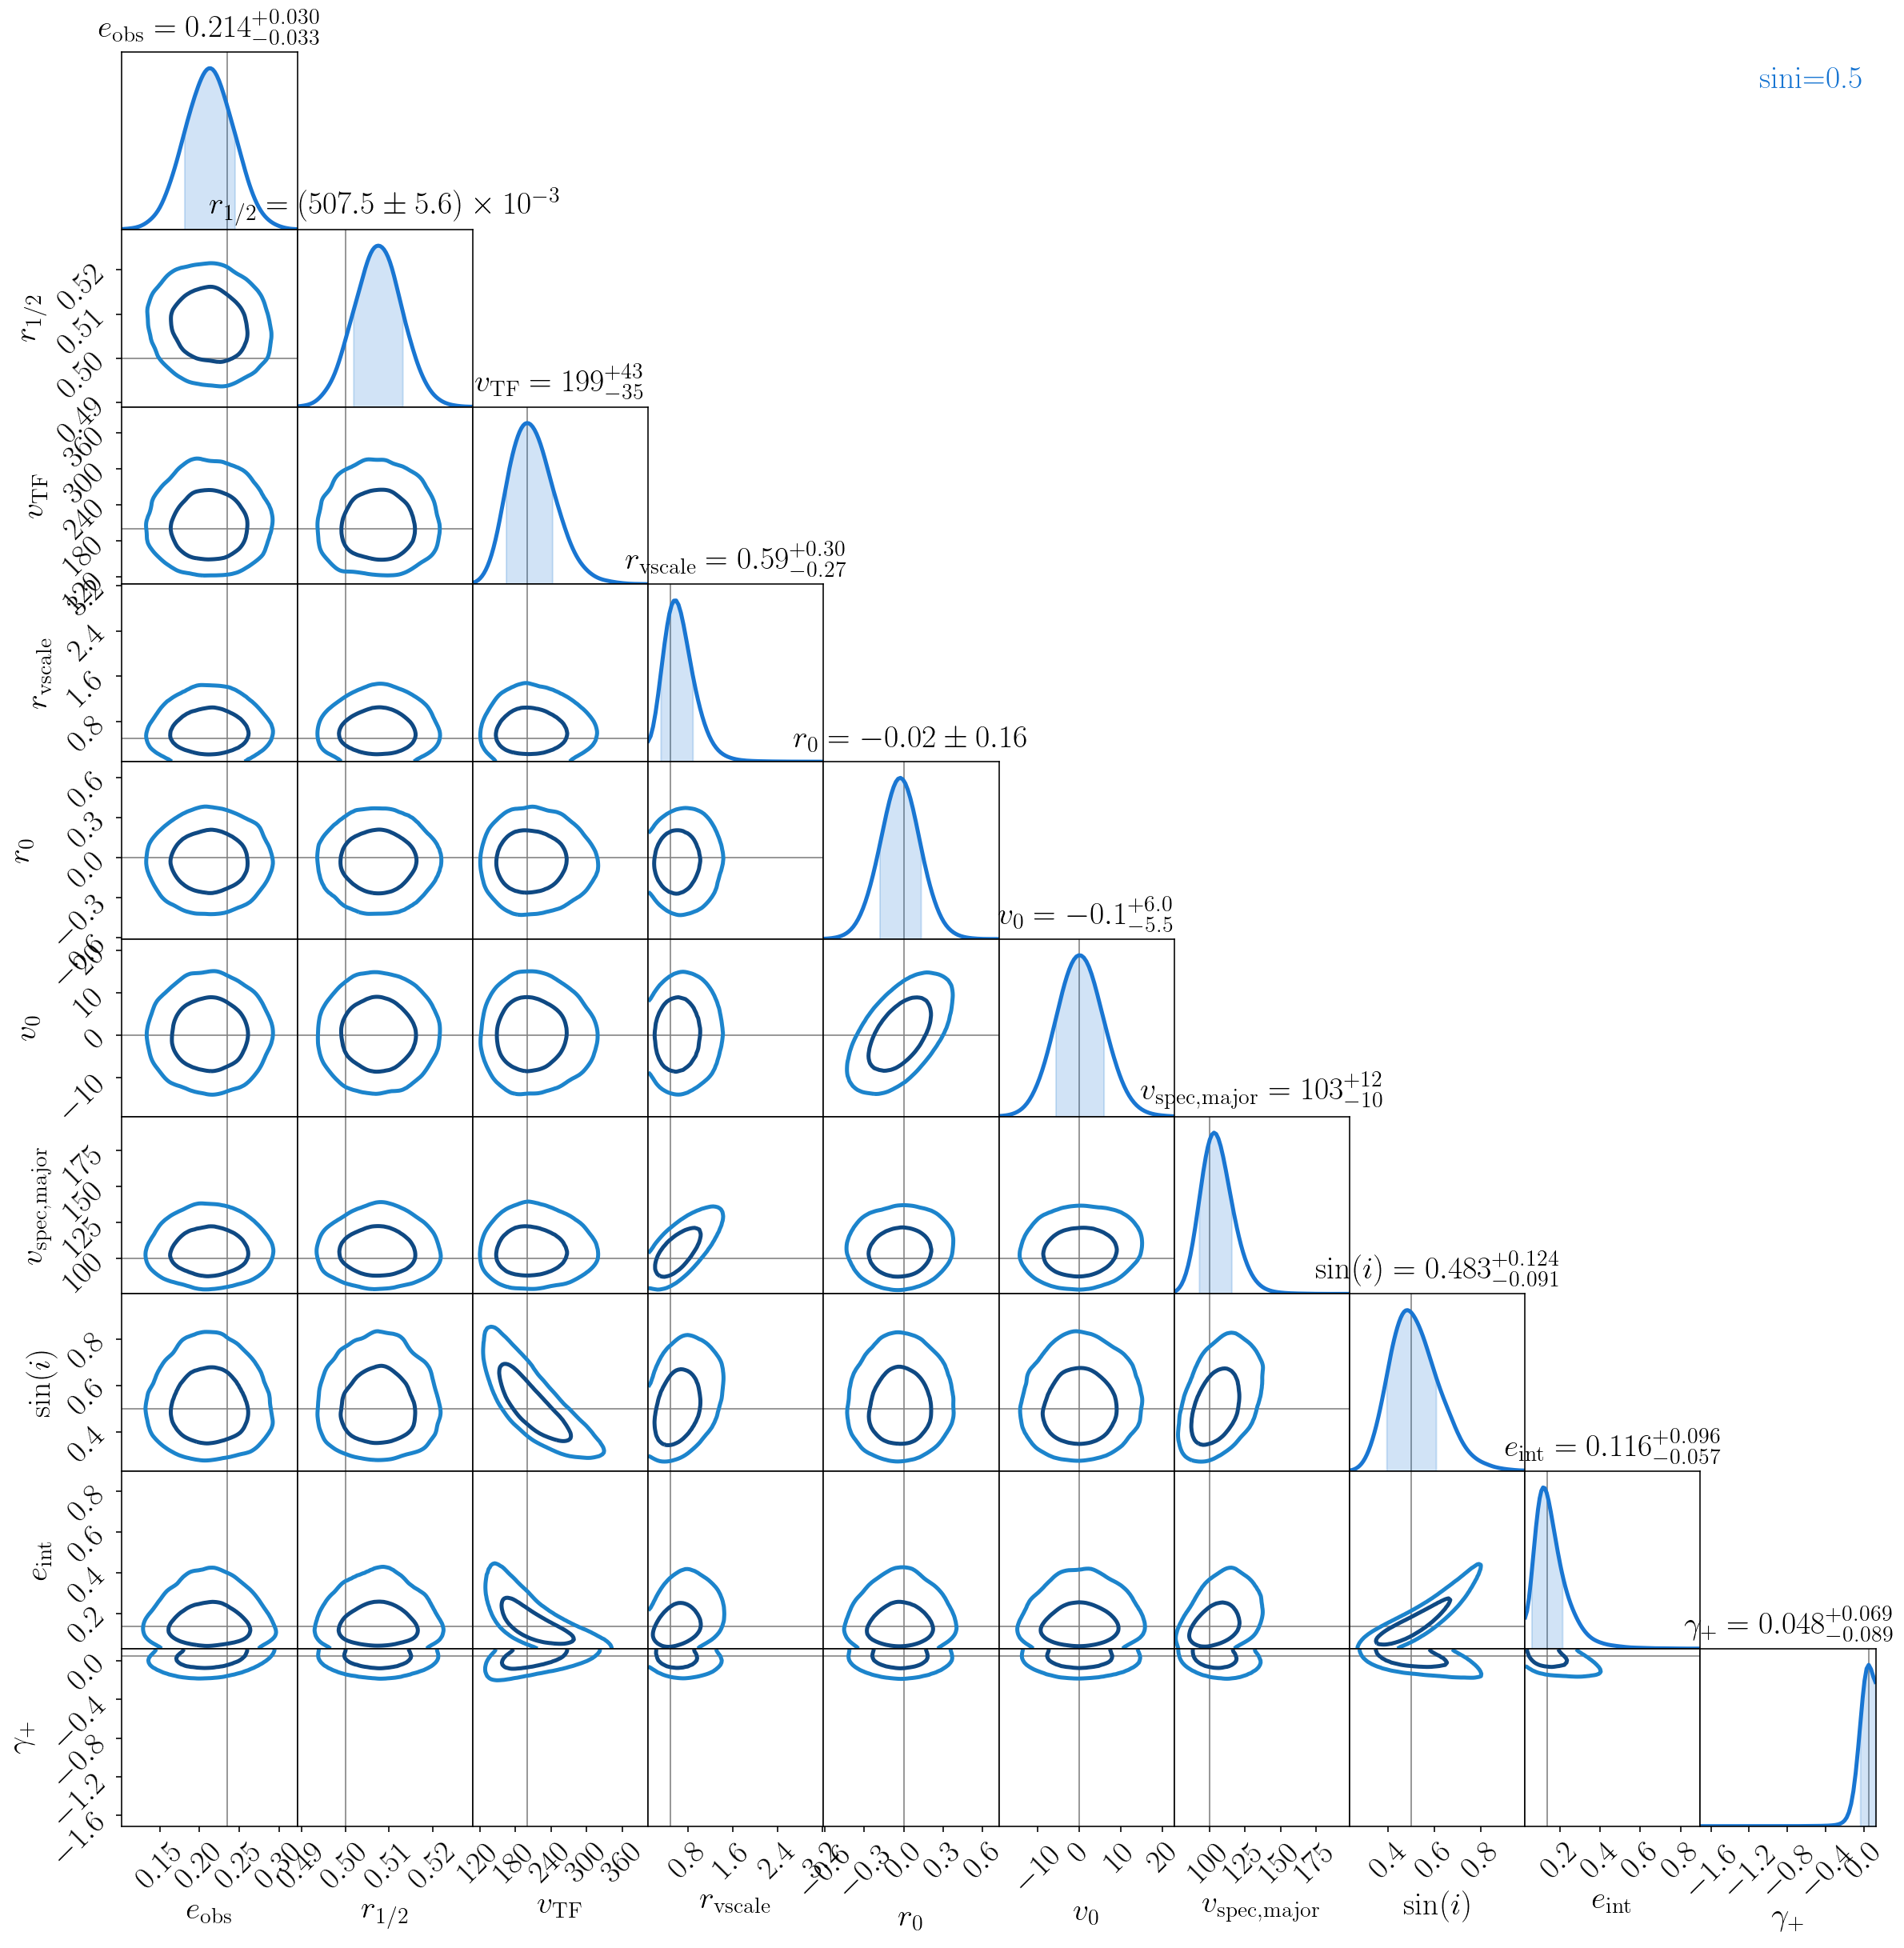

In [9]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['e_obs','half_light_radius','v_TF', 'vscale', 'r_0', 'v_0', 'v_spec_major','sini', 'e_int', 'gamma_p']

legend_chain = "sini=%.1f"%sini

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20,
            shade=[False]*Nchains,
            statistics=statistics,summary=True)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig_all_pars.pdf", transparent=True)